In [19]:
# Import libraries
import matplotlib.pyplot as plt
import climetlab as cml
from pathlib import Path
import os
import xarray as xr
import numpy as np
%matplotlib inline
from datetime import datetime
from dask.distributed import Client, progress
import properscoring as ps

In [20]:
client = Client(n_workers=8, threads_per_worker=2, memory_limit='10GB')
client


/home/sarkar/anaconda3/envs/weather/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41999 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41999/status,
Dashboard: http://127.0.0.1:41999/status,Workers: 8
Total threads: 16,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43959,Workers: 8
Dashboard: http://127.0.0.1:41999/status,Total threads: 16
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:40309,Total threads: 2
Dashboard: http://127.0.0.1:37281/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:36409,


In [21]:
base_path = Path("/home/sarkar/Documents/WeatherBench_12/geopotential_5.625deg/")
files = [x for x in base_path.iterdir()]
temp = []
for f in files:
    f = xr.open_mfdataset([str(f)],engine="zarr")
    temp.append(f)
    z = xr.combine_by_coords(temp,combine_attrs="override")

z = z["z"].sel(level=500)
z

<xarray.DataArray 'z' (time: 350640, lat: 32, lon: 64)>
dask.array<getitem, shape=(350640, 32, 64), dtype=float32, chunksize=(12, 32, 64), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00

In [22]:
test = z.isel(time=(z.time.dt.year > 2016))
train = z.isel(time = (z.time.dt.year.isin([range(1979,2016)])))

Give a date and time dd.mm.yyyy and hh from the test dataset, an ensemble of 50 members is randomly chosen such that 
Ensemble of 50 is chosen from a the train dataset with matching mm and hh. 

The period of such a forecast is 

In [29]:
total_crps = 0
total_rmse = 0
weights_lat = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])
weights_lat = weights_lat[:, np.newaxis]

In [30]:
for i in range(test.shape[0]):
    mm = test[i].time.dt.month
    hh = test[i].time.dt.hour

    ensemble_ = train.isel(time = (train.time.dt.month == mm))
    ensemble_ = train.isel(time = (train.time.dt.hour == hh))
    n = ensemble_.shape[0]
    indices = np.random.choice(range(n), size=50, replace=False)
    ensemble =  np.array(ensemble_.isel(time=indices))
    #print(i)
    observations =  np.array(test[i]) * 59563.01 + 77907.086
    forecast = ensemble * 59563.01 + 77907.086
    
    crps_score = ps.crps_ensemble(observations,forecast,axis=0)
    ensemble_mean = np.mean(forecast,axis = 0)
    rmse = np.sqrt(np.mean(  weights_lat * (ensemble_mean - observations) ** 2) )

    #print(np.mean(crps_score),rmse)
    print(i,np.mean(crps_score),rmse)
    total_crps += np.mean(weights_lat * crps_score)
    total_rmse += rmse
    

0 631.31555 1111.889308982529
1 707.6139 1211.7832651988285
2 766.0964 1298.7666353410423
3 640.66205 1109.6204998943322
4 706.8229 1212.4776484138765
5 735.2751 1216.393306330543
6 631.7399 1088.0364886011405
7 597.1867 1086.5894719460641
8 684.5327 1182.6090943682138
9 665.08374 1137.2293605740433
10 641.8297 1114.9699207254998
11 736.2355 1227.3958344031043
12 644.7377 1129.8823020557163
13 686.99524 1177.9819422939058
14 649.4612 1119.712076809639
15 663.9813 1118.7255120308953
16 740.1585 1239.2007028434969
17 592.4223 1024.18430393022
18 680.6139 1146.074195831682
19 679.08496 1165.7434779278774
20 691.03125 1171.6719548341862
21 710.96875 1181.9867798553332
22 732.32263 1220.608260885929
23 646.3706 1107.5709849413447
24 696.50024 1158.7148210501896
25 703.7815 1158.582457525966
26 662.23914 1102.2297678517816
27 803.2522 1326.032564998356
28 692.4054 1136.2451359868346
29 714.162 1159.2596064080087
30 734.06165 1210.8064951224512
31 701.76794 1154.319983742078
32 714.3645 1189.

2023-10-12 14:36:36,356 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


106 724.1498 1170.3169412738273
107 810.6251 1294.9054555921755
108 727.0401 1173.3622226964003
109 716.36163 1184.2319211563708
110 830.3147 1308.0381794122757
111 780.8417 1242.903835544756
112 727.3285 1170.8082319131654


2023-10-12 14:36:39,913 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


113 664.05554 1098.80814141087
114 770.1825 1236.1081388976056
115 689.5866 1172.2620318808097
116 680.43896 1118.9393568808855
117 749.9075 1217.4760057975789
118 722.8584 1211.5887012606352
119 717.9503 1203.4432095614893


2023-10-12 14:36:43,415 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


120 783.6472 1242.8199865664326
121 684.6854 1140.8765639795358
122 689.9232 1154.4010956517714
123 713.57446 1215.2622613379608
124 784.7472 1278.5925386921263
125 779.39124 1290.2160544885626


2023-10-12 14:36:46,637 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


126 726.47876 1218.5129401195136
127 687.57556 1141.8698125770084
128 720.15906 1169.805673941844
129 690.1865 1156.2274273605537
130 677.3616 1137.2923573156877
131 771.02344 1236.638301105089
132 732.92114 1203.6297452393492


2023-10-12 14:36:50,627 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


133 751.6179 1208.5473653269335
134 708.7686 1181.34210206458
135 673.02057 1132.8699024257776
136 800.8967 1276.737808401551
137 778.30505 1248.0821421958726
138 724.4586 1177.5809239107286
139 672.068 1123.1688978772186


2023-10-12 14:36:53,961 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


140 772.68713 1223.487507390791
141 695.0346 1130.1551117098052
142 753.8076 1219.8866311053434
143 813.4222 1273.4394271322387
144 708.3248 1141.6546777582416
145 807.63806 1278.9128218460335
146 724.3663 1143.9773628326152


2023-10-12 14:36:57,279 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


147 765.8373 1211.292428432527
148 790.4247 1229.846549540956
149 722.3754 1138.6486439414982
150 861.83044 1275.3180713219954
151 772.1791 1191.715753121707
152 801.2312 1244.0778871116142
153 797.7711 1224.2672706579315


2023-10-12 14:37:00,940 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


154 788.7988 1198.1475919204825
155 769.0234 1215.885880825897
156 755.0238 1168.6650979799458
157 708.0846 1159.7979526178456
158 865.5095 1289.5189972757098
159 891.0443 1320.4881147727963
160 667.9045 1056.0135513077007
161 814.56165 1260.5288721495663


2023-10-12 14:37:04,644 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


162 702.3054 1106.0795870157008
163 822.6158 1249.8088201340925
164 797.6122 1261.5210697625664
165 741.6105 1158.0938657808492
166 800.53705 1222.9799420458642
167 748.0321 1183.6511170501467
168 844.693 1284.4420980954553


2023-10-12 14:37:08,210 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


169 864.8772 1279.8044042127174
170 724.0313 1151.7495159335456
171 933.0746 1394.389412962364
172 701.2904 1135.6227675900498
173 822.10004 1278.482723435884
174 732.68005 1176.6263462850218


2023-10-12 14:37:11,532 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


175 832.59076 1306.381021318548
176 731.7363 1148.093118298351
177 838.4201 1291.363784552604
178 710.0448 1145.8749814073271
179 689.3928 1107.574920452589
180 723.69885 1166.6999406190378
181 684.3346 1096.6363053838108


2023-10-12 14:37:15,397 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


182 821.7202 1283.3044971230922
183 817.2843 1272.8438989514264
184 708.48193 1142.7316540269746
185 844.1135 1312.765110627423
186 802.9815 1268.0757079151715
187 852.24084 1313.9554574249448
188 834.4199 1278.2723664519763


2023-10-12 14:37:18,828 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


189 667.7925 1094.8781535228256
190 685.8185 1124.1442462662262
191 747.82764 1207.232729369881
192 860.95776 1349.3982325882973
193 761.84216 1218.28600915222
194 834.8159 1315.1045311456562
195 750.3037 1224.3710084861373
196 849.162 1297.8510002261155


2023-10-12 14:37:22,602 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


197 733.3905 1200.8565903382712
198 924.16846 1416.3949825325876
199 851.4918 1338.9236600853133
200 708.323 1158.1257329050497
201 820.05115 1271.4830599621018
202 741.88416 1177.3064382916673
203 936.3759 1422.045285124765


2023-10-12 14:37:26,280 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


204 757.1285 1222.7987965758696
205 784.4755 1287.3302623660506
206 877.9845 1364.7563206156517
207 829.0254 1309.3512776863456
208 856.0912 1320.8825306137983
209 804.01514 1282.3936507065118


2023-10-12 14:37:29,699 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


210 733.69556 1176.5379416748542
211 751.85425 1214.340132594217
212 785.0932 1252.4322816254094
213 695.4625 1145.8786491463597
214 808.64746 1295.8650979031506
215 718.9303 1178.838301327408
216 757.0845 1207.5288203919108


2023-10-12 14:37:33,311 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


217 779.96094 1263.1030036504455
218 782.8455 1248.3963763431907
219 707.349 1160.0116902660304
220 895.88403 1415.0369137934342
221 746.6543 1221.065906649739
222 751.84375 1234.0455008036795
223 793.4784 1247.8093439539368
224 792.4733 1288.1470734875866


2023-10-12 14:37:37,121 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


225 793.0094 1247.1567081459077
226 726.2184 1196.3840552606773
227 789.09814 1292.798816645601
228 773.8484 1242.8382814977376
229 758.6145 1244.1051353188761
230 691.35815 1154.2219325357132
231 717.1559 1203.8659463540669


2023-10-12 14:37:40,724 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


232 826.5381 1320.1469728142831
233 767.9685 1263.312940921425
234 855.6842 1357.1194650573848
235 861.12354 1368.4701358736927
236 691.8413 1187.8979684759834
237 721.8356 1177.7966566100665
238 720.0093 1184.0911086590904


2023-10-12 14:37:44,366 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


239 778.27856 1270.4228290158308
240 725.22546 1193.6503527965838
241 972.1437 1485.8394467343014
242 752.73157 1252.4330544681695
243 778.8644 1272.3917732472316
244 781.20447 1241.9634174387513


2023-10-12 14:37:47,750 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


245 745.2428 1236.779391692617
246 729.3953 1224.4132988718009
247 788.38794 1289.171008151377
248 726.3627 1202.693305645417
249 805.13696 1292.8792124369982
250 777.1858 1253.8151875901567
251 853.9415 1339.5660764763416
252 742.5311 1223.0155685687052


2023-10-12 14:37:51,467 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


253 770.73486 1268.84415418217
254 867.6023 1406.47340697941
255 743.0596 1232.4015511399432
256 747.81805 1237.8650316064884
257 773.1618 1272.0598515060333
258 738.4154 1242.5902290239778
259 825.92255 1338.4229255933428


2023-10-12 14:37:55,121 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


260 863.25336 1396.0507245937342
261 817.7993 1344.5934799009651
262 770.6156 1279.1835455914434
263 828.23 1344.6457587225598
264 780.1352 1278.626855540632
265 810.9999 1332.5692774774013
266 777.4973 1266.1381871770802


2023-10-12 14:37:58,767 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


267 841.093 1320.9806980975502
268 769.312 1281.0650381402736
269 770.3987 1257.2628354294086
270 800.64014 1312.7740426981563
271 869.09485 1399.6859026240152
272 721.62317 1174.4831909091986
273 731.65106 1218.5343436013318


2023-10-12 14:38:02,428 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


274 685.59973 1147.0083708750744
275 742.381 1237.4616056338855
276 874.22 1371.6326832403893
277 756.5897 1262.5379693683406
278 799.52527 1307.0911537844056
279 802.0674 1286.7699147413139
280 736.9421 1203.791432517736


2023-10-12 14:38:06,037 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


281 765.18195 1267.5595304395795
282 687.2897 1147.250090801581
283 733.1933 1186.7167019238616
284 804.3093 1304.442613631886
285 849.33624 1343.6163698426285
286 804.29395 1287.1569818586233
287 749.2451 1222.6083795422976


2023-10-12 14:38:09,608 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


288 815.02356 1305.2651862981804
289 916.90027 1434.4055983634664
290 804.9473 1290.029012867336
291 813.45337 1280.152976078568
292 794.1521 1265.647479728022
293 838.43036 1320.2714875409072
294 916.91113 1409.0386386417777


2023-10-12 14:38:13,186 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


295 751.2305 1209.1450173055246
296 843.38513 1300.5735444237484
297 874.12067 1372.6560933049861
298 798.1188 1243.2345321240407
299 842.6577 1315.2816255597393
300 840.51196 1311.9281862731086
301 826.4332 1269.07282577252


2023-10-12 14:38:16,825 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


302 893.3123 1375.5094371843945
303 848.1151 1302.6980875292986
304 797.99115 1267.3900255316778
305 826.0321 1270.029149224768
306 834.62085 1274.5762114130628
307 852.09985 1305.875041249019
308 856.4601 1305.8349137765201


2023-10-12 14:38:20,446 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


309 826.4906 1284.4924653384467
310 816.6462 1259.9699142528725
311 882.98315 1350.9671865360178
312 846.03687 1287.4872727421996
313 770.2955 1181.5015709542727
314 990.2223 1477.5658441922888
315 885.6926 1334.0826964411738


2023-10-12 14:38:24,050 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


316 806.1256 1249.0996790680995
317 825.5059 1274.403632951791
318 853.3172 1301.927176348579
319 787.6315 1235.6296713708753
320 806.48865 1268.86359370173
321 895.0493 1354.609641764123
322 759.1067 1214.7740047844222


2023-10-12 14:38:27,771 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


323 896.1504 1371.5916873571118
324 779.4562 1224.0323624091045
325 824.0925 1286.197198876013
326 838.8467 1309.6051943384493
327 931.08325 1426.5174475307401
328 943.521 1421.9650582865906
329 855.0559 1306.631793215


2023-10-12 14:38:31,458 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


330 838.5936 1311.7795776397734
331 815.15546 1269.5540769144905
332 746.458 1195.406381951408
333 766.5591 1217.9394889261353
334 823.96436 1314.1688875997036
335 839.38654 1324.2073999029253
336 828.75256 1330.3730609987697


2023-10-12 14:38:35,112 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


337 811.4563 1297.8679474301139
338 794.22925 1279.1185433041658
339 828.1858 1321.35416238061
340 951.65735 1455.7698224647884
341 780.8845 1292.231592399496
342 923.4071 1448.3817495034903
343 662.3432 1110.0218335943478


2023-10-12 14:38:38,773 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


344 821.97723 1315.4450880051927
345 771.58276 1285.5147791951913
346 694.4229 1173.4797436108604
347 901.2345 1383.1911238111397
348 842.21204 1327.8375479239512
349 791.5869 1289.8238249768872
350 808.7488 1305.94946414378


2023-10-12 14:38:42,349 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


351 751.6769 1223.590715745073
352 755.4225 1242.4562655975726
353 807.74817 1296.777281302944
354 891.7749 1416.2230012350883
355 822.6711 1306.2968292439375
356 884.3451 1388.587624640074
357 919.0761 1410.5593547466992


2023-10-12 14:38:46,011 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


358 940.42175 1409.6513298639652
359 750.92584 1236.6640638895074
360 670.308 1103.2593534293394
361 820.1427 1292.712089649974
362 883.15137 1360.4926436138055
363 860.61084 1360.39715728435
364 860.67444 1351.015866092966


2023-10-12 14:38:49,772 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


365 724.8889 1180.3755450211224
366 732.42413 1174.8949290691844
367 827.5818 1301.6234642095965
368 740.2436 1172.5428159386204
369 813.23425 1256.6048642338797
370 920.25903 1428.787588955001
371 723.549 1170.519238994344


2023-10-12 14:38:53,645 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


372 846.2823 1293.4706543276386
373 828.24304 1284.50843520799
374 807.6865 1254.7605035938554
375 972.24506 1421.3943471053112
376 846.9805 1308.786802289511
377 912.0483 1384.7589130653319
378 801.91864 1249.8759687184167


2023-10-12 14:38:57,493 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


379 812.9397 1283.330411394343
380 859.6455 1301.4904535556348
381 833.95154 1271.7274273662226
382 781.5465 1223.4771901125948
383 862.66504 1333.3051290592332
384 849.44214 1284.3384386458697
385 896.12354 1347.4203287518978
386 813.5908 1237.7265702593756


2023-10-12 14:39:01,421 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


387 923.6378 1373.7198617437598
388 841.2014 1249.8334375306845
389 920.451 1353.2169010464888
390 797.62573 1207.67571904682
391 870.7998 1288.7599855631374
392 967.3576 1395.6860387761806
393 908.8746 1324.3114630908058


2023-10-12 14:39:05,113 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


394 879.9904 1292.3301473848953
395 979.39105 1393.9186456861519
396 799.11646 1177.916733566116
397 833.95337 1243.8553887038604
398 964.6295 1385.5198745466084
399 794.0167 1164.177371862733
400 785.7196 1166.4321289526908


2023-10-12 14:39:08,738 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


401 920.326 1298.621494652134
402 878.18933 1267.9436410824223
403 926.5407 1341.4310030275685
404 1002.09827 1422.8750453507325
405 964.66724 1357.699173979988
406 983.00024 1404.4986589785126


2023-10-12 14:39:12,171 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


407 964.57117 1374.0458466654484
408 880.8406 1295.0212821904909
409 908.18353 1300.3542402523601
410 827.6025 1221.266046608339
411 894.43304 1314.523653098676
412 784.5243 1207.1586802454765
413 901.86804 1300.6073160954745


2023-10-12 14:39:15,858 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


414 950.41284 1359.6083959029654
415 844.0494 1237.1119030500117
416 1041.9209 1470.1913072344887
417 801.69214 1182.9816714049664
418 1068.5322 1476.4513750996682
419 879.84204 1255.0495092673527
420 861.3823 1268.7339038236541


2023-10-12 14:39:20,032 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


421 977.87476 1378.8059310569529
422 972.89453 1367.6707421611763
423 934.03937 1304.2503862876679
424 1118.938 1523.5077743234237
425 851.7893 1253.2762269971865
426 1005.59973 1437.6388406142364
427 986.7437 1387.472592446908
428 854.0154 1222.5376922158623


2023-10-12 14:39:23,747 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


429 833.4928 1196.2096877167974
430 1072.4546 1474.8318443956791
431 1034.5858 1401.30272994849
432 969.90576 1364.4457670307438
433 952.6929 1367.157009139804
434 941.5178 1335.4630534252287
435 907.4351 1275.5022022364662


2023-10-12 14:39:27,376 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


436 949.6345 1334.7193909239206
437 891.93774 1263.1794600258602
438 927.0161 1328.1566158890987
439 1008.2857 1429.6696202794637
440 938.39056 1322.5611383858238
441 890.6696 1278.1966027508677


2023-10-12 14:39:30,735 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


442 858.82227 1223.9023708160344
443 930.364 1331.569124103257
444 980.11304 1328.8668894419811
445 958.5658 1381.1067419323597
446 961.7939 1355.9616616663254
447 910.7304 1280.2171897968976
448 920.2329 1334.0409150200044


2023-10-12 14:39:34,658 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


449 913.97046 1297.8514343583554
450 956.7675 1379.3116601879503
451 743.8751 1118.2222461647918
452 929.94006 1330.7685608021716
453 889.15356 1317.250371027197
454 857.2241 1254.4991467954237
455 1010.9164 1448.726154617733
456 990.57007 1424.6194041374702


2023-10-12 14:39:38,602 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


457 826.7005 1222.0847457347172
458 775.43866 1172.8018641165102
459 881.2112 1281.918875560596
460 949.9916 1390.3229165610735
461 869.06494 1304.9482115297158
462 876.2084 1289.733247041584
463 817.2917 1237.3038329534472


2023-10-12 14:39:42,304 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


464 874.80786 1332.199833821638
465 845.04956 1263.929160466533
466 831.2595 1234.1598829166144
467 980.41956 1470.7422063527083
468 844.67126 1272.5205038151664
469 863.0394 1312.3235664063784
470 927.6536 1352.7343362400272


2023-10-12 14:39:46,039 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


471 894.34705 1358.2317724445543
472 931.07477 1387.5279639232522
473 816.8993 1255.4473995098929
474 811.70764 1242.3707469280048
475 802.68915 1273.690171739571
476 948.5856 1430.4247535873255
477 799.1816 1236.1224801147555


2023-10-12 14:39:49,690 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


478 854.3636 1348.5020189021745
479 797.9477 1238.7383330735022
480 825.54755 1322.9217664274722
481 869.63947 1364.6637591765518
482 891.321 1393.615548161416
483 770.3468 1236.0554621025224
484 722.2231 1197.0567616370447


2023-10-12 14:39:53,404 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


485 765.4281 1271.230444516308
486 767.749 1261.28612749919
487 858.92096 1376.154028587583
488 769.8241 1250.0475625445436
489 852.7003 1364.9418154365978
490 772.5885 1316.1264041572817
491 727.7642 1244.7447725454049


2023-10-12 14:39:57,169 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


492 809.91956 1336.2310919359236
493 857.9924 1419.4082364748624
494 908.8733 1443.2610409330937
495 752.7964 1272.615097276788
496 871.43884 1405.4536636467296
497 826.4049 1384.9302529980616
498 738.85486 1232.442993097094


2023-10-12 14:40:00,835 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


499 813.97925 1360.2922830346577
500 788.9983 1327.322379644183
501 745.0909 1281.516583977392
502 722.89496 1236.6462798813686
503 754.0737 1307.1009952194486
504 698.6489 1211.9705067196494
505 637.5371 1132.1843059166736


2023-10-12 14:40:04,507 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


506 790.3318 1354.807158306515
507 746.43036 1296.4846901030037
508 739.4053 1266.2459955122122
509 726.8726 1264.6327805727112
510 799.57324 1353.6430740379926
511 725.0402 1269.1628835184827
512 799.5985 1336.7964275272082


2023-10-12 14:40:08,163 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


513 783.9135 1308.550376386088
514 808.91046 1373.3910120326202
515 754.99805 1307.437443831208
516 728.8613 1255.4400483826246
517 768.06616 1310.9205031838728
518 705.8086 1203.2130920065
519 793.94507 1345.9902925062088


2023-10-12 14:40:11,785 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


520 676.01465 1180.9542428676775
521 779.58594 1327.061100462987
522 693.9048 1190.2403273398672
523 847.16223 1408.31587408534
524 731.07227 1277.2157306457727
525 775.55945 1314.4694922934593
526 772.9855 1324.6116331120131


2023-10-12 14:40:15,430 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


527 878.2693 1442.2612504175422
528 785.02966 1301.5480125198296
529 894.48975 1441.7219370869911
530 895.31946 1463.5448029372235
531 796.25543 1330.0399278312248
532 767.0101 1269.3985842919385
533 755.5655 1258.7983562274383


2023-10-12 14:40:19,196 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


534 777.2648 1286.3975140729965
535 960.2778 1492.590528226434
536 957.5162 1485.2516667861332
537 687.9286 1171.1301919079103
538 747.4752 1226.296755064924
539 911.6654 1470.5387436039423
540 852.4486 1364.126166223184


2023-10-12 14:40:22,905 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


541 862.50714 1413.3021076910104
542 899.86456 1395.1413925221404
543 928.6039 1454.7328364104008
544 895.2849 1406.3726354955816
545 936.48114 1440.3424171346408
546 777.658 1269.700551428007
547 780.3369 1272.7033662111398


2023-10-12 14:40:26,684 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


548 896.2438 1378.3536048503754
549 808.1854 1311.417731420384
550 771.5414 1198.2874774968782
551 979.73553 1499.7202422573403
552 859.4555 1359.860200411232
553 956.73645 1480.645714760556
554 834.6461 1314.4859908358649


2023-10-12 14:40:30,363 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


555 903.12305 1394.8368544215264
556 909.4532 1405.673164404666
557 865.5551 1355.153484680095
558 866.6777 1376.0999048411356
559 864.24994 1334.5026837269334
560 936.7435 1421.7100531850683
561 936.7191 1423.6259235453992


2023-10-12 14:40:34,167 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


562 955.1976 1432.177177588121
563 914.99133 1386.1495991240413
564 925.5062 1423.3199633468423
565 865.056 1325.4794199665541
566 825.4353 1277.1703693604263
567 1003.63165 1475.1802377213642
568 991.94763 1480.2077059517692
569 879.66376 1348.1116513313077


2023-10-12 14:40:38,028 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


570 945.5697 1415.9183516657095
571 897.1123 1351.9633220538974
572 841.1466 1300.8936202680536
573 787.8821 1239.7540094914148
574 822.7792 1253.4093974122636
575 920.0391 1387.611358260173
576 922.91425 1361.6687829286022


2023-10-12 14:40:41,746 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


577 872.7418 1336.1374187482113
578 922.1063 1383.805913478661
579 832.9327 1256.4567628293262
580 852.5349 1284.6082836825485
581 958.9147 1411.7427044029957
582 742.0475 1150.10564673109
583 945.1689 1379.8039732394675


2023-10-12 14:40:45,374 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


584 814.9803 1218.3289970590865
585 882.9791 1308.571489542975
586 870.2689 1317.427447859923
587 877.77966 1306.7314549577134
588 908.04926 1360.9815914398368
589 879.48083 1309.8967333599342
590 833.01965 1254.0433427636394


2023-10-12 14:40:49,037 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


591 795.0409 1171.6493187640142
592 928.31256 1384.4630337888227
593 820.18854 1240.9129630370305
594 1017.28625 1484.3199532179356
595 907.59424 1344.2686115829904
596 898.8973 1365.6663821265063
597 973.0075 1416.4048744907568


2023-10-12 14:40:52,779 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


598 875.8804 1317.2934465475264
599 927.3843 1362.2868810679836
600 864.4174 1344.1790751058713
601 886.71326 1353.129295307753
602 813.536 1265.0709728901031
603 931.82074 1381.576523150008
604 877.1549 1309.4007287724232


2023-10-12 14:40:56,901 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


605 909.1853 1348.922305565334
606 902.84686 1366.7798344570235
607 805.3622 1218.1833991614649
608 851.32947 1299.145448482534
609 898.495 1364.6387155516343
610 783.9979 1226.6646330228934


2023-10-12 14:41:00,269 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


611 794.2759 1241.9895272126037
612 773.4293 1207.4895298108133
613 836.2115 1312.883458336871
614 808.0199 1233.1735705225385
615 853.2031 1303.6547154140953
616 860.70544 1325.3401584944952
617 825.70325 1273.9451276769814
618 759.43677 1201.9306223226351


2023-10-12 14:41:04,160 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


619 834.20544 1293.9703203777992
620 894.6572 1397.570876022226
621 771.1011 1246.3331013907093
622 920.8855 1415.7392918063724
623 841.6 1347.776786307879
624 852.2282 1347.1712576002549
625 863.2483 1359.4940266822562


2023-10-12 14:41:07,885 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


626 733.8075 1195.9807967578188
627 734.80945 1193.0048052776488
628 900.49915 1397.7444701625018
629 953.19934 1466.3558066120256
630 855.16595 1369.009128794326
631 764.76587 1226.4280066430963
632 773.2618 1239.8905489108943


2023-10-12 14:41:11,594 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


633 811.3406 1315.3378768867774
634 797.8388 1278.1625651636105
635 772.88403 1240.040504184111
636 778.1768 1259.634190139364
637 834.1642 1368.4122339432743
638 809.8676 1284.4918594445921
639 891.2778 1376.3201407588313


2023-10-12 14:41:15,349 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


640 776.422 1250.7667401086082
641 831.1747 1327.515055987449
642 731.9817 1209.08597338568
643 738.8313 1207.6881891500439
644 865.6505 1384.8114435214793
645 914.10815 1432.8909989914773
646 778.2799 1244.5929895586505


2023-10-12 14:41:19,047 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


647 813.99744 1295.2921123426559
648 747.5796 1194.06483689571
649 722.16724 1207.9614347892714
650 787.98804 1283.1880437070472
651 744.4965 1226.6528929282463
652 689.2433 1142.8221345021364
653 851.4557 1380.2911083263696


2023-10-12 14:41:23,210 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


654 845.9712 1359.719964646187
655 799.85254 1305.526805466654
656 773.59973 1282.7109259036808
657 689.7426 1176.4598504050784
658 693.0382 1186.2276329569393
659 830.562 1355.956053335108
660 808.05347 1318.8660647951103


2023-10-12 14:41:26,983 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


661 749.5149 1232.9153134923235
662 848.08496 1355.2961961661692
663 960.1918 1504.134790705564
664 803.4282 1314.1460848298148
665 880.2197 1405.5659876191867
666 743.23145 1234.5930952482486
667 799.46387 1299.515814001543


2023-10-12 14:41:30,605 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


668 784.716 1253.3438142470438
669 698.8028 1158.903058287488
670 697.136 1153.4434882780777
671 843.83795 1359.1084605696246
672 722.26636 1189.8237228092848
673 616.34656 1051.312026575002
674 705.76807 1188.2758718417294


2023-10-12 14:41:34,374 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


675 761.2473 1272.7859353544632
676 705.5856 1196.1545682377175
677 733.43823 1232.4499638063628
678 617.91907 1083.602323194202
679 695.4929 1187.949127865406
680 648.7789 1125.1103596631758
681 701.8623 1210.8032838916963


2023-10-12 14:41:38,068 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


682 719.8536 1239.0630450232788
683 694.372 1191.3107376417483
684 638.5956 1106.6295314134252
685 672.5988 1170.5460279706344
686 849.6378 1402.7746061135722
687 602.6515 1063.4030267016258
688 711.3452 1250.5141994470637


2023-10-12 14:41:41,772 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


689 736.9116 1227.6664145160707
690 714.4442 1210.1328587804317
691 717.9027 1234.4373996479274
692 898.13916 1461.7157146340764
693 810.20514 1350.6712433674268
694 676.2035 1183.09528277845
695 691.91626 1191.8218291201215


2023-10-12 14:41:45,412 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


696 809.1573 1342.121474500277
697 808.1869 1349.9937064368305
698 680.04675 1220.195209405015
699 716.73474 1239.8912475373952
700 706.01245 1232.425219074336
701 700.7894 1223.253797510012
702 817.06335 1356.3139720038173


2023-10-12 14:41:49,193 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


703 785.5819 1316.6858000509878
704 662.4476 1206.2789341590887
705 729.24963 1268.1423311582862
706 819.4946 1397.9888331134662
707 720.3324 1275.011945503042
708 751.9965 1291.1966657395587
709 628.84534 1124.9407935097283


2023-10-12 14:41:52,893 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


710 672.9307 1198.4381655503516
711 764.36096 1305.2632483304624
712 685.51605 1211.0504472438613
713 642.79297 1139.4272752522788
714 672.5094 1198.1820117384652
715 565.34064 1036.7511088810716
716 733.4636 1267.6563584867304


2023-10-12 14:41:56,693 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


717 701.0304 1229.474464462099
718 665.4047 1186.7507135554476
719 644.8262 1154.6721716287466
720 706.69727 1252.0827504407491
721 766.29034 1307.5936091012618
722 743.2886 1290.6764709156744
723 731.552 1264.8066241449676


2023-10-12 14:42:00,539 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


724 788.61914 1341.202682253968
725 798.30707 1347.0066672744324
726 713.60065 1242.133813566816
727 702.2246 1215.9862428041279
728 848.7129 1407.5981804675184
729 882.9956 1442.8120760932923
730 727.55365 1264.4119063214894


2023-10-12 14:42:04,370 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


731 753.9162 1282.5752331260373
732 678.4205 1183.0940981645656
733 660.0659 1173.2407181703707
734 874.01605 1427.4740934140084
735 746.58093 1291.0103194882633
736 720.66614 1262.848550455976
737 702.1343 1227.8041631781869


2023-10-12 14:42:08,272 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


738 740.2711 1276.4560031103579
739 683.8152 1209.321954153978
740 747.10815 1270.1315723833802
741 711.5878 1250.3557218717326
742 766.38446 1318.4427733135442
743 748.9666 1286.0914873496613
744 669.8185 1183.8074892473308
745 836.8021 1403.632281227907


2023-10-12 14:42:12,242 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


746 672.856 1172.0609597282364
747 726.30255 1283.3235764122326
748 732.71265 1263.207598353099
749 731.55646 1301.8845638542266
750 891.9181 1450.399639193004
751 616.2539 1105.4327415160794
752 737.2744 1283.6994858137673


2023-10-12 14:42:16,031 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


753 654.2528 1155.7735606905014
754 780.55304 1344.0836369905423
755 697.88605 1204.341891070319
756 848.06104 1421.4863946339005
757 653.64575 1158.234784191795
758 800.48804 1357.5489178845833
759 815.2344 1380.9834579958833


2023-10-12 14:42:19,771 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


760 826.87695 1385.8498134814483
761 761.8417 1297.9402526400245
762 825.00574 1370.2821410871115
763 764.5147 1298.9912600269884
764 722.3816 1250.7744789298906
765 842.5032 1429.4319189653768
766 689.58826 1217.501490138799


2023-10-12 14:42:23,677 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


767 698.15076 1211.0345197139961
768 748.7843 1298.6136130534749
769 845.6388 1435.7370185111524
770 784.4312 1324.9800391834642
771 689.1505 1236.9841410248669
772 853.78845 1439.4962738464546
773 827.1361 1366.9734234862406
774 737.68384 1293.4424288435098


2023-10-12 14:42:27,806 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


775 677.15784 1204.5172884270726
776 793.9142 1363.6071699132406
777 741.47906 1299.4306982690016
778 695.5534 1246.3378371486738
779 704.71375 1258.937734696963
780 640.8513 1154.5429863181707
781 746.34985 1332.493064817218


2023-10-12 14:42:31,554 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


782 802.00916 1399.7659502353956
783 673.2674 1203.2587304973501
784 791.17694 1351.6434126575357
785 745.71466 1330.9855812631843
786 696.1465 1262.7207924012425
787 787.1475 1381.4674457447047
788 747.6864 1326.825495480664


2023-10-12 14:42:35,323 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


789 912.24963 1550.191623483649
790 743.9844 1337.2053790121697
791 771.3481 1340.6935018528645
792 842.78955 1430.5721820047431
793 700.93884 1245.4359224820582
794 759.3301 1325.383867007317
795 771.5364 1334.5607366118631


2023-10-12 14:42:39,284 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


796 735.0377 1262.9350486678336
797 698.90784 1230.785552392163
798 779.6759 1368.8780389472981
799 739.4049 1270.5060702356845
800 674.53784 1220.3038868025344
801 672.6207 1183.232662717572
802 729.57874 1268.1375312842174
803 730.44885 1310.7806996469214


2023-10-12 14:42:43,241 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


804 725.20776 1269.4930130192654
805 639.0769 1173.7876795204495
806 740.2002 1277.584970790279
807 858.4681 1443.4332030880753
808 735.0732 1284.3094649860664
809 633.677 1139.7743784796505
810 859.90094 1443.7727938981484


2023-10-12 14:42:47,028 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


811 790.2776 1360.4790289576758
812 770.9497 1331.8962230123836
813 754.71594 1331.44392194284
814 788.9978 1326.9838940424022
815 660.19604 1192.8820126467435
816 768.02057 1342.8355789579389
817 761.7571 1318.0358157647706


2023-10-12 14:42:50,805 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


818 719.25037 1225.4639532894985
819 786.646 1363.0225185807176
820 834.4951 1387.5936610355502
821 761.3543 1286.3141166833116
822 783.9619 1345.7067722922245
823 727.0511 1247.7509075797882
824 882.6914 1465.1728451223225


2023-10-12 14:42:54,538 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


825 803.682 1353.294630690643
826 710.46716 1239.1656633240193
827 801.86414 1335.1407327474665
828 770.11786 1308.4756899734891
829 839.0713 1415.455325342246
830 779.74713 1309.9477214158142
831 773.3074 1294.6118168078397


2023-10-12 14:42:58,540 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


832 782.1138 1322.2147788619184
833 709.9869 1249.9196996987598
834 829.5033 1375.4611254098036
835 811.2401 1355.3157608362446
836 692.0696 1210.98859535035
837 761.0429 1298.1534585436837
838 831.2475 1394.4491005159105


2023-10-12 14:43:02,188 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


839 826.34485 1381.76479655614
840 770.12805 1324.8795834626053
841 681.04376 1201.1529601559841
842 841.1902 1435.463451115586
843 709.8168 1234.65001781965
844 867.1671 1469.685590653813
845 839.4334 1399.5727068381586


2023-10-12 14:43:05,928 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


846 704.90845 1239.7060686480377
847 791.18805 1373.164835521848
848 604.87195 1089.2749539294239
849 773.8694 1328.6015523018107
850 784.2045 1297.3910421713233
851 753.37177 1296.298459973877
852 797.77716 1353.722632683017
853 678.00305 1213.1601049359517


2023-10-12 14:43:10,051 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


854 725.54297 1264.3536470929948
855 651.0305 1187.0586466775053
856 728.1266 1266.5602203900476
857 670.30896 1206.2242847927591
858 681.5254 1206.3770194578046
859 647.07074 1177.3229646024974
860 780.3616 1352.5441188229183


2023-10-12 14:43:13,782 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


861 807.2565 1393.4364107965303
862 792.08 1370.508480514367
863 683.9222 1227.4927889914559
864 668.4979 1196.163989130963
865 709.6339 1241.4507613994929
866 717.0679 1244.8555933484797
867 692.3373 1234.8912303459938


2023-10-12 14:43:17,472 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


868 709.37384 1268.3335521721556
869 669.19336 1201.2396755678403
870 746.7207 1282.2177742861145
871 696.1052 1216.3901908308244
872 754.2784 1284.5997550366603
873 670.07324 1200.3289594453988
874 730.66956 1242.8855006538336


2023-10-12 14:43:21,442 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


875 727.19446 1265.2289363137695
876 721.4475 1260.0044779783582
877 719.92365 1279.1337293973206
878 718.15894 1276.3138952772904
879 676.72833 1198.4832039340927
880 771.3191 1349.7068208826465
881 748.2358 1297.0911541581347
882 677.6223 1194.943015749677


2023-10-12 14:43:25,627 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


883 694.80676 1214.769642440929
884 760.3651 1314.957534248976
885 730.95245 1288.8425070565763
886 648.63165 1159.0083527085733
887 652.3906 1142.0453983476457
888 664.8702 1174.3976919565268
889 715.99243 1250.7129124159117


2023-10-12 14:43:29,461 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


890 665.1178 1175.760511995583
891 694.7489 1221.0229886856775
892 708.3121 1253.884265537918
893 738.762 1292.4705871673966
894 676.6058 1180.3695037696898
895 645.1764 1127.8693897705732
896 692.82806 1211.2824644239715


2023-10-12 14:43:33,160 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


897 780.9991 1345.6933008317371
898 778.81305 1351.4845004676492
899 639.83606 1122.254229199171
900 680.3733 1221.174716106729
901 638.94714 1134.7198484579312
902 735.41284 1261.7491564539912
903 705.53064 1250.36856450611


2023-10-12 14:43:36,853 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


904 675.04596 1200.4080539234817
905 777.6794 1327.8837706835109
906 728.5525 1279.7529523850208
907 631.63763 1118.5361019981542
908 688.2042 1211.1254358694116
909 717.14197 1251.5412519228043
910 689.6379 1225.260622084797


2023-10-12 14:43:40,757 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


911 628.9797 1136.3213202690783
912 741.33264 1304.145193522279
913 672.3382 1188.3929715849292
914 678.65173 1220.0267475992657
915 748.3916 1320.3645326670596
916 742.7015 1310.5612020729036
917 673.6455 1203.6233150553676
918 694.64825 1238.528610722955


2023-10-12 14:43:44,785 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


919 690.24884 1213.8322210989218
920 730.8544 1295.9382498690063
921 704.7811 1260.8996343686104
922 688.1345 1263.478267948201
923 743.64984 1336.0274863704144
924 679.99677 1216.4885542120787
925 687.3269 1253.106498143269


2023-10-12 14:43:48,483 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


926 710.41907 1273.9029934353505
927 636.3068 1161.1312545833002
928 660.7318 1191.3647149751616
929 720.0715 1297.7390747340248
930 627.1261 1124.1984414099702
931 608.6909 1083.312420626339
932 660.07227 1179.7805206682135


2023-10-12 14:43:52,207 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


933 697.81104 1256.8433741416518
934 679.4403 1232.049069202633
935 725.5348 1315.6252550525926
936 684.5144 1245.3974649446216
937 670.7631 1220.8271362977082
938 704.245 1270.843795919835
939 745.3967 1348.7108554767037


2023-10-12 14:43:56,191 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


940 727.19556 1317.341275768508
941 721.91 1289.0909106275635
942 781.88574 1387.6513789818684
943 718.80457 1306.7388149452315
944 676.3014 1219.2306572577681
945 704.84985 1265.2094103001666
946 725.65466 1287.8992353934425
947 704.0553 1268.462838287127


2023-10-12 14:44:00,300 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


948 708.9857 1271.676838146505
949 757.9067 1342.5346518833483
950 734.7178 1330.6033757428077
951 686.4938 1247.0231382828874
952 667.65594 1223.0331659718227
953 792.17126 1392.9058000597668
954 666.3501 1217.8612623888553


2023-10-12 14:44:04,280 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


955 670.7409 1242.665733842372
956 785.5374 1386.7341895849588
957 713.72156 1308.8084688362444
958 705.53973 1292.9780047840193
959 743.05566 1327.1256937812834
960 697.0945 1253.7475550360896
961 717.37036 1311.925268495846


2023-10-12 14:44:08,033 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


962 717.1207 1303.0963199641055
963 722.926 1312.7882535481845
964 705.1892 1284.447688356043
965 731.6985 1324.6781069572062
966 721.53796 1309.800317631466
967 668.2656 1226.776181878638
968 712.7206 1291.497034634808


2023-10-12 14:44:12,048 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


969 724.6754 1315.0202546795158
970 638.01917 1167.7405574869774
971 762.15564 1381.4512598754652
972 659.8058 1225.9104267319544
973 795.2162 1433.8990315414467
974 666.10034 1232.7523859645755
975 662.8879 1211.2123712527903
976 700.1871 1268.4493357174276


2023-10-12 14:44:15,993 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


977 660.77527 1212.600920261703
978 666.33276 1220.012769697537
979 757.9496 1361.0845006611544
980 693.7926 1230.6045716505032
981 735.5758 1302.1105604281115
982 773.0762 1394.5517530853556
983 839.8941 1449.8380734195741


2023-10-12 14:44:19,785 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


984 687.5114 1238.1983200235463
985 749.6504 1335.1542116885396
986 751.3258 1359.335308117893
987 679.8113 1234.7439935974023
988 675.8265 1232.9331184768396
989 685.86664 1244.2842946825508
990 805.2334 1410.4482054628377


2023-10-12 14:44:23,511 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


991 788.5067 1374.1925981604766
992 692.0812 1248.7492777739812
993 795.4096 1361.0793259279294
994 687.86597 1217.170310623911
995 811.6344 1371.1848699368286
996 787.9178 1334.3584866816082
997 682.72095 1225.201137257922


2023-10-12 14:44:27,317 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


998 736.8826 1255.915526648488
999 799.2697 1379.3786797731416
1000 750.7007 1291.793984742421
1001 822.5583 1374.9363343697266
1002 783.57935 1326.6467648097632
1003 703.35315 1223.1119675748753
1004 739.0933 1279.5603963593162


2023-10-12 14:44:31,228 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1005 874.51715 1421.4504574515504
1006 740.2563 1270.4982336933806
1007 753.0999 1258.3406509563783
1008 900.02844 1448.1929072964858
1009 830.7167 1374.7454564003206
1010 814.96216 1366.9784907461838
1011 792.2749 1335.8512386160814
1012 713.1644 1233.369889456743


2023-10-12 14:44:35,233 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1013 753.7987 1263.714201962953
1014 732.82477 1248.960963868922
1015 803.54504 1338.9302924267854
1016 748.8274 1286.9190720132274
1017 818.80554 1354.9126935741886
1018 800.7904 1337.211308365335
1019 756.91986 1290.6553066522822


2023-10-12 14:44:38,942 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1020 729.06256 1235.963036811051
1021 769.9633 1301.7926191195643
1022 718.38354 1227.847804938423
1023 861.21295 1395.3050325724091
1024 854.9451 1382.5553453315504
1025 850.9744 1400.9299878296918
1026 816.38434 1323.0458945022745


2023-10-12 14:44:42,730 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1027 870.08777 1394.3573922573787
1028 723.22986 1212.9559407930265
1029 816.1714 1380.4887932871716
1030 779.4709 1285.7787604709436
1031 766.708 1258.3493532579826
1032 862.0952 1386.2885986925705
1033 748.4649 1263.2942007836973


2023-10-12 14:44:46,689 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1034 747.20715 1247.9287612342143
1035 797.5617 1265.6338284558346
1036 878.8359 1423.8570094747627
1037 784.45856 1280.2129973348551
1038 799.78784 1306.8964391784089
1039 907.3021 1463.6795679633906
1040 819.27826 1337.139786174777
1041 823.2548 1344.619185494079


2023-10-12 14:44:50,727 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1042 786.0416 1280.4738252402356
1043 900.24414 1426.1678083993502
1044 837.52234 1377.8378350371918
1045 767.52905 1265.5255685642046
1046 744.5123 1267.464096127578
1047 803.66864 1320.0924692616582
1048 754.26624 1271.2037668612438


2023-10-12 14:44:54,481 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1049 764.01434 1280.1217545924426
1050 777.28735 1291.0604528716883
1051 786.2115 1300.8349229589955
1052 721.4155 1253.501649389676
1053 797.72424 1322.3516568646503
1054 817.9633 1326.5283108505018
1055 734.9502 1244.752627689787


2023-10-12 14:44:58,421 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1056 817.4737 1348.1928502128355
1057 786.771 1322.150348285573
1058 847.3331 1404.4656165744407
1059 692.3142 1199.0848174120276
1060 790.8534 1320.5814049256098
1061 785.6742 1320.0054929408889
1062 750.19836 1283.9927978631251


2023-10-12 14:45:02,568 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1063 746.01294 1302.226531527628
1064 754.88934 1251.5931066748285
1065 826.8141 1374.9160864151097
1066 843.64026 1404.8275273579018
1067 941.50977 1505.881633491367
1068 728.3839 1295.9219272006364
1069 658.3075 1154.6879259106213
1070 686.07166 1191.155828172894


2023-10-12 14:45:06,513 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1071 736.7637 1273.715951412087
1072 702.34985 1243.939776588722
1073 692.6526 1217.4848191440879
1074 692.7283 1206.094057311907
1075 663.9044 1177.60393039161
1076 744.71655 1269.6788621446415
1077 785.0226 1359.8435244294797


2023-10-12 14:45:10,277 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1078 798.9385 1347.5229113228534
1079 800.5704 1366.9674237013458
1080 777.8345 1362.67718217676
1081 861.2791 1435.8312972809144
1082 937.8706 1523.5272299994422
1083 770.40857 1329.9464915672795
1084 803.0313 1354.706431665924


2023-10-12 14:45:14,029 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1085 778.3457 1340.9992358513712
1086 687.9788 1233.5935591165867
1087 634.3351 1109.9658290420568
1088 716.0197 1249.3528868184953
1089 727.0417 1259.4033597755413
1090 635.0021 1139.040124031024
1091 678.5241 1197.9197530226222


2023-10-12 14:45:17,979 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1092 672.2545 1166.8576190125377
1093 821.2132 1396.416093396075
1094 814.03455 1378.2179821753798
1095 776.4147 1318.3147504176284
1096 806.4701 1341.6199474490456
1097 700.4652 1233.265766476371
1098 764.9501 1321.0461003147016
1099 833.5126 1400.8055408571124


2023-10-12 14:45:21,919 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1100 853.27686 1411.397443363765
1101 785.9271 1325.189684574074
1102 811.14233 1329.8502121589586
1103 854.4303 1404.1352080616236
1104 802.68884 1331.0699537730584
1105 981.77734 1546.1365762651012
1106 784.085 1301.0166639927072


2023-10-12 14:45:25,623 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1107 737.36444 1234.342425853939
1108 905.4113 1455.6418712336554
1109 831.81134 1372.1219424938927
1110 719.9578 1221.6092037832357
1111 833.87286 1358.15142239094
1112 738.3639 1228.1737391996014
1113 802.6084 1290.2474397874616


2023-10-12 14:45:29,824 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1114 810.6315 1350.31149228466
1115 722.97095 1210.7723834880715
1116 780.5459 1288.3202474361015
1117 817.61755 1356.6182579430524
1118 918.2936 1474.7894051346425
1119 854.0001 1388.0392181014104
1120 836.5974 1378.5238497070443


2023-10-12 14:45:33,722 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1121 850.1323 1380.2544181806707
1122 749.15753 1244.9773797324233
1123 838.3613 1331.2036718971578
1124 910.7832 1421.1695488765201
1125 809.97375 1326.2467997535464
1126 813.60547 1345.0675925325147
1127 833.4982 1364.6004185302925
1128 699.86597 1182.5249792670193


2023-10-12 14:45:37,620 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1129 805.0869 1308.760778821935
1130 890.56 1402.555549171831
1131 724.67883 1205.7787501559108
1132 818.60767 1305.798378926542
1133 888.4647 1422.5658515428752
1134 861.60876 1386.9405965486715
1135 900.3138 1416.1079554349901


2023-10-12 14:45:41,471 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1136 795.60156 1298.9841584078163
1137 780.4983 1288.8693736736443
1138 906.48303 1464.1829408748843
1139 830.9439 1352.5638154375386
1140 782.53894 1275.1143037102336
1141 672.48254 1134.8594150458068
1142 835.9306 1323.0956214077653


2023-10-12 14:45:45,281 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1143 883.1721 1414.0079112921198
1144 767.7125 1255.0553119456579
1145 821.14764 1296.8464244644126
1146 769.1825 1274.7426244195317
1147 825.29694 1317.9140717673429
1148 849.93726 1344.9178359279933
1149 807.4174 1310.1764383428233


2023-10-12 14:45:49,028 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1150 700.17004 1165.4665162821211
1151 849.9322 1393.4870690944788
1152 783.48004 1288.7789179882093
1153 832.6734 1331.6750197430404
1154 769.3566 1275.3763871503238
1155 791.6962 1289.5956181405106
1156 900.35547 1455.906357006625
1157 758.97 1253.6013616927532


2023-10-12 14:45:53,132 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1158 847.36707 1364.188810640852
1159 687.2877 1151.9423520127696
1160 719.11 1199.9072157729593
1161 728.50793 1198.6859576073812
1162 789.6959 1296.3308413108157
1163 840.219 1336.0841730623736
1164 808.78345 1333.0130940765237


2023-10-12 14:45:56,949 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1165 772.8764 1290.6636904475597
1166 820.73193 1342.0788797354483
1167 843.902 1365.1530108019208
1168 883.0534 1406.370085665257
1169 820.1655 1336.600627514132
1170 740.61237 1242.8070159895835
1171 875.3158 1417.5505415618761


2023-10-12 14:46:00,702 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1172 795.01575 1336.4279128134453
1173 751.71704 1257.2077644886442
1174 761.56885 1265.59933133549
1175 920.1858 1487.5626952266607
1176 808.18896 1307.6584783912083
1177 776.1656 1298.4418773337766
1178 807.9392 1342.2746822180857


2023-10-12 14:46:04,499 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1179 780.9567 1274.0953563770433
1180 770.9481 1295.3166598902842
1181 824.9036 1328.9978862301798
1182 909.6129 1445.2222821415246
1183 822.6001 1379.8797299963453
1184 676.2593 1184.7896177124542
1185 858.15717 1405.2817685063205


2023-10-12 14:46:08,489 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1186 744.02545 1241.6106644325218
1187 779.04333 1302.510025346214
1188 768.0896 1283.1187901619053
1189 758.084 1298.5523912337044
1190 810.792 1351.8668454252156
1191 790.8781 1311.9453533782098
1192 811.19006 1328.406752168917
1193 686.0594 1189.5490234087622


2023-10-12 14:46:12,456 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1194 825.11633 1368.7520387704421
1195 708.3357 1207.699183220639
1196 700.7333 1190.3708585880279
1197 741.2536 1252.6816873604937
1198 766.0415 1307.3466879287043
1199 751.37976 1267.6474881223478
1200 738.1449 1273.1186961582237


2023-10-12 14:46:16,142 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1201 840.08765 1383.32238743296
1202 832.8466 1375.1406262179687
1203 725.7579 1236.3534694541836
1204 864.1346 1439.0802935014904
1205 719.61707 1217.0545158547386
1206 802.5702 1346.5155595700307
1207 740.56067 1256.476743817967


2023-10-12 14:46:19,832 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1208 666.1695 1164.289000421917
1209 886.4761 1464.8536268445253
1210 854.30835 1400.7373478750999
1211 691.0864 1196.8298022780325
1212 820.645 1383.9656574689293
1213 684.38983 1200.6430475387967
1214 736.9606 1252.3574710101457


2023-10-12 14:46:23,471 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1215 793.3186 1336.5014065076962
1216 815.9404 1370.4101829616084
1217 777.4324 1311.007138246058
1218 784.4613 1336.107072821914
1219 734.04236 1262.573383477974
1220 771.0705 1310.4388995056286
1221 767.95166 1302.7575757259285


2023-10-12 14:46:27,286 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1222 679.68713 1180.0173001148098
1223 804.26794 1338.698409581682
1224 676.68256 1178.9710931314232
1225 718.4076 1237.403974508035
1226 702.23364 1200.6024796508207
1227 696.4905 1218.972313825221
1228 658.5058 1152.254424607729
1229 738.58704 1246.5217633503567


2023-10-12 14:46:31,380 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1230 666.3723 1155.6794684994588
1231 784.78577 1301.6611127993108
1232 886.7821 1459.220796811165
1233 695.979 1195.2373720662115
1234 815.94543 1342.0620515773103
1235 740.18774 1263.472521634605
1236 689.31604 1194.3882178843817


2023-10-12 14:46:35,200 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1237 759.61694 1271.8281245219741
1238 702.2594 1185.7508982856023
1239 794.18207 1336.0599390100897
1240 764.27844 1270.2422003297515
1241 706.6078 1195.2192635115136
1242 831.6423 1359.4223230069326
1243 695.8795 1158.4174126078217


2023-10-12 14:46:38,967 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1244 672.73364 1175.604480281708
1245 751.7423 1253.8303574323422
1246 715.99963 1188.8342395151576
1247 726.94086 1240.373949825317
1248 726.0746 1205.3059285900285
1249 797.5789 1296.736020829876
1250 738.45844 1216.3513724317827


2023-10-12 14:46:42,748 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1251 807.2238 1319.4048586694723
1252 748.90173 1229.9129442917806
1253 670.8375 1146.2774143804083
1254 670.57666 1121.765687754946
1255 739.3905 1189.3474123214999
1256 838.3834 1322.6090107561138
1257 664.1482 1113.590467070405
1258 748.558 1222.0218157821337


2023-10-12 14:46:46,919 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1259 726.75555 1223.2153346771552
1260 670.8181 1126.5120134640333
1261 725.8633 1190.1833963910851
1262 859.9623 1363.4593734761947
1263 763.2057 1235.8037742535303
1264 787.82324 1280.090900628462
1265 735.8549 1206.1591898310242


2023-10-12 14:46:50,613 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1266 665.73346 1109.0789698901724
1267 764.2971 1205.8094525355127
1268 656.2109 1105.9150030040394
1269 703.65393 1150.08857537516
1270 717.469 1180.6292567317946
1271 645.52246 1085.5876620934744
1272 798.18933 1289.900227552415


2023-10-12 14:46:54,320 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1273 772.4799 1241.6578985661426
1274 798.64307 1264.3470703290557
1275 747.45374 1226.9050328337253
1276 741.99054 1246.1900435840125
1277 742.8977 1221.6966860923949
1278 666.94214 1144.5695453474468
1279 758.39996 1257.683242683697


2023-10-12 14:46:58,132 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1280 650.27997 1109.7481044933015
1281 715.81287 1171.034755896397
1282 706.1359 1198.867060698913
1283 697.0824 1156.8065980837255
1284 624.41223 1089.0937754426777
1285 656.6238 1142.0761134395962
1286 787.0797 1284.9727112399498
1287 864.2509 1377.3126380502508


2023-10-12 14:47:02,603 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1288 684.7805 1169.369106870964
1289 678.0755 1146.9792915134258
1290 594.2071 1048.4171734813463
1291 612.66516 1074.8599795560638
1292 687.4668 1162.8978401188463
1293 722.4526 1214.9975790848496
1294 693.5074 1176.5497603014592


2023-10-12 14:47:06,244 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1295 807.0668 1317.799872716295
1296 669.56354 1155.412618693097
1297 601.20953 1056.0566702664132
1298 577.3938 1026.5646819185897
1299 676.7229 1170.8633787865283
1300 587.50824 1052.60767740622
1301 701.99884 1175.9290446201426


2023-10-12 14:47:10,014 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1302 654.3552 1141.415227534266
1303 596.4134 1061.9863587377758
1304 683.59265 1175.4780139844665
1305 589.8552 1067.0054314122026
1306 581.5607 1052.470631104586
1307 683.33527 1181.1659899418646
1308 619.15173 1100.4808544852012


2023-10-12 14:47:14,035 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1309 571.89294 1037.0899240496299
1310 679.72284 1183.5949014842693
1311 634.3051 1119.4941111412802
1312 555.7451 1017.9173193288777
1313 616.354 1112.2042518247754
1314 692.75775 1185.9864585201549
1315 694.6827 1201.709956297658
1316 701.07733 1186.743625035797


2023-10-12 14:47:18,074 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1317 606.4763 1096.3887773627127
1318 618.5866 1117.7680688387045
1319 707.1426 1222.1466383993402
1320 588.0281 1063.8048364924587
1321 583.01465 1046.5146695054013
1322 651.30225 1141.4587032639017
1323 613.16187 1084.1788464521119


2023-10-12 14:47:21,815 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1324 644.41766 1140.4342105407209
1325 752.05774 1270.4121918934047
1326 643.5876 1151.7188018829238
1327 657.1738 1153.292058261411
1328 618.2561 1103.8939813700442
1329 549.4205 1007.9563598564624
1330 676.0784 1181.3062285133196


2023-10-12 14:47:25,595 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1331 590.58734 1088.0617037820314
1332 616.4503 1129.746875463876
1333 626.37585 1136.780458327601
1334 614.76086 1117.836312466291
1335 637.0769 1140.8646938607926
1336 614.7709 1127.0489565856365
1337 650.4053 1165.8117560422725
1338 593.43243 1092.611836149714


2023-10-12 14:47:29,769 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1339 628.8216 1139.1602746733072
1340 642.3962 1142.1291411900493
1341 716.6521 1263.6696946674308
1342 605.7959 1122.2697271807256
1343 640.6889 1151.0698300890829
1344 609.2351 1116.3172842421998
1345 637.82153 1154.0522466639077


2023-10-12 14:47:33,960 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1346 699.9802 1231.5164938939154
1347 700.4225 1232.5428174840843
1348 549.9021 1026.282926864459
1349 628.1455 1155.5660812105384
1350 630.412 1121.8410500622194
1351 685.54504 1205.7970529100512
1352 585.01404 1067.839085044132


2023-10-12 14:47:37,616 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1353 619.16656 1119.6502266178109
1354 526.8315 983.1204574157459
1355 630.5703 1125.9779257127357
1356 666.34845 1181.2976669590353
1357 643.8604 1163.4883492609206
1358 573.97687 1048.0319858243906
1359 635.6764 1127.5006030312243


2023-10-12 14:47:41,304 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1360 636.2106 1132.3786223935015
1361 617.5402 1096.9879468145814
1362 567.9993 1039.4016154866847
1363 551.26666 998.7836323830152
1364 564.08887 1037.379213546806
1365 581.2883 1052.419215650644
1366 599.3074 1096.862219168721


2023-10-12 14:47:45,025 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1367 627.4425 1116.327673250952
1368 608.0926 1101.3645483392663
1369 646.7977 1138.403227065453
1370 597.72437 1086.7383677626142
1371 562.359 1023.0461356566512
1372 638.06555 1133.8007639253062
1373 627.60736 1110.1972835590468


2023-10-12 14:47:48,972 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1374 497.53894 906.717077655316
1375 619.53906 1116.0885807442417
1376 624.51624 1124.257243231914
1377 671.32764 1153.6293291382797
1378 601.1179 1044.7449887153032
1379 611.8186 1086.0632275717721
1380 623.3413 1094.524483138849
1381 750.5857 1256.5258762099763


2023-10-12 14:47:52,964 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1382 739.0001 1253.2968971672465
1383 639.1295 1108.4678859167393
1384 603.63873 1085.6170255780876
1385 807.1563 1315.9237677876372
1386 617.4873 1067.1263977403107
1387 723.1486 1197.868352629848
1388 749.9625 1242.6001763486252


2023-10-12 14:47:56,748 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1389 611.47363 1054.720998106114
1390 729.57336 1196.1479863208724
1391 695.789 1161.0926039916133
1392 687.1505 1148.4158575300464
1393 707.2394 1187.5254172601713
1394 643.15656 1083.6777126515806
1395 686.3854 1150.8980559983052


2023-10-12 14:48:00,786 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1396 664.02545 1087.453529156839
1397 729.3021 1186.161406501521
1398 664.798 1138.1591403164002
1399 747.5688 1180.9901867795274
1400 730.5447 1178.3470836451684
1401 737.474 1185.1668239264325
1402 683.6178 1103.786935061061
1403 703.548 1129.416988046592


2023-10-12 14:48:04,810 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1404 669.33154 1075.8023672156482
1405 718.39294 1161.088922688384
1406 760.27356 1200.1767117814502
1407 641.91907 1060.3300014343743
1408 671.9346 1091.8051598816194
1409 787.31464 1218.228016059273
1410 694.8078 1105.2985063144192


2023-10-12 14:48:08,525 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1411 712.8921 1143.0558483682787
1412 743.61096 1157.200780755775
1413 828.1362 1271.4836288636404
1414 705.00574 1107.1958895464654
1415 732.15576 1154.6734765577803
1416 635.9762 1025.0697172246723
1417 725.65845 1134.3129981936615


2023-10-12 14:48:12,463 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1418 733.6096 1158.413026603398
1419 780.3224 1221.3022254632808
1420 634.22235 1032.265864840081
1421 667.29956 1063.561429038357
1422 690.6086 1097.2815998056724
1423 770.69727 1203.7754529613858
1424 780.0905 1221.9570091601822


2023-10-12 14:48:16,463 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1425 656.61914 1080.9067563656527
1426 721.0973 1136.888693506648
1427 738.4258 1182.3928872483496
1428 706.24426 1105.1787383880799
1429 661.5283 1063.5342630696618
1430 702.19495 1120.4108078348088
1431 635.33716 1040.0260414384154
1432 622.69946 1018.7592658290026


2023-10-12 14:48:20,424 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1433 640.05066 1035.5054516895204
1434 713.3878 1132.189768379235
1435 594.029 995.0209146275213
1436 732.3262 1158.522107185431
1437 617.042 1013.8227016186527
1438 753.04004 1184.254459866796
1439 745.9936 1177.574277267242


2023-10-12 14:48:24,275 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1440 704.0153 1148.6124201545786
1441 755.84106 1202.2318679036582
1442 711.51965 1144.7214715988175
1443 737.4404 1170.2163272696196
1444 783.8047 1240.4143997658707
1445 721.21106 1159.0735941142154
1446 810.2644 1275.76595777345


2023-10-12 14:48:28,087 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1447 791.57056 1255.655422958254
1448 653.8742 1068.9690692620009
1449 660.1454 1061.6853225237362
1450 714.1571 1147.631905672089
1451 699.98 1133.9708435059222
1452 685.7721 1123.7830069687232
1453 619.91907 1026.8259188748038


2023-10-12 14:48:31,852 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1454 702.39844 1155.4366193335002
1455 699.5626 1122.7119757618132
1456 682.45166 1116.9456901383242
1457 712.96765 1158.8002545582667
1458 745.57825 1183.0284290726959
1459 624.7517 1012.4783766312977
1460 673.8021 1090.6264068785254


2023-10-12 14:48:35,676 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1461 707.3542 1131.2563542120715
1462 727.9768 1162.4645965504953
1463 677.7057 1111.052675479595
1464 715.34717 1150.5309532063568
1465 736.4468 1189.7619238990633
1466 644.4597 1065.0378360009431
1467 717.5132 1167.3315212499444
1468 778.0029 1206.5399528194007


2023-10-12 14:48:39,829 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1469 798.7173 1269.5041006508416
1470 788.43835 1254.653804291488
1471 701.4241 1127.1301392112266
1472 629.1721 1046.28573091955
1473 765.7693 1202.415643678911
1474 688.4894 1129.8005441715195
1475 670.74756 1099.0909780590014


2023-10-12 14:48:43,629 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1476 828.14233 1295.8842872842376
1477 740.48157 1193.2957659197637
1478 693.0959 1125.1816657021013
1479 747.99756 1211.654581545609
1480 726.4698 1166.02045103492
1481 754.57874 1226.1899800511878
1482 695.4895 1122.7075776632873


2023-10-12 14:48:47,408 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1483 758.7085 1216.847674200143
1484 830.8118 1296.9300463633163
1485 778.2051 1244.4599181769393
1486 720.9622 1159.5242713084222
1487 729.93677 1168.5266594880973
1488 681.16797 1097.713611861627
1489 780.8089 1253.6702408542073


2023-10-12 14:48:51,180 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1490 782.65485 1218.8237637612156
1491 717.30347 1139.300354841808
1492 796.1366 1254.4696081275154
1493 734.06213 1177.9679270251888
1494 791.9911 1256.1393451902384
1495 779.908 1218.9468413786467
1496 766.59076 1192.0072041897847


2023-10-12 14:48:55,259 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1497 703.9709 1171.8406114711584
1498 695.008 1127.9726172529479
1499 848.8701 1321.6097869587702
1500 780.5268 1250.887348837446
1501 728.6658 1178.2364783394953
1502 740.32465 1174.1188692509265
1503 746.61475 1208.3862390123256
1504 720.7272 1166.7592160298975


2023-10-12 14:48:59,273 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1505 802.10876 1240.568402128779
1506 805.977 1249.0768369559976
1507 739.025 1166.4237121599456
1508 843.9671 1292.5244957996706
1509 740.20386 1182.729487693566
1510 768.2157 1216.977279341095
1511 810.0149 1263.8564056189805


2023-10-12 14:49:03,309 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1512 781.1721 1248.9617238338406
1513 849.27185 1301.100666220062
1514 748.319 1198.9645752227275
1515 702.8963 1133.3420231322946
1516 659.94604 1090.6850328571275
1517 732.214 1158.5181242317606
1518 757.0103 1195.470763916435


2023-10-12 14:49:06,993 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1519 692.2119 1128.0661952146668
1520 795.855 1251.375490409378
1521 698.3158 1101.6230782136497
1522 808.0005 1245.8511573564103
1523 782.71277 1230.2769871448438
1524 856.56323 1307.4932671087029
1525 805.9933 1264.314268620789


2023-10-12 14:49:10,968 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1526 812.938 1239.5312456072004
1527 752.90894 1163.7920035279108
1528 705.44055 1127.8941023335985
1529 857.8009 1313.8613343017166
1530 712.4932 1130.0597182083432
1531 716.22784 1152.4783891912705
1532 703.2284 1119.0492782814665


2023-10-12 14:49:15,084 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1533 763.1455 1189.8978410275258
1534 721.33734 1153.322320526406
1535 848.224 1320.1092981394504
1536 795.95825 1220.3344712867497
1537 746.39996 1163.7573790404263
1538 735.75916 1145.9060245149637
1539 740.0072 1150.9258617270311
1540 709.6116 1146.88953672372


2023-10-12 14:49:19,066 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1541 830.40466 1253.3002380183261
1542 775.338 1218.3104369277976
1543 670.7975 1094.5999272669596
1544 714.9501 1142.104627319772
1545 619.24023 999.9363144888238
1546 658.26794 1073.9847932709667
1547 871.54565 1293.6099608329982


2023-10-12 14:49:22,819 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1548 685.44836 1099.3144415290774
1549 724.72546 1135.5031397050084
1550 780.9077 1212.2700801045346
1551 721.3113 1176.6878843433233
1552 719.676 1155.1554535551904
1553 651.867 1057.412755642231
1554 734.355 1165.4728016966164


2023-10-12 14:49:26,604 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1555 806.9632 1251.7170972299982
1556 728.97864 1142.7398545696312
1557 659.0759 1053.83473768447
1558 660.86633 1095.174789986783
1559 668.0767 1098.7653841282738
1560 738.2854 1162.4048532327959
1561 643.8054 1052.579571745977


2023-10-12 14:49:30,484 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1562 712.80383 1137.1365038822769
1563 728.5227 1201.0118845597094
1564 655.7267 1085.8410773323194
1565 615.2713 1030.5542087867968
1566 627.0026 1045.7234756223027
1567 672.63293 1092.8831127958265
1568 700.495 1145.759001291712


2023-10-12 14:49:34,280 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1569 627.1736 1053.5910817200652
1570 687.15765 1143.8327019406324
1571 685.7389 1116.8754255835495
1572 635.6861 1045.8907570477008
1573 677.08105 1104.2378911226162
1574 647.2025 1099.100766211923
1575 649.6223 1107.548535559767
1576 697.42816 1161.4668397177018


2023-10-12 14:49:38,810 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1577 680.54785 1129.962398375105
1578 686.58154 1156.8498231581955
1579 638.5647 1083.8795663702017
1580 645.9779 1101.6613189785758
1581 650.32385 1102.423395559054
1582 628.5625 1082.4431902043477
1583 705.4591 1151.6234869101766


2023-10-12 14:49:42,610 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1584 731.9031 1216.4507556059914
1585 641.76733 1111.7516254694833
1586 667.2513 1118.287908213205
1587 736.8537 1248.1783990775923
1588 641.0887 1101.1616909860757
1589 626.7247 1104.2383657283824
1590 675.0309 1173.232567927032


2023-10-12 14:49:46,343 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1591 694.2816 1204.7085307158043
1592 676.47943 1130.6629259502242
1593 640.05664 1094.2283950325807
1594 623.74304 1073.2690680266332
1595 624.3375 1112.1995614567247
1596 615.2046 1080.622754285614
1597 591.14905 1047.1440589819465


2023-10-12 14:49:50,159 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1598 608.448 1081.4584125162867
1599 685.01294 1174.5951457636838
1600 556.6924 1016.0484696568793
1601 607.6847 1082.4010127831473
1602 621.47015 1093.2740057172746
1603 614.09406 1095.289337403912
1604 630.995 1090.8914071599086


2023-10-12 14:49:54,325 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1605 563.9281 1028.564668519361
1606 552.444 969.6555463584659
1607 642.93713 1119.5801969830713
1608 695.0541 1190.4922690611518
1609 608.5202 1071.531499198556
1610 625.0913 1100.0999431325993
1611 572.7286 1017.8233035906516
1612 596.8843 1067.5111827740593


2023-10-12 14:49:58,411 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1613 633.3924 1104.9262337277303
1614 640.3936 1134.0988173562735
1615 632.4809 1108.1828036143418
1616 579.5201 1030.3039194981397
1617 605.874 1060.1742008660005
1618 571.01404 1012.4080188364468
1619 604.9097 1057.3295777170806


2023-10-12 14:50:02,208 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1620 585.04584 1047.2929668641932
1621 581.11945 1019.3271224604085
1622 628.5083 1103.040652711443
1623 623.1304 1106.6687038133657
1624 668.10376 1146.9334433705417
1625 589.28674 1000.8666875163025
1626 615.3697 1072.6211665158073


2023-10-12 14:50:06,014 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1627 675.59247 1179.135409509822
1628 543.81134 944.7642251350906
1629 598.0708 1039.0401796408394
1630 717.46106 1215.2635252133935
1631 618.6974 1057.830805607879
1632 562.81824 988.2024511066803
1633 701.67456 1215.057381111249


2023-10-12 14:50:09,851 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1634 585.18225 1024.8421495402417
1635 642.00574 1107.7590769776114
1636 637.10547 1125.6646305700278
1637 650.9147 1127.3360621469353
1638 581.5853 1029.1006975430164
1639 673.4883 1141.809681197148
1640 619.9303 1077.9015652795051
1641 702.0395 1201.4459563349146


2023-10-12 14:50:14,066 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1642 629.1657 1109.8986287555786
1643 650.5308 1121.8604866127832
1644 584.6365 1023.1850956870392
1645 632.0672 1099.4762882661778
1646 613.9536 1092.6547152887545
1647 589.7383 1035.1703274599902
1648 618.72546 1094.1164623343575


2023-10-12 14:50:18,059 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1649 624.1914 1079.7399777022547
1650 603.12146 1056.6963319276758
1651 618.12006 1052.8101748148667
1652 550.4401 972.9567434892266
1653 684.6835 1188.974449670865
1654 609.7759 1074.462053126638
1655 526.7729 913.6191963191964


2023-10-12 14:50:21,944 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1656 661.25134 1142.4268845807899
1657 557.7748 942.4738702735287
1658 655.9238 1137.311539964471
1659 636.59503 1113.917198376958
1660 597.2547 1039.2636370306896
1661 598.5676 1024.0027103888608
1662 635.6288 1104.1399117458996


2023-10-12 14:50:25,782 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1663 629.20825 1090.5404663518384
1664 628.2984 1057.5470256973551
1665 604.8721 1035.6817004835668
1666 626.13086 1064.0036014472291
1667 652.72534 1130.4607420962668
1668 612.42053 1043.361282386665
1669 575.80035 996.6245174406581


2023-10-12 14:50:29,626 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1670 663.79224 1126.7486232082572
1671 588.8096 1027.8999008808894
1672 665.29364 1135.795390614402
1673 647.8061 1098.30262382025
1674 627.6732 1073.9073799865282
1675 628.0426 1083.5822970090123
1676 574.277 976.103292513887
1677 570.54694 966.1560358465043


2023-10-12 14:50:33,759 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1678 676.4247 1138.1174334133484
1679 683.2878 1154.382119781462
1680 601.38855 1003.4760400673765
1681 639.39954 1050.18565268941
1682 638.4501 1084.6638665631062
1683 596.5054 1007.5302593699174
1684 620.5558 1041.3770686972296


2023-10-12 14:50:37,535 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1685 628.5404 1070.912766335698
1686 705.6563 1184.6526682127303
1687 609.1869 1032.5970792757523
1688 565.3651 966.9389025877167
1689 606.74036 1027.351265736626
1690 666.3565 1138.222336881796
1691 603.9188 1024.7951265461752


2023-10-12 14:50:41,453 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1692 613.2406 1038.984197329543
1693 583.51636 986.1025075249562
1694 677.80023 1103.8708281802192
1695 584.3705 980.9049132126968
1696 661.46606 1106.6535299660131
1697 594.43054 989.1165958722939
1698 639.0736 1068.2734594066335


2023-10-12 14:50:45,317 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1699 606.8832 1020.7064835457109
1700 640.26556 1036.812481579827
1701 623.916 1016.4957928267081
1702 651.9335 1070.780603091578
1703 698.7189 1144.6850033347382
1704 693.7685 1127.2585641626968
1705 666.2821 1064.218550715504
1706 731.0095 1152.2397951854086


2023-10-12 14:50:49,496 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1707 578.64136 956.9564087620275
1708 608.29126 1012.8820214644578
1709 641.32715 1039.310192403823
1710 649.1772 1058.2026003701126
1711 641.66565 1037.8885400204338
1712 597.99615 961.0479639712503
1713 591.14923 951.8659200565728


2023-10-12 14:50:53,346 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1714 612.51904 986.2558961246348
1715 633.35815 1013.8106076506466
1716 692.3662 1092.006657730824
1717 580.34106 924.2913174841267
1718 652.8996 1047.8231541797795
1719 713.3485 1106.4869760856823
1720 679.6003 1071.601080008018


2023-10-12 14:50:57,087 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1721 749.339 1161.6999262416314
1722 624.605 1011.6097935944545
1723 685.0314 1073.2190875071256
1724 697.08685 1094.7127954263137
1725 655.1332 1023.3996358410969
1726 682.6977 1084.4395453158518
1727 696.5077 1097.5590961966066


2023-10-12 14:51:01,127 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1728 669.2678 1051.9739878045132
1729 648.8447 1048.9361100721453
1730 637.9629 1006.6558702678482
1731 643.905 1013.3028089667431
1732 671.5778 1066.3270067388373
1733 636.08453 1004.5291152599051
1734 600.8595 946.8289790052962


2023-10-12 14:51:05,380 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1735 592.2185 962.2474921651136
1736 654.4916 1021.8182361969125
1737 658.8013 1041.451247938504
1738 712.9158 1095.125275345745
1739 667.75165 1057.99484103803
1740 749.8207 1172.1943855568263
1741 719.13196 1114.7118465210906
1742 636.964 1018.2525617778454


2023-10-12 14:51:09,544 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1743 632.8403 1016.6167736548903
1744 622.6538 984.8678995833645
1745 688.94305 1065.3490915618106
1746 587.7851 950.1390424722355
1747 690.699 1083.593292923244
1748 664.1504 1037.1176278960975
1749 687.6866 1084.2693907905812


2023-10-12 14:51:13,321 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1750 641.6522 1011.296496058108
1751 653.795 1024.371162341716
1752 606.8147 986.321253283021
1753 614.5225 980.6813482975313
1754 634.2035 985.1705267641298
1755 644.899 1033.251409335051
1756 653.43054 1041.1512203651353


2023-10-12 14:51:17,065 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1757 628.93634 992.4341412128085
1758 712.07324 1106.5772691129732
1759 711.5073 1118.9047336873036
1760 629.9997 1008.0575369698753
1761 682.1555 1081.7739136605555
1762 630.77124 1010.1239733147598
1763 678.35754 1090.7106535960377


2023-10-12 14:51:21,037 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1764 651.83704 1043.784738837732
1765 676.9684 1086.882007514497
1766 613.7506 987.3596599973621
1767 672.7054 1066.2627576783123
1768 581.5613 957.1462479413908
1769 707.9934 1103.865984395218
1770 673.7484 1102.9321233869673


2023-10-12 14:51:25,072 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1771 698.7271 1115.2895388171835
1772 632.7197 1040.6118335022256
1773 638.4192 1044.4366916721965
1774 767.35504 1212.335940862327
1775 655.7305 1074.5236584375725
1776 648.0421 1042.857032130377
1777 738.2279 1162.1346781620662
1778 634.23047 1013.0934811002583


2023-10-12 14:51:29,027 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1779 643.3646 1025.3742292702902
1780 678.7634 1118.7819386035926
1781 578.7561 963.8639492508798
1782 718.3683 1165.7629164187053
1783 694.99567 1116.9698952420201
1784 667.2848 1084.1291838469526
1785 651.56537 1060.7322942547744


2023-10-12 14:51:32,814 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1786 655.78394 1062.9615912140969
1787 791.7478 1237.5604539113124
1788 705.13293 1149.3709967362452
1789 634.9142 1030.2767545257495
1790 608.46387 1026.3394738724403
1791 676.5546 1103.5303298040205
1792 735.1953 1192.544422782924


2023-10-12 14:51:36,514 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1793 693.146 1121.416399250865
1794 633.0416 1011.6551057404887
1795 635.0863 1034.3990367544616
1796 575.46814 935.7400894306229
1797 627.06824 1041.25144628928
1798 617.52057 1028.680435006518
1799 751.9187 1202.3306913577728


2023-10-12 14:51:40,769 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1800 678.7354 1093.5008187884862
1801 665.97363 1094.2904095461504
1802 729.78467 1190.3348843852739
1803 633.0026 1079.6904420892336
1804 599.4705 1001.3468570239498
1805 673.03784 1126.4769249403334
1806 668.0201 1112.8584987969941
1807 597.6095 1020.97546433045


2023-10-12 14:51:44,923 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1808 614.9259 1033.4565836713964
1809 613.9917 1027.9446895627395
1810 702.6565 1143.4098084431032
1811 695.6377 1149.1796353123334
1812 715.6799 1159.4047934227658
1813 686.1227 1135.7486976093173
1814 651.2998 1078.079169774005


2023-10-12 14:51:48,685 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1815 632.7191 1068.5553477768663
1816 670.4535 1111.7988663956069
1817 711.7063 1171.3342447144996
1818 604.71875 1020.717853521182
1819 664.9769 1105.8387735181147
1820 678.6773 1125.8670472484216
1821 645.6581 1072.8089966117664


2023-10-12 14:51:52,526 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1822 649.3251 1096.3740345666015
1823 605.8586 1018.5315005968176
1824 656.24695 1092.6408060717713
1825 574.0122 979.4141998488252
1826 671.8508 1121.421304213973
1827 653.32434 1100.7044169505543
1828 723.63135 1209.6488333726954


2023-10-12 14:51:56,320 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1829 684.10175 1127.7503374124963
1830 714.6339 1163.994096745546
1831 603.1341 1013.9325963609681
1832 715.25757 1176.9257936907572
1833 653.55615 1090.0698048684117
1834 788.67944 1272.6571444867423
1835 733.78735 1209.3544024406763


2023-10-12 14:52:00,878 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1836 664.168 1121.4642992951572
1837 715.52026 1183.9269668748605
1838 678.57733 1101.4340147847054
1839 613.892 1032.2178537021239
1840 634.0669 1085.7769051578275
1841 660.9064 1114.5200838000605
1842 699.70483 1160.53076753313
1843 642.49695 1088.634615223777


2023-10-12 14:52:06,432 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1844 771.182 1244.2128878211681
1845 625.7698 1064.7775373840975
1846 649.8201 1076.0601957269355
1847 684.6981 1129.940565687406
1848 656.1481 1087.7745739300158
1849 641.63904 1092.9255901858685
1850 639.03723 1064.4135490841466


2023-10-12 14:52:09,825 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1851 731.0332 1178.874535343765
1852 598.197 992.1383028359047
1853 645.29156 1075.6375977894352
1854 657.3607 1099.4520787932643
1855 686.84656 1126.4719664669572
1856 662.4216 1087.6610650087384
1857 684.10736 1130.742856281108


2023-10-12 14:52:13,229 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1858 609.5219 1033.4684746971463
1859 712.2943 1152.7655733681179
1860 683.4182 1117.5506780200287
1861 690.4546 1157.2783354833628
1862 652.5846 1091.5894699760645
1863 654.98145 1096.9732834805095
1864 652.5224 1091.8970217311853


2023-10-12 14:52:16,904 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1865 646.8878 1067.602455691647
1866 649.4054 1080.46853511933
1867 737.1846 1186.580826979096
1868 715.4971 1163.5020697807688
1869 754.6808 1219.318510707329
1870 689.505 1121.3848900069415
1871 650.8644 1065.8057319936827
1872 639.997 1083.0616779879683


2023-10-12 14:52:20,491 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1873 665.2335 1103.1915166979877
1874 644.50055 1071.7865137399917
1875 652.0691 1072.4265893558584
1876 763.5129 1217.2731394428058
1877 642.6399 1046.976227299408
1878 677.50183 1113.1258802194104
1879 645.3786 1060.6886275526563


2023-10-12 14:52:23,958 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1880 679.9977 1110.7931610698865
1881 739.5519 1204.0282397446756
1882 625.2708 1053.3525506602239
1883 756.7295 1215.2459422016027
1884 741.02264 1188.740250198876
1885 631.67114 1039.114592672083
1886 684.11584 1108.8019141079542


2023-10-12 14:52:27,363 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1887 684.90796 1096.7675297265405
1888 671.2329 1107.9957057223512
1889 708.77637 1163.4258171611452
1890 663.6812 1075.3714351407255
1891 611.70856 1002.6201352030425
1892 720.5796 1131.3989095750321
1893 661.0076 1055.0606515904087


2023-10-12 14:52:30,926 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


1894 759.198 1206.337428927614
1895 711.78076 1136.227063221529
1896 685.5115 1111.7597484030237
1897 669.8978 1089.5600789440036
1898 647.4702 1044.017837162372
1899 736.3368 1137.9687108024086
1900 645.1937 1053.980036979357
1901 686.5563 1114.0374648686598


2023-10-12 14:52:34,563 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


1902 668.286 1065.3427115766815
1903 671.69147 1067.270151916553
1904 605.6289 987.5575919197325
1905 684.5994 1071.07213844451
1906 638.0842 1038.6036501050037
1907 643.5719 1050.9129756443758
1908 739.43726 1128.59580428364


2023-10-12 14:52:37,975 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


1909 628.5896 995.5965332766104
1910 698.1848 1107.6572889645538
1911 675.765 1076.1024048190516
1912 641.53796 1027.8303194191828
1913 680.2418 1090.8425610495608
1914 714.10565 1136.7709209169836
1915 747.10345 1170.3375893101313


2023-10-12 14:52:41,466 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


1916 599.58386 997.226459830172
1917 631.31104 1029.09716494339
1918 749.0631 1153.4972490404712
1919 669.3109 1064.0077525838144
1920 624.47284 1004.488491512889
1921 596.78735 961.865858243747
1922 598.92883 999.8347281441391


2023-10-12 14:52:44,845 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


1923 703.2702 1124.440645789683
1924 595.25085 981.5696640746248
1925 532.3553 890.7278206248861
1926 607.29144 984.3205919990135
1927 643.95 1030.2816052467617
1928 602.4271 976.1183446349528
1929 658.5347 1042.1485331817148


2023-10-12 14:52:48,220 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1930 612.46606 999.5388880303519
1931 648.787 1047.8005343788418
1932 663.3507 1047.9583034358984
1933 622.1538 1002.945246557422
1934 583.3443 959.733160354839
1935 545.99146 905.1397372371031
1936 634.47485 1030.16296513565


2023-10-12 14:52:51,800 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1937 570.239 952.8375239716945
1938 606.95184 972.239391215276
1939 666.0636 1087.3821102258744
1940 624.7545 1003.0998519291878
1941 644.3915 1068.8349083733194
1942 536.899 908.2643237656335
1943 663.5911 1079.5984830198377
1944 581.49854 963.1387112538192


2023-10-12 14:52:55,376 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1945 609.57153 1022.8116877121092
1946 642.7704 1051.7020853466033
1947 554.65576 927.4972657683412
1948 637.9972 1058.858139105149
1949 571.6776 929.9330795160382
1950 635.3924 1020.8517777682343
1951 666.05035 1069.478133672213


2023-10-12 14:52:58,721 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1952 525.32104 902.332074566927
1953 582.86487 978.0659713957353
1954 674.8013 1107.037851347469
1955 612.29224 1036.228085426267
1956 648.2379 1069.8192677289956
1957 636.0271 1022.1956462261669
1958 617.59155 1011.659830453898


2023-10-12 14:53:02,058 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1959 535.5869 881.287456954306
1960 600.0474 1010.5276377041953
1961 631.9232 1039.9816555254647
1962 627.86774 1038.941535082012
1963 572.8609 967.1366902424021
1964 628.04297 1026.0098168128834
1965 669.77264 1092.3669681653867


2023-10-12 14:53:05,379 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1966 620.3188 1008.9227423531063
1967 580.488 974.2826654988401
1968 571.1636 955.2800040945923
1969 575.83203 948.2529949415922
1970 522.68945 890.9602696792225
1971 546.1587 933.8257424155834
1972 521.17285 915.8553311592938


2023-10-12 14:53:09,039 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1973 615.38324 1022.8827837382232
1974 547.75574 965.1440823331244
1975 564.7768 957.3458210046867
1976 563.83496 938.1918901297231
1977 603.4876 983.4450337456766
1978 582.27075 968.5100093259313
1979 602.1751 1012.0721555878081
1980 582.2923 962.5649845328986


2023-10-12 14:53:12,597 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1981 614.572 1020.9731735608304
1982 619.5729 1041.4317585044155
1983 561.8933 971.1903932899661
1984 582.5872 996.4777901731742
1985 640.5197 1079.9875445231255
1986 582.5335 964.6998174379368
1987 577.3612 967.9737098762197


2023-10-12 14:53:15,869 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1988 588.2606 968.1088107016969
1989 627.9116 1049.4437721382233
1990 566.4716 965.9902994431698
1991 659.13226 1107.2162626152851
1992 634.1457 1052.206667385465
1993 625.12244 1036.7913391628297
1994 607.03314 1014.6650044234233


2023-10-12 14:53:19,187 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1995 687.7351 1098.7715294953516
1996 552.1323 906.9409812686062
1997 690.1526 1108.0772462306463
1998 586.4076 978.8272069512338
1999 647.072 1053.0389439759801
2000 622.8064 1005.2330547585746
2001 622.099 997.1871138376143


2023-10-12 14:53:22,553 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2002 643.3126 1036.5984363780017
2003 557.77045 905.4604349236129
2004 622.0895 1041.0976441741332
2005 644.7706 1039.4351982182602
2006 574.5142 960.1455279016121
2007 701.58624 1135.179065739103
2008 701.6367 1127.4729035566213


2023-10-12 14:53:26,068 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2009 670.03674 1087.504882060395
2010 649.54834 1045.081296243386
2011 631.4851 1021.7550074141932
2012 626.3789 993.685835767758
2013 615.5854 1001.5460281347983
2014 627.17395 1019.7870447001922
2015 582.0332 957.3634343285133
2016 617.0571 1013.5810530432532


2023-10-12 14:53:29,530 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2017 720.8495 1143.037546070123
2018 599.7964 957.2265379045316
2019 659.0557 1061.688264615284
2020 619.4356 996.6008627352052
2021 684.3795 1094.2366827403546
2022 563.5888 928.9461781028309
2023 611.7378 1005.0341802921059


2023-10-12 14:53:32,870 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2024 624.79004 1005.2143765143613
2025 663.8198 1037.9976493468357
2026 585.17236 970.6088472689984
2027 637.9699 1041.6400605285871
2028 634.71857 1062.5165343433937
2029 578.4934 939.7988184065606
2030 612.33167 983.4830532108915


2023-10-12 14:53:36,143 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2031 590.57214 966.8520022838994
2032 635.7793 1060.295316464352
2033 583.2429 984.2247487313301
2034 560.14703 924.472931194569
2035 662.76434 1093.2534412765526
2036 706.4267 1132.6442885898193
2037 632.6544 1083.506169175381


2023-10-12 14:53:39,524 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2038 619.9182 1035.747325627344
2039 639.4408 1077.0440779053451
2040 624.38 1060.1593033858514
2041 577.0428 980.755033368525
2042 631.5197 1070.1293887462086
2043 609.267 1005.1466506746517
2044 558.9707 967.113011783175
2045 598.63434 1022.4663802221844


2023-10-12 14:53:43,122 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2046 645.40955 1081.9227729662289
2047 621.15063 1049.8994948191225
2048 586.4411 992.0838422339828
2049 669.9745 1129.2881291315632
2050 678.2754 1147.5337562857924
2051 694.50275 1156.7096358320907
2052 659.9336 1108.99438491644


2023-10-12 14:53:46,491 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2053 682.18384 1139.9630330509888
2054 738.3421 1251.6695850317074
2055 632.8571 1114.8988095521142
2056 643.3916 1128.437832687749
2057 625.0791 1085.6049100710247
2058 644.54236 1120.141191211371
2059 641.5742 1107.28987701387


2023-10-12 14:53:49,770 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2060 705.7345 1211.9154712333102
2061 680.8627 1153.1793843109958
2062 709.9689 1209.6472901957457
2063 594.70844 1023.0458815750308
2064 605.85535 1058.1372409130358
2065 650.37714 1124.6773207855572
2066 723.1593 1211.0120429009692


2023-10-12 14:53:53,028 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2067 607.307 1053.8258589520815
2068 663.25916 1113.888202383603
2069 614.39575 1098.803308118089
2070 698.89343 1185.386669167871
2071 708.408 1174.3088735874348
2072 628.5305 1071.1887546607036
2073 659.022 1120.4833080129147
2074 642.5504 1097.9778735806588


2023-10-12 14:53:56,715 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2075 640.876 1089.9088787106778
2076 629.0266 1059.7058011557613
2077 602.4584 1005.5984085432773
2078 694.369 1144.3617587323165
2079 604.0176 1034.3594839743744
2080 672.51013 1107.8753834747545
2081 601.8237 1038.8310665297233


2023-10-12 14:54:00,291 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2082 658.80554 1113.1297661162175
2083 601.40356 1021.3744236313335
2084 578.3242 985.0949723789579
2085 638.0515 1099.9701317265135
2086 687.83185 1176.8879096198384
2087 557.13855 951.9259515676464
2088 680.10767 1136.6099558789977


2023-10-12 14:54:03,736 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2089 600.7811 1065.2609696864317
2090 656.4948 1098.8384416672723
2091 595.0474 1027.3985446560355
2092 561.9167 967.4179332734693
2093 579.03766 999.5479932027217
2094 630.59265 1088.5842411644633
2095 530.38306 920.9972538456054


2023-10-12 14:54:07,255 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2096 638.1205 1091.5579225756237
2097 639.0599 1052.5991157380797
2098 614.20123 1030.8843461028328
2099 611.39154 1021.0572253169677
2100 628.97217 1095.4659646466998
2101 631.25867 1065.8107093847418
2102 585.7384 1010.4830027447575


2023-10-12 14:54:10,843 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2103 643.42957 1086.226335960415
2104 643.5212 1101.786819761791
2105 648.4689 1092.9219273888405
2106 650.35095 1089.012487829258
2107 651.74365 1095.0264871876311
2108 543.5397 965.3691680929167
2109 585.12244 1000.8333686607168
2110 587.657 1025.5944848509148


2023-10-12 14:54:14,513 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2111 570.42444 989.7846079102694
2112 596.3248 990.0682492308235
2113 590.7373 1042.8638863568863
2114 620.23914 1045.0602545759739
2115 626.0082 1044.090014133392
2116 612.00165 1053.9854093950019
2117 689.08606 1152.2524171224572


2023-10-12 14:54:18,022 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2118 594.6777 1057.7296470926403
2119 611.75476 1032.930544426142
2120 624.3211 1054.6725056318176
2121 665.44336 1122.0960161639632
2122 663.0648 1132.0596537923996
2123 629.83356 1063.4534584115565
2124 615.93713 1059.3593208425445


2023-10-12 14:54:21,657 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2125 637.7509 1073.929260487795
2126 558.06824 966.3754839649818
2127 640.3928 1076.2953577177907
2128 677.3081 1146.0443559781606
2129 584.3176 968.4406507823592
2130 555.0732 952.1337727360207
2131 693.90765 1166.7663599108596


2023-10-12 14:54:25,408 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2132 577.9754 993.2257761915685
2133 614.29266 1029.6687685292889
2134 608.3082 1034.7758322708441
2135 604.52124 993.3463380010022
2136 585.0405 1005.661947800713
2137 583.6772 978.7383929683625
2138 581.85046 961.3916034675951
2139 645.24646 1116.212847625219


2023-10-12 14:54:29,085 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2140 629.4575 1021.3088918394589
2141 645.0796 1077.8120346085004
2142 624.98157 1046.6871598193804
2143 660.9031 1116.2100725284529
2144 680.67786 1107.5848989381116
2145 633.5653 1065.2019547838254
2146 592.891 971.0385953402946


2023-10-12 14:54:32,577 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2147 614.49536 1027.7733273263445
2148 654.6151 1086.8766463409927
2149 564.2218 932.5698752687628
2150 641.98773 1065.8051090300203
2151 614.8594 986.8852986688189
2152 594.34985 970.2783630209216
2153 693.28125 1121.2759178739807


2023-10-12 14:54:36,114 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2154 658.77563 1068.0986201466071
2155 599.063 980.9755016768097
2156 608.46606 999.1888646313988
2157 627.3634 991.6721642452677
2158 634.47766 1015.5497336092145
2159 594.2771 943.0215128974279
2160 580.0626 935.8543885417458
2161 612.4077 986.7023507021263


2023-10-12 14:54:40,008 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2162 644.04486 1023.72850942982
2163 704.3032 1127.6563952310712
2164 605.7018 999.4086602390682
2165 565.8086 928.4131865413026
2166 607.9132 984.0526866433383
2167 634.7939 993.6834824643583
2168 645.49854 1080.5982680255768


2023-10-12 14:54:43,653 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2169 604.3098 998.4910790236128
2170 617.7323 980.3455507489502
2171 594.11035 968.1686472995334
2172 611.9365 1011.4950344393272
2173 605.3678 988.9946326163775
2174 571.4195 911.3854961425856
2175 627.1365 1017.1312692166326


2023-10-12 14:54:47,335 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2176 617.28467 1019.7868228736826
2177 588.9561 960.5347996339796
2178 626.6963 1043.4056598889636
2179 584.27014 943.0830844837274
2180 575.77 965.8377923650519
2181 548.44305 857.1865548523934
2182 556.9468 923.0296392591928


2023-10-12 14:54:50,889 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2183 570.862 928.5129302427569
2184 588.5735 995.5417197670338
2185 579.86536 963.0592545962181
2186 656.15356 1083.9710483046772
2187 571.49194 970.9871576123193
2188 532.20715 860.6498496066897
2189 558.74536 900.9446067572131
2190 509.45654 841.5861789332466


2023-10-12 14:54:54,689 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2191 610.5276 1018.6469402273051
2192 543.93414 896.0924831953238
2193 557.95386 896.1582895649144
2194 584.47034 978.9349406459525
2195 621.9846 1035.7909834847726
2196 559.1516 906.9119887056954
2197 648.6575 1061.190097889429


2023-10-12 14:54:58,165 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2198 567.8457 970.0046527723057
2199 560.9451 944.5323134235655
2200 641.0896 1049.0090073382346
2201 576.03253 959.6675679485421
2202 587.86865 979.8331771975044
2203 601.4692 971.3845016815626
2204 530.06396 907.4942316719425
2205 541.7853 923.0370531380232


2023-10-12 14:55:02,048 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2206 532.18005 916.5256977328653
2207 546.25916 921.2689456673507
2208 606.65735 1004.1780476714779
2209 523.3933 868.9701331550234
2210 596.5094 982.7647994925873
2211 612.13525 1014.0145565238031
2212 543.4509 938.0172970231774


2023-10-12 14:55:05,702 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2213 538.6141 940.080505604288
2214 621.5681 1043.6787968161634
2215 629.0901 1085.6257607812956
2216 507.66443 878.0862990249365
2217 580.4696 1015.581650636029
2218 565.96954 974.5989769822285
2219 551.6642 925.9349224394758


2023-10-12 14:55:09,345 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2220 568.21277 974.8088566574892
2221 567.8114 995.7591150184413
2222 550.29297 953.5730952300922
2223 611.7401 1045.1897132445326
2224 563.9596 965.6781618618616
2225 606.4775 1035.8927322550458
2226 548.746 943.8549201271628


2023-10-12 14:55:13,252 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2227 579.5504 993.4352717188224
2228 546.46234 942.2465102387872
2229 575.33264 996.3927503307551
2230 520.0375 893.4241050952304
2231 549.2616 982.7908494978251
2232 565.37103 960.9419988881851
2233 542.4601 918.8907465729343
2234 583.3206 1007.9288703919037


2023-10-12 14:55:16,737 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2235 547.12805 936.7768092505522
2236 558.28503 989.9499332087928
2237 555.8739 962.9358136417216
2238 598.47 1023.1847112337654
2239 569.302 973.83902415807
2240 623.91376 1045.1557429621228
2241 528.71436 913.343950999963


2023-10-12 14:55:20,125 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2242 560.23157 969.2416600350102
2243 582.1426 1021.1988086512565
2244 607.81287 1050.4996667068376
2245 586.5044 1004.6206865278433
2246 591.4401 1014.2896939137823
2247 612.282 1063.1580617910056
2248 593.3755 1015.3657679976718


2023-10-12 14:55:23,616 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2249 610.42786 1061.0022810109294
2250 554.8585 964.642295209112
2251 581.76245 990.2649469266854
2252 571.7997 992.0131449268487
2253 629.9582 1103.305759188293
2254 546.1788 934.4061325072747
2255 556.0742 963.8055630236275
2256 544.901 948.9465053569573


2023-10-12 14:55:27,312 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2257 540.32574 941.1424161243054
2258 576.72174 1001.760522929372
2259 598.7668 1027.1010095563063
2260 578.583 1001.2495873200753
2261 525.13745 896.804783612039
2262 560.5697 966.6206464907189
2263 519.13025 905.370912678224


2023-10-12 14:55:30,789 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2264 560.8869 984.0301306960429
2265 559.5469 971.3489800626239
2266 614.1788 1060.2651169673152
2267 594.64667 1040.9906345586642
2268 575.4573 1014.4624050492861
2269 551.56104 963.7580041837836
2270 574.7468 1016.9873545536683


2023-10-12 14:55:34,489 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2271 542.4677 944.4632504977969
2272 537.19214 955.2862100550512
2273 560.2201 989.1265035956205
2274 526.127 946.2444356445501
2275 533.7408 952.8538472275668
2276 552.3888 983.6608929108048
2277 576.0647 991.758965508072
2278 546.36017 974.0748031134847


2023-10-12 14:55:38,214 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2279 594.84766 1036.504104606735
2280 536.0538 961.3380373594241
2281 556.04865 997.8724182775662
2282 531.0735 948.4110118315684
2283 526.23254 938.8768603336939
2284 529.5584 944.7022554234817
2285 551.7295 980.4502972490135


2023-10-12 14:55:41,712 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2286 474.6219 854.0029667062793
2287 536.8009 968.9287460167224
2288 513.0353 898.4736348647123
2289 549.3872 970.5126799182316
2290 497.15005 890.5899082404794
2291 532.6361 955.2439034742733
2292 523.42834 937.6788241404565


2023-10-12 14:55:45,469 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2293 520.6895 909.1362860424517
2294 546.86664 973.4217778401368
2295 653.9707 1145.83622538164
2296 505.5489 912.0823105752494
2297 507.66406 935.4425920955307
2298 565.2195 982.8406809610618
2299 566.5104 1009.1533456018573
2300 530.25195 950.2346363038274


2023-10-12 14:55:49,358 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2301 512.00037 932.795608368824
2302 510.96136 906.7561967826574
2303 508.94485 930.3004416499448
2304 521.1785 933.4189868261959
2305 502.40152 901.1090603179073
2306 504.5694 910.8521583114659
2307 476.7728 880.0295052818152


2023-10-12 14:55:52,623 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2308 570.772 1018.0136600944907
2309 501.3563 908.4576215100956
2310 562.02795 1018.7351822148552
2311 467.05988 841.4553082935447
2312 496.33377 888.8209336397657
2313 493.83682 911.102634609145
2314 503.8969 924.2531023949444


2023-10-12 14:55:56,004 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2315 486.35147 887.010971777217
2316 546.64264 968.7963093845788
2317 508.54907 909.7747053303211
2318 535.0919 942.9608659866561
2319 563.8156 991.8462000909967
2320 554.35205 986.6369728482133
2321 531.68585 946.1022229671295
2322 515.20386 918.4026107915038


2023-10-12 14:55:59,948 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2323 602.905 1071.8299957674171
2324 511.60168 927.3597914318738
2325 476.93076 852.2387162451666
2326 480.53937 864.4811206904254
2327 478.09125 877.2110099677154
2328 507.36172 909.2499866409322
2329 500.19864 902.9218875651931


2023-10-12 14:56:03,466 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2330 507.16284 894.6147606946088
2331 510.0692 897.5035096217855
2332 512.17596 912.7804912368814
2333 513.8511 892.3051856253821
2334 497.44916 881.4046534233821
2335 523.7909 926.4482052351639
2336 503.1815 863.7851993883667


2023-10-12 14:56:07,049 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2337 557.6813 964.3924587075801
2338 507.93988 893.0420741607836
2339 504.93823 874.3602017091945
2340 519.5093 929.9980433035914
2341 536.52686 940.0391040581998
2342 481.43408 839.3548458659465
2343 506.1448 871.9572970866238


2023-10-12 14:56:10,865 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2344 467.52148 819.0021045247641
2345 518.93097 910.1109606792454
2346 499.39795 873.8503402967423
2347 479.14014 820.868602568737
2348 504.49536 893.4453882148213
2349 476.33514 815.8080465191555
2350 470.98297 819.264103265017
2351 509.1161 886.0732596554572


2023-10-12 14:56:14,670 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2352 553.84717 984.8416197147515
2353 516.4879 899.3791399521069
2354 473.16974 821.3016753944427
2355 483.19925 829.8883693448478
2356 538.97797 916.6495193757032
2357 482.6029 829.624597545335
2358 503.80786 886.6921560730307


2023-10-12 14:56:18,116 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2359 550.48553 954.8892679835943
2360 506.31885 887.7786163943405
2361 470.93976 821.1152452508102
2362 506.26105 874.9768163506901
2363 538.7069 919.7795704556978
2364 486.72803 840.6787736709139
2365 510.55078 878.1821604170833


2023-10-12 14:56:21,634 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2366 542.02454 950.6507661199784
2367 489.06042 817.8931071202205
2368 512.1378 849.3378826995876
2369 541.76984 896.9066838193042
2370 508.70648 855.1800028273815
2371 510.1776 835.479527731614
2372 487.07306 813.4254151415049


2023-10-12 14:56:25,212 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2373 491.99957 853.9338827699816
2374 472.1615 790.9787449656777
2375 542.8938 960.0481915541404
2376 536.8505 899.2844749172837
2377 470.5749 807.2668251736102
2378 481.64264 805.6994598685045
2379 504.86957 850.4905817551396
2380 530.5724 926.4790016972827


2023-10-12 14:56:29,211 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2381 479.39716 812.9652192405902
2382 518.6633 844.6735308868383
2383 494.97986 836.0985694690036
2384 509.60526 889.583135842512
2385 499.59946 839.7228306825832
2386 501.8506 840.2672455207926
2387 491.15552 839.7293551135505


2023-10-12 14:56:32,982 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2388 518.32117 874.2411788528634
2389 501.60925 819.5786086820486
2390 471.96295 790.2549393970961
2391 477.56943 788.372673951611
2392 506.3709 828.2544097446828
2393 478.88385 810.8395177347473
2394 517.1209 854.5555456955589


2023-10-12 14:56:36,520 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2395 496.66315 835.7535582259428
2396 473.4027 797.0668143539094
2397 478.23407 802.9704537571456
2398 488.42514 843.9646923629551
2399 528.6554 876.6730171685688
2400 486.38504 834.6862627975812
2401 481.59015 792.5751820519655
2402 467.86725 775.4535028727308


2023-10-12 14:56:40,435 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2403 479.8095 823.703130057278
2404 456.92792 795.3217223289688
2405 496.01468 820.7389338173488
2406 505.8347 859.1685653369856
2407 470.71185 765.9675688314526
2408 463.67355 778.7297860787963
2409 545.9162 927.4597563388712


2023-10-12 14:56:44,037 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2410 472.9798 771.5286297258986
2411 503.25204 848.9385934299829
2412 478.12305 790.5522293874033
2413 502.28195 865.4432214873732
2414 491.31067 817.4108327998563
2415 485.57172 829.1287200312762
2416 503.0638 845.3974669614286


2023-10-12 14:56:47,680 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2417 474.06 844.8927728130845
2418 516.8063 877.6122195896289
2419 443.5688 767.0583589547839
2420 499.69794 875.3346742573473
2421 466.01056 768.7686083378394
2422 467.7473 813.782384634827
2423 487.53412 838.7611435040308


2023-10-12 14:56:51,296 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2424 538.8796 932.8365435158378
2425 503.5548 876.6032507170612
2426 499.49457 874.282789474324
2427 472.35974 829.0955815041821
2428 526.9973 916.3856157416341
2429 472.52026 818.1206965365883
2430 500.9554 893.2987711165126


2023-10-12 14:56:54,994 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2431 478.4007 842.7829850677214
2432 468.36667 800.736109388515
2433 505.61884 883.5569819137258
2434 497.18655 875.0145261173159
2435 503.54517 903.8702388901091
2436 505.77942 882.1789128652429
2437 518.1078 929.2226006905166
2438 526.0801 961.4495276451759


2023-10-12 14:56:58,913 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2439 478.40204 842.1690645982904
2440 505.11734 921.8350213928735
2441 479.34732 849.0535887622467
2442 535.8291 949.4562644396464
2443 510.7059 921.2719427816513
2444 552.3066 983.6519812041214
2445 537.89526 960.3282337819172


2023-10-12 14:57:02,522 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2446 495.71347 889.7186396976405
2447 541.0736 966.71891738046
2448 572.52203 1041.0698833202234
2449 495.4619 871.6772739913116
2450 513.71545 897.5161573732801
2451 513.85803 954.4569463633078
2452 501.8249 888.22758204441


2023-10-12 14:57:06,299 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2453 501.25793 915.2572489724656
2454 479.0759 874.1466322070357
2455 489.2951 871.2481129868464
2456 509.1206 914.6306762618469
2457 536.39307 954.0442495003185
2458 539.4291 1015.584671222953
2459 507.90067 924.9142013122839
2460 497.5803 914.878127390195


2023-10-12 14:57:10,266 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2461 523.77026 946.2370699272647
2462 501.93082 884.6541577532455
2463 489.83307 891.4728956156436
2464 509.53967 914.8062827803966
2465 498.2589 896.4120539472009
2466 513.8829 934.6194857200285
2467 510.41483 912.1204409813449


2023-10-12 14:57:14,194 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2468 546.5764 1018.8210492003526
2469 515.0592 944.2220390730645
2470 534.2208 959.8983273481413
2471 545.4531 1010.8081119800094
2472 538.801 1016.4649022927051
2473 531.8926 972.2938366143615
2474 500.98193 868.1190177260972


2023-10-12 14:57:17,611 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2475 499.31036 878.6204401352798
2476 524.6539 949.9070714402528
2477 517.5984 930.7517811577121
2478 511.85547 914.3869310348551
2479 529.9142 922.4298994771997
2480 521.5412 937.1149590459556
2481 517.4773 903.7385532435903


2023-10-12 14:57:20,951 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2482 539.3919 931.2555221356077
2483 508.4703 876.1321843390592
2484 528.49963 944.6335737877201
2485 517.87714 907.0913679797742
2486 537.1502 952.5523199144606
2487 550.57477 890.9878222924056
2488 518.2019 925.1114665339957


2023-10-12 14:57:24,400 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2489 530.3869 916.4050997316045
2490 516.4404 870.0857322472829
2491 536.5725 923.4026780658079
2492 579.2523 1004.4926422322868
2493 550.53357 906.6437187135778
2494 530.02625 894.1200845001074
2495 536.16394 914.0759516951819


2023-10-12 14:57:28,058 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2496 536.83594 933.395019092542
2497 579.02783 995.0152547058412
2498 537.2649 899.6648570741016
2499 547.9933 960.6998079274667
2500 532.63477 897.8657800779429
2501 516.7245 912.2074381890528
2502 550.1748 967.7335509995644
2503 553.932 926.6316402398539


2023-10-12 14:57:31,765 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2504 532.7306 876.5980698004566
2505 543.3745 905.5632825204433
2506 537.70447 903.0152353352803
2507 589.6605 1022.8515019760282
2508 553.9966 931.2746647471424
2509 531.503 889.3863579806092
2510 553.39465 929.5875309852809


2023-10-12 14:57:35,355 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2511 542.452 932.727238046731
2512 513.2372 891.5916583996134
2513 561.0574 952.4461265120019
2514 564.8242 901.8313709267542
2515 553.88367 953.7305370730032
2516 569.087 962.0927209211899
2517 515.48553 863.3113925599563
2518 533.65234 919.8925097660625


2023-10-12 14:57:39,437 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2519 544.5383 936.0289414397608
2520 551.7141 901.1616748782817
2521 541.3862 897.1220130314066
2522 534.8884 936.6060793469101
2523 555.3812 949.0442165346469
2524 562.829 971.1649385496273
2525 542.184 928.9395214916243


2023-10-12 14:57:43,083 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2526 545.2875 921.7557909464754
2527 541.0648 927.9901037495757
2528 566.9502 994.0160039802364
2529 529.9563 917.4787468431967
2530 524.65173 898.3434206300798
2531 532.3143 868.2305376133999
2532 554.669 894.4025159956828


2023-10-12 14:57:46,690 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2533 538.72705 935.2138200603114
2534 541.25476 937.5819468283041
2535 609.10144 1073.1116419621244
2536 527.9767 896.7995163057581
2537 560.3511 975.1598044299734
2538 542.0863 908.2316313433649
2539 547.29517 898.0766044755791


2023-10-12 14:57:50,551 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2540 525.7821 847.3670705058123
2541 541.18854 854.8691312062831
2542 546.07086 891.1546805201805
2543 548.2556 931.9822815229028
2544 543.15015 892.514884058644
2545 557.01086 935.2304124811438
2546 534.33484 872.6662714243457
2547 548.98816 889.3867698601712


2023-10-12 14:57:54,704 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2548 550.96936 902.7526681953108
2549 559.5199 905.6234066623587
2550 528.6616 896.585145076351
2551 550.5712 953.0373994434099
2552 554.10803 927.3844336267044
2553 548.1056 908.5739064723509
2554 525.1589 842.7665297542135


2023-10-12 14:57:58,393 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2555 544.83527 872.527683735467
2556 525.8345 865.5296254503577
2557 557.6909 911.3624794227958
2558 556.0084 942.9606795059071
2559 552.23865 916.7166600083931
2560 544.5886 859.1684634298806
2561 553.47284 872.2829954620619


2023-10-12 14:58:01,840 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2562 560.9418 949.0636508609787
2563 532.72253 862.1204223308931
2564 497.93777 840.509131765262
2565 525.7379 864.4084144164582
2566 539.77527 929.1250876688191
2567 528.2833 885.1152708379102
2568 530.8344 868.3961362056721
2569 551.76685 918.5585081800982


2023-10-12 14:58:05,612 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2570 545.37695 883.4876846356925
2571 550.4426 918.9504508718387
2572 522.4442 886.427323372873
2573 553.3462 939.0882959318797
2574 526.03345 888.4099218805976
2575 544.5665 908.6697845366818
2576 532.2119 906.2674694340083


2023-10-12 14:58:09,280 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2577 515.3447 855.0739732518019
2578 519.754 843.217429131281
2579 509.45334 833.6770651954799
2580 508.8646 847.3813632705348
2581 517.6433 869.0987356149184
2582 511.8175 872.8225480844022
2583 546.3032 954.8452124773697


2023-10-12 14:58:12,769 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2584 527.7407 843.1461447141701
2585 510.73026 880.1183775743344
2586 512.77747 837.5308756057489
2587 512.8596 884.976652197013
2588 509.02832 859.371289775491
2589 499.3068 814.5140021394609
2590 503.05035 836.380062516849


2023-10-12 14:58:16,387 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2591 510.54272 821.756739683952
2592 497.8551 815.845484621557
2593 488.0916 819.23198281413
2594 504.19397 816.3703320428585
2595 510.49454 846.892839376559
2596 516.1814 849.1270137591248
2597 494.22238 807.6703905119522
2598 514.3756 848.2391016421473


2023-10-12 14:58:20,269 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2599 501.11523 834.8154922201095
2600 477.34167 777.6440962702759
2601 515.1219 880.3858404580077
2602 514.65424 847.2704424716956
2603 505.9557 853.2840557606853
2604 496.30438 839.9233357054816
2605 477.57727 782.3834985690688


2023-10-12 14:58:23,808 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2606 499.7537 880.8256577291738
2607 501.1039 833.7223649319069
2608 488.6275 806.3927023838336
2609 496.4509 789.9310052196977
2610 489.90305 811.2869435741633
2611 487.43335 801.3343986502941
2612 502.89136 804.7995774250909


2023-10-12 14:58:27,403 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2613 484.49057 800.041790425737
2614 501.77283 802.9623420699894
2615 475.71024 778.2997560438732
2616 494.27933 782.4003430406012
2617 495.34943 776.3897694624785
2618 466.612 777.1647694082474
2619 489.703 787.3115820570993


2023-10-12 14:58:31,267 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2620 476.4267 769.5953890475068
2621 485.45535 766.9370405194534
2622 504.19745 796.0110379336573
2623 490.0345 820.0864083357155
2624 483.13785 768.9798436721845
2625 496.51785 834.4708330595026
2626 488.51822 816.813937029258
2627 468.4547 757.6664237228076


2023-10-12 14:58:35,112 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2628 465.11792 777.090254905194
2629 482.5368 801.9695717329572
2630 487.7197 820.7793841018866
2631 477.54962 759.1455002024363
2632 476.07538 781.2392549005923
2633 493.15225 745.830891694703
2634 475.36945 748.3852245380718


2023-10-12 14:58:38,688 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2635 468.53412 750.4176787187758
2636 492.94592 817.0209845911187
2637 467.43085 747.6984561408293
2638 462.8171 754.3155969874798
2639 486.44336 837.6531492607153
2640 471.12997 741.6313186372279
2641 487.5966 801.7294621161898


2023-10-12 14:58:42,405 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2642 458.58563 752.5642376052817
2643 495.66565 790.5317782552221
2644 492.13647 764.5569638894508
2645 483.45917 780.2590888437966
2646 477.2241 754.4074224332579
2647 466.60104 767.1362386224017
2648 489.31207 777.9343098442283
2649 461.515 754.2897133877302


2023-10-12 14:58:46,325 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2650 485.46152 784.7987940399277
2651 472.3733 768.5141446790532
2652 486.60626 800.8001051577338
2653 483.5719 762.7414403440278
2654 475.0437 768.2188892026336
2655 482.93655 781.6181218608095
2656 479.10065 788.5520864713658


2023-10-12 14:58:49,934 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2657 489.18262 816.7568713693344
2658 451.41556 745.5865493874146
2659 478.67642 749.1219765057805
2660 493.5426 802.1369218134683
2661 488.34305 788.4464876369375
2662 470.92953 775.8859721480819
2663 499.10126 796.5003588620925


2023-10-12 14:58:53,418 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2664 473.28876 782.931866831542
2665 480.81116 784.6452440889702
2666 473.5318 795.6286007589528
2667 490.41125 844.4128194084069
2668 470.85138 794.5297783454015
2669 504.53687 828.1801110090871
2670 483.86694 851.0437658837097


2023-10-12 14:58:57,152 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2671 474.22186 771.998240957488
2672 497.9785 838.9115982389058
2673 490.70978 814.1345938974586
2674 478.54913 790.0859416947692
2675 500.07715 828.3560948938734
2676 476.969 811.1870844746002
2677 479.14102 816.863238161372
2678 479.93854 795.0035420313952


2023-10-12 14:59:00,984 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2679 501.45203 820.6986848423643
2680 500.3385 849.595466001662
2681 516.44385 811.5603445790675
2682 483.1535 821.0547950375714
2683 500.9987 863.0126772350856
2684 482.9276 799.2697002228854
2685 506.17227 825.7453482255037


2023-10-12 14:59:04,629 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2686 499.6253 836.5846615711811
2687 483.95132 841.8479389896368
2688 512.19836 857.1794353612703
2689 537.9374 892.7254110863333
2690 505.55215 856.8194144237547
2691 521.12976 873.7474772153917
2692 515.38 859.7301682784636


2023-10-12 14:59:08,368 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2693 534.3625 851.6302235950682
2694 523.04785 878.2940962545069
2695 504.07446 842.497349143286
2696 510.27832 870.6329623079176
2697 493.32135 854.0485990046897
2698 518.0629 899.4098236285841
2699 519.2367 879.8881150858222
2700 529.8865 892.2380586912716


2023-10-12 14:59:12,324 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2701 504.06635 851.9157717408336
2702 504.07312 865.5389137413699
2703 508.9846 851.8257598351192
2704 533.57 883.2493034861368
2705 528.94617 861.7714459527951
2706 523.7837 885.4762947701727
2707 508.3889 867.9276860018459


2023-10-12 14:59:16,083 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2708 519.1265 899.2258456946684
2709 521.77515 891.8954866992348
2710 514.0917 894.4181208042286
2711 526.11255 916.375306028026
2712 523.4953 856.7379453900245
2713 512.92285 882.215686812942
2714 520.68604 885.9350209383679
2715 503.45325 872.3759086971098


2023-10-12 14:59:19,826 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2716 523.2942 918.7351812614716
2717 512.38776 891.8540228120402
2718 499.2388 888.9611510880358
2719 511.52765 889.4223474468404
2720 507.68542 892.8208946886776
2721 511.55392 893.2811360081065
2722 486.68463 848.6570736220126


2023-10-12 14:59:23,388 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2723 499.98532 884.8475830268898
2724 527.80005 928.583065462263
2725 547.0212 947.9850519504903
2726 537.84674 909.9142428848482
2727 500.88846 881.0827691226889
2728 482.20468 855.0777442107268
2729 525.10565 919.6045313729583


2023-10-12 14:59:26,982 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2730 511.68402 884.7522263223971
2731 501.7884 844.1328651516365
2732 490.41547 864.0838762796164
2733 513.61005 885.6818168564254
2734 479.21735 832.8668259848076
2735 492.6189 859.6576123599277
2736 506.33008 866.1583577657989


2023-10-12 14:59:30,609 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2737 491.1189 835.944444188009
2738 492.51086 848.5851142116911
2739 502.17334 851.328050129232
2740 476.97852 817.0818640655011
2741 493.97733 860.0002517436981
2742 500.27753 858.6516922561527
2743 493.4374 848.064412594111
2744 495.3821 845.3926911592464


2023-10-12 14:59:34,519 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2745 520.3717 860.1803225984877
2746 509.1195 865.0362716164716
2747 544.214 895.3404596239628
2748 493.17407 817.9937910804684
2749 525.9568 873.0848725912216
2750 518.9509 862.2561609702772
2751 491.09845 813.4598533103615


2023-10-12 14:59:38,130 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2752 514.8417 833.7520550134494
2753 532.8219 871.4106879692569
2754 491.1576 827.6000033064838
2755 516.254 841.1675587499674
2756 530.8976 876.6045712194071
2757 494.58237 837.3106029607831
2758 543.2093 857.2434890809649


2023-10-12 14:59:41,782 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2759 546.7014 875.1244197439074
2760 515.81995 839.0244356767071
2761 531.7106 849.7390653932913
2762 523.2301 836.7162181049858
2763 526.99023 842.4991302814398
2764 538.6743 880.6998128230556
2765 522.40533 829.7632145560378
2766 519.3108 847.4989141010849


2023-10-12 14:59:45,691 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2767 509.539 827.4599278144453
2768 549.48883 880.505556263683
2769 570.75146 889.115423903056
2770 572.5691 918.1507406794245
2771 550.0093 868.3219499938434
2772 525.42096 843.915617999913
2773 559.52563 864.6410183971485


2023-10-12 14:59:49,352 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2774 523.4231 842.9425860815612
2775 505.2541 827.1076396687151
2776 561.24854 894.4053046343159
2777 521.0648 839.3129940603934
2778 489.19006 798.9859491116285
2779 523.54706 847.0072431006618
2780 506.75037 813.746011133176


2023-10-12 14:59:53,075 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2781 533.9481 849.9527451876631
2782 506.93066 826.9300048277369
2783 500.12082 820.3676877462995
2784 539.12805 861.9579037747388
2785 520.2212 841.9047082245534
2786 546.409 859.4075699593271
2787 557.22266 889.2075026341205


2023-10-12 14:59:56,968 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2788 519.71 848.0747686710191
2789 496.33774 821.5268620153154
2790 505.4004 825.6125359250832
2791 491.859 830.2129296821131
2792 569.72943 920.0443691865064
2793 501.5965 828.7353545384833
2794 534.7841 869.5055879280309
2795 499.53955 815.7165331226475


2023-10-12 15:00:00,565 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2796 487.69568 823.2978388582058
2797 492.1903 826.5038863222361
2798 505.8313 846.3086345481996
2799 497.42014 856.7199358185162
2800 490.86426 831.3809521762013
2801 550.17004 881.5315884331806
2802 508.99905 874.9871800642256


2023-10-12 15:00:03,966 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2803 555.6411 879.9206341809568
2804 530.22437 884.5335992506365
2805 499.07983 838.1212576855268
2806 500.14423 834.0199797352803
2807 497.44147 826.3023314804212
2808 534.97485 894.3019022850185
2809 491.2882 843.418616100631


2023-10-12 15:00:07,873 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2810 541.49725 894.0126378500145
2811 549.156 913.3048717460737
2812 503.95383 848.8660910681206
2813 499.41058 843.0461199361728
2814 509.14743 861.188666868026
2815 497.7069 834.954434909225
2816 493.4271 818.753273241268
2817 496.35416 843.218761654195


2023-10-12 15:00:11,682 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2818 492.0645 817.3937040906981
2819 508.8871 851.278236012395
2820 525.9978 882.8275848965094
2821 496.29718 837.532547254453
2822 510.61957 880.8134179435194
2823 494.80447 841.542943680212
2824 500.30212 859.5133004955367


2023-10-12 15:00:15,405 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2825 482.49304 829.0991198971619
2826 478.1679 813.0363144128336
2827 481.66388 814.0779415716318
2828 491.7228 847.8246461645217
2829 484.19778 800.5012968263197
2830 507.2776 871.7528710479125
2831 510.16656 859.2496783153251
2832 501.49704 850.4775758364659


2023-10-12 15:00:19,365 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2833 497.57678 853.0226831633734
2834 485.69177 829.8757404655591
2835 477.45523 834.9050592650543
2836 484.3256 821.4418549319947
2837 499.90326 848.8822061795311
2838 489.58304 831.3947512181422
2839 481.75232 850.6629621653968


2023-10-12 15:00:22,999 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2840 478.1806 821.5669067004945
2841 502.40842 834.8103925341578
2842 480.2201 825.1801491233917
2843 495.79346 846.602411918696
2844 517.8985 875.0994500574367
2845 487.0843 820.5910993808243
2846 477.04565 804.7502467667225


2023-10-12 15:00:26,676 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2847 464.32568 811.3768994212502
2848 468.04318 810.116301481567
2849 485.58478 841.0946010292851
2850 485.0965 828.668327334955
2851 469.41336 817.6907208258845
2852 484.7908 825.3132135132062
2853 481.67694 838.7232634584796


2023-10-12 15:00:30,390 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2854 498.98846 844.6506999311018
2855 473.51868 825.53414032047
2856 477.03876 811.8103455096497
2857 474.22195 833.8626826129502
2858 470.66287 825.1452515313038
2859 473.2894 819.7408366942882
2860 468.98883 804.6852625062693
2861 476.9723 826.9102809781723


2023-10-12 15:00:34,433 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2862 489.95404 814.2464858335757
2863 491.53635 856.6060571192901
2864 465.9737 809.3659812204287
2865 479.25537 828.9473948587413
2866 477.53918 823.2713550430586
2867 501.0925 862.9505931113598
2868 496.55457 848.4033279862856


2023-10-12 15:00:38,095 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2869 499.31927 841.8492820127703
2870 478.80185 813.2196804215718
2871 472.85626 834.6938395696976
2872 479.14655 842.5972784104952
2873 474.58655 836.0766671752015
2874 489.1952 829.7300712667517
2875 489.80453 856.3592509904643


2023-10-12 15:00:41,697 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2876 485.12872 827.9187185087915
2877 483.74594 842.1873630491796
2878 490.45398 859.9190979947795
2879 485.27008 829.9806159609384
2880 489.95673 838.338875383629
2881 497.3006 848.6536795295448
2882 469.22156 840.3876083897148


2023-10-12 15:00:45,535 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2883 488.75363 856.5831299614217
2884 487.6347 840.7298403171861
2885 469.22882 823.3488270539506
2886 493.01703 839.221749089916
2887 476.97946 848.0073502309324
2888 471.3958 831.2975759607046
2889 487.69537 845.5004273906761
2890 470.32336 810.5599994680834


2023-10-12 15:00:49,436 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2891 481.18195 841.4350551756806
2892 439.63214 800.58934577274
2893 505.80823 866.4931967483923
2894 475.94266 834.6587568246462
2895 469.31213 810.0147356235695
2896 473.25055 824.5272509687188
2897 468.00113 806.9249253259896


2023-10-12 15:00:53,167 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2898 456.50812 847.4727376558191
2899 455.28775 834.72747089431
2900 476.87976 839.6655791113336
2901 454.46292 838.8078699430104
2902 469.01654 828.4980342660886
2903 464.76312 792.332953431906
2904 455.23926 805.0925650718664


2023-10-12 15:00:57,014 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2905 451.63452 808.4752918834037
2906 458.4203 818.3632495823955
2907 478.71228 843.3314475351145
2908 469.25488 831.3122362088002
2909 472.1365 823.869284871947
2910 449.66812 818.8542549658101
2911 458.36005 804.405948926402
2912 451.73016 795.8304369151286


2023-10-12 15:01:00,853 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2913 481.6501 848.6494087583416
2914 469.927 837.0694464435024
2915 488.63184 866.6966807976207
2916 473.92316 823.2417396072448
2917 445.3357 807.2392037848765
2918 492.7126 847.3008530839752
2919 460.73752 810.183831690264


2023-10-12 15:01:04,575 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2920 462.88705 827.6276535911904
2921 479.6259 810.9975884240031
2922 454.57526 829.6180267662213
2923 469.3879 833.6328420434717
2924 445.597 796.2828924942983
2925 446.83633 793.3701359733111
2926 483.5263 853.428198715246


2023-10-12 15:01:08,151 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2927 457.9291 816.765538618944
2928 468.25146 837.1346760389266
2929 469.21786 820.0412554879589
2930 453.20395 824.814903158887
2931 465.7581 818.5733120490885
2932 497.63315 861.3665337740052
2933 451.53967 815.7846886969161


2023-10-12 15:01:11,831 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2934 480.69577 832.6964229021652
2935 483.96832 830.7598142342258
2936 516.7582 879.233823925592
2937 499.29492 829.4207044830255
2938 476.2553 830.2828287258608
2939 486.8605 825.386549329141
2940 484.97266 844.1277230374559
2941 481.4035 837.1698361398703


2023-10-12 15:01:15,748 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2942 467.29745 820.1604351658129
2943 470.3037 826.1031828966109
2944 470.85938 812.0699391086289
2945 464.1117 813.7520798698764
2946 505.41626 853.0910222645226
2947 488.41327 842.7603264612776
2948 473.29553 819.7450326622682


2023-10-12 15:01:19,546 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2949 492.92743 851.3414945235472
2950 478.24014 807.4496168221796
2951 466.19684 819.7717366950312
2952 489.81482 846.8976930500402
2953 476.54407 832.2159270314361
2954 461.78278 827.0776687737626
2955 482.489 819.4495562414334


2023-10-12 15:01:22,853 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2956 473.9955 823.4756542390842
2957 478.74878 823.7288013650019
2958 451.9755 804.1015975905312
2959 480.1441 837.4174266070189
2960 476.7682 818.3674306617884
2961 498.3714 848.0721954602359
2962 461.03177 797.7028690005029
2963 497.27472 844.4722413348059


2023-10-12 15:01:26,806 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2964 471.7614 823.3862390650346
2965 525.09106 875.4189290083702
2966 482.52277 847.0098625395683
2967 486.96402 821.5381874315658
2968 508.25998 849.633934977986
2969 476.73987 816.9906765867607
2970 492.0036 840.5708343343497


2023-10-12 15:01:30,407 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2971 520.0277 844.8880671810771
2972 503.09012 860.9231032828503
2973 500.34357 843.4785667373537
2974 512.3001 866.7851152751864
2975 507.10583 843.529009386899
2976 519.0686 873.6445511758974
2977 519.47546 854.4392634918067


2023-10-12 15:01:33,953 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2978 500.12866 849.996678593837
2979 493.32788 824.3283739062629
2980 516.66626 852.0872107188351
2981 497.70978 827.8302059225224
2982 567.6383 901.8901396875403
2983 542.0563 862.015427343006
2984 502.88416 843.6460323525937


2023-10-12 15:01:37,731 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2985 505.18478 846.8791364164291
2986 559.1826 909.0374551184475
2987 522.36664 870.7260503519943
2988 529.3125 884.3433716056624
2989 535.6537 894.3283002230194
2990 583.08386 917.5432238613251
2991 491.95267 859.6526852296487
2992 541.3765 882.4565991639305


2023-10-12 15:01:41,628 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


2993 546.21533 894.1571094246489
2994 529.84106 880.1435360400806
2995 511.86707 887.2697819112934
2996 534.8296 893.4689284981972
2997 520.56165 881.127801251439
2998 581.9302 932.3400229466159
2999 587.0315 925.347834271863


2023-10-12 15:01:45,286 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3000 543.5427 888.8322632389845
3001 503.008 876.2454949589875
3002 551.09485 913.0067307636518
3003 567.4497 935.7888554636886
3004 551.71094 923.3836653653001
3005 555.3339 900.9017443937785
3006 506.41022 880.0408186817052


2023-10-12 15:01:48,839 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3007 543.501 901.0540161223548
3008 540.62823 899.5846329232586
3009 532.8842 910.5901571267374
3010 537.13586 904.7583652157476
3011 518.95605 891.5909290951373
3012 528.03784 904.4394007666897
3013 556.7273 914.7523511076262


2023-10-12 15:01:52,437 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3014 539.0163 912.6039064360565
3015 538.87744 893.6798777742056
3016 563.1038 939.5423320295882
3017 528.40424 907.6734708149514
3018 554.1156 911.2606771805941
3019 543.3573 917.7840918159671
3020 520.9574 893.9138955642773
3021 556.54395 926.6341434861856


2023-10-12 15:01:56,433 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3022 573.9199 953.5818660150226
3023 571.44836 972.6490289996289
3024 515.5639 916.3016281241427
3025 520.98364 914.3315612836922
3026 549.2294 941.8893651444183
3027 536.7013 914.5818590510875
3028 544.66046 939.5075071353638


2023-10-12 15:02:00,156 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3029 519.237 884.2156757398765
3030 564.15967 963.357735205376
3031 544.3357 947.0990285094952
3032 548.42914 933.4828942953343
3033 529.18115 924.0634167398912
3034 529.252 920.3385528068278
3035 589.26794 960.7875828252539


2023-10-12 15:02:03,444 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3036 580.9852 939.2750406699525
3037 532.91394 908.1314479189833
3038 527.1138 905.7701860667659
3039 610.9036 986.9371334958022
3040 534.1632 923.044490279363
3041 572.00696 942.0187933992205
3042 550.1253 915.468183270188


2023-10-12 15:02:06,863 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3043 558.3887 941.293643513861
3044 546.615 911.8523806646115
3045 550.44543 933.5063882677202
3046 536.61523 905.2729230012696
3047 523.07806 889.9059927540452
3048 566.1573 931.0973413648071
3049 563.4947 918.3392554449345


2023-10-12 15:02:10,611 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3050 551.1 926.1250589189366
3051 530.08813 904.7661486724726
3052 588.1456 967.4488652020636
3053 632.5686 989.243169106836
3054 574.1064 945.2932390817741
3055 568.5345 924.5427975383229
3056 588.9304 958.6926260443402
3057 563.5802 923.2119370240212


2023-10-12 15:02:14,477 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


3058 553.2997 898.2553109915963
3059 614.40564 971.2189048341817
3060 586.14325 943.686391318961
3061 618.6551 971.4275123204035
3062 551.92065 910.6760184860423
3063 611.88245 979.147528366303
3064 621.6344 960.2270707543951


2023-10-12 15:02:18,034 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3065 589.33966 948.068013828939
3066 614.5563 961.9922300708203
3067 583.75256 934.7476845156752
3068 631.93854 987.1127629444774
3069 574.5802 942.2229883669434
3070 589.0414 942.6430786015061
3071 627.6196 973.2290345440875


2023-10-12 15:02:21,685 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3072 595.3334 932.9257100412476
3073 630.38196 962.6856690132814
3074 613.5974 973.27620321815
3075 590.7184 938.003836317943
3076 582.3893 930.886533779491
3077 588.7292 937.6218816888207
3078 652.1959 1000.5811123715494
3079 609.65497 947.0674388699407


2023-10-12 15:02:25,668 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3080 611.25586 963.5042613307937
3081 645.61414 988.3724621158083
3082 551.1548 914.7955793325336
3083 593.827 936.1227587882306
3084 542.6515 895.1543161243488
3085 608.6873 961.289104642621
3086 578.6532 923.196397920851


2023-10-12 15:02:29,320 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3087 625.1997 969.9985550116232
3088 534.76483 897.7277089808148
3089 607.00433 991.4735232089611
3090 576.5497 943.443233095546
3091 617.48395 993.7486287007065
3092 598.68616 953.6976073035997
3093 580.6621 942.2317037174472


2023-10-12 15:02:32,782 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3094 562.5262 923.3671823308001
3095 598.2873 973.6871923578494
3096 572.8675 927.2461753277985
3097 546.2988 922.1495082295099
3098 534.8738 889.7977671088203
3099 542.9286 911.3729764515236
3100 536.45886 911.9016931378546


2023-10-12 15:02:36,366 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3101 542.0778 908.0572911506155
3102 528.3918 879.3560841527496
3103 502.9161 869.6901775137867
3104 577.5805 962.1926106275768
3105 540.3956 908.8554857977811
3106 531.99963 913.4925791618188
3107 556.91724 918.339182052165
3108 592.90686 987.91626221203


2023-10-12 15:02:40,333 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


3109 530.3996 928.0698869220707
3110 578.0664 964.6383403737417
3111 537.60754 911.6285854532143
3112 543.9159 895.8377261207925
3113 532.0029 915.0098627367822
3114 526.7472 879.410993955788
3115 558.52905 940.326875626381


2023-10-12 15:02:43,877 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3116 583.23706 985.8467193459763
3117 548.30566 924.2746848365391
3118 546.9137 932.6713289774848
3119 552.56976 932.3981526950779
3120 510.7412 888.9020921739025
3121 531.59296 909.4667486095167
3122 531.6077 896.1758858541579
3123 591.02124 987.802192115859


2023-10-12 15:02:47,771 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3124 556.8954 939.8421294592919
3125 547.35443 911.5165247611056
3126 601.3434 994.559148784566
3127 530.18933 923.0273047219523
3128 581.65344 969.8261330253276
3129 542.0195 916.2843922686111
3130 530.7566 906.6355721331338


2023-10-12 15:02:51,381 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3131 518.56445 885.8507054631208
3132 553.05743 923.6250637555817
3133 517.22614 884.2615567199553
3134 514.3606 889.4477528533235
3135 556.1469 919.5072742838956
3136 545.4215 911.501551302204
3137 593.43945 991.183971540106


2023-10-12 15:02:54,950 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3138 546.0436 930.2771202505809
3139 574.1538 958.1487955688033
3140 580.9035 956.2929596517276
3141 538.8915 901.5182077338427
3142 561.7527 939.0489838598435
3143 565.6326 941.6998115803341
3144 561.6629 941.2196421039997


2023-10-12 15:02:58,686 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3145 557.2783 929.8383508216342
3146 563.4201 953.0170769916128
3147 566.2501 938.6084342974508
3148 523.9375 880.0825845575373
3149 546.5889 918.4299219429505
3150 582.0986 945.7243821394342
3151 559.1097 928.3840196477568
3152 554.1336 934.8799158359468


2023-10-12 15:03:02,590 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3153 539.61316 904.5191256206676
3154 562.1029 935.7540861266928
3155 568.33875 953.9842732243661
3156 593.3229 969.4829331730557
3157 559.92957 939.5899190213923
3158 515.4983 878.3819670163543
3159 505.82474 853.4994987937932


2023-10-12 15:03:06,242 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3160 575.2887 954.8808774022838
3161 539.85596 907.6887985840449
3162 523.1675 895.805741892733
3163 555.64154 922.6842502820158
3164 520.21375 877.4572807918382
3165 580.5061 968.1403026632686
3166 536.43823 907.1794768154134


2023-10-12 15:03:09,935 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3167 548.13165 923.127310009841
3168 517.46643 866.6617378691375
3169 553.81396 921.0244949313364
3170 510.28735 881.4896256174426
3171 536.9852 907.376170442774
3172 536.55804 902.1521433976005
3173 524.81586 874.8490515129789
3174 520.8008 885.6039093010991


2023-10-12 15:03:13,964 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3175 525.13135 877.8384463318698
3176 546.67664 910.1101385742444
3177 518.8912 894.4361667352865
3178 495.1136 842.3510801405413
3179 537.49567 892.8234352949657
3180 491.74512 851.6698425796327
3181 538.94385 927.8817956724608


2023-10-12 15:03:17,607 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3182 529.72437 916.580298141028
3183 548.3252 913.8419240733001
3184 541.8873 911.3974554212898
3185 503.13113 854.3146801776107
3186 528.12317 894.8593806850142
3187 559.2388 946.7086409277417
3188 521.12555 883.103272015103


2023-10-12 15:03:21,411 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3189 505.14404 839.0529591264695
3190 539.20856 928.8102031156427
3191 495.72437 823.5587000669792
3192 555.0555 932.9488798924833
3193 527.76965 893.5072949876756
3194 545.06934 899.639012427035
3195 517.70215 875.426298387278


2023-10-12 15:03:24,924 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3196 491.64514 857.1863383804441
3197 559.88354 942.9673521567581
3198 539.24225 911.7245132674274
3199 532.5047 910.4192214516228
3200 548.2855 928.0450295257212
3201 561.2161 950.2837035944214
3202 546.94904 915.5153725122073
3203 492.69702 844.6341430819388


2023-10-12 15:03:28,776 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3204 507.10205 882.0011787302745
3205 513.33136 871.4084966993533
3206 520.8381 873.3654673985967
3207 527.60406 884.790139421082
3208 521.0062 876.1812992314823
3209 507.34183 871.6013892204738
3210 504.62262 841.0067170584896


2023-10-12 15:03:32,427 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3211 491.51935 819.3981000698615
3212 509.06116 876.4409609418593
3213 507.05725 876.0787628722367
3214 501.04694 840.7239071813461
3215 543.5421 917.3727667698939
3216 503.07114 852.6016513352005
3217 478.96344 814.5186500697257


2023-10-12 15:03:36,009 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3218 497.9646 828.5025163136996
3219 493.75385 845.2851993090306
3220 505.6861 843.2329622130636
3221 514.2461 867.6751280790372
3222 538.69293 873.9725343329244
3223 507.914 855.8568869766326
3224 482.912 787.8471162056841


2023-10-12 15:03:39,672 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3225 500.8606 857.3503072744418
3226 550.1464 902.9316476789762
3227 524.46686 881.4898708169846
3228 528.0955 873.7997642963053
3229 500.02304 824.1324935070586
3230 508.21747 834.059201072213
3231 493.1509 795.0327920233731
3232 520.9011 855.2866920515994


2023-10-12 15:03:43,612 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3233 485.23453 794.0762774387323
3234 493.95837 812.369158132242
3235 521.17883 844.8762688297784
3236 523.46674 826.4536769339373
3237 528.5432 879.9248543790576
3238 501.76855 819.1987407704725
3239 502.86523 811.0999427049787


2023-10-12 15:03:47,386 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3240 503.8648 809.1203746987709
3241 529.22534 869.7727846745678
3242 495.79538 782.5565376641883
3243 504.81824 796.3361507977106
3244 501.9888 791.2116452152636
3245 514.26514 845.4938996932716
3246 533.0348 863.5277213810137


2023-10-12 15:03:50,940 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3247 473.7349 783.7592373159137
3248 514.4859 819.4594574847623
3249 507.39734 823.0056474826894
3250 511.19635 816.0122680316266
3251 566.8104 930.8302915518367
3252 501.2995 809.7246383562048
3253 502.06213 821.9087682698085
3254 494.97614 775.8068259411327


2023-10-12 15:03:54,943 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3255 520.9456 836.8047218227332
3256 518.08704 855.6418773793874
3257 471.39917 766.8190333747583
3258 501.09332 786.427527670976
3259 477.46716 779.5740582429764
3260 501.16388 790.3821692573539
3261 489.1721 772.0803744500222


2023-10-12 15:03:58,583 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3262 468.10223 751.6888552244941
3263 493.64587 813.4267187948913
3264 488.42242 792.0655855752225
3265 493.38458 799.792580440705
3266 511.46082 825.8252309683606
3267 486.03342 782.3754323730234
3268 495.6884 797.69805923532


2023-10-12 15:04:02,301 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3269 519.04626 864.2204281430851
3270 524.40173 881.8159322095024
3271 474.84705 796.2219779835843
3272 468.9208 779.0239619128606
3273 517.4385 868.8407192190916
3274 508.19952 849.5049375560692
3275 444.08313 750.3872544184208


2023-10-12 15:04:05,945 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3276 459.8152 779.6620731109167
3277 460.85406 780.6848769202995
3278 488.59064 820.8560714269706
3279 471.31058 781.3485542658647
3280 529.6857 927.7613680645612
3281 473.6396 809.6762852026324
3282 472.31213 777.2875210525948


2023-10-12 15:04:09,322 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3283 473.5985 792.5426595254868
3284 477.71222 823.1382897924317
3285 495.85153 844.4013427668802
3286 512.90045 860.0793757758152
3287 480.16797 808.4831703830292
3288 471.2173 824.0815360138405
3289 489.146 861.8305879340666
3290 487.0396 833.4373291407423


2023-10-12 15:04:12,979 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3291 467.64688 772.2566988841678
3292 474.66498 798.4159406333828
3293 475.72858 833.3093350200734
3294 479.07184 841.2654464639493
3295 501.76218 847.1511546966551
3296 494.7583 852.6133791011655
3297 467.3513 808.1579162517365


2023-10-12 15:04:16,693 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3298 481.23898 809.0683519545298
3299 515.7213 878.1841606427104
3300 460.0069 790.4409344792315
3301 472.06335 799.9102521131106
3302 489.14496 836.8321396166799
3303 474.96188 833.1943852552333
3304 449.622 781.5688774696955


2023-10-12 15:04:20,305 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3305 515.9863 901.5845506283779
3306 460.25378 814.5217906073677
3307 472.46945 824.9317350731507
3308 484.86102 814.1944090691369
3309 476.7069 832.3310338003494
3310 455.4035 814.4506045435775
3311 516.9408 877.3166359780363


2023-10-12 15:04:24,026 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3312 493.61414 844.1517376499262
3313 465.8455 809.975404648994
3314 468.6673 810.1983827361919
3315 486.51575 843.3848943972783
3316 498.37573 835.4338916181283
3317 465.29385 818.614985064036
3318 482.87823 845.8719156503862
3319 553.49066 962.9670313708805


2023-10-12 15:04:27,884 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3320 511.7924 886.4708652343346
3321 522.95557 906.3508508368052
3322 490.45093 865.5712938004891
3323 555.2323 973.3997752724031
3324 497.48706 875.3707435873006
3325 512.6093 918.60042927377
3326 496.5225 872.3912592183556


2023-10-12 15:04:31,397 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3327 464.45612 804.9153387465502
3328 533.28357 922.948799235957
3329 500.5793 856.2396859508201
3330 512.8742 879.920769038837
3331 566.67957 989.6617257087786
3332 500.4567 860.4752782143587
3333 541.87085 946.4148518864642


2023-10-12 15:04:34,962 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


3334 506.42996 885.7778396604458
3335 539.07117 930.8863401623186
3336 514.0924 890.247348107975
3337 510.90286 907.779342626356
3338 539.29694 928.6294189657376
3339 534.5957 905.320868784237
3340 520.79974 892.8382742698341


2023-10-12 15:04:38,515 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3341 535.16565 940.0876549850196
3342 508.70758 872.0512547949857
3343 495.93387 863.0266623670486
3344 533.0445 924.2599096869438
3345 498.3269 861.4815579689563
3346 521.57635 887.7799493816889
3347 521.0714 900.6168677874787
3348 506.3233 903.3247939057424


2023-10-12 15:04:42,388 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3349 490.3475 862.9288691212854
3350 487.16092 866.6578527859709
3351 527.8484 914.0751307539537
3352 506.81876 879.8336702128604
3353 592.20593 1014.5026536795175
3354 532.9971 932.1020254936914
3355 505.10135 889.3166961481103


2023-10-12 15:04:46,011 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3356 525.83435 919.8772754646408
3357 497.5611 892.2058439661331
3358 535.6907 934.8764379530186
3359 528.6063 936.6836060027283
3360 564.13513 952.8888436600236
3361 513.73193 913.2246912624486
3362 519.14844 932.5750026149274


2023-10-12 15:04:49,616 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3363 511.98297 917.1582552790009
3364 515.35156 916.4075852350389
3365 482.88116 856.6363852774793
3366 529.56616 922.8060127845308
3367 519.9427 905.405762274028
3368 540.2434 945.5906750661593
3369 547.7835 958.6349850373623


2023-10-12 15:04:53,121 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3370 508.44873 907.8698057992641
3371 550.3903 973.4140105731582
3372 549.7903 979.7010973901578
3373 482.76828 877.474772493339
3374 533.5686 940.2729340447477
3375 521.7069 922.6872171849587
3376 486.70276 884.7355804042877


2023-10-12 15:04:56,814 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3377 519.98486 903.8669609895541
3378 527.48816 936.1267709655039
3379 561.5834 978.1499660810196
3380 556.785 962.8969324892023
3381 498.72986 855.567017861377
3382 529.40393 923.369460818317
3383 595.67316 1019.9865225399756
3384 522.61664 921.8220624135091


2023-10-12 15:05:00,659 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3385 521.23535 935.179137444934
3386 522.70844 898.0736222327802
3387 523.2537 928.2298575411405
3388 512.2001 923.7735052726683
3389 523.7451 890.8177709157515
3390 494.4524 873.1064926889558
3391 508.5741 884.9209305250802


2023-10-12 15:05:04,319 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3392 502.43073 903.3746669916968
3393 492.72488 895.9823290533444
3394 513.9686 913.8248783622035
3395 512.8945 887.8417630383291
3396 564.2683 977.7468199893544
3397 479.98816 847.6520433532258
3398 515.907 909.4185916351879


2023-10-12 15:05:07,911 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3399 483.99957 853.515923067335
3400 524.45905 911.6504889293603
3401 480.25177 843.9005814746654
3402 507.79358 894.414187074951
3403 516.41614 924.4321927314862
3404 487.87567 875.9777534747278
3405 531.6449 945.9545511278917
3406 495.93497 874.7467616185793


2023-10-12 15:05:11,767 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3407 516.1748 915.3417577197858
3408 490.00195 861.1805256245244
3409 478.3296 850.8430787989996
3410 496.3545 877.3388011981002
3411 467.6474 825.6246862967871
3412 506.04022 900.7845802342823
3413 490.33856 841.6688671541618


2023-10-12 15:05:15,412 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3414 491.19458 868.8819144174516
3415 490.43927 854.6050072487018
3416 507.3837 868.6988464694576
3417 489.26306 842.8086593996825
3418 480.51468 850.1378789336807
3419 489.66168 866.0382697884563
3420 481.3234 805.6223102251125


2023-10-12 15:05:19,018 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3421 520.8351 921.4616462522883
3422 516.1271 898.1971540597415
3423 477.79337 845.5435234687433
3424 511.28363 892.7673885154439
3425 464.44476 820.0199579884454
3426 461.76407 801.6899378456138
3427 519.2587 911.5935287435416
3428 479.83707 849.3788039612697


2023-10-12 15:05:23,107 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3429 478.3993 823.3686679086381
3430 511.06006 892.4098877896579
3431 465.04126 798.2447603363886
3432 488.89062 873.3848987241569
3433 491.07867 861.1512853003438
3434 496.9831 891.4069908573914
3435 474.91113 825.346185829205


2023-10-12 15:05:26,608 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3436 557.3201 992.412462506589
3437 498.41888 882.5311402853107
3438 474.36383 823.2453988040885
3439 531.4298 926.6593654827518
3440 479.1255 854.6112637929832
3441 464.17096 804.4563989222826
3442 502.97885 894.3662702879606


2023-10-12 15:05:30,020 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3443 505.51624 889.0342519538589
3444 465.85275 799.1200402305736
3445 513.7738 907.2311025659097
3446 514.0867 905.550461120544
3447 483.2125 861.902364352152
3448 524.15576 948.2154505097881
3449 479.71967 841.1341237702138


2023-10-12 15:05:33,533 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3450 494.11307 848.7851214682606
3451 496.64905 893.523733962754
3452 507.84247 913.7325728292224
3453 492.9134 863.5332025254413
3454 488.87616 898.1203870817593
3455 502.52838 894.791666709088
3456 494.0142 858.7523524794227


2023-10-12 15:05:37,052 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3457 511.94193 913.1965134870483
3458 496.35565 872.7894628847899
3459 490.36023 865.4324401313643
3460 520.1556 937.7307501537371
3461 477.57407 839.5036385895435
3462 495.34882 885.7459159137076
3463 509.42548 887.838294369301


2023-10-12 15:05:40,855 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3464 490.10458 852.244792516105
3465 522.0458 930.6880549074006
3466 511.13538 903.6876169323795
3467 536.75793 967.3369411953656
3468 521.21436 899.3582296723467
3469 498.46582 884.302890959698
3470 491.62268 870.3052549295554
3471 533.9462 962.4321235802873


2023-10-12 15:05:44,834 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3472 532.13904 930.8481523930809
3473 484.50458 852.7157787339601
3474 496.0994 858.6667608209257
3475 507.902 892.6540318675271
3476 491.11322 862.847422859371
3477 521.22205 917.709064916978
3478 520.2618 918.4638678423904


2023-10-12 15:05:48,344 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3479 470.10406 822.7867983814045
3480 510.4668 874.0730861016618
3481 515.1573 893.087226480814
3482 494.02774 861.4378248831874
3483 498.1571 865.7874051165323
3484 514.52686 876.2157168075743
3485 527.1863 902.8012579087962


2023-10-12 15:05:52,127 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3486 496.6218 830.2402084577444
3487 590.4186 1008.0820280457046
3488 569.8448 975.4191563845922
3489 507.45844 873.0488422068668
3490 515.12415 895.1614027007988
3491 523.1734 899.6125096549531
3492 540.6743 922.1672185445536
3493 561.11523 961.1092126660716


2023-10-12 15:05:55,882 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3494 505.73727 858.8281009389038
3495 538.91614 895.5373029492558
3496 507.56476 877.7932854862487
3497 548.57007 947.4686259459706
3498 526.079 870.9117779541929
3499 509.09073 845.2725216156614
3500 579.53973 980.1585014418246


2023-10-12 15:05:59,372 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3501 494.09326 838.8383037313372
3502 579.5953 983.9178829147647
3503 514.3932 838.0367494359442
3504 522.64465 888.1594085856811
3505 496.44052 809.3340958521951
3506 498.01593 833.347402918149
3507 559.2119 931.827975385444


2023-10-12 15:06:02,983 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3508 503.96588 820.3634889337332
3509 540.11426 905.5108744527315
3510 560.5047 917.090958968077
3511 545.21423 878.5125325879737
3512 492.31995 809.4057072990615
3513 520.02563 851.6699941415042
3514 469.0675 754.6567097977985


2023-10-12 15:06:07,048 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3515 534.8362 881.3220135476121
3516 585.2717 949.1517340604673
3517 503.78497 805.6111103153706
3518 516.0185 826.2141822162696
3519 501.00864 794.2767029996327
3520 540.2756 861.6701812121191
3521 514.6354 823.2175035767026
3522 556.51526 911.5918867863289


2023-10-12 15:06:10,663 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3523 529.5279 835.0453935900116
3524 612.20996 986.9819326828859
3525 536.57886 888.5817285878803
3526 501.55682 796.5259355515876
3527 631.6062 980.3446500198735
3528 550.53455 877.1449289921858
3529 593.0812 962.3562827838182


2023-10-12 15:06:13,960 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3530 555.14856 878.1600204698248
3531 508.47748 825.6937495219314
3532 518.7971 833.7391609845063
3533 566.5831 908.3185785876694
3534 542.1627 865.209196885617
3535 537.71204 844.6854543234834
3536 548.95886 875.4225217112391


2023-10-12 15:06:18,141 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3537 551.57153 877.3942624089038
3538 531.3245 818.9664823181505
3539 508.05563 804.9427401574928
3540 592.48364 935.817770515539
3541 558.5687 876.4723521901952
3542 494.60336 781.3666334233252
3543 553.25507 879.3971050796068
3544 590.49396 925.2883229817579


2023-10-12 15:06:22,053 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3545 529.4484 812.2004116430431
3546 565.92725 881.6976574973024
3547 597.71594 911.5836567819582
3548 535.37634 832.97781049753
3549 546.7316 847.2540408354179
3550 566.3735 894.5052858654454
3551 573.12585 912.4016505335376


2023-10-12 15:06:25,637 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3552 506.97388 793.1562206432749
3553 545.198 841.0048438576645
3554 501.55426 762.0949835656583
3555 541.4105 855.8600603385904
3556 552.0045 859.7667018376337
3557 529.3284 813.5527734284036
3558 552.4203 858.1427953013838


2023-10-12 15:06:29,203 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3559 510.41925 783.0711954577038
3560 550.84656 846.6846506001582
3561 583.503 910.5869725508572
3562 500.9877 768.3810517559323
3563 552.35376 853.3795922870894
3564 593.13055 911.7590361450378
3565 563.25287 849.7224722686136
3566 495.34857 776.3688233148912


2023-10-12 15:06:33,185 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3567 503.90112 758.7775692891388
3568 567.80176 863.9315347820691
3569 548.7833 840.7794957639186
3570 592.6443 931.9493360472574
3571 581.4856 880.5452521221735
3572 631.4158 966.2088045296108
3573 560.52106 855.8635502724552


2023-10-12 15:06:36,868 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3574 565.89276 853.4144861455412
3575 544.9572 833.781012026213
3576 567.7689 844.5958519780854
3577 578.5061 878.3606954130703
3578 542.5122 853.9607383584305
3579 536.85596 803.6314160276779
3580 552.8323 858.7497703829735


2023-10-12 15:06:40,482 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3581 542.73615 811.5942270490704
3582 538.62146 820.7400446662303
3583 484.53003 734.9050923245017
3584 563.2455 847.133909480305
3585 559.5663 846.5154069605475
3586 637.8083 957.8800377402023
3587 585.9077 858.7628931369403


2023-10-12 15:06:44,023 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3588 540.2193 807.8732011032301
3589 508.42267 772.3140868382501
3590 563.41925 840.5210452506747
3591 540.28516 828.1547676917913
3592 548.69727 819.6740583776519
3593 649.9037 973.1189085138566
3594 534.48267 814.7856826430497
3595 523.3939 780.4606347241134


2023-10-12 15:06:47,974 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3596 541.03595 817.9740034904311
3597 503.99835 761.1937419900967
3598 604.046 912.5857253996849
3599 540.8618 813.5963277667906
3600 568.0454 855.2213481313747
3601 490.59744 731.1231264933285
3602 505.58594 763.54410342523


2023-10-12 15:06:51,595 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3603 529.854 788.9663457544514
3604 550.09924 848.5239020333784
3605 494.23627 768.4721961865672
3606 515.9324 794.4774235416653
3607 505.259 778.0531674619027
3608 539.93695 835.7766228689846
3609 521.3766 777.649536565156


2023-10-12 15:06:55,124 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3610 547.8196 840.3350189796544
3611 537.20074 859.8908090310463
3612 530.6206 814.8805594015517
3613 575.714 876.2165467212712
3614 494.40732 756.2124923622915
3615 526.13434 816.0759839056836
3616 561.4569 870.3670238420016


2023-10-12 15:06:58,809 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3617 480.40707 732.9826880182674
3618 497.13434 780.1545916530333
3619 473.47943 733.0532404802987
3620 515.7645 822.9773964104903
3621 545.7468 835.9022804389508
3622 514.4282 786.416706698646
3623 500.88855 790.9813920949168
3624 497.99902 788.6530811013203


2023-10-12 15:07:02,766 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3625 470.262 735.0392017895043
3626 547.70526 851.1233800748465
3627 490.65085 777.4506994020779
3628 514.65857 785.0924801514086
3629 561.8054 867.4112691893132
3630 530.14764 834.0691971674522
3631 489.35034 765.3782793209747


2023-10-12 15:07:06,379 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3632 476.0935 727.511029348418
3633 521.76556 826.1253430747204
3634 501.0205 776.9760977681916
3635 579.64087 903.6343194862787
3636 544.47705 843.9271708591401
3637 529.1794 840.9765582286763
3638 526.5559 816.7649542173806


2023-10-12 15:07:09,913 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3639 536.26074 844.0803799368975
3640 506.72232 790.964885807556
3641 472.21326 751.014127120329
3642 503.2911 779.3938005005466
3643 504.832 791.8574224350542
3644 591.6107 910.0061299556438
3645 537.395 839.090631940741


2023-10-12 15:07:13,703 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3646 527.87634 817.2741441561482
3647 487.8075 770.0670820589141
3648 569.7981 888.1030849567474
3649 667.2285 1041.9449267146401
3650 502.63434 792.5688214991486
3651 485.71014 761.7103110832928
3652 540.66956 850.2876968260282
3653 494.143 774.8283371171134


2023-10-12 15:07:17,598 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3654 546.6262 859.4529284245313
3655 526.48126 819.4312730454886
3656 503.33917 777.289992825273
3657 525.8554 827.4772131573458
3658 509.605 807.0622359832926
3659 578.65955 909.8905671491331
3660 516.1515 837.3798963531921


2023-10-12 15:07:21,261 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3661 513.51825 806.1913416628307
3662 559.7556 878.2368903325059
3663 543.5628 879.7104463006486
3664 563.3981 921.03448792561
3665 576.8616 920.923564327292
3666 506.99347 813.8893913715126
3667 594.27875 958.2790751307228


2023-10-12 15:07:25,130 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3668 484.3437 773.258594978383
3669 484.3554 763.8766720244679
3670 507.7384 808.3325291927623
3671 543.2806 887.6010762332493
3672 500.4927 810.3535899919741
3673 485.34952 804.2048121346849
3674 500.5055 799.0527665783367
3675 559.41504 904.696986652408


2023-10-12 15:07:29,001 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3676 513.983 854.4902007455444
3677 535.22656 885.5761482784472
3678 521.0233 860.0287645018155
3679 545.947 905.9135146834584
3680 580.1518 950.0215289246695
3681 559.12256 934.4528846365625
3682 479.21677 782.595013926682


2023-10-12 15:07:32,424 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3683 495.21295 831.7960834358793
3684 526.77576 886.1935820940814
3685 541.61255 910.7819443738031
3686 571.0308 947.731105964032
3687 579.20197 954.3715079318358
3688 542.35144 918.9372912331509
3689 518.0598 863.2489806426282


2023-10-12 15:07:35,953 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3690 513.60376 877.1320891232889
3691 480.47705 808.0450505325516
3692 606.453 1014.6802380408622
3693 487.18726 815.7793662612252
3694 535.9876 877.146976424294
3695 534.9016 903.9482965442415
3696 464.79294 793.3894241225344
3697 562.53815 931.3149242914138


2023-10-12 15:07:39,786 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3698 528.5553 886.5329865990939
3699 628.21533 1070.7940039889238
3700 583.8509 973.5248176023401
3701 525.7014 875.5039016786782
3702 570.829 948.4244424096742
3703 476.3644 823.0692240383888
3704 488.0374 839.5796484607135


2023-10-12 15:07:43,349 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3705 501.15805 849.3600066114775
3706 520.9892 875.2928395375124
3707 577.51044 983.9206428212327
3708 520.8213 873.1961889213987
3709 525.1504 901.7186692450764
3710 554.5333 940.0994849094186
3711 527.07324 900.4816672594769


2023-10-12 15:07:46,866 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3712 547.1762 931.1681699051761
3713 566.23883 970.8386366304013
3714 546.4709 923.0422510935397
3715 601.28687 1007.7338372628283
3716 533.3092 926.1283778696018
3717 530.1154 917.328649413685
3718 558.2242 956.2407268105402


2023-10-12 15:07:50,617 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3719 500.55377 858.451412047456
3720 557.41626 931.798032536903
3721 538.6227 914.1113494419169
3722 516.0371 884.2769752675665
3723 525.7877 897.0451143310316
3724 481.8553 833.9054194310021
3725 511.94818 864.8541268565949
3726 522.9623 878.6270792507975


2023-10-12 15:07:54,419 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3727 474.97876 827.8554383455387
3728 575.63367 968.2422735779355
3729 548.2637 931.190214835148
3730 564.1981 954.3144455274371
3731 544.1239 914.8312924101646
3732 482.1037 807.1364251688416
3733 542.6651 935.5549954771885


2023-10-12 15:07:57,996 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3734 521.4939 909.7103628113673
3735 548.0714 918.7832413007498
3736 528.22864 892.5833745880391
3737 509.7766 869.0078504204834
3738 558.70874 952.9717771029037
3739 485.12766 834.0524754238486
3740 505.44925 852.2420994489285


2023-10-12 15:08:01,769 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3741 495.19876 828.9168628281632
3742 531.9673 903.3100455155411
3743 539.424 917.9254254284358
3744 494.20007 839.6499486544876
3745 531.83765 916.5188306734804
3746 557.60925 944.8032806461129
3747 594.0399 999.9412934447603
3748 550.06433 936.7117017923226


2023-10-12 15:08:05,429 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3749 597.09436 987.5197568634339
3750 538.86426 906.5357529264214
3751 554.36957 940.4233026591512
3752 508.76697 854.4776477935817
3753 594.0084 994.0494183984885
3754 507.58405 860.1161739455578
3755 546.18823 922.7768747837943


2023-10-12 15:08:09,111 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3756 501.17145 869.1748266134623
3757 553.7185 930.1581149419616
3758 582.69995 976.441389934624
3759 611.66223 995.2994859636892
3760 564.6881 950.6124917287793
3761 524.04236 871.2764032077871
3762 523.422 866.3232995427808


2023-10-12 15:08:12,983 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3763 557.8832 926.0648392583638
3764 669.646 1108.5557734532592
3765 535.8178 877.9729476250909
3766 499.23773 837.3036248346737
3767 516.7546 878.2408421800905
3768 571.53564 958.6804656439048
3769 530.6068 876.7151552303375


2023-10-12 15:08:16,664 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3770 621.76996 1007.2839456660349
3771 609.5332 997.4295751993657
3772 607.91254 1014.2520994024562
3773 513.1796 838.5997876506366
3774 542.0198 898.3334870624161
3775 631.213 1022.9604657115938
3776 487.53027 806.3491260939602
3777 593.2544 945.3869945908843


2023-10-12 15:08:20,328 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3778 504.0929 835.2430865418149
3779 560.3075 908.7664997946068
3780 560.9273 919.1995682556413
3781 523.05707 877.5139138520855
3782 551.1311 923.5484007862308
3783 539.6081 880.6406826641637
3784 644.5636 1045.6953444052374


2023-10-12 15:08:23,875 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3785 560.34326 928.5882126088685
3786 577.5122 942.4980375069906
3787 526.9391 856.823713290115
3788 728.1043 1153.3355191852793
3789 529.37744 879.2946056455081
3790 535.01447 879.8546009292381
3791 546.3368 894.914536855612


2023-10-12 15:08:27,536 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3792 543.74316 904.1848536185729
3793 613.0984 984.5091354407833
3794 564.68835 912.0767080189333
3795 541.39514 891.1481029241561
3796 603.5605 971.2580241530221
3797 556.8365 905.336103126287
3798 651.15955 1026.6975537795379
3799 717.9363 1099.3712370895717


2023-10-12 15:08:31,279 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3800 549.3871 881.077942619551
3801 662.53357 1032.1928251390448
3802 659.4354 1016.6680338657649
3803 556.2989 900.7976012524375
3804 603.6365 958.5077116683159
3805 536.9408 844.093464064874
3806 524.4043 846.8063857071394


2023-10-12 15:08:34,843 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3807 610.83655 952.0711947527836
3808 584.9765 930.0771894149633
3809 598.7289 930.0973845395366
3810 625.9856 960.4276196692889
3811 574.9303 911.6333857604875
3812 645.6304 982.9014043934525
3813 608.39795 924.4730511920193
3814 579.4068 893.4867279567745


2023-10-12 15:08:38,976 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3815 559.10724 877.1250307403488
3816 572.81506 895.954936021335
3817 588.96423 928.6161035020532
3818 517.4893 830.7403322922892
3819 617.5879 936.4162383264692
3820 612.0243 926.4946830315116
3821 665.38416 1002.6486704076714


2023-10-12 15:08:42,824 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3822 651.8409 985.1597843698178
3823 624.8019 963.6597871110732
3824 617.3113 932.7171145057583
3825 699.31494 1026.520905039432
3826 601.8868 921.8684308228994
3827 632.6749 958.7198018511292
3828 597.69604 882.0203004083801


2023-10-12 15:08:46,544 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3829 658.062 982.9862257519395
3830 584.4945 897.1794130332796
3831 626.4315 933.1003457369427
3832 598.11743 898.55191041023
3833 580.54956 881.9928581929207
3834 618.53784 931.4804834254492
3835 613.43567 936.1875450282112


2023-10-12 15:08:50,312 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3836 630.10223 959.0723283738614
3837 672.86145 990.4024986370868
3838 636.3988 966.7380265898009
3839 645.8718 977.4520214268343
3840 630.7986 944.5774441073374
3841 621.52 934.58755143341
3842 667.9199 980.430298432874
3843 636.81433 962.768335159879


2023-10-12 15:08:54,391 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3844 763.7053 1131.1650838588487
3845 615.3385 921.6919670534635
3846 658.9287 992.755340787626
3847 638.4552 953.5834203145464
3848 550.8052 848.7409949875774
3849 682.8109 1032.4283962334941
3850 679.22864 1026.7515519716574


2023-10-12 15:08:58,016 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3851 567.9863 887.1855983186811
3852 721.4966 1085.7005698829566
3853 559.30865 848.9700855027504
3854 626.03723 945.5050640948839
3855 665.24146 1032.041684852324
3856 652.6986 978.8864012417122
3857 663.63477 1037.180911868535


2023-10-12 15:09:01,746 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3858 640.37177 990.6228212272517
3859 552.9576 861.4854840746755
3860 609.5228 951.258710632112
3861 569.80615 876.920948073229
3862 663.5237 1047.894434295903
3863 607.3434 936.1028972526211
3864 617.8728 955.9251337359217
3865 596.4385 944.0150126412


2023-10-12 15:09:05,797 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3866 539.5738 866.6015943581765
3867 617.9998 985.3730854229825
3868 652.11835 1019.2429490567011
3869 609.04126 967.682194159369
3870 685.8672 1084.296042481373
3871 643.4527 1008.2484672081501
3872 647.7876 1011.182837302192


2023-10-12 15:09:09,406 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3873 604.4634 978.476215798731
3874 708.30566 1101.5119788961142
3875 573.9241 925.0607513760928
3876 678.0976 1090.0049305029595
3877 592.2334 965.1821091025002
3878 545.9861 884.2750527305542
3879 644.85205 1041.9950038908826


2023-10-12 15:09:13,081 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3880 570.5985 924.1710837502413
3881 737.0229 1151.9514329377416
3882 602.55615 964.443303146716
3883 597.5444 969.5761033751694
3884 608.7726 992.0737809813769
3885 598.3403 946.1005363047776
3886 617.0278 984.393707137012
3887 653.47375 1057.5968070733659


2023-10-12 15:09:17,012 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3888 586.1774 948.0204910307912
3889 596.03394 1002.7459476494778
3890 565.08704 923.606738723639
3891 578.5587 956.7161094454796
3892 637.50824 1043.56229118421
3893 551.60284 890.4986660362327
3894 553.447 901.4577639660041


2023-10-12 15:09:20,716 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3895 544.91016 895.9574908156535
3896 603.1255 982.7917108999517
3897 582.5476 956.3500517559446
3898 479.0983 817.3316255818377
3899 594.0989 975.4830087471138
3900 572.86 961.4583900605678
3901 646.43353 1052.651430733748


2023-10-12 15:09:24,363 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3902 546.35205 918.5132519562511
3903 625.5503 1015.0496596708432
3904 539.2289 911.0760667331049
3905 697.37274 1123.0935117634883
3906 622.3942 1038.9954167777446
3907 708.02094 1156.3228680909283
3908 663.2006 1083.0973170824216


2023-10-12 15:09:28,186 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3909 602.8312 994.4456534829937
3910 574.1737 953.942246083001
3911 609.1416 1014.0795403678508
3912 595.3803 977.4395102553698
3913 587.068 971.1434523732712
3914 642.607 1054.4036617659453
3915 624.6229 1026.9388390979593
3916 571.3055 943.660052845839


2023-10-12 15:09:32,061 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3917 655.9939 1068.4611203368547
3918 594.8713 963.0262893353514
3919 543.1372 900.8394104491923
3920 589.1257 965.9414599897829
3921 535.8177 901.8678724132423
3922 630.1072 1036.1806902066905
3923 634.89996 1046.5663495217352


2023-10-12 15:09:35,659 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3924 528.59863 874.6377994265331
3925 622.021 1029.3544252266222
3926 557.84955 915.8764080011422
3927 616.8324 1020.7841596406575
3928 510.04675 857.7189577498664
3929 569.53784 953.2181460560677
3930 598.26355 980.2336779333358


2023-10-12 15:09:39,225 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3931 600.96985 1004.8255482961383
3932 582.81226 943.8514494264799
3933 670.5568 1078.0902982817443
3934 628.9314 1022.7920255948828
3935 622.57574 1009.3128313516617
3936 675.87616 1066.1000925024962
3937 581.53186 967.0181951057674
3938 578.3169 960.2852595497995


2023-10-12 15:09:43,212 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3939 593.08777 965.1572419440707
3940 615.3146 995.4974599303423
3941 613.2889 991.6535489972795
3942 648.1795 1051.059381311104
3943 561.1046 919.7625478039148
3944 586.6826 964.9029860537248
3945 546.9678 904.8528967271471


2023-10-12 15:09:46,757 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3946 589.3834 948.8920286287796
3947 574.39935 941.0748425834479
3948 647.7219 1017.517416784557
3949 625.2105 1019.3018380210746
3950 666.55396 1072.2131263014783
3951 617.1123 1015.6016499976175
3952 619.6346 1023.394325714994


2023-10-12 15:09:50,414 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3953 621.35614 990.076196270731
3954 647.48315 1068.6732762360668
3955 653.44727 1041.1485889855915
3956 547.6823 896.9604750755511
3957 629.97473 1014.8465185485379
3958 625.473 993.7579795496744
3959 584.10645 972.6103821543198
3960 578.14856 972.9233796846613


2023-10-12 15:09:54,398 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3961 515.234 851.798140088774
3962 544.3998 894.2045423713733
3963 601.0749 986.2106943863664
3964 598.3744 999.5656983420264
3965 666.37976 1078.6462784725413
3966 568.0569 951.1546427866364
3967 621.5978 1026.803717402362


2023-10-12 15:09:58,092 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3968 657.22266 1075.5825337370877
3969 589.4865 996.625715876129
3970 668.52246 1092.645819351822
3971 664.0831 1083.8484350056874
3972 684.62085 1089.1952562188312
3973 616.90204 1024.1708016897514
3974 585.09326 976.2898047448333


2023-10-12 15:10:01,712 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3975 588.2716 988.7910483014299
3976 571.31696 973.6963955708986
3977 547.0128 929.5602981957755
3978 628.18896 1044.0571812277617
3979 711.2234 1134.4753739716045
3980 597.9408 1004.999253700217
3981 578.4016 951.4073686422353


2023-10-12 15:10:05,369 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3982 697.24976 1126.6941912165237
3983 632.4498 1049.9319330273481
3984 568.49554 960.3235421504742
3985 580.59607 969.7812415864598
3986 571.1238 951.2888223771547
3987 609.5213 994.8146586331231
3988 622.0552 1057.4050911754723
3989 609.07324 1013.3492285448752


2023-10-12 15:10:09,369 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3990 543.928 918.8768335529824
3991 594.1979 980.4429414552471
3992 590.4487 980.1096731979666
3993 574.74304 976.311202232438
3994 685.7245 1077.9971122412564
3995 649.94055 1007.6891820600247
3996 607.51227 996.0178409066311


2023-10-12 15:10:13,192 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


3997 702.08374 1097.9615380477612
3998 622.2662 1012.6859634431556
3999 646.1732 1030.9555546445124
4000 657.56696 1047.5823234653801
4001 715.7446 1093.1058883731798
4002 687.4136 1095.702248691489
4003 671.1331 1029.9040344957184


2023-10-12 15:10:16,784 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4004 677.4862 1085.9506183711637
4005 600.11426 957.4742086948522
4006 743.6548 1123.1453195633578
4007 614.692 979.1116821910829
4008 654.47644 1000.5502020424103
4009 650.7756 1021.088285726605
4010 657.92224 1012.2680913485203
4011 648.1963 1005.9239648154085


2023-10-12 15:10:20,421 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4012 690.0148 1055.0581722119935
4013 736.7528 1098.8410264362662
4014 656.2697 1024.861460317585
4015 703.984 1072.0037113323688
4016 656.4973 1026.056677830128
4017 602.91284 942.9867286226909
4018 700.15295 1062.6201807804614


2023-10-12 15:10:23,903 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4019 630.7774 992.4505001056283
4020 656.7827 1008.1263381236645
4021 687.0167 1069.8450807607776
4022 672.2864 1074.705453400152
4023 710.998 1066.9633055910272
4024 707.95074 1098.0008137986963
4025 676.71533 1049.1732309736572


2023-10-12 15:10:27,405 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4026 705.45996 1092.4492966240093
4027 703.6814 1069.9958970059815
4028 678.8213 1075.6205753638826
4029 708.22845 1088.6932815462987
4030 666.54755 1044.1912261106652
4031 696.345 1081.465484949764
4032 723.80786 1115.654065295927
4033 701.72253 1091.2236147772858


2023-10-12 15:10:31,298 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4034 677.97205 1070.6030111639159
4035 674.56305 1047.8170761898903
4036 810.7676 1236.906525105437
4037 700.9651 1082.4600202676943
4038 671.99786 1049.1899257260652
4039 729.2816 1145.3891006429292
4040 685.8209 1063.4952301648705


2023-10-12 15:10:34,847 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4041 643.56116 1044.5760435364912
4042 621.11426 1005.9706693112387
4043 737.5098 1137.7460265883753
4044 721.9017 1121.0338664497729
4045 683.2614 1092.6549307126331
4046 625.3079 987.5042926574116
4047 671.6804 1088.88114612986


2023-10-12 15:10:38,617 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4048 657.5654 1072.5275372750996
4049 725.87915 1160.1634715777898
4050 642.8197 1062.3732803409737
4051 797.98193 1252.3145507854138
4052 732.6782 1182.3025783055907
4053 653.7428 1063.7387956486054
4054 685.40875 1102.3309957653971


2023-10-12 15:10:42,356 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4055 767.86346 1232.1301334179343
4056 596.79175 983.305368074926
4057 671.93085 1079.4700384704236
4058 649.9656 1084.9509651976095
4059 597.17206 1022.0834220761043
4060 649.1345 1075.4484060997665
4061 617.98474 1049.0861134918441


2023-10-12 15:10:45,971 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4062 575.66833 989.5381218677201
4063 619.98914 1054.5650270211736
4064 675.5117 1149.219111700125
4065 629.515 1063.253563728459
4066 550.4274 952.7345348243766
4067 648.6825 1089.7189667099535
4068 629.0732 1064.5767662088842


2023-10-12 15:10:49,723 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4069 621.2208 1084.680079685213
4070 636.61664 1080.6154396906363
4071 637.22723 1091.8424001884184
4072 668.80334 1122.746860418201
4073 699.5221 1175.805709703719
4074 541.75867 954.1007698745418
4075 625.5526 1073.1364268555408
4076 622.9586 1084.6877888939996


2023-10-12 15:10:53,663 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4077 540.2383 955.4620791909442
4078 619.9329 1074.01732097486
4079 646.75574 1108.2958460727998
4080 706.89166 1182.7102802480053
4081 618.40765 1072.974825554033
4082 775.533 1279.09335102153
4083 627.21875 1096.081209138715


2023-10-12 15:10:57,343 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4084 561.9359 985.8717883656134
4085 639.13293 1085.8473141113363
4086 639.77185 1104.727629515317
4087 592.044 1040.3184904861225
4088 673.7668 1149.552511459521
4089 643.99146 1117.925623218324
4090 608.5449 1057.9272249425064


2023-10-12 15:11:01,018 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4091 578.3479 1017.6643852111051
4092 565.86346 1005.107565249926
4093 595.6094 1030.3318492974745
4094 562.2091 986.2694622025392
4095 654.7603 1134.452460855532
4096 558.26746 975.7300593106485
4097 620.8334 1072.8783139929112
4098 580.73987 1029.2016722967865


2023-10-12 15:11:05,048 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4099 618.3692 1075.1387821567866
4100 578.28674 1030.3921837235025
4101 603.18384 1080.128855110766
4102 618.6876 1100.1991435447267
4103 617.76587 1076.9010777117564
4104 586.454 1025.3445420380149
4105 624.6242 1100.8293808775463


2023-10-12 15:11:08,818 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4106 562.2041 1000.5005995574295
4107 633.7777 1112.607791519163
4108 624.9689 1105.769755390021
4109 671.38995 1153.3978499923912
4110 618.36975 1091.8910688101757
4111 636.7101 1121.0867654160786
4112 611.5408 1083.3748657924018


2023-10-12 15:11:12,453 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4113 634.44745 1127.882278541237
4114 551.9498 989.2120045632876
4115 541.52673 970.8872226179195
4116 583.17267 1054.1337854650437
4117 596.9065 1072.6112182664326
4118 648.22546 1156.5019801567262
4119 614.7955 1091.8528317634587


2023-10-12 15:11:16,312 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4120 610.4094 1096.7398519196163
4121 612.83887 1096.7401498825934
4122 587.6595 1065.304273296883
4123 606.0603 1086.3916385045725
4124 590.10645 1073.5581096316168
4125 605.64935 1110.2978237614182
4126 573.64484 1064.6196982042045
4127 610.40155 1101.951781957424


2023-10-12 15:11:20,182 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4128 569.223 1048.7753156331803
4129 617.5637 1119.9628533925818
4130 588.78723 1079.8946376259346
4131 605.86884 1098.7500704515453
4132 642.52496 1159.5351531196948
4133 626.75323 1130.6948000398218
4134 563.5009 1030.5989503583692


2023-10-12 15:11:23,827 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4135 540.579 992.157463217419
4136 569.5619 1051.6310603840225
4137 589.7634 1055.228628247406
4138 665.0829 1174.2066391487567
4139 610.0324 1106.5983169406877
4140 607.94617 1098.8379238155137
4141 571.5598 1032.2141299984423


2023-10-12 15:11:27,453 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4142 729.228 1279.3784327870897
4143 644.00806 1151.461352738571
4144 561.3351 1031.5445855530945
4145 612.5509 1108.925673239522
4146 653.36804 1169.1303956513334
4147 596.03394 1070.656478511264
4148 635.21606 1130.7774910758621


2023-10-12 15:11:31,640 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4149 648.1437 1162.974528004743
4150 569.04016 1044.0862991604515
4151 613.5115 1113.0866152665537
4152 569.84393 1020.0514258531425
4153 620.8264 1097.4500337402121
4154 619.0112 1093.252882664922
4155 619.6205 1127.897553195651
4156 649.7859 1156.5140415039025


2023-10-12 15:11:35,278 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4157 702.0064 1233.7930894531014
4158 614.0418 1112.7616328831389
4159 627.1805 1092.3995705274872
4160 547.5702 994.1347714187666
4161 675.9651 1184.4123091488852
4162 556.43005 991.9141286940104
4163 622.52435 1092.0945489378553


2023-10-12 15:11:38,872 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4164 678.45337 1183.1577091191593
4165 725.9715 1257.4380266378762
4166 658.3235 1159.1929388232084
4167 606.25433 1087.2560961065656
4168 614.8574 1098.723465513487
4169 684.5365 1185.7551130197744
4170 655.8522 1153.572733967018
4171 659.2737 1139.739363027525


2023-10-12 15:11:42,876 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4172 653.13477 1126.9111390220994
4173 650.30725 1140.9684475657023
4174 618.1946 1076.762970923146
4175 704.9914 1219.7242698665527
4176 699.8771 1200.164180077577
4177 680.8532 1171.6748366049749
4178 688.4984 1171.3051024448262


2023-10-12 15:11:46,633 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4179 695.9898 1198.8418889734041
4180 652.32983 1127.7893867302973
4181 637.4075 1108.0227722513275
4182 676.47876 1155.0579492796523
4183 654.5929 1121.3332210271733
4184 710.7654 1183.7041800011555
4185 619.8 1099.7818790570675


2023-10-12 15:11:50,297 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4186 647.3666 1111.6472379544475
4187 680.94775 1160.579771114583
4188 643.00824 1116.0113022003172
4189 752.1223 1261.9838314372303
4190 684.6613 1180.7754752682222
4191 597.2252 1015.9709098637095
4192 696.0746 1167.1249041794003
4193 645.3628 1107.868699586904


2023-10-12 15:11:54,370 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4194 685.24536 1167.1244084582972
4195 586.8185 1018.8178985688255
4196 694.15564 1167.9132574298892
4197 693.92737 1185.6618083221056
4198 699.5852 1186.5125338438968
4199 705.63354 1177.8362651870377
4200 752.4783 1233.3118530923741


2023-10-12 15:11:58,051 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4201 702.87274 1177.5865040114045
4202 646.6256 1116.9971166659234
4203 687.73975 1155.9753246326584
4204 647.5277 1101.3103152381038
4205 597.2356 1020.4298288099957
4206 676.41016 1142.3810516830338
4207 646.2645 1089.9228436135509


2023-10-12 15:12:01,758 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4208 634.3468 1088.534283994553
4209 654.9624 1113.9950147536515
4210 632.3091 1042.9273527850858
4211 662.0415 1095.2050919441272
4212 668.75793 1122.223081472638
4213 736.2958 1185.8783469947746
4214 680.5937 1112.9035531669927
4215 853.23016 1343.0467406333573


2023-10-12 15:12:05,709 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4216 678.8524 1113.5995728030887
4217 678.70496 1131.1315398255597
4218 700.7822 1167.7170151852808
4219 690.54 1150.5509853665274
4220 701.5719 1143.1483474142083
4221 713.21765 1154.0646835003827
4222 665.6829 1104.2339739125614


2023-10-12 15:12:09,328 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4223 774.38074 1235.0588891184846
4224 705.0669 1163.5028984358985
4225 688.41583 1123.5553789182518
4226 662.0488 1095.4606563065465
4227 664.1233 1112.7197521805572
4228 614.5763 1014.7554409544297
4229 646.355 1088.7670527183946


2023-10-12 15:12:12,911 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4230 650.1918 1075.9555004213155
4231 668.0531 1083.5404817015876
4232 690.93787 1149.5566536202732
4233 676.07935 1119.6357722044283
4234 829.6763 1306.289342978118
4235 714.4936 1173.628497167348
4236 713.70013 1167.008371255054


2023-10-12 15:12:16,696 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4237 684.2185 1122.397834486889
4238 548.562 924.165608291844
4239 686.8598 1105.3052361752614
4240 661.77295 1115.9122539432883
4241 610.00476 1007.6972022567213
4242 609.9147 1010.3443951085837
4243 654.8512 1085.9023766110813
4244 653.8392 1048.1048443184072


2023-10-12 15:12:20,845 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4245 614.2604 1016.087815575522
4246 594.68243 967.2832544930224
4247 581.8507 980.866244166061
4248 676.9815 1121.3715591103514
4249 590.79016 983.0769517455841
4250 653.20874 1081.5700724411652
4251 673.70667 1112.163176469551


2023-10-12 15:12:24,411 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4252 612.9677 1001.785220611469
4253 693.6004 1141.8132100561647
4254 564.64294 935.3472466963733
4255 651.9673 1085.95514960908
4256 659.4226 1099.5978050982703
4257 617.2634 1047.4403579484208
4258 620.8364 1056.570532333367
4259 674.5582 1097.5164950275891


2023-10-12 15:12:28,170 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4260 635.7928 1074.1555655564182
4261 636.5099 1078.869434621748
4262 647.85706 1071.1812987425794
4263 643.28894 1081.2409314927006
4264 597.18445 1032.7647077312613
4265 588.8622 1000.4773657852195
4266 619.9532 1038.0118765377667


2023-10-12 15:12:31,660 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4267 611.0624 1055.7659367707608
4268 670.9808 1118.8688083738016
4269 625.4051 1042.5183437186022
4270 662.46783 1115.7469438977694
4271 603.64 1028.6052827894614
4272 636.28375 1086.579913779085
4273 602.33795 1060.9877390411316


2023-10-12 15:12:35,544 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4274 600.45557 1032.9370136912028
4275 660.2261 1120.2212985442584
4276 562.5165 958.7393775863344
4277 687.83527 1141.2810817529005
4278 687.8395 1171.4924665179133
4279 610.11694 1056.3578264201556
4280 591.1512 1043.70643083987
4281 666.3577 1109.6814761181242


2023-10-12 15:12:39,354 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4282 650.0474 1119.1820978915669
4283 580.52814 999.9308234140775
4284 596.24634 1037.6544389576982
4285 623.06256 1064.4729130544615
4286 615.21375 1065.5910935128375
4287 601.68384 1054.6655870028385
4288 625.0669 1099.3592612017526


2023-10-12 15:12:43,033 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4289 619.95013 1067.3463942820968
4290 627.84595 1086.2329252610853
4291 671.36304 1158.6663971533421
4292 603.6057 1044.8213227379358
4293 595.63806 1054.1166464267765
4294 627.38824 1109.3595499902876
4295 593.9534 1051.0176964200405


2023-10-12 15:12:46,952 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4296 575.4671 1030.8316775068645
4297 645.03314 1137.5969474194342
4298 552.82477 999.5046348121269
4299 590.93225 1054.6670377826215
4300 622.27905 1112.8720819310777
4301 607.3363 1067.1532149130883
4302 603.57263 1076.2204286071692
4303 695.53064 1201.772408759748


2023-10-12 15:12:50,811 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4304 634.63696 1102.3372764448704
4305 543.32104 971.1930223853665
4306 630.7184 1117.177558457826
4307 666.5574 1157.6142463359758
4308 631.64136 1103.1268225802828
4309 664.4459 1139.3000254477051
4310 582.8946 1030.58520721015


2023-10-12 15:12:54,388 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4311 625.6398 1110.2219204422647
4312 731.05096 1248.5042220715866
4313 688.0033 1200.4240284229838
4314 700.38776 1187.119449386296
4315 614.2186 1067.4688426718192
4316 594.886 1036.5062392540367
4317 653.0557 1133.6333956006333


2023-10-12 15:12:58,148 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4318 703.3643 1213.2356377608578
4319 673.0746 1154.794768678249
4320 654.1462 1121.466520949516
4321 695.68005 1164.012711892955
4322 629.6497 1073.7368826809175
4323 680.09424 1178.9233014701583
4324 730.98413 1232.1283069230753
4325 674.8616 1153.0213800068502


2023-10-12 15:13:02,262 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4326 639.21924 1111.357678467602
4327 635.51294 1103.8372929497525
4328 695.09564 1216.1673295434798
4329 597.3304 1046.314172392538
4330 706.67847 1199.7888683442127
4331 627.678 1090.4319043011428
4332 685.63324 1154.3151977228947


2023-10-12 15:13:05,908 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4333 667.9021 1129.660655425557
4334 638.0149 1100.8382622418583
4335 647.3279 1127.5522530780806
4336 637.24457 1105.1148555979914
4337 654.37506 1125.361698321587
4338 689.4912 1164.1688129584973
4339 672.68054 1155.5502082734822


2023-10-12 15:13:09,672 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4340 638.4885 1093.1010044826828
4341 670.6614 1144.6588158836466
4342 716.3712 1222.4754677821088
4343 629.18243 1088.633141513051
4344 647.12036 1124.4365784384372
4345 672.1116 1157.9262117921498
4346 618.2374 1093.827556929673
4347 642.4946 1141.0093613988245


2023-10-12 15:13:13,693 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4348 652.4484 1148.9306848607998
4349 698.2586 1180.2228213170345
4350 683.7401 1185.3431898891465
4351 658.51886 1128.3283428490713
4352 551.8545 981.076643797321
4353 683.4756 1164.2235595911573
4354 632.2534 1082.5672167141156


2023-10-12 15:13:17,383 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4355 709.8358 1202.6812489355323
4356 686.71466 1152.924653657694
4357 730.8347 1250.9511663986775
4358 584.9713 1016.9512609510747
4359 807.03503 1323.9917472133868
4360 634.7277 1084.0373547902175
4361 630.95605 1109.0983935896793


2023-10-12 15:13:20,956 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4362 774.177 1284.985946386742
4363 663.3573 1156.1052952961563
4364 620.2714 1074.7093085152324
4365 684.4654 1158.8064719066374
4366 764.67175 1274.2738106723705
4367 526.2333 938.9843338360741
4368 660.348 1136.6863067045815


2023-10-12 15:13:24,744 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4369 705.2794 1195.1689293415884
4370 659.32794 1131.8184272630283
4371 709.24976 1180.1232258144198
4372 697.40955 1192.0810319857342
4373 769.80115 1285.609423666683
4374 617.46423 1082.824721363787
4375 723.7765 1229.687357920522


2023-10-12 15:13:28,465 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4376 656.12744 1111.8511977603034
4377 677.52563 1150.3511866120305
4378 705.1355 1219.6163771517256
4379 689.6315 1186.9196874656332
4380 721.9167 1227.2715406162404
4381 664.10144 1129.0794605211358
4382 609.80176 1058.16633157118
4383 721.43225 1217.1890715934999


2023-10-12 15:13:32,858 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4384 642.31433 1107.5808514635853
4385 754.20825 1282.504217693453
4386 738.73694 1235.7943600585536
4387 707.69116 1208.64735089889
4388 722.72144 1220.7223485930779
4389 693.3794 1220.638805315697
4390 714.3939 1224.9894302484258


2023-10-12 15:13:36,633 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4391 674.1146 1172.2376126785207
4392 734.2734 1233.1054168117716
4393 669.83826 1142.8427041450366
4394 715.6573 1203.0549403335624
4395 624.3989 1097.1969577895316
4396 742.50366 1241.8735314862292
4397 649.11957 1113.2987222617237


2023-10-12 15:13:40,298 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4398 692.46436 1179.3652731029706
4399 517.802 912.0693361514152
4400 715.77655 1229.359318773881
4401 759.99164 1250.4596816758396
4402 849.7953 1357.7515116693617
4403 780.2671 1274.205134640582
4404 698.4271 1193.995106333319
4405 703.4569 1177.965983948937


2023-10-12 15:13:44,209 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4406 740.739 1228.6951929669667
4407 683.56775 1159.6612612423307
4408 692.3186 1145.8910735587617
4409 591.3006 1015.1220129989296
4410 651.3981 1127.7063613466928
4411 651.9049 1114.404249274405
4412 706.11615 1179.0251937463106


2023-10-12 15:13:47,940 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4413 595.1936 1048.2570066168946
4414 620.79785 1064.5399110873739
4415 776.0439 1258.5389839232434
4416 647.0737 1113.80396509412
4417 667.30554 1145.0892082356484
4418 625.03656 1081.0479020183177
4419 772.06714 1285.2161936647817


2023-10-12 15:13:51,718 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4420 756.1202 1249.7716643144372
4421 641.7413 1113.5840558637915
4422 737.75806 1223.5627240647239
4423 745.51733 1270.224754484309
4424 736.5327 1231.6830694610185
4425 606.4596 1050.8650674352177
4426 587.1528 1043.0465135228828
4427 732.37427 1237.689605622038


2023-10-12 15:13:55,739 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4428 643.2505 1114.2132486307835
4429 690.2313 1151.8708860810768
4430 636.59906 1083.5692304173808
4431 638.62573 1084.484389805077
4432 697.14545 1182.5996213619646
4433 704.7717 1199.307296826552
4434 663.7621 1141.8471981126402


2023-10-12 15:13:59,574 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4435 762.20154 1272.1213224475966
4436 680.3607 1149.843644235046
4437 644.5736 1112.4536388858573
4438 759.8346 1269.0972154686424
4439 710.5974 1184.6316198443378
4440 692.6643 1176.6612636835196
4441 689.4789 1158.0793975155054


2023-10-12 15:14:03,183 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4442 669.3917 1121.8656098311749
4443 523.12976 930.3061855022991
4444 730.3773 1235.4486758328255
4445 737.1636 1226.620571456746
4446 678.49304 1143.3279948922968
4447 700.4622 1165.103699760849
4448 682.8944 1185.1562184261427


2023-10-12 15:14:06,860 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4449 824.88635 1306.849130448912
4450 674.44104 1158.775492787558
4451 673.30115 1160.6503513728
4452 836.9527 1354.3938046243813
4453 615.85315 1068.924861418663
4454 692.1544 1186.8871059026867
4455 690.3746 1179.0814052295905
4456 792.07416 1309.1636825430146


2023-10-12 15:14:10,878 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4457 817.5395 1337.4218926307474
4458 777.9415 1273.7505457560007
4459 708.1421 1210.2397627381013
4460 824.41187 1371.078960912758
4461 731.78534 1227.080562602908
4462 797.9547 1313.3683465102617
4463 707.3961 1207.9882552733902


2023-10-12 15:14:14,607 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4464 768.2074 1285.946404483868
4465 588.48425 1069.3954233326222
4466 651.6812 1143.442182053798
4467 596.6173 1045.720605391752
4468 704.9015 1211.8663507492631
4469 625.97003 1080.9623970672917
4470 741.9481 1253.3401405538982


2023-10-12 15:14:18,470 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4471 821.5212 1367.1541768246673
4472 784.90753 1309.8693462097353
4473 671.65656 1182.0413760348488
4474 820.1991 1366.1177859728373
4475 619.9341 1098.6671609429152
4476 672.21924 1146.6451386030851
4477 696.4499 1193.534695176628
4478 725.9048 1237.8417106288643


2023-10-12 15:14:22,645 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4479 694.77435 1190.7471005970842
4480 785.86346 1306.0225271500603
4481 819.009 1344.1351674916223
4482 690.9309 1202.1313646484066
4483 798.0309 1336.312635296113
4484 667.5984 1164.7469142956593
4485 701.8529 1213.5550973770428


2023-10-12 15:14:26,098 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4486 648.77795 1142.7996906496628
4487 689.10095 1214.204016115218
4488 710.38245 1206.8714381001964
4489 705.289 1244.2913623468146
4490 730.76276 1287.5141668073913
4491 618.15967 1089.7477608689665
4492 654.0264 1155.3612703196338
4493 807.9833 1339.5808410933125


2023-10-12 15:14:29,785 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4494 775.9689 1315.0733505621452
4495 737.49066 1261.1264668537465
4496 753.9796 1283.818517909845
4497 711.41766 1221.8089653224376
4498 676.3637 1189.654501054401
4499 719.2059 1231.872843283122
4500 602.9635 1082.6753000541614


2023-10-12 15:14:33,234 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4501 743.0527 1265.9605828106603
4502 677.83795 1162.549077847807
4503 639.19305 1121.8763206809615
4504 614.7777 1105.29862942393
4505 645.3535 1120.4008510401848
4506 852.06323 1398.3412422344186
4507 690.84625 1177.086755343661


2023-10-12 15:14:36,758 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4508 805.29846 1306.783177773877
4509 764.85095 1290.0932669909007
4510 791.3458 1295.4987702294952
4511 726.476 1225.8748644586683
4512 703.5174 1183.4666637695493
4513 681.53394 1137.654341884826
4514 781.74243 1284.699280732743
4515 687.7447 1137.2341601539156


2023-10-12 15:14:40,586 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4516 783.1344 1276.3044940088039
4517 698.58105 1181.1552354867533
4518 707.86273 1213.6408789115853
4519 640.9072 1082.653328098997
4520 792.9133 1281.629859751729
4521 761.51776 1244.3146396425163
4522 752.43695 1211.0854004428122


2023-10-12 15:14:44,139 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4523 726.46344 1180.7169138259283
4524 732.77875 1198.7788203984694
4525 706.7788 1160.6185265073975
4526 800.9059 1274.5686448338945
4527 691.2029 1142.6349930994652
4528 740.0052 1194.7192116175463
4529 689.17065 1125.1240621218114


2023-10-12 15:14:47,839 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4530 649.76733 1060.654005442505
4531 822.02563 1282.986045374961
4532 774.9994 1230.5723898949384
4533 676.94775 1103.5757298849603
4534 669.61096 1090.0648515819612
4535 778.6683 1234.3525273772468
4536 796.619 1263.8179558586276


2023-10-12 15:14:51,413 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4537 817.37 1269.6635673938306
4538 711.82825 1168.7917462612786
4539 633.3218 1055.7633747534662
4540 743.9652 1181.3063625735908
4541 734.9761 1168.4831451305952
4542 676.89557 1086.6200049979282
4543 677.40564 1101.4906167478173
4544 735.0393 1177.7252432313794


2023-10-12 15:14:55,275 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4545 798.4193 1290.4150552502626
4546 711.275 1161.3553914977374
4547 625.014 1041.1213147056278
4548 718.61017 1167.4046236717381
4549 627.01605 1028.594130902775
4550 652.36304 1060.9676844880264
4551 728.709 1169.645083634125


2023-10-12 15:14:58,925 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4552 723.0593 1182.2570385817985
4553 899.501 1394.2564627727184
4554 786.1568 1252.958130753867
4555 664.2737 1104.9211668690739
4556 679.2656 1101.5703516774092
4557 824.4343 1336.4301842475065
4558 751.4906 1225.5863822048734


2023-10-12 15:15:02,725 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4559 820.73975 1298.9710056132822
4560 766.7528 1235.104384970514
4561 652.89374 1088.351257931693
4562 680.4264 1145.788879441585
4563 866.2788 1381.264166759325
4564 662.9907 1111.185601974498
4565 790.6717 1280.6825671963074
4566 813.92615 1303.597363165109


2023-10-12 15:15:06,675 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4567 673.3341 1167.71720160891
4568 787.5326 1292.9577590584245
4569 695.0525 1179.040141057187
4570 779.16595 1304.832451629596
4571 722.89215 1228.3719572501684
4572 746.6158 1269.2851834333428
4573 738.6394 1256.7779642835194


2023-10-12 15:15:10,356 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4574 744.35144 1232.5618624598594
4575 639.6925 1097.0799383961573
4576 746.0253 1279.5913742277958
4577 815.0134 1323.0572047070941
4578 720.37585 1203.749670840801
4579 752.7688 1267.331483627071
4580 716.5807 1217.18241684608
4581 754.0508 1277.384194955876


2023-10-12 15:15:14,326 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4582 667.0542 1144.710452074867
4583 768.0371 1283.4938713510508
4584 742.4447 1238.8561406847898
4585 777.9604 1301.8673331007135
4586 658.53796 1145.337237382241
4587 788.1583 1324.947796656292
4588 676.8955 1162.803141499547


2023-10-12 15:15:18,030 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4589 727.55566 1208.7680666518422
4590 789.62634 1305.641203357064
4591 807.4158 1314.2502891421911
4592 795.1634 1291.5768636351975
4593 643.4424 1116.8261420176702
4594 692.74664 1166.2199709537897
4595 739.75354 1216.339537384054


2023-10-12 15:15:21,647 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4596 752.72754 1247.0776691921305
4597 726.54224 1218.0075833262413
4598 850.9768 1374.111333322212
4599 687.2473 1148.9060278779286
4600 875.5874 1385.4061640381224
4601 779.1083 1266.3498820374339
4602 936.5507 1432.613195613629
4603 722.3635 1215.8442385253018


2023-10-12 15:15:25,574 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4604 761.9697 1259.8815687496053
4605 795.49097 1293.8311964317675
4606 746.4581 1250.8275219570883
4607 767.6953 1257.904154763082
4608 747.82556 1253.1884459806756
4609 810.3223 1331.4774987907754
4610 766.30164 1244.8666769221938


2023-10-12 15:15:29,405 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4611 763.8034 1245.011736018543
4612 803.4545 1279.0119068344695
4613 720.20905 1194.1740898296632
4614 890.5232 1374.749665558154
4615 660.5255 1088.6443501062788
4616 679.3047 1145.6872182400461
4617 1047.3699 1603.496120858242


2023-10-12 15:15:32,955 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4618 863.3463 1387.1093530924163
4619 913.4581 1435.300709907709
4620 1003.44354 1513.914298821797
4621 728.7947 1209.1726682192182
4622 827.4546 1327.8002567933263
4623 790.14197 1288.6821654509968
4624 884.552 1385.5711875179957


2023-10-12 15:15:36,985 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4625 833.48944 1334.7006141881259
4626 804.95374 1299.6518563995203
4627 727.2171 1193.2799415873599
4628 890.65125 1410.506151690202
4629 931.4927 1444.429063958259
4630 714.9463 1160.9073695717602
4631 821.3366 1318.8785741076576
4632 727.7741 1208.9133112129728


2023-10-12 15:15:40,675 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4633 726.8678 1198.8806836778435
4634 835.5136 1335.2287439103998
4635 854.605 1385.568478003951
4636 870.4341 1388.4330458324384
4637 836.7599 1342.997311791488
4638 788.3025 1287.181700030965
4639 838.7904 1340.3840951249897


2023-10-12 15:15:44,158 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4640 795.48584 1300.7256775618719
4641 916.5639 1481.0583962852995
4642 801.5756 1326.7332629984862
4643 726.5201 1244.6049104360845
4644 721.9813 1224.3437290081483
4645 724.45667 1224.049015182128
4646 906.7091 1428.756778910893


2023-10-12 15:15:47,777 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4647 772.9873 1274.1053144664913
4648 858.1561 1407.8671798083499
4649 889.0447 1440.480583445085
4650 749.06116 1278.4106739132683
4651 860.9179 1404.7845614540322
4652 885.06335 1442.6407621857045
4653 835.86664 1379.5472401482575
4654 624.4406 1119.5312872228967


2023-10-12 15:15:51,711 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4655 809.3291 1360.0043380108086
4656 867.2589 1402.0271847124968
4657 800.8232 1332.7450422926036
4658 759.7565 1291.6880770417042
4659 730.72534 1255.9709907371366
4660 805.4379 1361.2833695486072
4661 792.4956 1331.6145010225457


2023-10-12 15:15:55,439 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4662 807.55365 1361.5238644045644
4663 811.22327 1351.4858565566751
4664 883.6605 1453.0491927540056
4665 769.0962 1326.5044230963529
4666 873.3116 1430.157817505104
4667 775.21045 1325.0065828618115
4668 787.71936 1335.5885797440933


2023-10-12 15:15:59,110 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4669 888.9152 1464.2958264215938
4670 785.6471 1354.4279574472566
4671 819.9918 1397.0604398704254
4672 867.1498 1444.3070616717873
4673 820.9192 1386.8163304969382
4674 665.36194 1173.8294623686074
4675 782.765 1353.187225609122
4676 748.3766 1300.9490851920102


2023-10-12 15:16:03,247 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4677 643.65393 1134.6323929751793
4678 687.30994 1194.0216803126978
4679 724.0144 1274.6563449089938
4680 708.7699 1256.4676384317866
4681 758.4537 1306.681644036905
4682 810.88196 1374.3974889651997
4683 799.16425 1366.4274276324559


2023-10-12 15:16:07,052 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4684 728.10315 1271.4204210198573
4685 612.3086 1088.952371143013
4686 839.31824 1419.13119474855
4687 822.05646 1368.538957026629
4688 671.91156 1186.1244177281067
4689 700.96075 1241.4926385203692
4690 707.6852 1235.4341991277058


2023-10-12 15:16:10,876 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4691 737.8324 1293.1459919179733
4692 729.8137 1262.908186577296
4693 798.3745 1350.3531368915787
4694 733.8551 1271.4058143808822
4695 680.9906 1201.941945184015
4696 734.0814 1277.4824267170454
4697 809.61224 1361.6486839115769


2023-10-12 15:16:14,717 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4698 737.27765 1268.482199603977
4699 724.0763 1263.460841075338
4700 825.6051 1379.9816776031175
4701 732.30853 1260.4153126530903
4702 734.5275 1274.9708563635568
4703 728.6729 1274.5140253551529
4704 734.58966 1242.7772340766578
4705 743.30084 1278.2343979245954


2023-10-12 15:16:18,579 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4706 701.28625 1204.2511840104105
4707 600.6471 1071.6256678590019
4708 641.1336 1137.2910645122913
4709 750.42505 1278.9677052738525
4710 688.2821 1206.5650560761458
4711 729.2855 1232.3349536552676
4712 769.0702 1310.883129311458


2023-10-12 15:16:22,228 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4713 731.6358 1231.9054615180287
4714 716.7415 1255.199810530483
4715 664.0952 1138.3845552939767
4716 729.20996 1227.824517991151
4717 732.24426 1245.8029135600798
4718 693.6355 1194.499712908528
4719 711.5592 1237.4862527064558


2023-10-12 15:16:26,273 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4720 776.3728 1292.9953323024142
4721 907.0371 1454.0328814753614
4722 749.464 1282.8879859129486
4723 722.75 1233.9876534739412
4724 730.50256 1220.6738593837676
4725 676.61755 1147.7454837634843
4726 727.3339 1211.4099975096815


2023-10-12 15:16:30,394 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4727 846.89764 1377.1009860830375
4728 786.9713 1290.7678484053547
4729 720.8015 1225.2632122895227
4730 736.0687 1244.4417978079755
4731 694.6172 1187.4562206977682
4732 837.4485 1366.293386133522
4733 749.3273 1244.7502998670363
4734 728.57996 1224.6300092111994


2023-10-12 15:16:34,570 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4735 790.7626 1311.2128769293251
4736 778.4055 1296.2265733162844
4737 849.4613 1350.1097767767567
4738 804.85046 1306.0232170348681
4739 761.8237 1234.7473111007962
4740 772.8925 1278.6391846509762
4741 811.7805 1318.762383758584


2023-10-12 15:16:38,517 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4742 798.60004 1314.3080658893468
4743 877.0855 1396.3188743849419
4744 828.46106 1343.2851803237058
4745 845.4467 1342.8925421099766
4746 762.85297 1268.1872959927837
4747 836.3684 1346.663325823725
4748 848.9694 1369.4393620791022


2023-10-12 15:16:42,205 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4749 808.07806 1317.211945595298
4750 750.8342 1249.3182906454674
4751 787.44495 1266.8003311247312
4752 769.1576 1252.0901236763216
4753 807.13635 1310.1375754376297
4754 734.66003 1208.1484090328747
4755 845.18585 1346.7956191134163
4756 926.03503 1457.2882189704471


2023-10-12 15:16:46,234 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4757 827.5907 1310.115209400042
4758 886.3278 1392.7437347862158
4759 969.60583 1472.479485414792
4760 864.5136 1364.9921521450435
4761 759.43317 1250.3885094609159
4762 785.9829 1271.0435277319975
4763 882.9208 1386.9551159311814


2023-10-12 15:16:49,861 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4764 858.45 1339.4433911378705
4765 809.5033 1278.3917202714158
4766 767.7142 1234.8436273967122
4767 885.77716 1399.4453992584874
4768 923.28613 1440.4283485805415
4769 909.0869 1419.5961649106755
4770 810.4249 1283.040718154367


2023-10-12 15:16:53,549 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4771 816.94354 1290.5728609271914
4772 917.85394 1448.1203908968064
4773 914.75867 1434.972882579453
4774 733.49097 1211.1389345563489
4775 766.79785 1244.137419885993
4776 814.64166 1312.284269059839
4777 800.6102 1317.372549228469


2023-10-12 15:16:57,210 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4778 863.672 1378.1087861563392
4779 819.03564 1330.7054500661554
4780 740.0292 1189.0700171709252
4781 850.8289 1347.6610523172744
4782 719.5217 1184.6728927720208
4783 933.9796 1451.7678983134363
4784 827.4624 1350.2877619805786
4785 720.4294 1199.0147088668193


2023-10-12 15:17:01,290 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4786 750.3608 1242.037776325412
4787 859.4945 1377.1248968711052
4788 708.5749 1187.4607034130036
4789 846.7383 1349.5061821671718
4790 778.03076 1288.324355727857
4791 695.5735 1189.703707561978
4792 890.2503 1435.076152038722


2023-10-12 15:17:05,125 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4793 741.16364 1251.9885674310906
4794 789.8386 1310.890511623061
4795 1063.3832 1628.725306014427
4796 847.8534 1408.7737900493717
4797 879.15173 1430.3746716998726
4798 803.33203 1328.8688580771768
4799 775.19836 1311.1810059021786
4800 673.01154 1181.2754163394789


2023-10-12 15:17:09,055 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4801 827.5222 1399.4264607188466
4802 781.00195 1333.4542089878648
4803 665.1732 1190.305576848348
4804 744.9464 1282.397948700312
4805 810.26465 1394.9348512700542
4806 694.7514 1223.7657441065176
4807 703.94934 1255.1721735871026


2023-10-12 15:17:12,642 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4808 624.2435 1136.5563017205125
4809 728.9535 1281.8543503475507
4810 828.1979 1406.7472070882318
4811 763.71796 1351.7126626526024
4812 603.2932 1110.2204013060853
4813 561.42175 1049.8396075609696
4814 812.73584 1414.8558331678055


2023-10-12 15:17:16,287 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4815 665.5521 1213.0088814974652
4816 612.1991 1128.1320125581417
4817 718.4656 1287.9046913567581
4818 698.69855 1253.7637962497834
4819 717.3959 1281.004299417843
4820 612.6675 1163.1116869490468
4821 744.30273 1330.4159720233426


2023-10-12 15:17:19,894 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4822 686.35913 1258.4146974226207
4823 661.178 1214.5255444177803
4824 631.995 1165.7472195142964
4825 747.7088 1359.4789251938644
4826 727.4906 1335.7072206585176
4827 653.44104 1212.2824348366155
4828 661.59045 1231.4663019540972
4829 614.57556 1148.2103073329683


2023-10-12 15:17:23,893 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4830 723.8415 1307.6990786673434
4831 830.1572 1463.8530265930535
4832 725.1085 1319.2643958580795
4833 746.7391 1357.6478217787571
4834 721.6724 1324.9823963019935
4835 738.92444 1316.735221700816
4836 777.59143 1388.1352215300758


2023-10-12 15:17:27,529 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4837 737.2806 1318.4855752125484
4838 751.4236 1329.3061576697141
4839 701.30554 1271.6232915928151
4840 807.90393 1400.309010670235
4841 788.1344 1379.2633286294001
4842 760.56445 1343.8290849050904
4843 789.82117 1374.622788248908


2023-10-12 15:17:31,099 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4844 706.3884 1275.5198055430362
4845 675.7809 1226.1863884319012
4846 694.98627 1231.1088141810937
4847 722.7307 1286.867470398578
4848 864.34436 1475.991906119548
4849 741.55975 1303.747595595868
4850 813.8192 1403.6122075478204


2023-10-12 15:17:34,702 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4851 804.5989 1391.3167644239772
4852 727.0126 1278.7548649998075
4853 854.24115 1463.1170706676912
4854 771.16534 1353.8467851155813
4855 679.2484 1224.5663806456046
4856 684.56433 1228.9170283538567
4857 786.2747 1385.0171225649415
4858 754.0514 1330.8737845235523


2023-10-12 15:17:38,847 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4859 720.7147 1274.464141381295
4860 738.52496 1303.7874452961337
4861 812.3351 1420.9985287020666
4862 858.1455 1473.456565245724
4863 769.52454 1387.003184854981
4864 735.8404 1310.1851731108898
4865 731.6194 1309.608631121001


2023-10-12 15:17:42,570 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4866 786.0637 1376.4789795925144
4867 707.5924 1288.3993487649848
4868 677.8993 1215.5648299353
4869 719.18317 1295.8379374683846
4870 681.635 1205.6872146624232
4871 638.64655 1170.440983674016
4872 714.47394 1278.847422258817


2023-10-12 15:17:46,186 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4873 727.05347 1294.695399299343
4874 829.78674 1416.8822379550293
4875 668.347 1249.8796972717776
4876 729.78955 1303.7221823029313
4877 744.7997 1338.6170371079636
4878 771.69293 1393.5545347736686
4879 746.6544 1345.4221928744557
4880 766.26514 1383.2007857162785


2023-10-12 15:17:50,124 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


4881 756.68506 1355.3014163531136
4882 702.1653 1271.8423638567322
4883 867.47595 1511.9631569852313
4884 725.2451 1314.997280495534
4885 758.72546 1358.3760429863116
4886 720.69727 1303.15522369913
4887 682.7598 1260.0223225753828


2023-10-12 15:17:53,678 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4888 689.055 1279.835190662709
4889 735.3056 1339.5278612536
4890 720.8202 1290.2435459817937
4891 712.8637 1290.9211007283855
4892 688.98035 1264.8118262072885
4893 778.2124 1387.1279348261248
4894 675.5136 1232.1757059719769


2023-10-12 15:17:57,297 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4895 782.6183 1381.0220958235193
4896 719.7374 1304.0219278283998
4897 699.60547 1284.6521907486117
4898 776.6301 1390.509380775986
4899 717.65137 1309.169382742413
4900 691.47736 1265.9480738210138
4901 785.4301 1389.8341575009217
4902 706.96436 1260.8653061328198


2023-10-12 15:18:01,380 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4903 765.36487 1361.548148572743
4904 678.9879 1218.8983754361548
4905 779.042 1393.4950372677147
4906 710.6571 1274.9812787389835
4907 677.58545 1240.006050077295
4908 659.43634 1200.0898633312434
4909 699.22327 1270.1484421460784


2023-10-12 15:18:05,052 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4910 750.8781 1357.7465535152937
4911 809.9713 1408.602797955315
4912 761.26733 1342.6318580357308
4913 777.53955 1373.169528716967
4914 802.83856 1393.3318289124709
4915 827.843 1439.1924158998045
4916 739.7989 1331.2242596765573


2023-10-12 15:18:08,751 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4917 747.8128 1326.1435378059857
4918 689.5383 1247.3313800459603
4919 767.61633 1359.871441891227
4920 726.38196 1286.3598122658964
4921 741.2659 1317.3451856542742
4922 775.02386 1362.9374334904549
4923 901.34247 1532.8186420865213
4924 701.88635 1250.9367622734608


2023-10-12 15:18:12,863 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4925 845.2284 1464.4963567328027
4926 895.2842 1491.2621713438293
4927 718.28406 1310.7096875444379
4928 780.49036 1394.956534781007
4929 794.1999 1383.0950748714747
4930 842.3345 1427.2495528076129
4931 847.103 1475.1782261494013


2023-10-12 15:18:16,517 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4932 769.6896 1370.1137177149135
4933 724.0794 1304.5409155182388
4934 726.3011 1275.0167388295226
4935 778.0237 1369.194243866326
4936 818.5713 1436.841017562306
4937 730.27783 1301.7835129019472
4938 702.33936 1272.1756691228234


2023-10-12 15:18:20,132 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4939 752.5626 1344.0244246368816
4940 722.0045 1288.333228313708
4941 840.1501 1449.3558092228236
4942 761.00415 1338.9028459977092
4943 814.2492 1415.6100055787015
4944 780.44604 1381.2671093120553
4945 804.4449 1427.6297548026314


2023-10-12 15:18:23,772 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4946 884.4839 1527.3651400389551
4947 726.4868 1308.5960277054176
4948 753.4195 1352.0954539908848
4949 792.02704 1382.7754688067214
4950 714.42505 1284.4094461993227
4951 725.7101 1292.7310912052174
4952 680.38214 1242.4154700526658
4953 742.8622 1325.7206385079858


2023-10-12 15:18:27,965 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4954 711.89056 1285.6789242324487
4955 718.4304 1279.496590718712
4956 707.569 1260.331671489988
4957 737.6607 1340.5777259502797
4958 703.3647 1280.1081639064118
4959 749.3473 1337.6476734426808
4960 741.4768 1313.6922933025216


2023-10-12 15:18:31,798 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4961 787.59265 1392.5347171363794
4962 665.36896 1234.164217435043
4963 707.9179 1279.278592011966
4964 792.34033 1386.665630296482
4965 775.9898 1388.4469557524542
4966 761.3584 1380.4467390751781
4967 688.85895 1249.323086373029


2023-10-12 15:18:35,099 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4968 739.6324 1355.914790444831
4969 727.96313 1305.2215071277885
4970 765.71454 1381.9571394649638
4971 641.8855 1209.049292713616
4972 710.5874 1298.653103792528
4973 688.2473 1249.729462195014
4974 670.4723 1251.611716986903


2023-10-12 15:18:38,674 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


4975 730.88794 1318.1533346670683
4976 763.1986 1348.724624009211
4977 643.1997 1184.2291736859524
4978 594.18823 1114.8199566044545
4979 769.6577 1368.3976888589505
4980 801.43933 1397.6529640926447
4981 629.3925 1170.3098842827583
4982 836.1106 1451.8270909055186


2023-10-12 15:18:42,513 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


4983 724.06104 1312.5488527152816
4984 845.8314 1438.7541981738373
4985 675.50525 1229.0778215451855
4986 694.81555 1264.5262675946574
4987 844.15607 1482.1996391757566
4988 774.8545 1349.7990790337958
4989 630.1627 1163.1180788046297


2023-10-12 15:18:46,325 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


4990 749.53564 1328.9445352845992
4991 693.67596 1264.4593236854635
4992 825.21515 1421.1473344579908
4993 675.6196 1180.6438361405242
4994 635.2704 1141.6707956374782
4995 717.92633 1273.7395012554844
4996 798.79016 1366.7430277463466
4997 775.8564 1364.4501960248926


2023-10-12 15:18:50,243 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


4998 740.8515 1305.9036991957457
4999 756.1993 1300.076785104068
5000 793.4376 1334.877357782462
5001 734.4937 1274.0604872636582
5002 795.48584 1322.7625179502795
5003 801.912 1352.0410326294336
5004 726.27246 1253.177808346238


2023-10-12 15:18:53,877 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5005 852.15015 1417.4261850682383
5006 800.5238 1324.5455838555529
5007 663.7791 1139.786396064881
5008 847.2931 1398.4338265351885
5009 799.52057 1313.7159849149505
5010 716.5835 1177.209483999117
5011 825.8261 1353.5411126580823


2023-10-12 15:18:57,531 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5012 814.48895 1313.1118600382779
5013 836.5139 1353.9708656514263
5014 757.0521 1244.8480128855263
5015 686.11017 1164.56456095017
5016 702.63184 1181.9347284690734
5017 786.646 1284.6799186018172
5018 860.7538 1413.0302001702216
5019 697.72784 1160.1226559538472


2023-10-12 15:19:01,862 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5020 889.19324 1399.9241558906863
5021 766.2296 1236.742571175171
5022 920.0513 1455.855142168008
5023 887.90027 1397.3750748425439
5024 774.87756 1290.2994173062702
5025 872.44403 1364.2840030638645
5026 806.88745 1300.229875826779


2023-10-12 15:19:05,553 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5027 803.12524 1296.3122571157105
5028 902.83636 1424.835260713096
5029 816.596 1322.5465944234036
5030 831.3742 1313.9355537865117
5031 776.05566 1264.46438055015
5032 693.95795 1135.421524996504
5033 763.827 1230.3488145948443


2023-10-12 15:19:09,120 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5034 798.0945 1284.6624745489626
5035 786.38416 1306.0448310666538
5036 748.2434 1245.0953495794574
5037 824.03326 1329.2737546861476
5038 784.78265 1281.2876222963155
5039 781.8202 1292.5485796019127
5040 706.07446 1160.8766113299116
5041 794.40497 1315.9486131065403


2023-10-12 15:19:13,218 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5042 881.7114 1417.974982661026
5043 961.68933 1476.2870404788446
5044 997.60486 1501.4161804708917
5045 773.66473 1287.0155953641386
5046 829.6642 1350.4350960355912
5047 808.91327 1361.313774301056
5048 925.7856 1486.5190205067229


2023-10-12 15:19:16,900 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5049 791.84753 1307.2135570796804
5050 789.8241 1301.1327721428256
5051 822.7459 1352.8031062233292
5052 821.33887 1360.896545508763
5053 706.6063 1200.0772550348138
5054 830.1228 1351.7342076032405
5055 771.6571 1289.6555765545027


2023-10-12 15:19:20,548 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5056 759.27936 1263.7101501917302
5057 776.0138 1315.8821369146215
5058 811.85803 1338.377132477811
5059 731.71216 1242.6185791978298
5060 853.7908 1396.8365723325203
5061 883.04675 1418.680802163588
5062 703.2944 1194.7020795082656
5063 1007.933 1560.3834769001742


2023-10-12 15:19:24,534 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5064 786.43365 1319.7008719628582
5065 807.2146 1331.701697226512
5066 748.69946 1255.0089301258758
5067 946.5418 1517.5210647556387
5068 795.5754 1337.9988949111612
5069 734.9712 1261.9646247409505
5070 790.6726 1319.7017415763455


2023-10-12 15:19:28,452 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5071 713.35126 1208.3009799687868
5072 728.84436 1260.6659961261912
5073 776.5685 1324.4885457340627
5074 848.8157 1385.5592425559248
5075 838.63684 1386.3886549412773
5076 774.9601 1299.9237503820264
5077 767.0535 1315.170084706115


2023-10-12 15:19:32,312 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5078 733.9789 1272.9943079251982
5079 661.44214 1141.7901918350099
5080 835.70624 1375.3590582883844
5081 720.2454 1242.1184765600167
5082 706.7942 1234.7598847251465
5083 840.1477 1402.086250024557
5084 743.8655 1252.0982994012086


2023-10-12 15:19:36,039 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5085 818.92224 1381.5604900682022
5086 902.76843 1472.3738455876498
5087 817.3873 1361.0331322921154
5088 867.7102 1440.029021509017
5089 883.3082 1430.9394826143155
5090 847.002 1386.8776246146501
5091 715.1941 1239.5368419103343
5092 799.2899 1349.6209655074751


2023-10-12 15:19:40,168 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5093 783.01697 1313.4337858060508
5094 970.3051 1534.603601765395
5095 884.149 1447.5249897219535
5096 834.813 1395.0843523617932
5097 845.4962 1392.2648667730348
5098 725.82776 1267.0254198029425
5099 796.94165 1352.0143724817672


2023-10-12 15:19:44,013 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5100 835.7283 1401.201677175533
5101 729.71106 1251.300997081049
5102 806.5143 1364.5634598560487
5103 833.43994 1385.6600024300467
5104 827.8673 1384.3233439708906
5105 737.4854 1270.0292012577443
5106 808.0237 1342.647070281043


2023-10-12 15:19:47,678 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5107 788.3578 1324.4533950802222
5108 679.4581 1190.8678959659899
5109 836.162 1399.2504210053414
5110 763.9068 1294.9570080784463
5111 807.12286 1348.6779905812045
5112 748.22974 1300.3561142180029
5113 700.87854 1210.350542640523


2023-10-12 15:19:51,374 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5114 841.0481 1383.6734409602857
5115 750.26404 1313.8858868062143
5116 664.73706 1179.8933922412552
5117 727.31665 1265.9455855084236
5118 638.8154 1147.91306610897
5119 737.84326 1265.814560416476
5120 672.9547 1180.795192985551
5121 665.58215 1148.2547515736105


2023-10-12 15:19:55,400 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5122 718.1492 1236.756031952756
5123 652.5973 1149.8212050325694
5124 675.44543 1163.7396301466408
5125 651.2068 1144.2135656676269
5126 930.1284 1504.404082004251
5127 847.56854 1415.1137742533413
5128 855.37744 1411.7202169514821


2023-10-12 15:19:59,209 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5129 896.7318 1489.5190215227458
5130 668.9789 1179.1170904541036
5131 661.14905 1180.961749588077
5132 853.2427 1434.83889462427
5133 763.2047 1300.5451320053173
5134 729.0908 1248.8686075350413
5135 749.1505 1306.1513244893997


2023-10-12 15:20:02,965 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5136 702.8695 1257.5477514711138
5137 786.29376 1359.8277340941174
5138 775.41 1318.8667023009696
5139 803.7218 1370.1539064470378
5140 606.7586 1084.1844578165596
5141 897.63336 1521.8085702433802
5142 740.6255 1294.0416883838702


2023-10-12 15:20:06,700 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5143 744.9389 1317.9223752239013
5144 716.8657 1274.425596662216
5145 712.89685 1261.9628121835485
5146 745.3828 1297.949048246701
5147 705.0447 1238.060051349634
5148 661.2293 1193.4592769819772
5149 708.527 1252.1937059509416


2023-10-12 15:20:10,610 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5150 766.59174 1328.569683033551
5151 671.7493 1186.188697574515
5152 751.5621 1330.3302467429548
5153 761.7296 1322.5668092333083
5154 654.232 1168.3228270480138
5155 613.97754 1136.6150694369387
5156 729.3014 1299.3809538348185
5157 788.06146 1364.0108468454764


2023-10-12 15:20:14,458 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5158 643.8117 1179.4255521532323
5159 718.74963 1298.2550499007352
5160 798.196 1385.7470641707976
5161 702.1924 1267.1643523701143
5162 642.8908 1165.8218980226893
5163 597.7103 1120.1420516570429
5164 727.53296 1284.4014688684579


2023-10-12 15:20:18,064 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5165 846.4497 1435.093103758604
5166 656.23645 1205.5946902928968
5167 753.3331 1343.8326445740347
5168 794.5553 1382.9095453655514
5169 626.84155 1169.15706943245
5170 733.8099 1310.542625362929
5171 705.0507 1266.4804566056473


2023-10-12 15:20:21,686 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5172 623.2293 1156.6461006858683
5173 679.71027 1229.9033100130225
5174 654.01776 1188.2200159024578
5175 688.12366 1247.389096976197
5176 718.24817 1302.408261509777
5177 708.51984 1289.6013231997822
5178 663.2666 1223.2066041962737
5179 745.3911 1306.693954864793


2023-10-12 15:20:25,665 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5180 652.1863 1196.7353603919457
5181 709.5917 1283.6564332335533
5182 690.145 1256.7943881161584
5183 674.80927 1237.3231227488955
5184 683.8634 1254.7167756080323
5185 707.68506 1259.2454991232155
5186 711.2589 1275.3775998586148


2023-10-12 15:20:29,382 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5187 745.10425 1329.7101742774414
5188 742.3596 1307.9699091386997
5189 666.0825 1204.604536801775
5190 810.0669 1422.2027655708948
5191 768.7103 1357.3300093401854
5192 623.9877 1158.9102775469864
5193 606.33856 1126.640571063426


2023-10-12 15:20:33,108 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5194 684.2207 1251.5852548579912
5195 660.4497 1231.8984698484478
5196 680.40155 1251.7619525982523
5197 678.73254 1226.2050982655087
5198 640.0669 1172.3329939901657
5199 674.35315 1237.8990107778243
5200 731.6251 1317.292219882348
5201 633.7673 1169.9170580311256


2023-10-12 15:20:37,203 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5202 735.54895 1327.647567622795
5203 688.2702 1245.5174462687185
5204 825.9186 1441.3778423073845
5205 639.60034 1179.4127375429448
5206 705.68695 1291.3652204735845
5207 738.2543 1355.8518655553073
5208 641.32654 1185.4620201402504


2023-10-12 15:20:40,556 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5209 681.22485 1252.147169828748
5210 546.59265 1031.6870540513762
5211 658.4374 1195.0564009113925
5212 760.8795 1372.152142390692
5213 745.97424 1322.1115713856527
5214 651.31177 1228.3541665085809
5215 734.2074 1318.7643268400366


2023-10-12 15:20:44,055 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5216 672.15906 1224.3193288649968
5217 654.7439 1223.9913372928677
5218 710.8951 1302.190687459583
5219 740.5793 1320.7829431615767
5220 694.06067 1270.6036514581056
5221 677.4762 1257.5370328981458
5222 586.7085 1107.9965290750802


2023-10-12 15:20:47,704 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5223 675.8718 1265.7668837276265
5224 635.40845 1188.9415847636615
5225 671.8644 1239.746336206954
5226 568.67126 1085.9997419050376
5227 696.1683 1304.5806553729617
5228 773.88696 1353.6466507998741
5229 726.683 1321.9468800973605


2023-10-12 15:20:51,533 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5230 646.3357 1217.6069968958536
5231 694.70886 1279.158834156605
5232 744.8655 1354.90807713254
5233 743.94214 1336.3110881198616
5234 738.7174 1344.5315289758782
5235 730.1779 1341.2568464561223
5236 783.50336 1393.5873699065594
5237 725.5475 1300.0658114981502


2023-10-12 15:20:55,401 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5238 679.06836 1246.5479584272116
5239 745.9014 1341.4790835857004
5240 653.40234 1221.2238539520572
5241 685.0001 1268.1851018274633
5242 688.59033 1252.3536076920568
5243 744.932 1334.0984446708087
5244 631.2291 1157.5227929544199


2023-10-12 15:20:59,123 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5245 685.7705 1226.7186957856811
5246 701.45386 1261.5038041427013
5247 687.8114 1252.9939082564024
5248 757.66907 1360.0266006362003
5249 679.8971 1251.0075274620315
5250 672.6251 1223.4438803255186
5251 689.964 1249.1535700303803


2023-10-12 15:21:03,132 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5252 672.8844 1236.9481582031315
5253 720.44226 1273.939536037376
5254 737.27905 1295.0502347847569
5255 719.687 1298.4314392005874
5256 827.0027 1429.6326743200973
5257 679.21716 1215.9509750275236
5258 704.9188 1283.6897430365384
5259 768.1945 1352.0413312701485


2023-10-12 15:21:07,251 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5260 855.63086 1467.1249221897947
5261 689.82544 1229.4551250395102
5262 798.78564 1394.2901274995713
5263 737.8801 1312.3131379634965
5264 810.79297 1388.8840544153009
5265 799.5089 1393.4109331643579
5266 787.6344 1340.3904637271312


2023-10-12 15:21:10,990 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5267 705.2643 1242.9719443949764
5268 697.1971 1221.7686465355475
5269 749.1527 1296.1017626057783
5270 743.3614 1305.6550575428544
5271 777.8445 1349.341126399184
5272 745.09827 1307.6441544377328
5273 780.37683 1361.0361793392733


2023-10-12 15:21:14,712 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5274 934.18524 1526.0330836392527
5275 854.0999 1419.2828438663137
5276 787.9833 1363.5195057268133
5277 663.48865 1172.9729128056465
5278 891.43774 1459.7019669798906
5279 812.0841 1354.62485978276
5280 821.6464 1384.2833866826852
5281 720.2735 1249.4966238218494


2023-10-12 15:21:18,756 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5282 849.82904 1417.279202958991
5283 832.35486 1423.4503360754406
5284 764.27747 1323.2292188517274
5285 688.8811 1230.7288277668908
5286 803.9975 1350.9195414678668
5287 734.9266 1285.380641610027
5288 789.6626 1343.2439530021238


2023-10-12 15:21:22,389 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5289 798.59845 1359.3744314857538
5290 845.0066 1429.536418895239
5291 769.63635 1333.3023577319036
5292 776.54553 1338.418871519615
5293 686.85913 1215.5852326248723
5294 714.0525 1243.3302967471461
5295 875.7113 1436.9461879546302


2023-10-12 15:21:26,377 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5296 803.11945 1362.8911175573544
5297 816.2522 1371.592132168498
5298 768.782 1343.3916281493343
5299 849.0841 1441.0357006611293
5300 738.3003 1279.296223035777
5301 881.22363 1491.3686489927995
5302 673.62085 1217.4855146604298
5303 805.83215 1378.1636457964555


2023-10-12 15:21:30,278 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5304 859.5043 1440.1889219686566
5305 834.49475 1391.3731668921325
5306 743.9835 1295.003726496629
5307 742.57446 1288.0273215128402
5308 710.61285 1247.0842214908553
5309 850.0482 1438.5287688143485
5310 916.9155 1491.788935844711


2023-10-12 15:21:34,059 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5311 819.7254 1390.4447263398877
5312 759.1887 1306.356335936127
5313 741.0281 1282.4322995011146
5314 817.8519 1392.254083693929
5315 686.1145 1208.4297957467802
5316 722.37885 1244.4249587180896
5317 813.54236 1400.9961035579943


2023-10-12 15:21:37,823 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5318 793.81885 1345.320062359956
5319 651.97 1199.546223341167
5320 736.29266 1274.971428303853
5321 799.17255 1369.75313111258
5322 752.1554 1309.5144361758103
5323 880.7012 1459.8222762244604
5324 910.72595 1506.124815871879
5325 832.4571 1424.4424424086712


2023-10-12 15:21:41,745 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5326 690.3015 1229.419094496141
5327 780.08923 1342.0631812124582
5328 852.38275 1430.717609960795
5329 840.1898 1425.2188861272698
5330 806.7269 1375.879762659468
5331 943.30505 1518.0480318599268
5332 694.85425 1222.5647810770765


2023-10-12 15:21:45,556 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5333 801.1464 1349.1566127297433
5334 740.4487 1280.8837388311993
5335 846.69226 1419.6827492892992
5336 779.9213 1349.7700654738405
5337 898.0388 1482.8003454229174
5338 761.4951 1311.2089179874467
5339 826.70764 1399.9368228392068
5340 929.52454 1514.759069615845


2023-10-12 15:21:49,356 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5341 806.1156 1388.086671970005
5342 889.54443 1460.4853461740508
5343 830.699 1377.045670098874
5344 830.4176 1398.5840665349585
5345 858.5884 1446.4359865155704
5346 863.2824 1425.7612242337218
5347 817.8724 1402.8766106998833


2023-10-12 15:21:53,026 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5348 845.703 1425.2309295080624
5349 826.51843 1417.986502196747
5350 693.0906 1232.301426782538
5351 699.4555 1244.4213212090572
5352 796.09607 1344.0736894371555
5353 886.05524 1487.33414942117
5354 778.1222 1336.850092531976


2023-10-12 15:21:56,727 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5355 789.2039 1364.8996384863942
5356 782.5735 1340.1789411669415
5357 772.4697 1352.8335532729614
5358 777.662 1350.4874105008364
5359 735.0564 1277.375140103668
5360 687.35034 1215.5287426559746
5361 813.3039 1388.1771256713005
5362 802.96436 1384.2929216515656


2023-10-12 15:22:00,925 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5363 709.9762 1245.2370944940392
5364 772.157 1337.7379670975286
5365 749.00555 1288.2206933254881
5366 772.03546 1317.5691153179866
5367 793.03235 1361.3292265182424
5368 713.7372 1249.2020548329647
5369 765.7344 1314.8221613491105


2023-10-12 15:22:04,773 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5370 733.70654 1256.3929663037122
5371 761.1109 1324.5982383471717
5372 791.1207 1367.266902933919
5373 786.6762 1365.09472354149
5374 765.55505 1325.1071505871546
5375 778.83746 1326.772832109167
5376 759.9806 1307.4372069505446


2023-10-12 15:22:08,437 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5377 658.6199 1191.1781578481512
5378 675.0398 1180.6946591377891
5379 711.1472 1264.3679436429381
5380 759.27344 1305.7036880112053
5381 691.6257 1205.752531600311
5382 820.2079 1395.3784133865545
5383 724.8452 1271.4823772974278


2023-10-12 15:22:12,193 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5384 650.3142 1174.14105265492
5385 709.864 1249.616693307299
5386 704.49896 1251.264810237536
5387 712.4908 1255.3104284488304
5388 777.89465 1326.3363139107094
5389 777.35736 1302.6904884578914
5390 636.3845 1141.8054722316417


2023-10-12 15:22:15,993 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5391 714.46796 1255.9048454768965
5392 760.11005 1312.782847758209
5393 827.5874 1403.2431998822508
5394 738.32074 1276.9322835585833
5395 716.23035 1275.6956610440568
5396 702.9282 1255.4677461092142
5397 729.29596 1257.7604266277851
5398 768.6209 1319.5070302638017


2023-10-12 15:22:20,013 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5399 678.8019 1201.9363468275174
5400 736.2396 1280.9795180420147
5401 765.64453 1346.063146057668
5402 678.69385 1195.9072110215136
5403 679.96436 1232.7732836311138
5404 777.16833 1348.6330574916735
5405 702.98376 1254.2223574450643


2023-10-12 15:22:23,656 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5406 688.1684 1213.8193418954452
5407 744.8268 1321.2274717018179
5408 716.0128 1290.4165480867973
5409 689.0232 1241.7380162518107
5410 828.2111 1442.0116978569768
5411 722.21606 1293.224358884298
5412 699.8911 1250.0625755060644


2023-10-12 15:22:27,368 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5413 745.84546 1325.4824455292953
5414 728.9765 1307.725463189774
5415 643.5366 1190.5635679587303
5416 707.15234 1279.6951195453412
5417 696.2836 1262.6079063122088
5418 613.9765 1130.5888548996168
5419 743.4997 1336.1066240802218
5420 716.8428 1292.067161165597


2023-10-12 15:22:31,562 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5421 696.5387 1270.1535961170814
5422 668.98645 1243.6781058310107
5423 748.8511 1319.283427986026
5424 701.31146 1275.4996715596994
5425 649.4271 1203.617688803624
5426 809.99915 1443.2943676191564
5427 638.55347 1192.0556222958046


2023-10-12 15:22:35,310 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5428 633.47876 1158.740996300307
5429 839.8937 1467.9654661318912
5430 669.7603 1246.0384893823539
5431 672.0039 1225.2148148279568
5432 830.74445 1452.738300892093
5433 572.1704 1100.069799212748
5434 622.2477 1154.7142915058323


2023-10-12 15:22:39,291 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5435 652.6666 1207.4376040410336
5436 691.2095 1256.1541748186185
5437 747.59644 1342.4862340589327
5438 612.8893 1145.4393740486703
5439 639.0431 1189.4225349989886
5440 701.114 1281.4292335991254
5441 682.9501 1245.174933429196
5442 654.5071 1206.747174180186


2023-10-12 15:22:43,125 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5443 686.474 1268.4362857925578
5444 730.8777 1321.38775864385
5445 697.16156 1278.6506792632736
5446 670.32666 1233.9888174983241
5447 614.3412 1138.4507377374268
5448 729.7376 1322.2415033324712
5449 757.7848 1358.331219959075


2023-10-12 15:22:46,741 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5450 668.4116 1221.1904385095422
5451 820.7795 1453.3671353753211
5452 612.15283 1142.06292092386
5453 694.28076 1262.41887109105
5454 734.4415 1329.8100903711925
5455 697.9649 1258.5814410069643
5456 803.27686 1403.6025425147702


2023-10-12 15:22:50,320 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5457 679.3059 1238.6599158091099
5458 689.683 1239.2829902175715
5459 675.3585 1215.5106345902561
5460 710.34766 1253.3190575579292
5461 679.2637 1221.585977684236
5462 720.0378 1276.651241250032
5463 750.15405 1315.0971602529796
5464 711.9027 1262.9374331753613


2023-10-12 15:22:54,343 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5465 627.2428 1135.7822828487044
5466 684.95074 1197.698630391876
5467 616.0586 1127.98626210292
5468 605.64966 1105.2718010684346
5469 814.7432 1375.9448794432146
5470 680.46484 1217.693395079575
5471 748.6327 1311.8080902885838


2023-10-12 15:22:57,972 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5472 692.2526 1245.524588578721
5473 612.00806 1114.4058706839403
5474 635.63196 1131.4481634540978
5475 930.73474 1519.6791755116499
5476 765.52484 1304.0274221478978
5477 670.15283 1152.979151906901
5478 694.8362 1202.2083568222974


2023-10-12 15:23:01,692 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5479 779.0614 1320.378538666296
5480 688.0819 1207.950956362689
5481 750.69604 1275.0312583743723
5482 667.87134 1182.3474553420479
5483 668.1863 1177.9421140804516
5484 780.2466 1346.925215786265
5485 769.9856 1345.6031734212143
5486 639.43054 1134.766016197583


2023-10-12 15:23:05,843 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5487 780.6811 1306.491657029029
5488 665.72144 1140.3917549636692
5489 729.9971 1250.2318667634136
5490 792.74304 1319.67989582621
5491 708.3187 1223.9563735281017
5492 731.50024 1278.0760965036852
5493 808.4222 1351.615727246479


2023-10-12 15:23:09,702 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5494 743.8545 1272.8291918323434
5495 826.73663 1360.4111524434702
5496 750.6498 1296.8107617684786
5497 716.5888 1230.599945353323
5498 679.15753 1161.5221546441273
5499 678.51 1158.8468563249035
5500 780.2307 1334.4599766163603


2023-10-12 15:23:13,406 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5501 790.9568 1332.0604933193842
5502 709.66516 1214.988421637053
5503 686.2806 1209.1465108207392
5504 668.02057 1161.7329798848034
5505 702.275 1222.804249823342
5506 731.83606 1235.5769737063672
5507 721.57996 1247.4401909674848
5508 715.4673 1249.3178690997422


2023-10-12 15:23:17,357 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5509 739.0543 1269.2150920880943
5510 755.37787 1298.8963375597277
5511 729.6514 1245.475717744378
5512 631.9645 1076.4355417748905
5513 802.9098 1364.9883227260407
5514 674.4565 1184.0120397507133
5515 661.0818 1138.554713760055


2023-10-12 15:23:20,971 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5516 745.82007 1263.9407766765255
5517 720.71875 1249.9194898499197
5518 713.5322 1227.1486111394877
5519 754.98047 1286.4331114157237
5520 830.08594 1373.5934001102314
5521 818.8556 1383.5470134589784
5522 840.05945 1381.694974173753


2023-10-12 15:23:24,584 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5523 716.3329 1241.328273325586
5524 660.9596 1145.1086837785533
5525 716.65485 1229.7495870731407
5526 738.1313 1304.294872276483
5527 713.1311 1221.6078109083994
5528 763.5909 1298.5069909266472
5529 683.8358 1184.8094881494408
5530 741.3626 1266.2590261808573


2023-10-12 15:23:28,605 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5531 681.0713 1158.4806510970795
5532 664.67676 1182.9848028789004
5533 654.848 1161.16478532577
5534 678.8829 1166.1986289856316
5535 594.5701 1057.3501961166896
5536 689.9981 1215.0506114951118
5537 672.5566 1194.9067797834075


2023-10-12 15:23:32,319 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5538 699.2857 1186.8780670101432
5539 633.4603 1133.5681325301725
5540 709.2449 1227.9053045332673
5541 666.2943 1183.1917476219014
5542 640.5591 1141.0274513279724
5543 749.8568 1296.8434555736499
5544 692.6167 1216.531386364025


2023-10-12 15:23:36,031 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5545 623.66205 1127.040468807374
5546 722.8717 1235.9941149800027
5547 631.551 1125.178163876368
5548 641.9514 1149.8744060794772
5549 671.91626 1199.6815908942724
5550 774.1616 1330.3357524425585
5551 750.1272 1295.8469114101429
5552 626.86414 1116.7147638303154


2023-10-12 15:23:40,223 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5553 770.12213 1325.5434284295384
5554 756.8043 1309.2105878357013
5555 594.602 1088.6665210661188
5556 589.55786 1091.3318841386783
5557 580.70654 1060.7486636295132
5558 656.65356 1179.0194076843172
5559 673.6896 1218.345147072093


2023-10-12 15:23:43,922 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5560 583.96014 1070.9224922237288
5561 558.8076 1022.1430395670404
5562 536.3887 993.5281858134476
5563 749.4364 1304.8972929917836
5564 634.7682 1152.954866422088
5565 627.4949 1126.5494857664955
5566 665.41113 1176.352048120894


2023-10-12 15:23:47,740 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5567 803.38586 1371.4179127832479
5568 834.1017 1395.8046692786604
5569 694.75305 1224.8255460021678
5570 682.5813 1210.6101300128207
5571 652.16516 1173.1101102781938
5572 712.97754 1273.0185180603546
5573 596.6332 1092.2197643279621


2023-10-12 15:23:51,365 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5574 620.6992 1121.984938151929
5575 626.9947 1122.3605747425152
5576 716.4507 1255.107314546514
5577 706.7998 1246.6397110376954
5578 682.8351 1227.3977115146185
5579 625.28076 1131.068286150085
5580 644.431 1166.590145096761
5581 744.76025 1325.9887272398212


2023-10-12 15:23:55,243 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5582 669.3982 1213.1799118194854
5583 677.1531 1195.4334648547058
5584 698.9094 1239.0653022638746
5585 755.42035 1315.6092217839362
5586 695.8423 1238.9324063958459
5587 689.34424 1226.3329936019
5588 701.4884 1224.237444111153


2023-10-12 15:23:58,929 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5589 714.9856 1239.041171049648
5590 751.37396 1304.6833458375434
5591 690.37024 1217.73026699637
5592 656.64 1163.233020444043
5593 709.17975 1254.244690178063
5594 763.70374 1312.2645948249879
5595 683.1519 1202.891317682276
5596 717.2245 1251.705481498572


2023-10-12 15:24:03,081 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5597 704.8849 1256.52161062612
5598 777.70276 1370.5443949103271
5599 652.9447 1179.3984502277765
5600 785.70996 1364.4445256769038
5601 725.8992 1283.9278305432963
5602 628.5804 1157.0795354019988
5603 691.15515 1227.3456161240897


2023-10-12 15:24:06,710 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5604 707.5428 1248.2556320012836
5605 688.4624 1229.726129447872
5606 749.2333 1323.6702616792668
5607 717.4677 1274.1285796109219
5608 671.3983 1208.386632181007
5609 683.7355 1214.3347556676958
5610 685.30383 1229.9447593392088


2023-10-12 15:24:10,613 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5611 883.59393 1472.5548343054656
5612 735.09753 1293.1690588022382
5613 650.25476 1179.3844811144988
5614 659.268 1175.9893702065172
5615 626.2278 1146.6812406829158
5616 778.2538 1337.7687375384958
5617 670.9094 1202.3787056115207
5618 652.85986 1193.2357359310688


2023-10-12 15:24:14,536 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5619 779.01245 1344.44130222154
5620 619.22546 1132.5936399672314
5621 752.06177 1314.9767298714542
5622 668.4767 1189.6484070196489
5623 729.34534 1282.78053080645
5624 683.47784 1243.803523886333
5625 585.27686 1093.5671720516414


2023-10-12 15:24:18,379 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5626 688.9182 1264.5339219134937
5627 623.0038 1135.6407360181922
5628 701.5663 1255.501933738032
5629 580.631 1076.4015532570804
5630 634.59155 1158.9823614326426
5631 608.1162 1135.9580317263737
5632 609.0343 1118.8731418586708


2023-10-12 15:24:22,004 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5633 716.94946 1258.0777302064607
5634 629.1615 1168.8283720139618
5635 745.6572 1299.739584904377
5636 690.24023 1266.1856673308037
5637 654.2905 1217.0340029570798
5638 648.5594 1192.5670177297475
5639 705.171 1287.8272165649457


2023-10-12 15:24:25,778 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5640 644.88306 1191.937186643944
5641 641.5012 1179.7491403587262
5642 665.9441 1201.9215487780448
5643 642.54126 1172.1584274019408
5644 630.4178 1167.8174242753353
5645 625.5559 1156.6949895812365
5646 695.34534 1232.8055225262935
5647 666.16583 1190.407916886962


2023-10-12 15:24:29,818 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5648 646.1974 1180.1266613062119
5649 650.7765 1181.0619469986248
5650 819.7115 1393.010215491064
5651 691.2438 1220.4717416082103
5652 722.62915 1275.828121628753
5653 640.7649 1178.6317209690594
5654 661.8131 1166.7068651655004


2023-10-12 15:24:33,417 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5655 601.0376 1101.8827977357244
5656 658.9392 1190.4116978313702
5657 623.6603 1118.1386966733298
5658 646.9009 1147.0955815763361
5659 699.4586 1228.5916116426047
5660 806.5751 1331.0668919039467
5661 829.4364 1372.87388837412


2023-10-12 15:24:37,303 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5662 729.49866 1275.5774452425674
5663 741.0238 1250.175561734738
5664 674.14526 1166.221515727314
5665 676.1118 1155.8972065683295
5666 702.6745 1195.9704731954505
5667 781.1478 1325.7824237032248
5668 779.9877 1307.1452432223787
5669 649.78204 1108.5036445107062


2023-10-12 15:24:41,421 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5670 710.49335 1192.8473393710792
5671 688.2303 1166.1413481721966
5672 742.1085 1233.6696444429929
5673 696.1184 1152.9484158292641
5674 734.3278 1210.2446447626432
5675 615.46216 1060.821028532577
5676 635.4538 1074.2873771264613


2023-10-12 15:24:45,175 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5677 667.08154 1102.3493568252275
5678 651.8219 1100.79840282817
5679 715.2203 1180.3024608210083
5680 736.7838 1196.0758589737181
5681 782.65564 1245.1977447009826
5682 744.94885 1226.869152715875
5683 686.5586 1149.6302953621168
5684 716.29944 1159.0204440204454


2023-10-12 15:24:48,933 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5685 894.5665 1398.2184887119736
5686 898.9494 1371.2834658687432
5687 713.5541 1149.970500028313
5688 745.7007 1195.084707725329
5689 720.08777 1128.42616107719
5690 794.9823 1235.8333736083891
5691 786.58344 1216.2210366000231


2023-10-12 15:24:52,369 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5692 738.26514 1185.8325246929817
5693 707.61694 1119.3487556832922
5694 781.10016 1224.9788346376731
5695 834.2444 1266.3422121633719
5696 638.12134 1021.3549600221836
5697 763.6008 1220.6892452315412
5698 673.59595 1077.4755211729591


2023-10-12 15:24:56,050 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5699 756.4402 1151.0739339215952
5700 776.0132 1210.2375225618655
5701 726.706 1115.5178749760316
5702 764.5625 1193.431852451501
5703 772.4751 1178.3160377601873
5704 789.1006 1198.6162448207715
5705 704.4535 1089.6867549301985
5706 744.282 1162.8562404626662


2023-10-12 15:25:00,173 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5707 704.5642 1074.6036971171582
5708 803.443 1202.4617206418418
5709 698.6765 1101.3592844103027
5710 741.3788 1095.2249459077727
5711 703.5759 1064.3490569856674
5712 793.96576 1189.612464438312
5713 835.7032 1224.866223789886


2023-10-12 15:25:03,854 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5714 809.93475 1219.49691752432
5715 673.0362 1015.4052022749686
5716 717.6399 1100.2549606918126
5717 794.96924 1200.537680848063
5718 795.4794 1189.6418006445272
5719 746.2876 1109.5579346353782
5720 813.30054 1211.0103495610397


2023-10-12 15:25:07,681 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5721 857.9463 1275.3339387302267
5722 734.85046 1080.994002833951
5723 738.614 1099.1999316637007
5724 814.0889 1198.494246197442
5725 670.1939 1015.1639817341469
5726 670.402 997.3813507537917
5727 721.3085 1074.532178175273
5728 768.6229 1139.8803064056824


2023-10-12 15:25:11,657 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5729 808.9276 1185.3982597788636
5730 845.44006 1237.5930538543532
5731 751.1702 1121.6931358365032
5732 695.8889 1049.311703285858
5733 779.35425 1139.2756350671693
5734 723.4392 1082.1409574529791
5735 744.5642 1129.9917170285662


2023-10-12 15:25:15,338 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5736 881.175 1297.4217035526228
5737 791.7156 1182.0845238591191
5738 774.1549 1173.1377267926925
5739 709.49097 1055.8510947875443
5740 773.29736 1146.875426158074
5741 699.39185 1059.0364038910725
5742 740.7422 1120.3321735420893


2023-10-12 15:25:19,005 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5743 788.23724 1157.4580780426766
5744 786.51306 1165.5084130006612
5745 724.02014 1077.0800771065108
5746 793.7743 1183.2616777220176
5747 818.0365 1220.5593874301428
5748 680.87964 1033.5506380641996
5749 802.67285 1187.3159517209624


2023-10-12 15:25:22,683 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5750 713.98883 1085.7862029755465
5751 757.09753 1151.6101416078134
5752 737.6947 1105.292121942824
5753 765.8185 1162.3868160983045
5754 607.62756 940.059931569623
5755 667.86816 1035.6016544403308
5756 824.16754 1257.3049702364008
5757 728.9997 1109.653062534833


2023-10-12 15:25:26,628 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5758 738.693 1133.8758327407209
5759 770.72076 1182.536612572198
5760 725.77234 1131.2199390460357
5761 679.9018 1065.9356413772905
5762 785.67505 1183.7184100415948
5763 730.3842 1110.6198184568088
5764 801.5923 1202.4535148659095


2023-10-12 15:25:30,304 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5765 682.236 1036.9227574259232
5766 693.0528 1053.965516335621
5767 650.26404 1001.7545330696645
5768 759.7185 1132.7221853205967
5769 655.2256 1028.043244380741
5770 760.9595 1189.4715851748929
5771 747.2156 1149.474576895857
5772 770.9094 1157.5072025187783


2023-10-12 15:25:34,481 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5773 725.4658 1115.0134727340019
5774 638.6865 991.4933768075233
5775 761.8816 1166.377231004477
5776 714.8603 1101.714101629807
5777 695.7312 1062.474432373295
5778 748.8818 1128.9117081698685
5779 749.6945 1129.5614462993071


2023-10-12 15:25:38,397 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5780 757.1487 1131.899589697732
5781 667.56213 1011.4327275624049
5782 684.9348 1061.3986866290436
5783 713.7638 1104.3336537890243
5784 831.7516 1252.3363248422684
5785 639.5696 979.6985913607132
5786 686.10657 1047.129830945303


2023-10-12 15:25:42,035 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5787 710.45276 1085.1550502836712
5788 620.9803 968.7852278731955
5789 757.5554 1199.831818871668
5790 747.65234 1171.0067370182485
5791 722.2987 1133.411699225469
5792 654.2225 1030.2792153648647
5793 656.14386 1021.3288167138164


2023-10-12 15:25:45,825 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5794 711.656 1138.435843741678
5795 749.66345 1198.4633019304079
5796 661.76794 1065.6440036789252
5797 645.8947 1053.3496601656454
5798 642.7638 1022.7642903117246
5799 770.93414 1220.3292181492761
5800 677.55475 1103.240154784105
5801 740.9416 1178.352624555524


2023-10-12 15:25:50,140 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5802 661.70325 1055.8356772858065
5803 640.98804 1042.2704160454953
5804 679.09326 1131.1495985604183
5805 611.64136 988.6391693659505
5806 635.40857 1018.2723601925002
5807 614.6167 992.9780444116631
5808 638.4992 1048.2113819735428


2023-10-12 15:25:53,712 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5809 692.1388 1118.8417953387655
5810 657.7791 1058.8912227025155
5811 682.24976 1129.2598603331855
5812 662.84656 1083.684024925239
5813 669.1532 1094.302065484886
5814 712.74854 1148.7053188025866
5815 719.4336 1151.5512482773722


2023-10-12 15:25:57,226 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5816 593.22906 970.0616112236041
5817 678.55884 1125.8749254896293
5818 654.7523 1087.5789701335593
5819 556.4888 936.6964191717249
5820 742.7322 1190.4758815463815
5821 688.5602 1127.5414468058266
5822 649.32477 1036.475553323873


2023-10-12 15:26:00,846 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5823 653.646 1066.6677691267694
5824 707.45715 1135.0977586380482
5825 631.32434 1030.860201193415
5826 716.82874 1149.044955983528
5827 660.13 1061.293200544435
5828 681.7246 1092.5944137319236
5829 706.9844 1147.0737438968397
5830 575.98486 939.8085611386884


2023-10-12 15:26:04,695 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5831 656.54675 1054.1121134627565
5832 683.1301 1098.7559155330273
5833 716.52747 1158.764139702576
5834 702.3042 1142.2722106809667
5835 702.2149 1115.3430361792737
5836 636.74854 1048.7757772401294
5837 616.9066 1017.8052153695252


2023-10-12 15:26:08,333 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5838 710.63336 1159.7749688482816
5839 576.6581 984.6977367447158
5840 769.97675 1221.6201827224238
5841 640.3086 1052.3350636080575
5842 690.0719 1100.7992836417645
5843 712.1727 1158.0894129291116
5844 654.9158 1073.8186146335665


2023-10-12 15:26:11,962 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5845 609.00085 1033.5243775096365
5846 575.63983 973.9792601720596
5847 662.5759 1099.396032482568
5848 689.7534 1144.910445868893
5849 702.75684 1158.0545112799068
5850 690.67816 1146.0897914772545
5851 610.7356 1023.9877730081083
5852 650.1129 1081.1121102416503


2023-10-12 15:26:15,948 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5853 728.9365 1183.523808561848
5854 641.20044 1064.5559192458218
5855 628.36926 1067.248094639718
5856 623.2217 1061.60209907716
5857 729.0421 1210.6268632452882
5858 647.277 1082.2417480555987
5859 633.5573 1065.1895074903869


2023-10-12 15:26:19,855 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5860 599.6847 995.6226962405527
5861 678.1833 1119.2314741661655
5862 647.2 1082.7552085074208
5863 648.86743 1120.2700685430384
5864 616.16956 1019.8455765907298
5865 614.04767 1023.0743360258678
5866 599.2156 1006.3157554837674


2023-10-12 15:26:23,660 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5867 553.8872 960.2963317149774
5868 598.3483 1019.965266166263
5869 563.45483 957.7742522258322
5870 688.60175 1128.7812916166242
5871 716.07983 1143.231958790506
5872 631.82245 1062.5721899216103
5873 674.4635 1130.9986839899184
5874 573.4052 1004.302406263477


2023-10-12 15:26:27,865 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5875 622.3745 1059.838361944667
5876 634.0127 1061.5168871150538
5877 613.0214 1066.2269378826622
5878 589.4314 1039.1552866384536
5879 685.1911 1166.1312487859536
5880 672.8506 1152.0841883610367
5881 588.5983 1057.6850736742874


2023-10-12 15:26:31,534 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5882 666.9104 1135.7695962367832
5883 625.9904 1079.3578410114135
5884 677.0084 1160.8380753379902
5885 639.951 1086.0639979045473
5886 653.17834 1119.4235552708838
5887 606.2751 1051.2478304359213
5888 708.8086 1189.5208910776394


2023-10-12 15:26:35,329 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5889 605.8663 1057.7217658142706
5890 621.65753 1081.7839775960617
5891 618.6031 1050.9309156327993
5892 638.8586 1092.4646880248242
5893 563.83923 1008.0531519920171
5894 651.8409 1101.245108475295
5895 602.1439 1049.1960200771407
5896 620.9095 1071.6873760070982


2023-10-12 15:26:39,374 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5897 691.15283 1164.1999338628975
5898 627.71576 1095.5302031418107
5899 550.0769 968.4851620191387
5900 652.52686 1120.464127981794
5901 626.1188 1097.2024301039405
5902 716.9884 1192.2777793132657
5903 731.47906 1199.223712995151


2023-10-12 15:26:43,030 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5904 562.19385 972.4275213843156
5905 679.4353 1127.794669452357
5906 619.8956 1057.64514298594
5907 647.20435 1096.1708118722647
5908 624.5242 1077.456233139284
5909 653.3067 1087.816679626773
5910 648.6785 1106.6041233274184


2023-10-12 15:26:47,089 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5911 662.1272 1117.989325732111
5912 775.42175 1258.2107317374143
5913 862.5911 1376.2230640681391
5914 635.28235 1080.481118091799
5915 716.24615 1162.3065618832823
5916 704.3556 1161.5955980666706
5917 695.18335 1173.6687193023554


2023-10-12 15:26:50,639 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5918 702.8617 1157.299059522538
5919 621.0012 1067.4798786034503
5920 624.5728 1027.106242208787
5921 643.542 1106.4198071002857
5922 700.6768 1141.5951440277643
5923 626.05975 1072.3821615951179
5924 681.2281 1126.4426325692364
5925 778.7336 1236.6035317917456


2023-10-12 15:26:54,315 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5926 627.38257 1057.8204493212668
5927 718.46643 1169.4765335921911
5928 680.7765 1094.7103094475679
5929 599.0621 1025.816393533805
5930 676.83215 1139.549677031617
5931 631.3474 1069.4650300264257
5932 694.6088 1146.747540783397


2023-10-12 15:26:57,915 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5933 621.19794 1051.895103146572
5934 712.52185 1162.7189968872067
5935 630.3323 1029.6565484739801
5936 654.9116 1083.427391711895
5937 758.7158 1228.7254853590466
5938 662.63385 1098.8258858803795
5939 717.968 1163.7283446110705
5940 652.4883 1094.66459070269


2023-10-12 15:27:01,993 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5941 700.2069 1177.130552808007
5942 682.5295 1141.6400055476697
5943 751.31256 1220.1517756673784
5944 686.3708 1166.1214939029862
5945 648.6433 1062.1050264645269
5946 780.4702 1262.9765422042112
5947 667.9995 1117.4926299092654


2023-10-12 15:27:05,716 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5948 592.4225 1021.1866133124206
5949 643.3297 1082.194917545032
5950 666.20874 1116.7762992200762
5951 629.71436 1054.0025391086579
5952 698.891 1150.0417400337806
5953 694.96265 1152.2885901742695
5954 664.4702 1109.9115504943256


2023-10-12 15:27:09,376 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5955 677.2103 1134.3022393967237
5956 670.20886 1145.7702100455106
5957 611.7218 1050.034370807699
5958 637.2881 1079.9957103024656
5959 618.4654 1052.0549478457826
5960 607.77844 1036.8765185271748
5961 653.4485 1103.2707292712314
5962 711.6594 1161.848163261726


2023-10-12 15:27:13,287 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5963 680.265 1123.4526348702552
5964 660.0433 1127.2176911746903
5965 658.5931 1084.293147201443
5966 679.45306 1118.222496363236
5967 711.4099 1169.9294361606119
5968 623.19775 1051.8461265072726
5969 588.0796 1014.1042194845458


2023-10-12 15:27:16,990 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5970 639.3663 1090.0112359265945
5971 663.97595 1118.158438180389
5972 654.9967 1098.9927041318638
5973 590.222 1008.8618964597114
5974 639.5141 1092.745890395284
5975 620.83105 1042.2229307985122
5976 590.73364 1009.4816271570361


2023-10-12 15:27:20,672 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5977 654.94934 1105.1858540016187
5978 668.6309 1103.7490520860877
5979 652.9223 1107.7754249091277
5980 640.8789 1095.9377379790194
5981 637.90076 1072.604908313938
5982 770.76624 1245.7622112650752
5983 698.1897 1155.3530543466236
5984 635.8163 1065.8012507245476


2023-10-12 15:27:24,798 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5985 690.40845 1164.0055717477564
5986 767.8568 1224.5465751704173
5987 701.7372 1164.179244922875
5988 754.7025 1209.0487324700546
5989 689.3872 1129.4804586269304
5990 643.4785 1066.8175172772774
5991 752.32007 1235.1232616391671


2023-10-12 15:27:28,590 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5992 648.3019 1080.6996014595697
5993 669.9004 1111.4013575195631
5994 636.2702 1059.9765817238397
5995 642.10706 1075.8120155139056
5996 684.353 1122.3066847916773
5997 697.42175 1142.9771739720313
5998 694.0343 1114.834374938754


2023-10-12 15:27:32,269 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


5999 680.9575 1136.217503029931
6000 695.31415 1154.7405562702265
6001 690.8822 1126.239922792929
6002 675.3578 1113.94792508022
6003 705.39355 1155.4308252194662
6004 679.36426 1102.0188377636016
6005 717.02686 1176.620842240707
6006 688.1571 1124.35297236608


2023-10-12 15:27:36,338 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6007 696.97546 1148.760685367883
6008 669.76996 1116.7942978548383
6009 687.6062 1128.7892595538228
6010 763.3048 1231.5888004990861
6011 760.974 1239.9167473507575
6012 650.683 1087.9848439767381
6013 713.8519 1190.905804081664


2023-10-12 15:27:40,041 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6014 661.5763 1114.158888010964
6015 773.3091 1283.8071979073925
6016 727.4138 1189.5090951699976
6017 664.51404 1113.7414786419856
6018 665.367 1137.0591168601643
6019 680.67676 1139.7266354085084
6020 682.6301 1145.8719689667896


2023-10-12 15:27:43,994 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6021 708.5545 1179.8577907138426
6022 677.3666 1124.0926553003346
6023 680.51935 1150.853799849106
6024 674.61084 1172.4465078474527
6025 587.6251 1023.2128555352061
6026 714.8026 1201.4160519574962
6027 645.83154 1111.5082569286765
6028 687.2383 1179.9281466337018


2023-10-12 15:27:47,876 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6029 686.30994 1179.5906332195823
6030 669.0515 1147.1246428895317
6031 612.42267 1074.290307018113
6032 567.35767 1002.7904094599164
6033 752.08856 1272.621595776968
6034 689.2532 1181.8313798614809
6035 646.82056 1133.946488995932


2023-10-12 15:27:51,830 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6036 701.5741 1208.773414807455
6037 655.0656 1144.491397211552
6038 729.7759 1250.7322155902732
6039 718.03064 1234.3713259900724
6040 606.42444 1068.725309333924
6041 633.1751 1116.8890173884247
6042 677.2091 1168.4253462107831
6043 655.6742 1148.9726161451388


2023-10-12 15:27:56,004 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6044 582.8723 1020.2525086205185
6045 691.12256 1173.2504488299403
6046 711.04333 1199.768058502395
6047 660.4048 1142.1435259589155
6048 706.58923 1206.726391870998
6049 773.8635 1306.3644886263005
6050 679.1676 1166.7653545526591


2023-10-12 15:27:59,920 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6051 691.0349 1152.3804766038547
6052 627.72754 1065.672380586253
6053 606.0631 1062.8245042963615
6054 561.02 984.1905442964753
6055 647.6568 1098.1728038175313
6056 605.5593 1040.9359275273257
6057 656.2995 1116.0411746484515


2023-10-12 15:28:03,652 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6058 666.86707 1156.2529117145418
6059 574.1244 1023.732036581837
6060 627.58136 1056.3486898415233
6061 625.21387 1073.0421494249206
6062 692.11163 1179.3869094230374
6063 696.05994 1160.4933327794954
6064 688.5852 1146.6258306927507
6065 691.19653 1156.182622532293


2023-10-12 15:28:07,699 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6066 699.78503 1186.2224420272216
6067 627.93896 1063.5652374421481
6068 705.6915 1169.0423166998119
6069 694.0236 1147.9821937105892
6070 674.6144 1126.4518017767225
6071 618.1781 1031.279503462952
6072 712.0208 1184.368560520492


2023-10-12 15:28:11,379 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6073 665.78015 1119.2248546624983
6074 702.08264 1176.758381272338
6075 651.2471 1103.7614570269732
6076 649.04456 1090.455575492153
6077 665.4422 1119.9882364485097
6078 672.21466 1150.984658075049
6079 658.4335 1095.5780326414515


2023-10-12 15:28:15,324 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6080 624.0126 1060.6347457711745
6081 643.92236 1090.167956298747
6082 680.3816 1129.6414344197397
6083 619.92847 1055.3701157365322
6084 653.90857 1109.725359775675
6085 640.8696 1082.220535187199
6086 667.3217 1124.8044538348397
6087 665.3164 1110.1775112703926


2023-10-12 15:28:19,405 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6088 670.5724 1157.040519992851
6089 682.5979 1149.5262642157234
6090 674.5775 1138.6723166379086
6091 735.6398 1212.3161455616876
6092 681.4553 1146.9001557219904
6093 642.49225 1081.9245657224085
6094 632.2994 1083.9159758134956


2023-10-12 15:28:23,089 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6095 657.2566 1094.4921981820337
6096 743.25476 1222.0882707181458
6097 636.2407 1096.0871969578761
6098 641.9525 1084.0097772822253
6099 707.1489 1165.6106309774332
6100 635.9376 1092.4842629293685
6101 658.88464 1098.350039970602
6102 659.93304 1103.8792190118165


2023-10-12 15:28:27,088 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6103 702.4876 1185.493042392163
6104 742.64624 1212.442392410962
6105 674.87085 1101.6964643964732
6106 739.42834 1178.8783782328003
6107 670.3697 1093.0653686510989
6108 666.0287 1098.4762965166417
6109 673.13165 1117.9302033274082


2023-10-12 15:28:30,711 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6110 651.5945 1067.7174866370249
6111 599.3944 1001.8693043702372
6112 728.3126 1184.3861465425734
6113 695.2228 1126.829422239955
6114 730.8398 1165.0556344246588
6115 717.7803 1161.47243828889
6116 754.43115 1212.3036086790917


2023-10-12 15:28:34,339 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6117 752.2531 1194.0002404115435
6118 672.70197 1121.6937388207243
6119 697.52563 1150.5823731461169
6120 740.8954 1186.4389417525372
6121 638.089 1048.4122018843018
6122 681.29517 1113.1995791308498
6123 754.04346 1209.3881159688967


2023-10-12 15:28:38,150 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6124 662.5251 1095.8336220105393
6125 688.1528 1122.6889883605868
6126 748.3064 1188.4577228551482
6127 690.57086 1144.7052382166398
6128 693.29266 1130.4058989676457
6129 786.2606 1271.7657824405908
6130 685.4201 1130.840410368549
6131 613.9772 1060.8819794837673


2023-10-12 15:28:42,081 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6132 672.39514 1082.9231930954602
6133 737.3917 1175.7770662046169
6134 689.0072 1123.3649172810738
6135 760.8957 1204.406483458761
6136 675.05115 1109.2298766358092
6137 659.37683 1089.9056585904636
6138 617.45886 1006.7444914516965


2023-10-12 15:28:45,763 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6139 725.1836 1163.936319611462
6140 643.7806 1038.1540202193062
6141 691.7914 1129.2617044702033
6142 660.28595 1065.5902628338752
6143 647.22095 1058.7891813162819
6144 721.58594 1126.0320923083716
6145 691.80286 1113.9103695822316
6146 738.37244 1175.6959023674085


2023-10-12 15:28:50,080 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6147 711.19385 1133.9080118689408
6148 751.4137 1178.3069463017603
6149 686.6227 1101.5519172420925
6150 730.95 1170.4906731662477
6151 679.2411 1105.9518057713933
6152 673.2179 1075.6319387866938
6153 657.86084 1095.5704522446708


2023-10-12 15:28:53,931 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6154 686.5812 1118.6236822429928
6155 614.8659 1013.5320275064098
6156 620.5479 1033.2336733519794
6157 647.4094 1065.2384420758726
6158 622.1935 1048.1242370677985
6159 762.4275 1219.017308100195
6160 564.4938 979.7404082820792


2023-10-12 15:28:57,686 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6161 687.35376 1139.2003281326038
6162 647.99945 1071.8339930135353
6163 597.0808 1015.9484026935943
6164 590.8284 1013.3861799074868
6165 659.8973 1097.0225793180894
6166 592.0291 1027.8254040538911
6167 674.9748 1114.6002782091848
6168 680.8383 1140.8150637264464


2023-10-12 15:29:01,715 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6169 742.4509 1190.9471078720128
6170 665.53845 1125.6978658265857
6171 602.4873 1061.4896664679259
6172 623.0534 1040.152044754846
6173 608.7613 1024.3310604379342
6174 681.4445 1120.6107062991541
6175 586.1273 1005.4020410781594


2023-10-12 15:29:05,356 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6176 618.41266 1067.5588735018978
6177 568.16876 986.6035739571901
6178 600.58276 1033.8916182751334
6179 779.3334 1286.3141920254777
6180 571.91113 1003.388636643254
6181 575.61597 979.1722728433508
6182 595.28296 1032.2111868551956


2023-10-12 15:29:09,235 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6183 677.1906 1131.1552388001967
6184 618.3349 1065.927501062472
6185 658.12726 1110.295510036661
6186 646.19403 1119.7683676003783
6187 720.49744 1197.4176015795936
6188 667.64264 1129.4488034219958
6189 584.45044 1008.4482852769992
6190 581.3961 1007.7315575963937


2023-10-12 15:29:13,093 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6191 661.75415 1120.3483606453137
6192 652.2937 1102.1256595100356
6193 593.11523 1026.3158779901628
6194 571.03455 1008.6227620906608
6195 565.07556 982.5510385705144
6196 577.01355 1000.3415672582075
6197 585.87006 997.6861587453566


2023-10-12 15:29:16,743 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6198 766.4037 1287.7920150064583
6199 595.9435 1037.171042693809
6200 652.39667 1137.5708716926554
6201 590.6807 1033.2049246029057
6202 589.29614 1046.8641066448372
6203 643.8684 1118.6805405275697
6204 563.7445 984.5854737803774
6205 572.74426 1001.2861244950169


2023-10-12 15:29:20,701 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6206 633.16125 1106.8275629290204
6207 632.2595 1093.5270548824458
6208 640.20404 1100.0568372008574
6209 618.72375 1114.1492564975104
6210 635.7095 1133.0357935764455
6211 644.8307 1123.453337654851
6212 601.83374 1092.0977841632202


2023-10-12 15:29:24,361 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6213 631.80475 1126.1097126083164
6214 621.04504 1093.2402985498188
6215 541.8141 969.7045891386057
6216 601.37695 1067.626937408489
6217 566.7123 1018.2773823975757
6218 567.9005 1021.2265572809455
6219 655.84 1151.812997314944


2023-10-12 15:29:28,111 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6220 614.5885 1101.644228691718
6221 567.0896 1013.869723345054
6222 652.40247 1129.9474805168331
6223 595.03174 1058.41929562708
6224 582.06354 1015.4663052669958
6225 609.64526 1071.9570528003544
6226 618.9286 1103.7079544054484
6227 558.3501 982.6363640139083


2023-10-12 15:29:32,035 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6228 637.6159 1118.1347955278432
6229 561.5637 997.2119029050641
6230 622.3874 1074.1905582849654
6231 655.9772 1128.519371960205
6232 590.01624 1035.8661386943588
6233 643.8826 1122.7955803459452
6234 576.9221 1014.7892430568301


2023-10-12 15:29:35,848 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6235 560.6306 977.7633269908778
6236 571.52136 970.4987775927702
6237 527.65436 915.7349859122968
6238 557.90784 958.8496971384604
6239 627.8335 1078.653555191749
6240 594.1574 1040.7916381304005
6241 584.276 1009.12193414677
6242 585.452 986.7050127622903


2023-10-12 15:29:39,863 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6243 601.35614 1014.2323389274605
6244 611.70374 1062.962951635556
6245 602.7842 1051.5480301516052
6246 629.66656 1057.3800603833238
6247 547.4662 945.1713236111596
6248 615.8063 1026.6149337392071
6249 600.05005 1025.7512578740213


2023-10-12 15:29:43,544 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6250 577.3846 980.1943639303305
6251 647.3076 1095.3919696294881
6252 569.2173 964.6772887243693
6253 596.18115 1008.4233247427597
6254 646.8476 1113.1150062623844
6255 592.69763 997.9495494636526
6256 580.4645 984.178560673522


2023-10-12 15:29:47,288 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6257 611.9669 1039.7141345951031
6258 584.54297 990.6437933455313
6259 609.7919 1026.3159137735377
6260 584.682 992.0944551087717
6261 556.1419 955.9447789710784
6262 602.88135 1020.9632030478647
6263 668.25635 1090.5204461654685
6264 645.69867 1067.186585125969


2023-10-12 15:29:51,621 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6265 600.79333 1001.2766647325354
6266 614.8832 1051.7743578080583
6267 681.6157 1131.8472835610671
6268 599.11743 994.4764982388776
6269 615.79834 1036.3982915250178
6270 622.6725 1027.1344144338013
6271 650.1581 1088.3798311550845


2023-10-12 15:29:55,373 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6272 627.63385 1042.7090248441855
6273 642.28406 1074.8902320575382
6274 680.04193 1104.9725773885775
6275 643.04846 1062.2240331557823
6276 730.7985 1172.1004818783072
6277 700.7643 1170.4457249668496
6278 614.4297 1021.0390779585356
6279 714.51 1151.4589997606522


2023-10-12 15:29:59,251 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6280 672.876 1115.8864793785056
6281 678.5067 1117.9788479718723
6282 682.2622 1103.0839021931629
6283 673.5065 1080.7454703752646
6284 663.01917 1078.660244757757
6285 594.814 951.909900027631
6286 700.7973 1135.8210741103333


2023-10-12 15:30:03,096 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6287 673.25397 1078.5635374420972
6288 603.09045 976.5945138530258
6289 618.29926 976.0682558015777
6290 625.67004 982.030766878949
6291 610.8906 971.6320724677529
6292 757.24835 1191.3762184666812
6293 554.14453 894.8671990349039
6294 735.2827 1175.741220834562


2023-10-12 15:30:07,298 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6295 705.2223 1081.190899663395
6296 713.46594 1116.017909776483
6297 711.4769 1102.748765298427
6298 602.1101 964.1044965014975
6299 612.588 964.9707752999296
6300 686.94666 1034.0541876461796
6301 624.31665 991.9518906978404


2023-10-12 15:30:10,939 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6302 708.0173 1093.8570507470579
6303 654.75525 1006.5078575624634
6304 658.6266 1043.233795276196
6305 854.8331 1306.3515997380753
6306 677.06024 1081.8534235118418
6307 686.2269 1038.7177183485874
6308 631.50464 975.2237894419354


2023-10-12 15:30:14,630 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6309 717.5029 1086.8251696097104
6310 709.72705 1106.2464610173631
6311 681.8334 1042.896234645013
6312 645.63367 1023.1607137280683
6313 692.74426 1064.0396264866015
6314 668.1437 1024.7922809925415
6315 692.8896 1067.950431537553
6316 611.6085 940.5956987820988


2023-10-12 15:30:18,751 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6317 715.6288 1092.9196906181905
6318 711.0366 1049.859166282127
6319 642.81226 972.8551923912726
6320 684.947 1033.8375700871395
6321 719.33295 1078.3012781021325
6322 692.2334 1048.3547403820241
6323 655.39923 998.068063789965


2023-10-12 15:30:22,439 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6324 762.3799 1163.5383244420163
6325 690.1902 1049.973394648841
6326 611.1904 939.3765848823284
6327 693.3976 1047.533209425809
6328 627.7366 966.5257124166651
6329 652.3699 1006.6304362284735
6330 666.2908 991.0015068491249


2023-10-12 15:30:26,065 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6331 666.61633 1055.9445152450326
6332 700.27783 1042.7675500145742
6333 686.203 1034.5365004988869
6334 736.7185 1114.8316118297237
6335 790.37915 1189.4491492420464
6336 746.0204 1125.9792340191889
6337 668.08954 1017.804564901573
6338 769.7096 1163.2431954992696


2023-10-12 15:30:30,110 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6339 675.59534 1036.0698546817105
6340 692.7621 1033.236072565099
6341 716.49493 1107.8484316656509
6342 661.41125 1005.1604680172251
6343 697.9691 1088.3556096823236
6344 675.64 1063.5344904333908
6345 632.52234 972.4184144171746


2023-10-12 15:30:33,773 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6346 742.7605 1140.5444773736442
6347 691.76624 1064.200193319709
6348 727.48596 1127.5354692015262
6349 733.307 1099.8021746021398
6350 718.6312 1084.3787748712662
6351 661.5117 1006.837358498692
6352 673.7688 1069.9463673100681


2023-10-12 15:30:37,431 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6353 663.3208 1039.3868774208156
6354 712.49805 1069.892475851627
6355 708.1932 1059.9755650942973
6356 690.26227 1056.1845291509278
6357 671.64624 1060.7816991837785
6358 663.6684 1006.2198229141687
6359 640.386 988.2809170052743
6360 719.37756 1093.3883581940706


2023-10-12 15:30:41,423 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6361 644.92834 998.0966697309296
6362 729.1352 1114.995731371799
6363 718.96924 1099.5068258711053
6364 713.00476 1071.7537047641645
6365 690.0365 1066.0506071064176
6366 679.8085 1046.123007270266
6367 682.73486 1030.0794181190995


2023-10-12 15:30:45,131 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6368 665.18396 1037.109988316687
6369 714.3166 1070.9515178625372
6370 803.6264 1191.4383193128738
6371 696.2543 1071.0232980854935
6372 656.11505 1000.4714610440436
6373 729.94995 1132.19756005702
6374 841.48395 1277.3555314193545


2023-10-12 15:30:48,863 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6375 671.75806 1015.5075722068467
6376 763.9643 1160.20845045137
6377 716.9652 1093.2185902937952
6378 685.13025 1059.753110268302
6379 668.42993 1024.3954579650517
6380 751.57007 1153.1993353997507
6381 709.8833 1061.0878951164646
6382 763.67786 1134.7702481220122


2023-10-12 15:30:53,009 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6383 729.1473 1112.1928112182886
6384 732.0112 1098.1688674969057
6385 723.5028 1104.8852648983268
6386 761.475 1179.4478888847516
6387 673.718 1046.400138509497
6388 730.8701 1095.6670925013163
6389 708.64465 1073.784958853409


2023-10-12 15:30:56,852 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6390 777.26416 1172.858481149533
6391 690.68506 1046.551702760007
6392 708.465 1056.5866643255376
6393 735.52673 1109.0684400663317
6394 650.5399 1000.6238424555377
6395 741.34106 1108.182773004273
6396 753.4308 1139.7472319397018
6397 794.8606 1183.6009501102942


2023-10-12 15:31:00,674 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6398 796.1602 1201.272516142572
6399 749.7356 1118.0782963220774
6400 801.24695 1205.2055020008966
6401 708.79395 1070.5601008948322
6402 795.35956 1208.3831248255924
6403 754.244 1106.492733712963
6404 711.95465 1070.1340759523416


2023-10-12 15:31:04,348 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6405 764.6173 1154.2546542084729
6406 695.5423 1032.9042318696286
6407 725.54285 1104.1492087742945
6408 731.2494 1095.1795411452983
6409 726.8291 1097.826173742653
6410 729.852 1106.3450383188217
6411 786.38074 1179.7012959504739


2023-10-12 15:31:08,007 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6412 800.5486 1208.092165549894
6413 785.43396 1187.3625966263214
6414 712.6466 1102.3760419370485
6415 712.1094 1076.7373253399533
6416 737.9873 1135.0379905278191
6417 658.3963 1034.8559761758852
6418 744.0084 1157.2775114642463


2023-10-12 15:31:11,864 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6419 772.86346 1175.145937243492
6420 739.7921 1169.175407161713
6421 729.5238 1133.1465788191986
6422 674.8562 1050.9639082772067
6423 737.4105 1138.5485017854485
6424 720.5137 1120.9231252452682
6425 771.647 1210.8324335339375
6426 738.9503 1176.463055275175


2023-10-12 15:31:15,765 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6427 674.07996 1082.3280492163515
6428 668.5637 1077.1309134318421
6429 758.5629 1218.1448267714834
6430 794.42236 1255.9590109356748
6431 676.8431 1082.3989385373827
6432 634.22986 1027.254848238463
6433 684.84644 1097.9485560944875


2023-10-12 15:31:19,491 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6434 678.7607 1094.0789577218266
6435 733.6749 1176.0820288878044
6436 703.7017 1120.1706538284157
6437 685.16956 1100.2248781267772
6438 614.79956 1010.631759984136
6439 689.1925 1124.9896740519346
6440 676.47614 1103.1086883149524
6441 666.5013 1066.334875448241


2023-10-12 15:31:23,639 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6442 737.2555 1177.219334261043
6443 669.7999 1085.8995451991875
6444 770.609 1201.8723072672594
6445 593.74347 970.7128856750032
6446 649.53766 1058.4280433760039
6447 699.61346 1120.8511455527691
6448 713.94116 1154.1236962790704


2023-10-12 15:31:27,248 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6449 689.4564 1118.688645661604
6450 632.4034 1018.6236630005706
6451 663.29724 1063.9421069698058
6452 641.85645 1039.061964075404
6453 632.5288 1045.937893076906
6454 780.6835 1219.0524143806215
6455 659.79565 1062.015624137845
6456 730.4042 1170.512477597312


2023-10-12 15:31:31,278 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6457 699.4951 1103.8482465072386
6458 618.8385 1013.3999720054593
6459 675.51715 1098.5985189191247
6460 634.4818 1044.9521343605488
6461 717.7855 1116.3444987997486
6462 731.2203 1132.6808541758971
6463 658.411 1078.6362085167916


2023-10-12 15:31:34,852 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6464 685.0949 1102.2710633014183
6465 668.17444 1077.5230643751008
6466 671.7578 1080.3480096578503
6467 628.9282 1014.713863460521
6468 767.29266 1216.4328651155722
6469 643.22546 1057.914934665271
6470 690.0641 1096.2666180722822


2023-10-12 15:31:38,686 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6471 606.8281 991.7806446344326
6472 698.0802 1118.4332860413879
6473 654.5311 1036.082401397907
6474 633.33203 1013.2689665738999
6475 665.59644 1078.4484339346022
6476 640.4587 1048.16482640813
6477 622.8765 1021.0856281814913
6478 700.3318 1110.3546920799936


2023-10-12 15:31:42,778 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6479 620.3557 1010.0799126988438
6480 638.6648 1048.1248905873895
6481 604.5015 985.5913344456341
6482 705.11237 1123.5648631094123
6483 662.6631 1067.9262123352057
6484 643.7314 1029.680730269806
6485 602.2047 980.8439827615647


2023-10-12 15:31:46,373 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6486 644.3661 1063.325697385643
6487 729.0337 1166.9572740321826
6488 652.49 1084.180374724831
6489 664.2806 1094.2123591280756
6490 697.0531 1123.3473145661349
6491 649.18506 1072.322542301509
6492 680.6058 1119.2366704906779


2023-10-12 15:31:50,155 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6493 654.6013 1069.356036282669
6494 660.9862 1093.3639303360662
6495 646.8504 1070.7638270358004
6496 704.67426 1147.6177884473957
6497 580.15686 984.1461584543572
6498 611.40454 1022.0721562968935
6499 595.34717 999.0313779666443
6500 649.26733 1063.7183673985544


2023-10-12 15:31:54,057 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6501 608.8369 1018.1804238294981
6502 585.5874 988.1990093822218
6503 688.3958 1131.8468838780548
6504 635.48694 1072.453053152653
6505 584.6406 980.0286807681624
6506 631.1787 1040.0656243836572
6507 672.73914 1120.512877114124


2023-10-12 15:31:57,775 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6508 583.8269 998.4211898023173
6509 625.3693 1048.0131823762613
6510 598.8789 1017.031558970166
6511 616.63367 1042.2355608104713
6512 588.6484 1002.4364630327814
6513 535.8574 933.3712977668703
6514 635.07886 1070.1394126863452
6515 608.2284 1065.0943830945037


2023-10-12 15:32:01,915 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6516 637.55206 1079.7108792720755
6517 594.21875 1008.3851518813185
6518 613.3958 1032.520468223409
6519 574.2506 999.3068142485563
6520 626.6846 1063.8488787155238
6521 611.47253 1052.5889603935614
6522 623.40717 1056.1350957116015


2023-10-12 15:32:05,813 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6523 598.4623 1011.4797257138506
6524 585.331 1007.5515160089166
6525 586.6825 974.8788848901105
6526 598.68335 1028.7145716557197
6527 569.3951 976.8421869309282
6528 613.5012 1044.6476558839556
6529 607.406 1037.933353314731


2023-10-12 15:32:09,539 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6530 587.56055 986.2268431212078
6531 561.35864 943.4765440892681
6532 578.00037 982.3316216596054
6533 632.5973 1055.524186987317
6534 567.1563 964.8649568286705
6535 581.8014 984.9887484073893
6536 677.7643 1107.323058820294
6537 607.39844 1018.689935986714


2023-10-12 15:32:13,526 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6538 608.2859 1012.1928899359458
6539 600.5414 990.8675503476319
6540 607.95544 1022.0778998124844
6541 627.9497 1052.28502360839
6542 558.3617 932.6798198849286
6543 599.4099 986.696745213169
6544 581.9791 979.4449397727913


2023-10-12 15:32:17,375 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6545 600.65515 987.296820100694
6546 637.8529 1033.1394540902686
6547 571.97656 940.5189736201646
6548 656.95325 1057.089141857271
6549 626.827 1028.1660071784218
6550 572.756 949.2905327719155
6551 635.4935 1044.9384625674413
6552 615.5858 982.5919172964365


2023-10-12 15:32:21,471 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6553 580.1297 959.8442550880686
6554 625.9325 1036.1972722908972
6555 587.0881 959.1550695263078
6556 600.5316 993.0978671620953
6557 660.2234 1072.032622330655
6558 567.2066 955.0571361926177
6559 618.51953 1025.338027321899


2023-10-12 15:32:25,290 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6560 613.63696 1023.8609536506063
6561 596.6094 994.1461048055543
6562 666.192 1099.5485534632949
6563 561.4276 933.4991665496615
6564 584.1244 974.2654765482926
6565 644.55725 1060.6743812953155
6566 634.3553 1053.24738841036


2023-10-12 15:32:28,964 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6567 568.0089 950.7911812299709
6568 603.3429 1019.836936929724
6569 597.90967 980.5109845518122
6570 624.18005 1023.8126389717937
6571 588.70184 1001.8229247233188
6572 589.7736 974.502828719285
6573 599.0747 998.0235937247745
6574 613.8925 1024.754526948469


2023-10-12 15:32:33,019 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6575 587.3413 991.0136688445124
6576 553.5266 931.7180693835274
6577 624.04443 1034.3703877118153
6578 626.36646 1058.4634543077898
6579 647.3246 1081.9846313814203
6580 574.0616 980.6384308936321
6581 558.38904 951.1395675560661


2023-10-12 15:32:36,782 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6582 631.9462 1064.9231689891858
6583 597.24615 1027.321218299143
6584 619.59625 1053.7490781529464
6585 588.56226 1000.5634280687356
6586 570.1554 965.4430175800868
6587 617.0935 1067.8878105657425
6588 576.92346 968.386922410655
6589 558.73926 954.0624661547774


2023-10-12 15:32:40,973 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6590 618.1996 1038.433295409287
6591 621.8505 1073.0909792509883
6592 574.48364 965.8855417641735
6593 629.83936 1097.301562607822
6594 589.06665 1025.6326223432827
6595 596.89636 1038.347504553908
6596 636.553 1077.7488421641362


2023-10-12 15:32:44,659 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6597 562.88824 965.8393259108161
6598 586.7239 1023.6950203128081
6599 570.44995 999.9600924187832
6600 602.7915 1037.0580470515438
6601 603.505 1036.9170803532593
6602 600.39 1064.4411196540023
6603 529.40985 901.8476110724307


2023-10-12 15:32:48,416 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6604 564.7899 977.7110182938025
6605 584.648 1000.8835884943852
6606 597.9435 1048.1554821317948
6607 554.69525 948.7116499460466
6608 542.9397 943.4293081546741
6609 560.798 977.2035594213007
6610 557.6582 981.9732510609374


2023-10-12 15:32:52,309 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6611 565.2056 969.0707963691588
6612 563.1776 983.5477593321339
6613 593.36816 1018.2314542259753
6614 607.0641 1060.5981648925058
6615 564.1679 996.2883534974841
6616 541.6011 949.8595891371872
6617 592.921 1043.8924350283426
6618 576.7824 984.3704037719027


2023-10-12 15:32:56,172 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6619 565.9298 992.9079650881421
6620 564.5516 972.0277279243348
6621 555.6073 945.1935578915521
6622 562.376 996.9768125235446
6623 554.4003 966.0647307371104
6624 529.41266 931.8100640630587
6625 547.3183 964.0150586292671


2023-10-12 15:33:00,328 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6626 543.4103 957.5795324598901
6627 579.32324 1002.0762464484225
6628 572.5533 1022.7173759184324
6629 566.8425 1008.3155444780523
6630 550.28467 974.2956752910942
6631 563.9304 1011.2611075457935
6632 543.8416 938.3939860591075
6633 563.0275 994.1498240917078


2023-10-12 15:33:04,454 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6634 564.9923 1003.6121509401985
6635 544.36816 948.1756883819228
6636 557.6456 1018.4023362650946
6637 550.61536 945.7525824599305
6638 530.55383 963.2478432101749
6639 545.9145 973.5931416651426
6640 549.52673 960.5631343327655


2023-10-12 15:33:08,140 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6641 547.25745 979.5851223211357
6642 535.944 953.6296657959962
6643 537.9044 941.5465632041269
6644 538.51526 937.2820693905862
6645 545.88007 958.6152231044631
6646 503.72144 910.0873246141989
6647 544.6321 996.5524072336477


2023-10-12 15:33:11,871 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6648 559.4546 988.8956129550891
6649 527.79736 954.3737890667194
6650 528.1723 929.9451052768846
6651 522.0222 929.3567514816866
6652 497.90875 893.4266591014748
6653 525.11584 945.0746276495223
6654 530.65704 972.5763277345354
6655 534.1648 964.6331874668367


2023-10-12 15:33:15,877 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6656 526.5502 950.4729882494727
6657 503.64175 903.8609479004542
6658 498.9116 878.1808404512872
6659 483.90558 857.5520129988324
6660 512.1697 939.5842316528092
6661 515.35956 888.9632426654181
6662 506.25885 918.674154737087


2023-10-12 15:33:19,625 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6663 505.64725 920.5363502411584
6664 506.53375 923.6135405892592
6665 521.371 928.7932388072815
6666 503.96497 883.7906976053139
6667 513.3003 934.9726619304199
6668 492.2909 863.480140912272
6669 500.0786 878.382757306941


2023-10-12 15:33:23,320 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6670 494.02112 858.3075130834154
6671 519.0519 904.6797707094936
6672 555.26575 1022.3321901070353
6673 501.136 876.9962129075108
6674 527.0231 938.8256045837448
6675 518.5234 943.7142954949437
6676 528.46326 941.2058693928767
6677 480.9354 842.3432554558527


2023-10-12 15:33:27,313 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6678 501.05402 876.2070374268012
6679 486.3266 848.893530548279
6680 520.44543 933.7996405541452
6681 495.72446 885.9680842191633
6682 499.33945 877.949793584662
6683 513.66345 914.6279117163739
6684 520.5814 915.4969134138537


2023-10-12 15:33:31,064 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6685 496.95706 914.2375662386859
6686 499.29965 896.6677735839901
6687 532.5464 951.6419042704965
6688 500.90475 888.8680260967061
6689 504.73376 889.438623718364
6690 488.4276 866.7410166452295
6691 484.04196 840.25958344179


2023-10-12 15:33:34,723 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6692 505.97467 916.1268892255711
6693 509.78836 891.7181403455521
6694 509.14026 915.8421841505982
6695 484.37286 860.6649940995136
6696 496.55582 881.6529015740763
6697 507.58423 923.6906172734124
6698 549.0088 990.9942979193089
6699 509.55615 932.2881986519114


2023-10-12 15:33:38,773 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6700 511.6426 913.6970477260303
6701 521.52216 935.4716872641555
6702 497.05518 906.0706445278319
6703 487.799 873.8648106388691
6704 524.299 905.501315677904
6705 489.83478 874.8909683225805
6706 549.671 985.330594538401


2023-10-12 15:33:42,441 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6707 516.77814 930.5264995734947
6708 506.89532 881.9261797367074
6709 500.66516 897.9183325086175
6710 542.5065 979.8817702873356
6711 497.92297 900.3532766698277
6712 470.0652 832.7864828763413
6713 513.7373 934.359083947478


2023-10-12 15:33:46,132 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6714 511.89008 939.6337215691776
6715 512.8386 927.4056281585252
6716 485.65985 888.1335820859348
6717 460.52484 826.7863574819061
6718 504.90942 894.9746580264148
6719 480.4842 859.9773128897617
6720 481.85153 838.8019260623247


2023-10-12 15:33:49,813 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6721 512.66003 925.6912972468702
6722 489.05005 864.5431851966182
6723 492.56107 896.8991638560346
6724 499.6444 892.169401571921
6725 491.23822 896.6031542450456
6726 478.18433 858.675862255213
6727 512.89233 920.6225868579296


2023-10-12 15:33:53,509 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6728 483.05215 893.4167986827783
6729 486.01462 886.1866627892548
6730 511.8176 916.9851111504365
6731 524.2748 953.5253774506375
6732 500.8192 879.3404354362441
6733 467.08582 841.5692969702452
6734 457.01968 835.6228984377192
6735 460.01276 844.2410341621978


2023-10-12 15:33:57,628 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6736 457.67883 805.6447480872405
6737 455.54547 814.7046779744114
6738 465.5466 819.8419465018806
6739 461.97473 821.7208343265411
6740 446.01465 796.5838078113919
6741 478.73364 868.328108612178
6742 512.4492 964.6752250274371


2023-10-12 15:34:01,419 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6743 469.7601 833.5494264749724
6744 504.11407 927.0782464443315
6745 488.23862 884.6761879181524
6746 456.53235 817.4684614846403
6747 450.66254 791.1802345228427
6748 490.99274 872.751769188543
6749 499.06668 909.2892899180268
6750 453.81018 769.8404716981468


2023-10-12 15:34:05,370 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6751 472.77405 849.7633591749467
6752 465.03192 833.9218864303522
6753 455.80243 828.5014325572928
6754 460.7622 850.9358826629654
6755 496.77197 909.7465095523187
6756 447.32257 809.623037925916
6757 465.3827 805.6968617736771


2023-10-12 15:34:08,921 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6758 423.43906 755.1440805225692
6759 467.17764 833.5229771210809
6760 445.3003 792.2567738453872
6761 433.70804 765.2945652607193
6762 485.07703 894.5725893169172
6763 487.58612 901.72831230348
6764 453.93 803.7444995611659


2023-10-12 15:34:12,573 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6765 436.6559 791.1551575560745
6766 460.5526 828.157147832348
6767 433.53445 796.7127064855035
6768 445.3672 784.5206642181627
6769 447.40076 792.8180682923213
6770 441.0016 787.6310550669004
6771 470.39066 841.5413074823563


2023-10-12 15:34:16,649 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6772 427.91962 757.9055695530978
6773 439.28848 770.0282337958748
6774 445.60333 790.1847778674438
6775 488.45715 897.1512957713419
6776 419.86987 708.3017009134603
6777 474.44696 861.0586442423756
6778 448.78766 799.5190471914359
6779 449.93207 806.2982966341563


2023-10-12 15:34:20,646 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6780 448.71985 790.5632633392914
6781 440.8719 782.4045156691782
6782 411.45078 717.7558737536165
6783 441.46423 766.0898153484792
6784 433.21786 774.7742068604887
6785 451.18555 797.5077876364727
6786 421.70062 739.3280181896532


2023-10-12 15:34:24,348 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6787 493.5243 867.5420193124246
6788 422.64423 717.336498352088
6789 446.51984 783.6906045559213
6790 444.31702 774.9951152959031
6791 426.94556 725.5696136526271
6792 444.39413 784.7496171629534
6793 423.04834 740.7384894340177


2023-10-12 15:34:28,072 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6794 435.39307 749.6237014451
6795 410.85687 684.5149233530598
6796 455.71558 805.0902061000018
6797 433.79083 747.6813732204301
6798 457.74844 777.3478361444089
6799 475.055 845.6078873475258
6800 424.36084 746.8797742684989


2023-10-12 15:34:31,744 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6801 428.5784 765.1046163691526
6802 421.80884 724.8165139597932
6803 477.9095 838.9320923322126
6804 450.24475 774.1837921406263
6805 443.55786 770.1996578813737
6806 430.08612 756.7121641926575
6807 458.63992 805.3496970502023
6808 452.82053 766.2633947336517


2023-10-12 15:34:35,912 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6809 430.13977 742.1473230978675
6810 439.6511 743.2747577186869
6811 453.0067 772.5694067409105
6812 442.3083 773.5275447194894
6813 439.01404 775.1879765435916
6814 452.307 804.4446141265008
6815 467.64972 800.2251928278939


2023-10-12 15:34:39,575 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6816 423.6369 766.3488969350435
6817 432.3616 765.4757098949885
6818 473.09546 836.4206093064446
6819 460.37222 817.5033418621277
6820 501.21692 875.0236898089046
6821 454.67142 792.5518572012725
6822 472.16235 829.7571830951167


2023-10-12 15:34:43,453 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6823 451.06598 795.2666207219793
6824 431.62347 767.6008633051325
6825 458.0541 790.7385992746208
6826 459.3378 795.6132525934345
6827 477.731 847.5993018753971
6828 456.04315 798.3330342050047
6829 489.055 852.217978669212
6830 469.84235 815.3278550377332


2023-10-12 15:34:47,398 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6831 450.62927 803.5522459517113
6832 471.34717 816.1151803930879
6833 461.27484 810.5026540326977
6834 472.41656 832.6828722846693
6835 473.4392 822.0827059290317
6836 469.76 816.1389038054333
6837 493.44193 834.4201286688082


2023-10-12 15:34:51,097 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6838 501.15234 860.546450925169
6839 493.80493 854.3518395820553
6840 509.3071 878.8692246364966
6841 537.24677 893.7046555811689
6842 489.01608 838.5348702901994
6843 506.7519 885.4257148133363
6844 502.94983 846.1516202310792
6845 498.961 843.6193381985877


2023-10-12 15:34:55,066 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6846 551.57184 918.1123991765554
6847 494.26303 855.8076393111652
6848 486.40955 843.3120429534468
6849 483.00964 823.686260728061
6850 523.4579 901.6352062386737
6851 524.15027 862.0114446063781
6852 501.91998 856.3557386304703


2023-10-12 15:34:59,143 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6853 505.0936 857.8483650005629
6854 516.48706 888.2186298088666
6855 511.94232 873.1755550822221
6856 512.33685 875.4706384341622
6857 516.1449 865.8951786244645
6858 528.2627 885.9039885776606
6859 519.9507 870.5620443645834


2023-10-12 15:35:03,092 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6860 552.9968 892.8934670034649
6861 502.39923 843.2129200866809
6862 510.34253 865.9931583956412
6863 524.0856 869.0086434691852
6864 516.9486 847.6678494594609
6865 519.7024 872.6560374825556
6866 514.8306 871.5439260554864
6867 560.62537 911.9064289722755


2023-10-12 15:35:06,832 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6868 525.6349 877.4155622975526
6869 500.22852 855.2524478018556
6870 509.14197 853.8450368631117
6871 492.90576 831.6965068603978
6872 505.44247 838.9881164449828
6873 553.82654 908.4803622786667
6874 517.66437 855.1564234130916


2023-10-12 15:35:10,332 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6875 530.2013 878.1393699097218
6876 524.15564 870.0995258980971
6877 549.3491 914.5645488106493
6878 514.8043 853.1438402136757
6879 516.0852 880.6352178232705
6880 505.02313 854.3802151574656
6881 565.3266 938.412526704856


2023-10-12 15:35:14,025 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6882 516.5938 870.0602139924174
6883 534.38306 875.37518208424
6884 529.7123 870.5462788496181
6885 536.17236 872.6451427823613
6886 530.30914 889.7299711553832
6887 528.3755 898.711087820406
6888 506.5106 837.3732732081822
6889 503.792 855.9464254181302


2023-10-12 15:35:17,874 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6890 500.1062 856.2882356119644
6891 519.7152 850.9497110304009
6892 531.0531 866.0266473499621
6893 539.5879 886.6701532206752
6894 545.5802 876.9640799746819
6895 505.74063 853.9565602703806
6896 528.267 875.7931947394212


2023-10-12 15:35:21,465 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6897 530.50354 883.4446388204299
6898 525.8146 889.2688000970943
6899 497.99548 853.5499808752191
6900 546.4187 901.811383736701
6901 527.98956 899.0082222096639
6902 534.6781 880.3066538569688
6903 499.06912 849.7782850770644


2023-10-12 15:35:25,092 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6904 576.3 939.5530616042809
6905 510.88385 868.0264434020279
6906 519.09393 857.9261128639307
6907 503.06326 848.3280129655903
6908 526.72845 895.6519384302095
6909 520.5814 876.835517374601
6910 524.5042 870.2722899445907


2023-10-12 15:35:29,142 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6911 549.7881 905.1892504565307
6912 526.94165 893.5530474158501
6913 567.53345 957.3171666088884
6914 525.0604 870.7047793861693
6915 507.8551 878.4254857520187
6916 524.48615 884.9217048452879
6917 550.72656 919.8555951975693
6918 538.59033 916.936457106117


2023-10-12 15:35:33,293 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6919 558.71735 931.6260410771022
6920 559.98645 935.8481814231541
6921 534.79816 905.9105107210092
6922 541.70044 897.1601025360246
6923 538.3898 899.7973316758694
6924 504.24725 879.6491870455902
6925 513.45557 876.771585576471


2023-10-12 15:35:36,938 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6926 511.73853 862.7620885220286
6927 511.7857 873.709037340207
6928 524.3972 911.0496131823252
6929 521.1657 883.4237722432835
6930 536.51404 918.1614209052309
6931 517.9702 865.2137165264584
6932 511.14703 881.3999447073722


2023-10-12 15:35:41,139 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6933 557.8318 947.0995166573829
6934 528.41284 897.2366390481584
6935 536.2462 920.3793146821043
6936 531.2595 918.2967494807212
6937 513.4404 877.8676104040543
6938 501.81964 857.1050831327683
6939 514.8963 897.7706237220747
6940 516.8356 897.2464331110573


2023-10-12 15:35:45,070 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6941 495.631 872.4101271319998
6942 504.9853 875.3948226347742
6943 511.97665 874.5772755651946
6944 503.01495 880.999288701919
6945 508.8322 867.2314063088869
6946 501.57684 867.4571208751829
6947 507.97656 884.9135892074098


2023-10-12 15:35:48,803 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6948 538.74634 914.636059328104
6949 497.96497 865.7566010502544
6950 509.53738 869.5978868826112
6951 511.4898 877.0767282995096
6952 490.07495 852.1884615077649
6953 504.25836 862.2435260724986
6954 507.8378 877.1463865038576


2023-10-12 15:35:52,672 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6955 500.68842 843.6226287534187
6956 486.22656 827.9425333253903
6957 512.83826 852.4995872930191
6958 495.22375 834.2083616730912
6959 508.19208 844.5500962581332
6960 493.72375 852.3763489449365
6961 533.45593 900.3461151764282
6962 500.9424 847.4898873010708


2023-10-12 15:35:56,729 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6963 507.12372 865.7278684066741
6964 503.1621 836.5740116334101
6965 505.10245 846.8402491548153
6966 498.07733 815.5528338626623
6967 535.31415 898.5527257039297
6968 501.00613 831.6359615824173
6969 521.6647 860.8408342959373


2023-10-12 15:36:00,686 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


6970 516.0746 851.4687411537635
6971 523.68274 861.7649004344364
6972 521.66284 861.1595417880179
6973 548.0693 901.7231095738922
6974 516.8949 838.4242111243417
6975 521.07715 854.5424286567148
6976 517.1793 833.2502965022462


2023-10-12 15:36:04,459 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6977 521.51 857.4899220991001
6978 544.92725 896.0650212810148
6979 524.73 852.3158059499116
6980 518.4247 827.1734909807169
6981 508.3907 829.6851663889738
6982 520.6772 852.835298467335
6983 545.5203 868.1309310521265
6984 519.51636 847.9773669249294


2023-10-12 15:36:08,395 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6985 526.05005 842.3848858045217
6986 533.8336 865.5587752476221
6987 541.76086 887.1914367092508
6988 530.7123 874.6822628212519
6989 510.48486 826.7142000934738
6990 509.73468 823.5877205479184
6991 506.7896 827.1321131971571


2023-10-12 15:36:12,175 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


6992 513.7042 835.4902849710109
6993 516.92993 831.5103837839258
6994 494.79636 804.1626600037773
6995 520.3039 846.573289314069
6996 509.7912 820.1976475790864
6997 516.15497 836.1815349945947
6998 508.50488 843.1178219801682
6999 508.2938 845.0606373943516


2023-10-12 15:36:16,286 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7000 520.3076 863.8467597783716
7001 505.22552 845.3772574538093
7002 532.9581 843.6721904150969
7003 488.9951 797.0499265125062
7004 514.26044 858.7800218302474
7005 503.15656 837.7817228302821
7006 521.35016 856.6548915972757


2023-10-12 15:36:20,253 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7007 505.40646 840.2094484323914
7008 498.86353 814.8195858535609
7009 503.75732 848.1360498961659
7010 502.75034 853.1559803136356
7011 516.854 841.8147142682492
7012 499.46155 809.808372134727
7013 496.78253 812.4709848160422


2023-10-12 15:36:23,954 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7014 492.5425 801.084345550731
7015 497.14716 831.2990021288774
7016 492.61987 832.2956074741693
7017 503.2226 859.2810492258486
7018 494.07108 846.0959561210655
7019 478.89993 810.564422861777
7020 495.27307 832.4669272063599


2023-10-12 15:36:27,672 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7021 485.2654 820.0377281872195
7022 486.08133 809.6978719500236
7023 497.1388 852.2535177901703
7024 483.69415 816.1598958776913
7025 483.4546 819.0086159580824
7026 493.3828 836.2971542974173
7027 481.222 824.6915525148634


2023-10-12 15:36:31,649 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7028 494.497 841.3067655529956
7029 469.3246 814.0453215212083
7030 469.24475 803.2406913380673
7031 501.14362 857.0796360810507
7032 480.43524 828.093256565652
7033 476.53174 830.5576206801123
7034 463.60934 786.8022675921826
7035 506.28796 867.8295763201576


2023-10-12 15:36:35,607 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7036 487.24652 848.9950783811424
7037 496.9879 847.7664887823033
7038 475.4682 821.568192368727
7039 468.1717 825.2961507056112
7040 476.68417 823.0809310418983
7041 469.8858 827.3859404224388
7042 481.3672 828.7045037763971


2023-10-12 15:36:39,371 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7043 477.5758 828.9545936834858
7044 455.80652 780.873921847966
7045 478.08566 841.308756109077
7046 466.64737 817.4207312341983
7047 460.5572 824.9816067894227
7048 480.74146 830.105453496289
7049 456.64136 813.5159665312315
7050 460.706 819.0724754250177


2023-10-12 15:36:43,446 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7051 469.36505 823.5299816376936
7052 472.49512 831.3748714260013
7053 487.83496 843.7205693441955
7054 483.68878 852.7630199749831
7055 465.0949 808.0491542611037
7056 473.5354 826.5856332428735
7057 478.17273 841.7528976309989


2023-10-12 15:36:47,105 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7058 467.50388 824.2557751727394
7059 487.2425 855.4347010527571
7060 483.6218 841.6432780348437
7061 479.67917 860.5782324718891
7062 485.31577 857.6045667500425
7063 466.1933 803.8823475371274
7064 470.8875 841.1759688069542
7065 482.47406 856.6484715185874


2023-10-12 15:36:51,093 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7066 500.95624 861.5578232525148
7067 468.58167 819.8080632333364
7068 457.85956 840.3675854610201
7069 469.21713 797.2677323027605
7070 498.97314 867.1950223045111
7071 488.99667 838.1112506613229
7072 460.18536 796.987214907426


2023-10-12 15:36:54,880 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7073 462.24396 802.132524952392
7074 464.72107 832.0007135741739
7075 470.83783 816.0552609867236
7076 453.5147 796.1409701813943
7077 452.16846 809.9421319335694
7078 469.8012 820.6204832255515
7079 468.6797 851.0987819669074


2023-10-12 15:36:58,589 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7080 450.89313 827.2284412339808
7081 452.50842 816.3899303596959
7082 466.31708 819.8361079599226
7083 450.0238 803.4341965487573
7084 466.54572 808.0577209765682
7085 450.52493 796.2026724740837
7086 455.83887 803.9315399926517
7087 452.88538 822.1922547120527


2023-10-12 15:37:02,764 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7088 442.21405 779.7133670902739
7089 474.54913 860.6401514207809
7090 455.89005 781.969783103109
7091 460.94797 833.3332485669108
7092 460.51514 820.1525908954318
7093 476.03125 829.0798667586203
7094 465.84616 812.3990382165777


2023-10-12 15:37:06,649 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7095 454.26483 792.9465032917744
7096 466.8883 813.203101717686
7097 464.21976 840.0647294485478
7098 469.46735 844.3403290187994
7099 464.60876 813.9026200145985
7100 490.22617 821.8381595321989
7101 479.20764 847.4511805809836
7102 472.59244 815.4647977723953


2023-10-12 15:37:10,782 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7103 481.88287 839.9153574077673
7104 469.54523 812.4335989463538
7105 474.71118 817.5730638524054
7106 481.4375 857.0575174325968
7107 468.07806 838.286634305734
7108 491.50848 853.2825983607595
7109 481.32898 854.5140887765072


2023-10-12 15:37:14,233 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7110 495.3365 864.1138542441214
7111 488.80673 868.7827462798817
7112 483.5196 837.3309330626494
7113 499.99942 877.7240962594019
7114 486.27835 892.8171300071624
7115 488.452 863.2072186435715
7116 520.88745 891.3058088416335


2023-10-12 15:37:17,825 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7117 534.5056 919.4563413767073
7118 514.38464 906.0601351914347
7119 497.01868 886.3468808944089
7120 512.2091 891.8958112745906
7121 492.7891 871.2918596375998
7122 496.30902 905.8977287337221
7123 509.99506 904.0397695524385
7124 498.78796 907.3565864441284


2023-10-12 15:37:21,864 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7125 500.00977 911.2146382972294
7126 495.26343 902.8264098957862
7127 510.17712 886.1168058404779
7128 509.2587 897.1351042786339
7129 496.48712 879.0492598700341
7130 503.10748 891.4371688448445
7131 494.42487 861.894538673006


2023-10-12 15:37:25,586 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7132 526.2871 881.427997218621
7133 530.629 904.3575585445109
7134 485.28748 878.2570854425829
7135 488.82574 860.2530529008168
7136 497.85034 877.9418133911072
7137 508.89822 903.8570005184357
7138 499.64172 891.197144641611


2023-10-12 15:37:29,331 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7139 532.6108 903.8031114292567
7140 521.0908 897.7808471197527
7141 488.00397 859.0680568484933
7142 523.5148 923.4202195463633
7143 527.339 904.788765021067
7144 503.1759 850.9046475576263
7145 509.10992 871.0338684564839
7146 505.2323 881.8943040930479


2023-10-12 15:37:33,372 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7147 504.92285 914.3133545530984
7148 493.68295 850.7611615390231
7149 501.12625 884.5882772868979
7150 499.47995 866.583707553458
7151 501.82248 876.3657477146925
7152 521.9706 883.2338264578616
7153 514.03784 892.473327807996


2023-10-12 15:37:37,146 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7154 522.15247 885.0147403169364
7155 540.78406 905.6216626727803
7156 520.51526 863.0161571816315
7157 503.7079 877.0161466842478
7158 526.61676 906.1774137743625
7159 512.45276 886.4199572731047
7160 519.9228 854.9695024588794


2023-10-12 15:37:40,985 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7161 479.0584 864.5512052252351
7162 503.19672 881.2428880013729
7163 527.67346 900.3689809649195
7164 509.44305 879.3693838723187
7165 523.1707 897.1269990776022
7166 515.7531 889.5401255950875
7167 508.844 902.3448088780492
7168 508.05 882.0674193608972


2023-10-12 15:37:45,048 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7169 505.72757 872.3126042230102
7170 502.63586 900.9884240411124
7171 508.4167 887.4686296773366
7172 505.39758 873.5813967308401
7173 491.32535 875.2807932221535
7174 532.2888 916.740798898382
7175 513.02985 903.3399915367835


2023-10-12 15:37:48,719 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7176 541.74536 905.0067911884931
7177 520.4087 896.3546706488474
7178 498.73267 879.4162125668482
7179 501.96463 859.2445258470761
7180 497.43976 886.8034204101172
7181 495.74072 873.1693356670976
7182 499.83414 871.0565903388317


2023-10-12 15:37:52,493 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7183 507.57184 888.1481525365259
7184 502.9726 900.9061585070165
7185 508.4992 907.9729713009618
7186 499.10962 875.3428568951085
7187 522.044 901.5101275781991
7188 559.5415 937.8043046579097
7189 499.56873 901.5915966228159
7190 501.27014 886.572832788402


2023-10-12 15:37:56,608 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7191 496.0112 848.7857915155454
7192 520.7806 921.0325214125065
7193 500.94403 901.2369217446355
7194 523.1041 914.1684069305269
7195 489.6235 873.25894599009
7196 496.63025 894.0243468210208
7197 507.10535 929.9381048555739


2023-10-12 15:38:00,264 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7198 520.6236 912.6641503167871
7199 506.0923 895.6992259428113
7200 504.94116 892.6788033015363
7201 525.1366 929.8705568527251
7202 518.8058 892.5619295737541
7203 510.80075 921.0276979519265
7204 511.69995 911.6922918151155


2023-10-12 15:38:04,305 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7205 549.7158 913.4194528178322
7206 497.04883 890.4787152500426
7207 492.27737 871.4468062907171
7208 509.77032 901.2916205576423
7209 519.3545 897.8279934454714
7210 504.35394 883.890156584815
7211 510.11526 915.2385229166206
7212 500.3229 916.6997114447714


2023-10-12 15:38:08,240 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7213 488.39435 898.6520607224205
7214 483.7257 894.8536140175866
7215 489.25378 892.1309012730313
7216 488.21442 897.8745148974816
7217 516.99695 893.6176268365846
7218 523.65735 912.3054155269448
7219 474.80292 884.9133580458436


2023-10-12 15:38:11,993 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7220 483.79462 893.5270677181353
7221 483.61472 866.8942109758385
7222 476.38483 886.930212329817
7223 485.69843 870.1382004419302
7224 471.9047 902.2516383765599
7225 489.6468 859.664926182493
7226 493.93668 880.544826064624


2023-10-12 15:38:15,589 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7227 479.8025 887.44060073759
7228 470.47635 892.0763223029371
7229 478.8451 901.6909186510152
7230 484.4849 906.4323752382157
7231 489.01675 873.4707653270912
7232 467.20947 866.704833577844
7233 470.70438 872.7259524463664
7234 499.18616 867.9616164379685


2023-10-12 15:38:19,607 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7235 488.03754 886.3715580535901
7236 474.13614 859.6279117139289
7237 499.00995 884.6356108911564
7238 475.97592 879.1095621643763
7239 482.23874 888.424787761792
7240 485.52832 897.7325280641153
7241 498.39612 886.3274486189779


2023-10-12 15:38:23,335 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7242 490.29373 882.6479974079398
7243 484.68356 858.8722906950646
7244 472.2484 878.3249110672763
7245 477.6757 874.4655287449017
7246 473.73383 870.193140471259
7247 477.7423 862.1156887448727
7248 491.63556 885.0896340139732


2023-10-12 15:38:26,914 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7249 471.8412 863.906302411744
7250 474.30908 850.934272982654
7251 474.5584 858.447587138861
7252 489.45984 870.6491859866607
7253 493.69214 893.1970761694664
7254 509.65973 903.7215391962844
7255 478.0658 896.7283255141182
7256 484.08975 885.9056997367267


2023-10-12 15:38:30,910 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7257 501.37057 881.8221708521769
7258 486.85803 883.9036055257735
7259 482.66525 857.5167467128706
7260 511.58813 885.8280231081764
7261 487.284 871.1556105382986
7262 487.4538 862.3551953681766
7263 471.1505 856.1897598377208


2023-10-12 15:38:34,721 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7264 507.84332 897.0926050159503
7265 493.56516 906.4809453678469
7266 492.54572 897.0185155285703
7267 499.94086 909.9210403143733
7268 479.2511 898.1548001867704
7269 477.62683 888.2324686298172
7270 494.09103 882.4252643513717


2023-10-12 15:38:38,448 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7271 496.12604 877.5370180768035
7272 502.31268 908.0347282187813
7273 492.18045 907.1709323943569
7274 508.1195 914.9904928722408
7275 496.92807 914.1735671978159
7276 483.79095 898.020937373439
7277 509.06726 892.9338827212425
7278 505.67294 911.8103073794865


2023-10-12 15:38:42,548 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7279 486.9451 859.5088161737862
7280 495.82898 899.4559249459257
7281 533.4492 934.4758960070035
7282 521.79333 925.8792393705535
7283 511.13342 901.5871901767146
7284 498.9466 894.1607598409009
7285 494.93292 892.2637882370392


2023-10-12 15:38:46,516 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7286 514.49713 921.4249601451702
7287 497.3413 914.3169752457741
7288 505.3258 910.0072209866348
7289 519.55084 924.451562524962
7290 512.1227 918.356714485012
7291 510.7829 914.8989280276498
7292 531.11206 949.0680655355803


2023-10-12 15:38:50,207 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7293 507.3014 906.7121897827855
7294 499.8769 917.9191031076323
7295 509.904 935.9192641264708
7296 542.2457 954.5966837051105
7297 541.68115 963.2660002685416
7298 522.275 968.3684540720712
7299 536.11694 956.0500328166266


2023-10-12 15:38:54,134 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7300 537.8794 951.0267128669003
7301 525.25226 931.4344145338098
7302 531.43286 979.0918052940855
7303 517.8183 926.84496311933
7304 519.30615 923.6806073451637
7305 529.4514 951.7361678134419
7306 513.53394 940.551146338457
7307 529.1737 953.1451982585459


2023-10-12 15:38:58,084 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7308 552.9348 974.8675634666226
7309 530.93243 954.8617662150917
7310 525.083 951.2632264047462
7311 524.6219 940.8655391226041
7312 519.26086 935.003785884207
7313 544.9298 961.9082717075308
7314 510.25146 933.3295031524051


2023-10-12 15:39:01,866 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7315 539.1051 950.3239963896855
7316 518.6743 934.127858816629
7317 545.1753 948.8264178114276
7318 541.6223 959.39094886199
7319 520.9818 951.9267304613621
7320 529.06726 958.3937201102508
7321 540.9608 978.7428094169053
7322 539.2069 953.082042883143


2023-10-12 15:39:06,410 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7323 542.64575 975.4024873307401
7324 517.8424 968.0018997303976
7325 524.8161 970.5737149146399
7326 531.449 948.9924780713288
7327 510.31824 956.4740851882748
7328 537.7384 986.752137741057
7329 517.19403 944.5338999912001


2023-10-12 15:39:10,469 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7330 552.7627 958.79832887386
7331 520.0988 950.9442298192931
7332 538.92444 951.3961192102659
7333 538.0492 964.0934459634327
7334 538.68274 1014.103333537306
7335 551.777 946.841810517892
7336 533.9496 961.3547224178745


2023-10-12 15:39:14,057 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7337 538.25085 962.5307928081886
7338 557.36804 978.246879753152
7339 529.2901 940.1010043357003
7340 547.9868 972.111137366577
7341 558.7772 988.0399427822175
7342 519.53876 955.7642824044775
7343 528.7458 964.0557169164078
7344 539.80975 1007.9615743750106


2023-10-12 15:39:17,833 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7345 546.2794 973.1906672226186
7346 541.8817 988.9219034801656
7347 558.03284 964.1755553238853
7348 517.2571 983.715162581068
7349 555.4104 988.1942775008704
7350 573.55133 1007.3228944422417
7351 548.0781 982.4039641652705


2023-10-12 15:39:21,505 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7352 536.4323 972.5340515255964
7353 601.32 1002.191743108576
7354 560.61694 962.953422122795
7355 548.1237 987.5749219555331
7356 533.5613 991.3736279184188
7357 584.26654 1001.8472853797906
7358 586.0073 998.6883197050583
7359 532.9102 972.0133181529925


2023-10-12 15:39:25,855 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7360 572.0953 997.4855541873909
7361 550.5358 985.0491634936428
7362 585.4855 1030.2671441698826
7363 557.026 963.1859815327366
7364 556.72034 1005.6145782847993
7365 609.5368 1021.4197624436514
7366 569.23755 993.8279785504013


2023-10-12 15:39:29,565 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7367 676.58606 1064.482329066755
7368 579.74725 989.2786826343486
7369 541.298 985.5330707294252
7370 541.3862 971.8245909365781
7371 574.7511 974.2200551705338
7372 567.1697 985.7430780329959
7373 585.2616 997.6690624716146
7374 553.6753 972.0399266988669


2023-10-12 15:39:33,582 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7375 536.3317 963.367072498597
7376 533.21814 969.7922421050871
7377 579.2889 1008.6376084593113
7378 546.485 967.4526053710963
7379 533.60693 949.4579850136516
7380 597.39233 1020.9431186799837
7381 545.4787 988.0632363508647


2023-10-12 15:39:37,356 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7382 572.2073 989.7361135859719
7383 568.27356 981.2057717093566
7384 530.635 986.2235918400544
7385 534.152 945.2580665382525
7386 543.73535 974.7487781020376
7387 540.4584 956.2282775723153
7388 544.48706 982.8555713941736


2023-10-12 15:39:41,054 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7389 590.1803 1004.076531420134
7390 570.55774 1004.1830741603214
7391 530.7736 956.6394943451614
7392 565.0868 979.368310055843
7393 559.6854 1001.3828096594671
7394 551.34375 979.1992097054049
7395 555.48645 988.56860981636
7396 567.15784 1013.9728049741497


2023-10-12 15:39:45,151 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7397 571.22974 1002.4011010473339
7398 551.25977 998.0384134629841
7399 557.03357 1001.1668199914816
7400 557.60876 1015.121335833933
7401 545.98553 992.6471384305717
7402 545.3519 990.899582663933
7403 619.2705 1056.0134282867773


2023-10-12 15:39:48,863 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7404 567.5363 1009.7604034434637
7405 583.1003 1031.8649664442767
7406 567.90405 1018.3050883443312
7407 582.95496 1012.1178663662845
7408 577.0995 1024.9623795957102
7409 572.4453 1006.4428808917642
7410 588.8303 1044.7580781544395
7411 590.2983 1018.5051308356464


2023-10-12 15:39:52,904 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7412 576.3264 1023.868897542429
7413 587.0337 1031.9352135302481
7414 567.6103 1000.7286092832669
7415 570.4966 1009.4953925081511
7416 581.52185 1033.0956390434055
7417 561.4619 982.3517049122257
7418 658.8931 1090.092230863571


2023-10-12 15:39:56,581 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7419 584.20984 1022.7100397259074
7420 604.4597 1029.6846587528776
7421 587.0226 1042.9054838229088
7422 574.8356 1023.758633252469
7423 620.85 1041.7973454453713
7424 589.8196 1023.840733484902
7425 592.8601 1036.1121460809104


2023-10-12 15:40:00,483 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7426 585.4518 1016.6573723568397
7427 560.66833 982.8704478810672
7428 580.94824 1014.3381666757394
7429 568.1007 989.5036341296995
7430 563.58356 997.1401265908388
7431 548.30615 967.1036963988421
7432 585.2814 1006.7006251785726
7433 549.1798 966.3879687639221


2023-10-12 15:40:04,648 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7434 560.36646 969.1313718058672
7435 546.44 967.7608807975071
7436 554.6052 984.9426712587983
7437 545.52783 968.8274379714331
7438 587.27344 1013.5103920994316
7439 506.35373 912.3238433632561
7440 554.5673 974.3021817021918


2023-10-12 15:40:08,105 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7441 530.04926 966.204885984991
7442 526.63904 922.9684904459539
7443 501.53278 911.831830472436
7444 505.7665 900.6134097348775
7445 497.69354 895.3100159422389
7446 516.0604 930.6106571512278
7447 518.795 927.1581511732695
7448 535.74634 923.1037215245613


2023-10-12 15:40:12,306 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7449 530.02747 940.1253556383857
7450 514.7091 924.8796686432875
7451 504.0915 901.536103611549
7452 496.22992 897.6680507083422
7453 517.9466 912.6480373413887
7454 507.53607 904.1127922486689
7455 506.49567 900.7738654071729


2023-10-12 15:40:15,949 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7456 489.01404 870.5550241990835
7457 522.7667 910.8209293545879
7458 504.80865 903.5650781151381
7459 473.04633 856.3930437193638
7460 489.97668 884.8258178060164
7461 510.683 904.4024980968452
7462 511.3023 896.626673114754


2023-10-12 15:40:19,878 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7463 512.3359 908.8038686817183
7464 525.001 927.0143671074865
7465 515.774 911.4553766067265
7466 520.6007 921.0976549141094
7467 525.1102 929.1023917579937
7468 533.5208 944.1165252684524
7469 498.96887 885.1166071917127
7470 533.5309 918.1958324481111


2023-10-12 15:40:23,910 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7471 485.3565 856.7325773221696
7472 508.80182 895.5605660192693
7473 497.6006 881.9828960923656
7474 521.59155 904.4448762261721
7475 503.3614 883.3650693618295
7476 548.0552 934.770476521628
7477 508.2624 893.4238337694037


2023-10-12 15:40:27,571 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7478 528.9349 911.0900320837635
7479 542.60535 962.3137974133953
7480 515.4262 902.4890728424975
7481 519.6427 915.6205246311947
7482 529.7915 919.1607852909581
7483 522.43896 923.637292763963
7484 486.53052 865.2119850543937


2023-10-12 15:40:31,359 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7485 485.68158 846.2893058730996
7486 504.68442 860.3064772704342
7487 504.5288 875.1049333423282
7488 515.4329 896.6387735689609
7489 504.9068 880.6999702119865
7490 548.61707 945.2855108520599
7491 498.53595 869.1909274039496
7492 529.328 895.7235612222771


2023-10-12 15:40:35,443 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7493 506.42667 878.0770189522893
7494 553.48083 952.881455066437
7495 510.9414 894.2052482651825
7496 516.71655 885.9879888341158
7497 516.74615 888.9780838068918
7498 501.82938 855.416820473062
7499 511.52606 881.1191795394823


2023-10-12 15:40:39,058 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7500 539.26807 917.8385676743695
7501 514.4117 908.9537447088068
7502 529.59985 906.3109630615172
7503 495.52295 861.3347418024896
7504 527.29504 887.5665727675479
7505 499.26196 867.4629828324047
7506 509.7787 871.6230592414857
7507 500.11816 865.6891457554701


2023-10-12 15:40:43,116 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7508 496.91537 875.3643197738253
7509 501.95868 871.7022406040527
7510 506.67548 872.0148854448925
7511 501.93488 867.3487495161246
7512 485.62274 840.3992539588078
7513 481.36646 839.9879592025031
7514 482.73145 849.1617826699265


2023-10-12 15:40:46,858 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7515 524.2887 896.1078123879838
7516 485.86148 857.7034404754284
7517 473.63364 834.4393157828658
7518 510.48267 869.4452907522972
7519 486.60907 834.0778088926165
7520 489.2414 844.4929102113989
7521 508.31696 869.8568759627104


2023-10-12 15:40:50,647 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7522 500.9917 862.488835528115
7523 516.5539 886.9634382550116
7524 480.90573 822.8181980906451
7525 479.382 847.977605459009
7526 476.26904 819.4808164586321
7527 481.40866 848.7619668111199
7528 473.3636 812.2855550903328


2023-10-12 15:40:54,257 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7529 501.13147 849.8257897616655
7530 490.01306 849.8612920122125
7531 490.21008 860.0961422011308
7532 471.92184 833.2597275498814
7533 503.80664 877.552762367854
7534 465.53162 803.9817683126864
7535 477.5832 834.524368362571
7536 461.46704 802.919714664777


2023-10-12 15:40:58,309 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7537 496.09042 839.8741185354544
7538 468.31244 795.0390275539523
7539 476.98514 826.8053243841966
7540 500.05865 886.8552800382882
7541 471.2827 777.8829301930945
7542 496.86472 864.9807356659621
7543 494.9009 847.1008164432179


2023-10-12 15:41:02,195 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7544 456.8813 767.9395131631549
7545 467.50348 799.3918653639047
7546 478.31866 822.3908862827642
7547 467.0077 800.1187382075259
7548 492.51367 861.5363117794952
7549 466.9316 818.8764276765991
7550 476.40515 819.3779589027152
7551 494.8321 846.0429476962014


2023-10-12 15:41:06,320 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7552 464.29962 826.4570258724169
7553 459.7378 795.0635945746074
7554 493.81598 877.1764391939417
7555 480.86942 841.8351831947261
7556 464.43573 788.9521530254884
7557 465.31464 811.0107660786593
7558 472.4982 801.4103064937256


2023-10-12 15:41:10,186 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7559 451.6353 798.4646038463856
7560 448.90784 783.0290201332529
7561 463.66785 822.6950804576185
7562 485.9465 824.3864978619192
7563 473.62686 804.2113796096322
7564 470.38028 788.2679464254937
7565 458.2299 804.8693594042661


2023-10-12 15:41:14,162 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7566 476.52795 807.3743044297837
7567 476.3923 814.9452749301971
7568 480.90854 789.741952004474
7569 469.92688 795.7345109627731
7570 485.98767 835.8379335304359
7571 470.40027 792.9853161875895
7572 445.69885 767.2519440600403
7573 461.40677 782.4059056519776


2023-10-12 15:41:18,458 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7574 451.3549 762.5324201296131
7575 470.16296 806.8309581076239
7576 454.47574 762.9140087338941
7577 473.48303 775.9589794412244
7578 484.28003 810.273055642779
7579 493.2296 848.2721161860325
7580 475.64508 790.1865774191135


2023-10-12 15:41:22,089 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7581 477.97092 805.6300992019915
7582 486.96667 806.434036087982
7583 481.6556 827.4450967095598
7584 524.3894 871.4363473098123
7585 468.5155 807.2496572496565
7586 488.349 808.9069003948056
7587 459.12006 783.8707868675068
7588 482.8911 826.8771070343074


2023-10-12 15:41:26,037 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7589 470.9264 785.6225169935616
7590 455.6825 760.977404650688
7591 459.21994 783.1312074034341
7592 472.6727 805.8183181389797
7593 477.08978 827.1760637711916
7594 469.1113 801.8374681292619
7595 470.95325 776.6591874410169


2023-10-12 15:41:29,747 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7596 492.497 856.2851104635865
7597 478.1482 817.9747410460943
7598 473.53912 812.5414072527976
7599 493.2206 814.4325526702238
7600 492.14655 838.769026050118
7601 492.5098 844.6354115833524
7602 474.22162 802.4628615964342


2023-10-12 15:41:33,634 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7603 505.05765 831.687670428617
7604 494.00177 825.7634349360632
7605 466.78143 783.8711842783091
7606 471.3504 810.7948103416611
7607 478.8771 829.5490064727799
7608 461.35724 769.6970757631748
7609 492.0041 823.1512567390367
7610 462.31848 785.1874980893749


2023-10-12 15:41:37,459 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7611 470.45862 822.0153704465266
7612 498.36426 820.5312564674848
7613 461.289 810.6407483516782
7614 474.07764 821.6348666019869
7615 492.27008 849.257666215123
7616 486.00375 828.1239444719029
7617 468.21198 805.8015045667158


2023-10-12 15:41:41,316 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7618 484.31335 827.0713197926515
7619 462.80518 796.4892680173183
7620 479.20776 838.6604330316062
7621 468.65634 820.229608397815
7622 474.9981 830.7549068955975
7623 468.30774 817.8079987392942
7624 467.22705 818.7411248935824
7625 471.37534 829.3161700566735


2023-10-12 15:41:45,653 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7626 463.70193 812.9106072882867
7627 472.9348 829.922158877681
7628 467.94263 802.0593912345496
7629 473.85303 807.2940764928054
7630 514.1345 895.0356197670171
7631 503.061 875.2387488697458
7632 537.04877 958.8694968917217


2023-10-12 15:41:49,483 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7633 477.38855 850.9006559072017
7634 522.4978 935.5606762378549
7635 484.303 846.7064133160868
7636 498.9309 883.8870914584797
7637 492.55823 848.4872786637767
7638 467.9143 812.9272627425424
7639 477.26913 827.2456051767347
7640 489.24646 873.7613656654942


2023-10-12 15:41:53,724 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7641 471.43365 835.8136257564166
7642 521.55383 912.0585444597561
7643 501.38773 914.4824808561485
7644 499.829 882.9221862681684
7645 485.16623 851.1328477832058
7646 486.7561 857.3471725836588
7647 469.1579 820.0521051303169


2023-10-12 15:41:57,370 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7648 488.6337 874.0747050437664
7649 507.7724 906.5052919428813
7650 483.4322 865.9443165706765
7651 508.40192 910.4777339443287
7652 496.0896 864.2798763439012
7653 463.2318 800.1990298793437
7654 457.02747 818.9522724984841


2023-10-12 15:42:01,124 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7655 502.90573 879.8546087239832
7656 524.45325 933.0105251494621
7657 497.47607 847.8600174624584
7658 496.90753 886.4747454268825
7659 503.40982 901.040666792061
7660 489.1185 847.7514104212933
7661 483.97104 851.0715933446633
7662 500.07816 863.2325185361699


2023-10-12 15:42:05,560 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7663 521.55994 939.9596445133033
7664 524.7921 918.7807866883526
7665 514.15436 910.7935702682566
7666 471.26163 820.8857894144553
7667 470.72757 831.6990767833805
7668 476.1345 835.4389795618805
7669 486.30786 854.2872419642094


2023-10-12 15:42:09,490 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7670 482.86694 852.2973928338579
7671 509.8624 905.4619253562823
7672 506.8497 899.1254668929017
7673 533.55566 946.7959568767542
7674 508.003 887.8990772832148
7675 496.82104 870.7560814296895
7676 487.5944 876.1977971032577
7677 522.80945 937.2740348228348


2023-10-12 15:42:13,656 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7678 502.63678 882.2932089764403
7679 480.7894 861.185584651631
7680 555.8498 984.0816910042516
7681 486.4698 877.6274825751925
7682 480.0973 862.3957206072138
7683 485.8924 842.1020877166292
7684 508.8306 895.7791775802572


2023-10-12 15:42:17,384 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7685 497.64478 872.5946247629669
7686 502.22165 886.0379333694324
7687 478.02176 856.7904914148744
7688 521.9367 931.4585566530659
7689 484.3296 873.4180276290806
7690 500.7234 886.6260400352928
7691 524.0463 946.6789350908662


2023-10-12 15:42:21,142 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7692 506.42148 910.8019538158829
7693 532.78784 945.343157864624
7694 514.5736 941.3583265788141
7695 495.5344 890.9510646072208
7696 515.31525 928.8478063192753
7697 479.63815 870.4226297155385
7698 552.93164 1007.0545164440322
7699 510.0739 924.2941280796974


2023-10-12 15:42:25,364 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7700 507.8556 921.8210511432927
7701 504.19055 925.8495682778024
7702 505.12927 899.623623137065
7703 527.33044 955.7170676402567
7704 530.60925 952.1823206653564
7705 533.02625 926.4547080520955
7706 521.3999 948.5288711190632


2023-10-12 15:42:29,174 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7707 536.61597 973.8244789744298
7708 523.554 950.6229383965887
7709 528.3534 973.4908754692224
7710 512.73285 934.6745555926582
7711 520.2532 959.8147866862405
7712 515.9847 917.4513151922648
7713 500.3459 887.5218584799215
7714 511.30594 919.6271931180462


2023-10-12 15:42:33,322 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7715 517.44775 922.5205608975904
7716 516.204 921.2647542764237
7717 491.88037 875.3843288862754
7718 570.8776 1034.7212636662762
7719 529.72876 935.3864677018745
7720 558.26794 1020.9047427163943
7721 556.7875 1001.6353917170935


2023-10-12 15:42:37,115 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7722 507.2866 935.3367079819155
7723 536.2024 961.2012614337002
7724 528.7478 971.3378596324864
7725 544.8685 991.8134027867387
7726 522.62964 972.2787631023328
7727 530.89264 964.2975245890775
7728 527.093 976.1377117441335
7729 573.1362 1037.4577677689385


2023-10-12 15:42:41,411 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7730 538.3841 993.0049224832924
7731 536.9462 985.0206398860105
7732 538.3437 1000.2771085635549
7733 540.8374 994.8057217111078
7734 517.0308 944.3974093359574
7735 553.6749 1028.6672310917163
7736 597.76996 1085.0339029410372


2023-10-12 15:42:45,094 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7737 566.9772 1031.880699938548
7738 544.4398 1017.9220295370321
7739 563.12537 1023.8488202828765
7740 543.44714 1002.7416801344964
7741 557.505 1044.1745794879525
7742 585.3949 1094.12299540521
7743 566.8596 1047.8246152360432


2023-10-12 15:42:49,177 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7744 555.4189 1023.8465313571782
7745 588.47736 1109.478592953463
7746 567.9575 1044.8191771692134
7747 580.5482 1083.8939045303252
7748 546.9739 1024.4445795747945
7749 554.60474 1017.307409101707
7750 549.2196 1018.3254216836676
7751 567.1968 1055.4213629049302


2023-10-12 15:42:53,315 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7752 563.74695 1059.093787435553
7753 543.77423 1001.2208428873261
7754 584.5531 1096.2227732979868
7755 549.44147 1010.5572790604227
7756 566.35364 1057.1468619874597
7757 560.6845 1051.5984260872117
7758 590.6195 1106.6728932617216


2023-10-12 15:42:57,172 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7759 573.8375 1087.2750677078395
7760 547.4531 991.445314586383
7761 564.7095 1040.0950276291655
7762 565.5227 1031.5577464819673
7763 533.4329 992.5546420911916
7764 589.19305 1083.2703768988727
7765 577.2453 1049.990711041529


2023-10-12 15:43:00,967 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7766 612.06506 1116.82537732674
7767 570.5669 1052.9764901268331
7768 599.8046 1126.2717323140585
7769 549.65393 980.437241861854
7770 577.38043 1061.5580147412627
7771 601.01764 1116.0321275042215
7772 588.4242 1091.2974181241516
7773 566.0277 1035.8971490803401


2023-10-12 15:43:04,968 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7774 557.10504 1003.3981457622159
7775 563.1604 1017.1830544825041
7776 554.12006 1007.9173344861982
7777 572.7569 1027.8075283222124
7778 574.8595 1056.2487663663937
7779 557.4645 1040.2194921413131
7780 560.6646 1025.1736282500462


2023-10-12 15:43:08,667 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7781 568.61127 1028.217564096112
7782 552.7321 987.612706890658
7783 534.6727 964.2050355671685
7784 573.78723 1027.4175720036267
7785 585.76416 1047.7729123930108
7786 558.1592 1005.6098329753464
7787 553.58093 981.3134846583434


2023-10-12 15:43:12,405 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7788 564.0017 995.8709893579093
7789 556.46466 989.2356885118459
7790 606.9584 1083.0173923223163
7791 584.6199 1056.1863507072524
7792 556.53015 994.0232483402041
7793 569.92883 1015.7560239538656
7794 588.5342 1052.034810517359
7795 591.042 1063.7062255841602


2023-10-12 15:43:16,737 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7796 561.3843 993.1446324151858
7797 561.43365 986.9421787336144
7798 563.84125 1024.9978947386367
7799 589.78906 1024.7540795723232
7800 566.58295 992.9246568588658
7801 572.32886 1022.9103561469971
7802 569.2329 988.681583890911


2023-10-12 15:43:20,837 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7803 570.69116 993.6039016783296
7804 551.16943 961.5736606049383
7805 585.3838 1040.5221550080416
7806 577.4994 1015.3877042173604
7807 592.7728 1054.285153261046
7808 600.0769 1077.6706731868749
7809 572.50934 967.1889820919552


2023-10-12 15:43:24,804 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7810 558.4363 1001.3842705695758
7811 584.96436 1009.961654734153
7812 569.36816 1026.0119541717768
7813 579.4978 1018.1959754802673
7814 571.9035 1017.1327379112449
7815 583.5845 1039.637843163
7816 575.4636 1001.1194856510533
7817 619.3927 1133.6234895003588


2023-10-12 15:43:28,967 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7818 581.08026 1055.612906455658
7819 577.2129 1054.3357326922858
7820 570.9321 999.5112012489321
7821 583.18066 1055.9618036036857
7822 585.74536 1065.8684859658733
7823 580.1959 1027.8420233032416
7824 591.09814 1055.5350809975307


2023-10-12 15:43:32,694 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7825 573.2656 1001.8232492293774
7826 564.34283 1028.4700139955382
7827 571.4629 1001.1219100804195
7828 577.00934 1036.7868975115725
7829 578.6721 1054.623780986204
7830 583.04065 1052.552123070893
7831 599.64075 1077.1970454733164
7832 558.3483 996.9048340852348


2023-10-12 15:43:36,739 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7833 569.04395 1018.2283353519715
7834 556.57764 1011.1304738012824
7835 544.9795 983.3098884586502
7836 685.11554 1239.595858620241
7837 572.1942 990.6088022295988
7838 571.919 1025.6067351191114
7839 576.5989 1023.7495737144396


2023-10-12 15:43:40,663 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7840 573.8954 1001.3185610108019
7841 578.0443 1056.41638931173
7842 569.3263 1029.5322637969111
7843 576.77637 1040.2160713123994
7844 600.6436 1116.664925495255
7845 565.1312 1010.22118498936
7846 572.8248 1002.7630674439355


2023-10-12 15:43:44,393 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7847 564.13116 985.4714086373745
7848 570.3474 1034.702070102518
7849 567.8642 1039.2685832508596
7850 545.3928 957.9903439157491
7851 540.28314 961.0582436441317
7852 582.1934 1058.9651904617676
7853 559.21857 1004.2196752885012
7854 556.9118 998.7981844453785


2023-10-12 15:43:48,428 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7855 583.4447 1040.9641812961631
7856 552.9092 991.1295457540202
7857 588.5006 1049.3786636970237
7858 551.8543 965.0273167089829
7859 574.22375 1027.7330750482797
7860 554.069 1007.257680589944
7861 561.593 991.5376681577671


2023-10-12 15:43:52,084 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7862 559.51843 972.8934645214807
7863 532.4423 952.9440406394007
7864 611.0891 1139.432999318048
7865 574.76355 1026.2703392057215
7866 531.852 955.5234750678633
7867 563.31726 1032.9434273324562
7868 533.1753 972.5741773513068


2023-10-12 15:43:55,758 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7869 561.83777 1023.4789087177855
7870 564.2419 1009.4044522710966
7871 533.5768 950.11708742328
7872 565.07385 1023.7009225912263
7873 568.4498 1050.4868997188532
7874 537.6229 979.5947651422692
7875 539.48425 980.6130780003976
7876 533.79456 969.3963272535732


2023-10-12 15:43:59,822 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7877 521.5599 943.4186996035451
7878 535.39777 941.2415919005875
7879 577.0386 1030.748347577568
7880 546.6545 996.8777090203137
7881 560.0563 1034.329387009927
7882 549.2239 978.0044648980646
7883 528.6606 955.0307986636536


2023-10-12 15:44:03,439 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7884 521.69434 942.2912616069411
7885 570.9944 1040.3283961205861
7886 519.51025 950.8493887944832
7887 556.83704 994.8005661239516
7888 535.1253 963.5707454360326
7889 544.2881 987.6845427944771
7890 573.65344 1033.378658212258
7891 578.5165 1064.1367254138218


2023-10-12 15:44:07,677 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7892 513.2434 941.3698265176331
7893 585.6432 1092.0563144350886
7894 514.05664 955.2834987754976
7895 550.6207 1018.4232299993561
7896 520.3456 951.7163726749401
7897 545.05664 995.6032817579188
7898 542.56726 1002.5510635363695


2023-10-12 15:44:11,524 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7899 513.2835 959.1009290989675
7900 518.88336 949.236803658337
7901 539.5004 1022.6428554751741
7902 551.9326 1018.4282094135174
7903 534.7936 983.1967564605355
7904 490.00635 867.6331822847279
7905 535.644 986.7590796926207
7906 519.2333 972.3716782906508


2023-10-12 15:44:15,598 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7907 573.97534 1051.8719968392288
7908 513.35223 931.4826241851873
7909 477.9306 891.6963458242714
7910 527.0303 983.816228151398
7911 540.4743 1001.1689892701465
7912 535.7119 1004.8837822662277
7913 502.50922 924.3160752418262


2023-10-12 15:44:19,286 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7914 566.9136 1052.2835678564593
7915 544.0206 999.7013011084601
7916 492.5936 896.9415065600605
7917 509.57806 942.1055486005092
7918 559.27704 1034.6681141234553
7919 550.4015 1016.4466794577072
7920 534.0643 996.5322816150193
7921 500.54767 900.9628715436893


2023-10-12 15:44:23,374 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7922 525.0135 974.910242649025
7923 504.27167 894.0555692221817
7924 525.3734 962.8403244776414
7925 567.1053 1061.3708292822114
7926 571.53485 1062.23003483839
7927 507.5025 916.5804254487697
7928 544.6314 1008.6258932273757


2023-10-12 15:44:27,024 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7929 525.15106 968.1947198933375
7930 509.36996 923.15851742643
7931 504.75513 923.9259104312403
7932 533.23254 994.5809453894923
7933 500.53406 914.3228651598436
7934 542.81555 1000.5958290405586
7935 522.4857 958.647315005746


2023-10-12 15:44:30,733 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7936 523.33264 940.9405674052417
7937 530.75916 946.6142650311585
7938 503.2277 888.2101992319643
7939 580.3828 1051.1423498587478
7940 501.15515 894.4453046012983
7941 491.0788 896.6359296501365
7942 521.09937 957.5597999525697
7943 521.37585 939.6268157746367


2023-10-12 15:44:34,914 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7944 500.57346 917.7729190119239
7945 547.98816 990.1329903434578
7946 530.18024 947.9187883930298
7947 524.87775 968.1575103689377
7948 505.31738 912.5423492965779
7949 548.31946 991.2676304279219
7950 518.8821 914.0940803715959


2023-10-12 15:44:38,522 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7951 559.8367 1054.984467571572
7952 545.7677 976.1416906405107
7953 516.868 963.6839114915412
7954 535.2747 957.990253589749
7955 511.40472 910.0351822083644
7956 498.3968 883.1404312913936
7957 551.6283 1010.6795775152902


2023-10-12 15:44:42,218 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7958 551.9635 1038.4149234081967
7959 549.64026 1016.4594531825672
7960 544.68994 1017.2323265031295
7961 581.12256 1059.3840828506277
7962 511.85748 935.9488816588605
7963 549.79407 1018.9159176382693
7964 544.0216 979.6011950918271
7965 572.9501 1053.4168861878463


2023-10-12 15:44:46,253 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7966 554.2222 1008.939131639701
7967 544.1348 954.7584529772901
7968 567.0934 1042.5568935033962
7969 524.3644 931.1655563714959
7970 529.18585 944.8685009631444
7971 586.14667 1074.2196648680845
7972 524.6913 956.9707160559325


2023-10-12 15:44:49,865 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7973 568.2449 1032.2207721597981
7974 534.94446 962.103656406307
7975 551.6152 1002.7499324318178
7976 530.203 933.8928348989593
7977 552.19135 1006.554809203688
7978 568.5149 1042.7646168450385
7979 532.0129 975.25114867675
7980 520.77563 930.156295103505


2023-10-12 15:44:53,941 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7981 532.8296 950.5209493173897
7982 555.7996 1024.7706897111084
7983 540.93085 976.7639228754994
7984 556.4035 1021.4352344646868
7985 511.14517 939.9086874771316
7986 531.8268 977.3815138450652
7987 513.97406 922.0921904232944


2023-10-12 15:44:57,601 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7988 526.2008 952.6626855586967
7989 518.95056 934.1357049976828
7990 539.7183 1004.8924522849683
7991 510.12738 931.6732755040804
7992 487.41675 873.9170789605475
7993 503.22424 922.4331708564457
7994 552.39746 1014.6804482582843
7995 523.6089 947.498213528907


2023-10-12 15:45:01,877 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


7996 504.7038 904.5783054116395
7997 500.71204 893.4967616071042
7998 518.0216 958.0542395235562
7999 484.86566 888.9891625128457
8000 565.8509 1029.5161543165193
8001 476.08972 865.8431283931835
8002 509.23004 916.0937871674687


2023-10-12 15:45:05,689 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8003 491.65076 897.1455608856081
8004 522.95667 960.7760766020032
8005 567.64886 1037.4621822288036
8006 528.5941 972.4935153377991
8007 530.6333 972.3823179786002
8008 513.1663 943.7188030341579
8009 509.9577 935.096558321641
8010 505.3853 916.5317423326937


2023-10-12 15:45:09,830 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8011 502.05035 927.8256987253566
8012 478.771 888.3595221385335
8013 523.3096 979.2109565937276
8014 553.1637 1026.0852327568489
8015 498.5776 911.4287887312095
8016 489.27405 915.7793517664655
8017 561.0907 1039.707761558839


2023-10-12 15:45:13,429 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8018 494.36688 918.2111100442888
8019 503.17868 931.9721247272942
8020 471.15588 879.6352652633559
8021 561.34546 1052.1574567905934
8022 470.4976 891.0875290819978
8023 446.77905 825.2793161594857
8024 533.67285 994.4017967924028
8025 504.81686 960.7084084756598


2023-10-12 15:45:17,494 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8026 481.3938 912.1221954828993
8027 573.949 1077.3689158568422
8028 515.2788 970.4622090975729
8029 483.5749 897.3923870745591
8030 495.11963 962.0740679349902
8031 470.84167 880.2432723628176
8032 471.0329 891.4332889867707


2023-10-12 15:45:21,517 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8033 486.0539 895.7886921062895
8034 499.19702 949.0846518347901
8035 556.42883 1050.946340289269
8036 500.94635 949.4863906220041
8037 508.40707 960.6511489003318
8038 514.91644 954.490987545083
8039 512.39124 956.5825750842429


2023-10-12 15:45:25,167 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8040 506.01617 935.3588295504587
8041 469.94943 899.2560899128879
8042 467.78412 872.5367930385707
8043 552.51764 1036.0014113591137
8044 533.06116 1011.6000042655011
8045 479.69543 897.8947902528134
8046 488.35535 912.4988707374748
8047 451.6449 831.9210872502724


2023-10-12 15:45:29,372 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8048 555.80396 1068.5671064535627
8049 532.6544 995.9790261857596
8050 533.2893 1006.0129106193991
8051 483.89337 878.8860439254281
8052 573.302 1051.871229187556
8053 489.34512 920.0663978824143
8054 498.49432 927.9522132721145


2023-10-12 15:45:32,991 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8055 500.3664 932.9545437083137
8056 510.79373 963.416692052052
8057 480.73236 871.4635182910293
8058 501.9641 933.6134948130951
8059 493.69135 921.8859842248343
8060 471.06332 876.0873845396499
8061 497.06827 904.3561027917899
8062 497.71295 919.5839078997018


2023-10-12 15:45:37,110 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8063 506.40695 927.8851727663665
8064 532.7375 995.6700306860262
8065 538.449 994.4345567607336
8066 469.82703 836.771460179966
8067 510.73526 932.1846614113498
8068 533.49817 995.9215835315338
8069 499.7251 916.9893012612022


2023-10-12 15:45:40,758 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8070 494.7282 892.9083750904259
8071 496.73706 916.3208177832865
8072 525.3546 958.6720835899806
8073 531.68964 980.9650265827437
8074 483.39447 870.3082801594319
8075 474.33972 872.8273907978984
8076 505.46732 922.0799454855517


2023-10-12 15:45:44,477 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8077 518.15576 961.6312415864916
8078 520.4131 947.0560737629885
8079 479.85693 850.4664011563165
8080 495.70795 916.6734585736444
8081 487.21918 888.317443379311
8082 447.11 795.1475079905022
8083 477.69568 893.8882595320878
8084 516.2617 943.3152448361268


2023-10-12 15:45:48,881 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8085 534.9243 998.8835188847463
8086 446.83575 798.2899134005767
8087 530.63293 981.5077367864238
8088 505.3269 945.464918112701
8089 501.85956 941.0411368789397
8090 506.80975 938.8637703325081
8091 508.71686 927.6347266140987


2023-10-12 15:45:52,511 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8092 466.34326 865.4267176154249
8093 485.02423 879.8906205784465
8094 498.06195 917.8761999814061
8095 528.69916 983.6620917394489
8096 520.0344 962.6043344488863
8097 473.82056 864.3728634311409
8098 493.80884 903.2062430087825


2023-10-12 15:45:56,334 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8099 515.81616 948.3781815625209
8100 526.16235 968.8016754632919
8101 467.80322 848.8617826437289
8102 490.30518 903.1180008094318
8103 465.78662 840.712994445695
8104 454.55344 819.6938272982786
8105 466.7013 846.7950543880062
8106 499.49808 921.6946835796056


2023-10-12 15:46:00,342 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8107 482.66364 861.122304135988
8108 483.83713 894.0450342947485
8109 506.77435 947.7766746704328
8110 535.8424 1005.3201635566544
8111 484.64456 895.5285145312275
8112 493.425 921.0565266440857
8113 518.7119 969.0290965228754


2023-10-12 15:46:04,145 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8114 519.0177 989.8049513809
8115 562.63153 1063.7445642068974
8116 467.82178 850.5574329266378
8117 452.33582 832.4132645164598
8118 512.5922 948.5240828810757
8119 472.48474 872.6878196908217
8120 527.67365 1013.3822298838522
8121 508.78955 952.6836102193596


2023-10-12 15:46:08,217 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8122 498.9393 944.539939465753
8123 479.8741 903.094271625887
8124 478.7409 887.9753074699796
8125 485.61765 916.7913545859881
8126 485.42685 915.631604979265
8127 518.36523 978.3671019480183
8128 490.77112 919.0604229506941


2023-10-12 15:46:12,452 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8129 536.42206 998.9661239864337
8130 475.6015 884.5438281772228
8131 516.6449 989.0307736339076
8132 500.6518 938.5293640096718
8133 498.1435 946.8568505712473
8134 498.36945 943.6285794284115
8135 512.9709 964.2928568501318
8136 493.676 922.2116379272834


2023-10-12 15:46:16,450 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8137 519.8465 985.4704336163699
8138 556.6852 1057.7073467613652
8139 512.8748 951.7571386621624
8140 491.02252 916.8177648716808
8141 567.4487 1074.119449651524
8142 528.32306 981.0232343832939
8143 540.404 1012.1346149347545


2023-10-12 15:46:20,110 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8144 493.56598 907.51331846849
8145 466.309 883.7852472015666
8146 484.916 931.6289754968564
8147 494.57526 911.1949766403695
8148 539.077 1023.2196124361234
8149 548.8641 1017.7774329652766
8150 504.68204 932.7959477875218


2023-10-12 15:46:24,014 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8151 546.31934 1024.7461785256664
8152 525.5542 959.2088738829008
8153 521.64014 962.1704593026618
8154 496.46307 948.7606370643539
8155 501.89087 915.3226446713293
8156 544.45825 1020.476765673254
8157 539.4706 985.581215569327
8158 521.6874 978.0874261669813


2023-10-12 15:46:28,048 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8159 483.61676 894.170474054014
8160 532.0563 989.4722137378127
8161 493.55643 919.8533593492637
8162 513.33704 968.8350040427338
8163 506.4803 969.5058087276385
8164 520.96606 969.2007446727856
8165 512.1345 953.0204872838419


2023-10-12 15:46:31,747 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8166 488.92007 882.7370543021672
8167 521.90326 971.8560266659408
8168 533.3607 997.696438317728
8169 532.0178 1016.9457315235359
8170 487.91943 912.1235200685628
8171 571.57605 1084.3444867675348
8172 528.3833 991.128227005675


2023-10-12 15:46:35,532 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8173 535.32825 999.517410772462
8174 497.403 927.4057417066803
8175 519.1539 977.4762440263665
8176 530.49194 1017.4893085847949
8177 499.9326 931.5053638382501
8178 521.96985 994.4794075494224
8179 544.5284 1016.0741750607253
8180 511.94583 950.4102132000905


2023-10-12 15:46:39,882 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8181 496.94073 899.3924601796855
8182 514.27344 970.8882385216515
8183 509.4277 935.4604744774425
8184 536.68774 1011.1910115251624
8185 543.8951 1025.8083031823144
8186 491.26215 899.1349474058276
8187 559.35596 1033.7209814343175


2023-10-12 15:46:43,677 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8188 527.88525 985.5354849130637
8189 506.1239 925.9933829723196
8190 472.48767 846.1185478022453
8191 541.54 1026.8012545318263
8192 537.83167 1006.7932629901254
8193 520.9699 988.6428157206951
8194 539.64404 1027.1438437420388


2023-10-12 15:46:47,387 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8195 571.8762 1093.8956059058494
8196 538.3025 1045.3482996781602
8197 566.2786 1086.3215525869807
8198 536.7898 1016.388628992917
8199 546.3275 1032.7997273016347
8200 551.23145 1035.8166683785828
8201 511.8983 955.0725628194308
8202 518.0121 980.4697824967793


2023-10-12 15:46:51,383 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8203 526.475 1006.2730659620513
8204 533.9275 1018.1109884909956
8205 508.00974 939.8124330388753
8206 542.9259 1033.1142335503687
8207 516.827 973.4271408115866
8208 530.3773 999.466657579994
8209 538.876 1018.6169198739179


2023-10-12 15:46:55,138 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8210 545.36096 1040.9204368183125
8211 505.70377 959.8626957016561
8212 551.65314 1059.3812813821717
8213 527.0984 1008.0577239100547
8214 503.2581 954.3162264650751
8215 509.97855 953.6676250063499
8216 506.15887 958.0241055955219


2023-10-12 15:46:58,976 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8217 500.6859 933.5901403057891
8218 503.26273 941.2606991824167
8219 528.5348 1019.6637450994747
8220 529.0088 1009.8634537930125
8221 491.8501 943.9962940945655
8222 470.76346 861.6574790808911
8223 583.65015 1111.863859145548
8224 507.77264 996.4015664825808


2023-10-12 15:47:03,080 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8225 545.19214 1042.0806655840095
8226 478.41287 911.5330172161531
8227 520.6106 1016.5921665143546
8228 517.81165 987.6899531780438
8229 553.17944 1065.710740207141
8230 509.61133 974.0779738946774
8231 515.7271 982.0282302713615


2023-10-12 15:47:06,827 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8232 510.3733 968.2505561497001
8233 542.4574 1018.3316856964144
8234 551.11536 1063.5055761080005
8235 492.65143 958.3379761935405
8236 557.4661 1041.1693516138332
8237 535.1753 1029.488378166166
8238 527.4225 1003.8460843835898


2023-10-12 15:47:10,696 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8239 494.71164 930.0950446427638
8240 513.4151 963.496044297198
8241 501.0996 948.0145928146779
8242 570.5603 1085.8525075629302
8243 478.61475 893.7246346573029
8244 533.07495 1010.0715923065702
8245 567.2844 1070.2737306876613
8246 596.40344 1108.3700189042572


2023-10-12 15:47:15,036 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8247 584.2054 1107.8630053728496
8248 520.0222 989.3230382573497
8249 551.3627 1051.3846325858171
8250 504.647 950.6823189911822
8251 583.1103 1106.7080462846234
8252 517.896 963.3653488594383
8253 572.33887 1115.7796406829898


2023-10-12 15:47:18,851 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8254 523.6261 983.242095084485
8255 512.2815 974.5473562884239
8256 523.4004 989.7763264194281
8257 535.00366 1014.7919683736761
8258 511.49252 955.3408272194465
8259 532.2733 995.2629357857611
8260 521.63257 1007.5675073328822
8261 532.7667 1019.8704509015347


2023-10-12 15:47:23,215 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8262 556.1158 1055.3247905319554
8263 581.2083 1094.853624836365
8264 522.8039 1000.2354816742104
8265 529.2993 1027.7450687257885
8266 530.4328 996.5037024823858
8267 543.6349 1040.6092046302772
8268 498.0843 946.685195294944


2023-10-12 15:47:26,971 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8269 623.74146 1136.7882488880443
8270 559.75073 1059.9277738428782
8271 593.5741 1099.3648893654417
8272 521.04504 986.9530916576522
8273 561.82623 1057.585980062663
8274 653.06616 1163.0315816956168
8275 577.0907 1087.8496284328232
8276 495.36127 899.2185241113297


2023-10-12 15:47:30,952 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8277 540.1633 1018.0433521944376
8278 582.67786 1078.2874107218356
8279 569.28955 1059.5267271068217
8280 580.4776 1032.5982304945778
8281 546.3131 1020.7127360967768
8282 499.02264 905.2559145947351
8283 545.6521 1014.4139337230027


2023-10-12 15:47:34,748 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8284 563.36646 1030.9782361363268
8285 632.1393 1109.1807135648462
8286 524.37366 971.4309441743256
8287 596.62494 1065.768078522052
8288 552.9884 991.2555110776951
8289 582.9769 1050.8857980434952
8290 558.7857 1005.0976630384446


2023-10-12 15:47:38,563 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8291 550.89624 996.7775802543929
8292 528.1273 955.9630972276502
8293 531.21375 954.9356201321684
8294 612.37286 1082.2847006466448
8295 602.75146 1052.1305481571956
8296 498.38483 895.0847902805076
8297 548.4087 953.2591883710587
8298 583.4929 1003.5183866940448


2023-10-12 15:47:42,533 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8299 552.93787 964.8669084108473
8300 589.43475 1018.4232182139788
8301 575.6484 997.9315737414465
8302 538.8359 953.3975019447599
8303 593.68744 1049.7340204055351
8304 624.5924 1075.355979944781
8305 592.39087 1025.878120573363


2023-10-12 15:47:46,297 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8306 543.3015 930.2989461097659
8307 567.9696 1007.9507410804312
8308 609.871 1057.682014176568
8309 587.0974 1001.1975213941823
8310 582.2002 982.5098691755167
8311 548.34375 957.0281118651725
8312 561.0619 990.744001567359


2023-10-12 15:47:50,025 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8313 598.6272 1037.5033665516464
8314 642.4228 1112.3432830274287
8315 692.2843 1168.1413478886768
8316 570.68616 1006.8552976201628
8317 681.5829 1142.1566862489965
8318 518.2839 933.7854981207561
8319 550.3116 971.3434863568875
8320 566.6682 1009.0139715080235


2023-10-12 15:47:54,327 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8321 517.36945 918.0412220949515
8322 582.31525 1031.1226490214854
8323 562.1654 983.6192637601496
8324 635.6471 1089.6914901387634
8325 604.6974 1046.5151394833367
8326 611.77026 1080.7555663398355
8327 560.5799 1004.4669933961407


2023-10-12 15:47:58,021 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8328 593.1625 1055.5617921118615
8329 658.4579 1156.6574695554777
8330 595.47473 1061.633658751566
8331 615.07025 1075.2455146962193
8332 599.72546 1059.9975485510338
8333 562.47754 1009.5621840914431
8334 610.6189 1079.2581928413117
8335 520.4157 934.5905130604514


2023-10-12 15:48:02,136 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8336 499.88925 894.3592390770694
8337 555.4309 986.9286620253566
8338 601.3695 1085.7614991667488
8339 540.4154 958.3531297498972
8340 642.37256 1127.1674667867137
8341 531.2523 973.8867343667976
8342 631.31055 1147.694481627203


2023-10-12 15:48:05,989 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


8343 555.12036 1011.2390745152256
8344 596.19037 1057.1511527890764
8345 569.0078 993.3603700898864
8346 526.8981 955.8922165949249
8347 562.0412 1020.4199860134116
8348 546.807 975.7439620202429
8349 623.1677 1087.2884795216405


2023-10-12 15:48:10,218 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8350 654.3332 1154.7615906897124
8351 581.73975 1049.9423979269393
8352 544.0699 963.652508119105
8353 608.1824 1077.435035404124
8354 593.4485 1031.0022676004571
8355 605.13794 1068.5081088830627
8356 539.25354 976.4964845509597
8357 585.5211 1048.389231989879


2023-10-12 15:48:14,214 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8358 650.607 1143.0009565234338
8359 622.6792 1084.2245374837244
8360 563.65936 998.6050076620826
8361 603.70764 1071.4227955576198
8362 619.56384 1078.7468385853188
8363 614.6502 1091.3492318430342
8364 574.8197 1019.2347398680525


2023-10-12 15:48:18,271 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8365 527.7051 953.481606203224
8366 563.93835 1001.9118454436938
8367 565.19617 993.5176402564852
8368 617.2053 1082.9109248971158
8369 550.35474 1006.230937569328
8370 594.43896 1045.4221871945701
8371 598.84216 1071.3813754931161
8372 600.17163 1076.9242370488168


2023-10-12 15:48:22,246 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8373 634.86896 1132.293391033827
8374 582.5878 1055.2245618219486
8375 535.45013 977.8057243822059
8376 621.4384 1104.8012847719522
8377 559.865 1006.7593630163486
8378 592.5526 1079.3305742363589
8379 559.515 1006.3513674325105


2023-10-12 15:48:25,999 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8380 656.5597 1162.8742309349304
8381 635.5993 1129.938860628479
8382 686.13513 1201.2532525428835
8383 601.2047 1062.8041732085724
8384 613.2803 1124.2378934039905
8385 688.54706 1173.5506989715234
8386 672.2307 1168.188529376963
8387 531.9356 964.225138597433


2023-10-12 15:48:30,253 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8388 615.5757 1103.6759211461567
8389 586.90857 1047.274760335981
8390 638.89465 1118.6871622570118
8391 665.7285 1164.9719766336982
8392 559.5813 1008.698282722066
8393 654.6029 1137.0569264901815
8394 529.24304 959.3435919600207


2023-10-12 15:48:34,094 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8395 617.0146 1080.1114857418395
8396 623.527 1111.2905633916844
8397 527.75354 946.2558762131174
8398 577.1105 1032.7199264989972
8399 580.5493 1017.883070495495
8400 591.08997 1045.7192893287706
8401 514.087 938.6482496393892


2023-10-12 15:48:37,756 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8402 639.27563 1126.170613809752
8403 546.1152 973.6478630171144
8404 645.46405 1136.810013617533
8405 611.4938 1068.5648645078859
8406 572.8084 1031.1826822354008
8407 589.27386 1046.3672623423638
8408 555.9936 989.2430438256201
8409 573.8889 1012.5133094391816


2023-10-12 15:48:41,873 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8410 591.22144 1037.6165234203174
8411 569.0059 1015.8195280907194
8412 613.75073 1078.1617584691487
8413 628.6736 1094.91265841692
8414 622.2477 1084.0878608907037
8415 648.56866 1144.8323904921892
8416 611.14166 1099.0563553542381


2023-10-12 15:48:45,643 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8417 588.2029 1061.6732677919017
8418 687.5498 1205.7613113344858
8419 636.45044 1114.4882778804895
8420 590.64966 1039.138861626797
8421 524.50745 952.2228145940434
8422 643.83777 1118.5681944055366
8423 600.80286 1084.6641179357869


2023-10-12 15:48:49,604 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8424 489.47763 879.454898317931
8425 597.96313 1063.1220021556637
8426 568.3902 1015.2445248941127
8427 567.7555 1016.8454467405592
8428 555.77124 1001.7558000648993
8429 648.20715 1141.1451280267718
8430 715.55585 1228.0357423667433
8431 546.45935 991.0406532585308


2023-10-12 15:48:53,417 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8432 605.8132 1087.6848816908146
8433 584.4001 1049.1591508733977
8434 682.6555 1178.9807037532876
8435 535.51324 969.1058475938418
8436 579.9729 1028.978745718709
8437 642.5493 1132.1452639549768
8438 556.7171 1012.5428285651924


2023-10-12 15:48:57,093 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8439 567.40674 1007.9998026212095
8440 573.2476 1027.959006565959
8441 586.82495 1050.4905923056533
8442 601.568 1061.2832867496143
8443 571.17676 1014.3511219094244
8444 558.6153 998.9983873823918
8445 598.2648 1069.3793284827739
8446 619.75214 1107.0147569722453


2023-10-12 15:49:01,520 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8447 631.03516 1126.006880452621
8448 598.99536 1067.1660224414347
8449 600.9194 1069.7306411118584
8450 653.948 1141.9815059812233
8451 625.52783 1095.440154118254
8452 662.683 1148.3234854631812
8453 627.1234 1084.7982373510729


2023-10-12 15:49:05,581 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8454 526.82043 946.0154699069177
8455 632.3948 1110.5018825040129
8456 575.7229 992.382916605151
8457 550.2567 979.0733123651452
8458 643.6072 1099.3118974324725
8459 554.43774 1012.6621618205387
8460 609.82184 1057.1874431236995
8461 639.14276 1124.3621342328595


2023-10-12 15:49:09,672 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8462 601.43994 1066.4047027699423
8463 585.4369 1037.6802243644984
8464 628.23206 1109.3039784049436
8465 577.1605 1046.4755298429513
8466 714.6279 1208.0961311419446
8467 561.673 1007.9880648446712
8468 631.1681 1101.8079777208704


2023-10-12 15:49:13,588 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8469 578.6919 1017.5986668475443
8470 624.39954 1088.407853601905
8471 588.1568 1034.0638118190438
8472 579.15076 1011.8507945679326
8473 603.8714 1039.1206619199534
8474 652.9505 1137.0164772549467
8475 559.9441 1012.2826874070769


2023-10-12 15:49:17,556 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8476 669.7714 1143.0730624516282
8477 611.61096 1069.6151711755172
8478 565.2466 1001.3529906091896
8479 579.9896 1022.2984428886149
8480 539.42175 957.6283221001742
8481 624.4813 1064.20461789223
8482 665.75684 1127.265513434516
8483 597.6776 1048.2032273193881


2023-10-12 15:49:21,595 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8484 650.25824 1115.0277461311796
8485 606.932 1067.081038560308
8486 583.0756 1003.0425645279018
8487 672.41907 1144.1214453725565
8488 636.5128 1100.3236591368836
8489 607.7509 1059.9193820298262
8490 697.6162 1163.8747976200623


2023-10-12 15:49:25,452 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8491 626.18274 1100.100841563327
8492 736.2798 1209.6582045778307
8493 646.9237 1117.0076594907746
8494 661.0419 1107.5353895060714
8495 622.2192 1081.0828186333601
8496 555.77545 988.5886806997883
8497 569.6675 1013.1244153330598


2023-10-12 15:49:29,496 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8498 612.0061 1073.1198952664395
8499 550.9625 989.6576316847857
8500 607.44476 1067.1963070907375
8501 667.61725 1142.3326767564058
8502 530.7994 951.167742327961
8503 577.5647 1017.7433937103305
8504 545.41144 955.2833582530083
8505 580.78955 1007.2384056830205


2023-10-12 15:49:33,786 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8506 535.56964 957.9422754899875
8507 588.3602 1019.2760585440408
8508 602.0689 1052.885959002774
8509 596.5679 1044.2265696662255
8510 618.13745 1063.614086338128
8511 645.17377 1131.9088243331194
8512 542.1947 971.5215830617186


2023-10-12 15:49:37,495 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8513 565.84265 1014.3744107322508
8514 611.0248 1064.6471508231402
8515 530.4414 963.0213701217186
8516 573.5818 998.3913809182893
8517 646.9862 1072.7024467373612
8518 552.96375 983.1760464493021
8519 633.28455 1105.2821961201262


2023-10-12 15:49:41,148 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8520 574.2047 1004.1474436922936
8521 639.29 1081.7917291844592
8522 585.1885 1023.9999949644645
8523 672.2677 1136.1280203348008
8524 489.3033 872.5325153192966
8525 577.9035 1002.3007474206127
8526 595.13245 1038.5355009136094
8527 553.5938 965.7275607941638


2023-10-12 15:49:45,307 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8528 651.0819 1098.8266503543234
8529 659.05316 1124.0454441387765
8530 560.4343 989.1607079820549
8531 635.6279 1089.7812716418657
8532 581.322 1001.5014109833435
8533 568.26025 983.9372507164343
8534 641.9799 1068.620193086594


2023-10-12 15:49:49,058 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8535 675.2269 1118.5110705912023
8536 670.62195 1119.1497450336983
8537 566.29614 963.36137230273
8538 596.28516 1033.6524314273402
8539 558.5243 965.2242394580738
8540 507.17166 880.4828736355053
8541 654.6602 1068.9337350339783


2023-10-12 15:49:52,864 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8542 569.8354 965.0855452880586
8543 680.80786 1139.9594297166693
8544 538.0757 946.3485120945826
8545 615.46643 1042.3388944844614
8546 600.2818 1022.332778613681
8547 579.33203 981.7261308493269
8548 570.13403 983.2871815305205
8549 595.67773 1022.20421590746


2023-10-12 15:49:56,947 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8550 593.05493 1022.3368442066542
8551 535.129 914.695029669983
8552 576.8898 1000.5205441413231
8553 587.234 1011.8228311536571
8554 532.8001 928.5937850949675
8555 608.09235 1034.1271261846139
8556 615.9909 1026.756403255447


2023-10-12 15:50:00,622 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8557 556.19147 991.4730884256325
8558 619.4613 1049.9917173296888
8559 671.1039 1143.8167184947365
8560 709.0011 1189.4125749715733
8561 508.419 894.5783644828692
8562 617.4471 1059.3803013337133
8563 592.6334 1031.9699566999998


2023-10-12 15:50:04,439 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8564 583.10364 1043.4348039299723
8565 618.84436 1058.261718901685
8566 596.07587 1040.3989131241867
8567 655.19556 1112.8906828572926
8568 541.6882 957.2500949914825
8569 679.50104 1142.9873847370834
8570 572.2352 981.7019468093733
8571 626.5058 1096.9476456629789


2023-10-12 15:50:08,322 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8572 706.95154 1206.0801519983447
8573 668.50275 1167.9433512029118
8574 577.02637 1016.0857822484421
8575 579.0835 1006.9602146608011
8576 615.88153 1055.740116834707
8577 613.75793 1046.8747878412307
8578 722.444 1217.377893405023


2023-10-12 15:50:11,908 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8579 620.6953 1076.8927180957237
8580 594.6787 1068.0070786556792
8581 633.4514 1093.12458512635
8582 593.8541 1003.2501201735697
8583 642.8812 1098.4503660740609
8584 604.4049 1039.8740213404485
8585 624.67236 1090.851370145074
8586 655.0133 1155.8496764575953


2023-10-12 15:50:16,027 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8587 653.60333 1108.792333255813
8588 634.5962 1085.270944029922
8589 603.66626 1019.0922476292718
8590 673.05023 1164.8522133161077
8591 638.67303 1110.1714190437146
8592 595.8529 1024.2418072881744
8593 655.11914 1127.657096942592


2023-10-12 15:50:20,173 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8594 608.4221 1052.4817238072635
8595 706.1544 1204.2320742309716
8596 617.88336 1080.9419973237889
8597 630.136 1091.9365453864016
8598 659.0245 1139.3714918875435
8599 664.42505 1165.7376865506706
8600 629.204 1103.1317885844792
8601 625.4347 1109.6621712264603


2023-10-12 15:50:24,061 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8602 588.303 1037.3204132348014
8603 620.2151 1071.8947368694342
8604 586.2279 1009.3553144021995
8605 565.75385 941.6949515658788
8606 631.16815 1099.6150916294707
8607 674.4005 1180.4265313316362
8608 633.0778 1095.589313569357


2023-10-12 15:50:27,654 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8609 635.35986 1127.0830188977175
8610 691.2473 1244.6604139538683
8611 621.84753 1067.5188818640004
8612 649.92163 1153.862892527784
8613 626.04926 1102.1389680416455
8614 607.2974 1080.1108876635515
8615 655.43835 1150.877549491001
8616 626.2009 1098.3002452016492


2023-10-12 15:50:32,016 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8617 641.8442 1145.905731645573
8618 607.81586 1087.0290477549283
8619 612.60223 1090.5726829834184
8620 598.0917 1020.4637103155566
8621 638.506 1133.3838390572596
8622 642.474 1131.7390986877838
8623 655.4193 1173.2984291731636


2023-10-12 15:50:36,109 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8624 626.9136 1102.2678101907256
8625 633.458 1157.479934600286
8626 631.5791 1131.789043185898
8627 643.2399 1135.7579377939708
8628 695.5134 1240.2835161151427
8629 600.99805 1055.047272555689
8630 630.61237 1133.8888659699774


2023-10-12 15:50:39,786 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8631 588.9892 1037.8204670714792
8632 648.4804 1152.539095469131
8633 655.60565 1175.0173138249738
8634 681.7361 1213.6193415402047
8635 622.08624 1112.7956597913983
8636 608.5564 1073.4492024587082
8637 616.4119 1108.8524962293916
8638 591.68097 1033.569310812586


2023-10-12 15:50:43,840 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8639 637.11554 1141.8686073706663
8640 597.6698 1096.8627354073353
8641 589.9851 1081.0989462016403
8642 646.71344 1126.785897896518
8643 701.53955 1247.034799546029
8644 644.5314 1147.7910029096327
8645 641.2002 1161.8498986365396


2023-10-12 15:50:47,611 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8646 653.26105 1150.1652932022441
8647 619.4798 1105.639074131084
8648 689.95593 1197.8599170043158
8649 627.85126 1096.2674795750252
8650 627.1404 1121.884527927855
8651 578.0833 1049.7870099046802
8652 641.02625 1114.8757316555223
8653 674.34436 1163.4766994769411


2023-10-12 15:50:51,519 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8654 643.2243 1122.1316759965982
8655 642.4107 1118.6437275451542
8656 619.3036 1092.5783367027304
8657 601.6598 1049.2550184230038
8658 649.86206 1111.1273267427698
8659 634.1309 1094.6508696868727
8660 674.251 1176.7284545293357


2023-10-12 15:50:55,513 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8661 719.2345 1206.95106976364
8662 622.9479 1059.7276206461015
8663 648.79004 1126.6011452676992
8664 595.5365 1033.632351963848
8665 643.4103 1126.1483449579064
8666 584.13184 1008.8936434878498
8667 619.765 1059.2693687908388


2023-10-12 15:50:59,233 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8668 578.5131 1007.3808881653875
8669 665.9032 1144.4378094989588
8670 605.917 1040.7680334041927
8671 689.6839 1170.3329736096111
8672 589.6392 1024.3005020221062
8673 634.90625 1093.7500788854682
8674 665.0123 1127.2553687111024
8675 711.69006 1174.8173117980791


2023-10-12 15:51:03,371 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8676 576.45337 980.0331747197145
8677 590.1809 1000.9745533371542
8678 620.2329 1054.2024375639744
8679 665.35596 1105.7653739786244
8680 671.1544 1141.5704028156779
8681 651.5099 1071.128303822442
8682 600.4811 997.7072737445042


2023-10-12 15:51:07,073 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8683 663.7096 1083.1026751324453
8684 597.8455 1014.1785364179713
8685 622.396 1065.4988229373375
8686 661.1139 1120.186072288291
8687 590.4354 1016.5010659944761
8688 611.95325 1006.4748520268231
8689 582.7921 999.6751481891774
8690 572.9067 978.3013953363029


2023-10-12 15:51:11,321 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8691 637.62506 1068.4837663965359
8692 599.3486 996.0985868505658
8693 601.2296 998.3758242715943
8694 719.385 1207.9084248824454
8695 674.97455 1137.0008825478474
8696 621.978 1054.490173483119
8697 706.7699 1160.1248648576288


2023-10-12 15:51:15,368 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8698 663.68036 1105.2462735443141
8699 540.0393 936.6357609731253
8700 691.2069 1159.0140513883155
8701 600.38745 1026.2223668449783
8702 581.10596 1002.0032955451063
8703 591.3441 1008.0430164841741
8704 574.9158 979.9227129572649


2023-10-12 15:51:19,122 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8705 591.8583 1001.9546571890629
8706 559.8443 964.7854850442471
8707 625.8232 1062.3615844483054
8708 560.0376 983.3084342063439
8709 673.1707 1121.1010131414885
8710 588.9462 1007.7624670815629
8711 629.88025 1075.5091334379802
8712 540.04865 970.1689426783691


2023-10-12 15:51:23,350 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8713 585.2953 994.3392076597064
8714 609.09503 1023.2987778736256
8715 623.35114 1071.539807905025
8716 685.9629 1159.7874222707378
8717 671.52625 1160.9420199386336
8718 621.9359 1056.422334763468
8719 555.73376 1011.2488885301633


2023-10-12 15:51:27,136 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8720 669.7777 1111.7381718029706
8721 647.11084 1103.8451742109498
8722 626.2848 1060.8410790053822
8723 631.1123 1063.5465117290369
8724 618.41003 1052.4733912157517
8725 531.2482 932.8779984823119
8726 584.43335 1030.335894188279
8727 587.2757 1020.8087663576439


2023-10-12 15:51:31,534 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8728 536.1427 940.7946255921426
8729 578.3868 1006.394078059809
8730 663.92584 1135.3017822308116
8731 633.1475 1053.2613972143645
8732 704.69446 1199.2694973012692
8733 580.45233 989.1720455568794
8734 621.65515 1083.5539119976313


2023-10-12 15:51:35,037 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8735 592.41516 1029.4651476141375
8736 617.79706 1050.8177720388442
8737 706.5444 1174.5488280855407
8738 611.5408 1047.8093308274842
8739 683.15186 1153.1465446061488
8740 602.05524 1044.5888904070532
8741 760.5801 1245.2032394093421


2023-10-12 15:51:38,536 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8742 609.6911 1024.306546938882
8743 739.2633 1224.564194247882
8744 624.67035 1044.286741776453
8745 558.5017 948.7220028568831
8746 684.8126 1125.6714158983077
8747 563.089 955.6756496232634
8748 545.1258 917.3200347930344
8749 696.0077 1124.849109885322


2023-10-12 15:51:42,462 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8750 654.7634 1116.6019982661562
8751 626.0496 1058.1899523701081
8752 671.7147 1130.4608154304567
8753 680.5443 1132.6722516026985
8754 535.73364 927.2906451219294
8755 577.305 970.0202721299685
8756 611.5745 1022.4490097560607


2023-10-12 15:51:46,110 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8757 579.526 1000.5446717130555
8758 607.3174 1012.4806977817768
8759 617.9337 1031.9865013195106
8760 594.1018 1014.9695257193312
8761 581.0005 1004.0663926618934
8762 644.9829 1084.4227566240734
8763 651.4411 1055.5950788142216
8764 720.47144 1189.6297194759481


2023-10-12 15:51:50,304 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8765 711.395 1159.0531044465947
8766 650.39984 1081.9761090546308
8767 726.63153 1196.1854223074924
8768 624.39703 1031.936735881142
8769 577.90125 1000.9721190247436
8770 626.53534 1040.7530548788202
8771 649.218 1080.0570871558693


2023-10-12 15:51:54,026 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8772 640.87854 1061.7215548140093
8773 713.33026 1137.0423786037886
8774 657.7467 1075.6187576061318
8775 606.5127 1023.9472237152917
8776 722.5227 1172.5704665478436
8777 642.2657 1056.831794911077
8778 637.9596 1059.250247765501


2023-10-12 15:51:57,736 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8779 578.36554 965.8715518756494
8780 639.90985 1065.5169531269285
8781 652.2025 1036.626050268401
8782 655.08734 1111.5633478859897
8783 668.09155 1086.0502431030502
8784 631.21045 1038.8038429879514
8785 707.91455 1136.6576867030674
8786 725.45874 1176.504981520732


2023-10-12 15:52:01,967 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8787 735.31525 1173.1033372102122
8788 619.34705 1035.3018367052127
8789 712.8623 1150.2920263189617
8790 681.80273 1129.5859397546335
8791 744.73114 1174.9969311658876
8792 763.8689 1199.0187892572494
8793 665.6963 1087.5951373601974


2023-10-12 15:52:06,095 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8794 701.25903 1141.775773131355
8795 730.5909 1176.592775835909
8796 631.27606 1039.0516889870885
8797 680.2008 1110.7527361842183
8798 599.06616 1002.0316330672351
8799 683.363 1115.22205811986
8800 760.9335 1201.701293877994
8801 761.0661 1197.104803360731


2023-10-12 15:52:10,211 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8802 723.55664 1153.4565642089265
8803 732.20917 1187.760096916865
8804 786.91785 1244.6386502927612
8805 674.2842 1095.2530579804247
8806 726.85657 1190.7518880857708
8807 765.2387 1239.155562929492
8808 832.4802 1275.2815447011155


2023-10-12 15:52:13,978 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8809 701.9217 1139.5330137346955
8810 718.7179 1189.269022366609
8811 685.0851 1153.088436034015
8812 710.31335 1133.7314904366335
8813 622.4037 1037.5863553384013
8814 765.89954 1228.2985728667459
8815 652.18604 1084.0547423164214


2023-10-12 15:52:18,109 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8816 668.2384 1105.372085138958
8817 706.82654 1130.1564363047012
8818 649.4367 1104.3019824461103
8819 667.99963 1100.570359621211
8820 779.2429 1251.9792111731947
8821 791.21936 1267.391187473739
8822 586.0037 1016.834273862415
8823 699.8025 1177.6252204296175


2023-10-12 15:52:22,316 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8824 692.7799 1153.3274745646331
8825 698.1588 1124.7905343513673
8826 679.6679 1139.2601491600185
8827 696.4968 1163.4158698342167
8828 740.40735 1233.0257465458385
8829 628.0326 1071.8090126098189
8830 660.6987 1116.7753906397425


2023-10-12 15:52:26,442 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8831 746.07825 1214.1157422974445
8832 668.68274 1117.5138343482133
8833 647.4955 1149.8544684434441
8834 650.4586 1112.1269547439658
8835 577.4076 1018.1486850369284
8836 602.7213 1040.3018119782143
8837 719.287 1213.2381142575086
8838 742.5609 1260.1289429367932


2023-10-12 15:52:30,918 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8839 785.9866 1293.9820453386335
8840 580.1936 1017.6807454065046
8841 623.95325 1076.348905375597
8842 665.82794 1115.2772210654666
8843 602.5065 1061.8567917485386
8844 556.6559 990.2964531422745
8845 710.727 1221.9962883580934


2023-10-12 15:52:34,679 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8846 665.417 1159.4077607516829
8847 696.63416 1176.9486424798602
8848 734.39685 1267.1784364895427
8849 713.4112 1219.4310964011318
8850 628.32263 1118.7868176318227
8851 673.6184 1151.616288729968
8852 618.68384 1075.4776101752047


2023-10-12 15:52:38,607 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8853 719.23975 1226.5334688080231
8854 687.0862 1181.7672038059873
8855 668.66455 1164.0990022583455
8856 655.5846 1146.6372855703496
8857 618.54736 1114.1264015032284
8858 648.5005 1131.623268340131
8859 599.7739 1065.6226504302253
8860 648.29285 1115.3795859157547


2023-10-12 15:52:42,899 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8861 724.7105 1264.6629695938927
8862 696.59875 1186.8586230527808
8863 572.1344 998.9625710803191
8864 639.60315 1080.2811452637732
8865 698.05725 1166.493898220787
8866 751.1051 1262.0981137432664
8867 826.65533 1371.6819565774101


2023-10-12 15:52:46,966 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8868 640.5083 1137.759876075051
8869 716.39996 1238.3306942156926
8870 606.79736 1070.0180626679999
8871 652.6368 1121.4490477355416
8872 731.9342 1237.259620881077
8873 628.71454 1102.8814865077065
8874 707.8833 1199.3945830998591
8875 632.2903 1101.745849544637


2023-10-12 15:52:51,062 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8876 707.41125 1228.0636149315442
8877 690.6604 1174.670631457012
8878 667.8849 1168.1473933732111
8879 725.33344 1247.943824808382
8880 665.4789 1168.2702188070862
8881 809.6216 1341.4598509949772
8882 725.5481 1239.4430544163586


2023-10-12 15:52:54,974 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8883 666.16345 1155.8007564018708
8884 713.7352 1245.9185248053145
8885 636.08606 1137.1111817180522
8886 657.1033 1156.246873627792
8887 736.13806 1253.1418793206083
8888 673.61084 1173.6766652974165
8889 720.9761 1207.3741695017547
8890 609.3655 1088.7983348134167


2023-10-12 15:52:59,090 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8891 766.3087 1276.9220352296013
8892 711.25165 1229.344061073577
8893 791.84326 1336.2864202808537
8894 715.89307 1222.4480734522062
8895 701.9496 1187.374924829042
8896 654.6851 1129.7866779999447
8897 634.33026 1096.6545644169241


2023-10-12 15:53:02,991 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8898 663.1718 1139.2793528739996
8899 653.53516 1144.0660977042692
8900 582.4443 1040.0108299129856
8901 767.13293 1287.722198607389
8902 693.6819 1160.8351768283342
8903 764.3899 1297.2713062336948
8904 608.22736 1064.428660253384


2023-10-12 15:53:06,719 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8905 647.5933 1136.2070435231515
8906 669.16644 1130.6448561218851
8907 677.42615 1171.8786579063533
8908 702.0383 1164.243947087009
8909 678.2761 1134.4775481473816
8910 790.81586 1278.9334947257746
8911 730.5956 1211.6886890951682
8912 651.5891 1122.0109681473973


2023-10-12 15:53:10,728 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8913 805.627 1283.4814126052745
8914 658.079 1110.9207323920593
8915 758.3793 1269.5069409233324
8916 779.9689 1271.8873092935
8917 618.3965 1048.4831393785648
8918 604.0674 1037.3269443056877
8919 757.2431 1254.3064858169596


2023-10-12 15:53:14,502 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8920 610.30774 1062.4907009427018
8921 765.93494 1232.0231959145535
8922 729.31506 1213.619016948694
8923 677.0608 1112.1728956355257
8924 762.44763 1231.6611906220653
8925 722.39264 1171.118281236314
8926 747.2384 1221.4058105301344


2023-10-12 15:53:18,341 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8927 790.73035 1265.3497430167329
8928 807.44324 1291.8338254101993
8929 755.31775 1223.1942418181623
8930 677.29364 1132.768010282906
8931 620.4086 1027.89193552388
8932 741.0256 1204.5243929061346
8933 730.83044 1177.3999935435622
8934 641.69226 1094.7119370856676


2023-10-12 15:53:22,625 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8935 734.4115 1214.4990271862764
8936 711.32776 1196.6707288507778
8937 739.6548 1211.008700950309
8938 694.4752 1153.6254621021658
8939 651.32947 1076.716819777592
8940 879.90393 1396.6878651211002
8941 862.6543 1371.2336192881291


2023-10-12 15:53:26,402 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8942 638.6968 1065.713803053624
8943 845.68945 1327.647814320871
8944 793.3722 1297.3032576534392
8945 717.28613 1196.5103572215874
8946 805.28705 1288.436487582961
8947 743.05707 1231.5638598475193
8948 662.96014 1123.8577196341869
8949 743.18933 1225.4379501890185


2023-10-12 15:53:30,417 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8950 621.3396 1070.2165891583686
8951 711.5786 1190.872255336659
8952 717.20306 1207.318251059412
8953 751.47156 1258.3118274200408
8954 822.7465 1351.5615674623273
8955 783.1942 1294.4768686767914
8956 704.4527 1198.5723202531776


2023-10-12 15:53:34,750 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8957 633.89185 1082.2046637364265
8958 732.58356 1231.5888492705724
8959 738.33167 1264.2915795997926
8960 678.636 1161.7512976232244
8961 595.8194 1051.6582759825128
8962 690.1552 1182.917504563067
8963 743.05316 1263.1870674047823


2023-10-12 15:53:38,315 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8964 715.2978 1228.6780042493583
8965 713.04 1222.2029405318776
8966 710.8804 1208.9398782720746
8967 739.8606 1255.0931484503665
8968 674.839 1176.341964094957
8969 678.79236 1165.7075555554602
8970 715.0053 1220.3299669011521
8971 694.6647 1198.8074390190188


2023-10-12 15:53:42,214 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8972 592.22614 1070.5230414779348
8973 751.13794 1266.1606680078105
8974 703.6135 1235.1186693473692
8975 659.2664 1131.6821225368137
8976 652.2428 1145.9733301501021
8977 636.58496 1092.2663809327476
8978 542.91223 987.0650491718173


2023-10-12 15:53:45,851 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8979 762.82153 1309.4144683879279
8980 641.86584 1150.6401945772209
8981 688.5917 1226.0897592968274
8982 639.73975 1143.4589249890953
8983 731.40967 1279.3401686005416
8984 652.9777 1159.8867248212846
8985 616.86957 1085.7950954085618


2023-10-12 15:53:49,514 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8986 700.03 1213.458388949882
8987 633.7115 1132.7359857040806
8988 653.8912 1167.281462327263
8989 669.8821 1208.0322096837604
8990 635.1714 1110.5814450129546
8991 654.44116 1155.0586149196095
8992 600.63196 1102.3610217729372
8993 587.65967 1063.11283934047


2023-10-12 15:53:53,674 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


8994 643.08923 1150.4485075425805
8995 753.62317 1272.0765257453525
8996 688.69556 1210.895080566931
8997 609.7314 1112.0379896407424
8998 614.4673 1094.4359903740974
8999 654.9158 1157.3492815542695
9000 624.9844 1106.9736321166215


2023-10-12 15:53:57,304 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9001 648.02954 1171.514888958668
9002 708.0836 1258.0633878074582
9003 685.6575 1219.3250693876178
9004 607.29297 1084.1803994746786
9005 635.91614 1129.898028576621
9006 719.68506 1247.5712529301081
9007 636.45996 1123.6720416433543
9008 661.9562 1151.3706056904061


2023-10-12 15:54:01,375 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9009 656.56067 1160.4850476811275
9010 683.29565 1191.354299091915
9011 700.2649 1208.1850186405184
9012 789.2417 1326.2645897279442
9013 626.18933 1127.594846525665
9014 721.645 1237.4537777980197
9015 703.45917 1226.358920424062


2023-10-12 15:54:04,990 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9016 579.9343 1058.2075174980898
9017 684.0132 1170.6090210324885
9018 812.0427 1334.5468213173324
9019 665.8627 1165.17673693322
9020 688.8155 1197.7038759322759
9021 807.9935 1337.2757823647494
9022 698.03735 1222.8702910844288
9023 671.60126 1192.518852586262


2023-10-12 15:54:08,981 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9024 643.6134 1138.6903903215057
9025 638.15796 1144.0374598724209
9026 634.2522 1118.8258203528003
9027 710.9375 1228.1206218535685
9028 679.9303 1194.8559126302011
9029 676.6366 1183.8188449928332
9030 710.98535 1214.1252184368811


2023-10-12 15:54:12,622 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9031 748.57776 1281.3844219400369
9032 668.96216 1187.0456642002787
9033 736.349 1237.2072364331534
9034 713.13574 1226.9162821505663
9035 725.97864 1261.401220302658
9036 695.499 1177.9033390558623
9037 725.50146 1225.720497033345


2023-10-12 15:54:16,512 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9038 645.7477 1145.5921121222768
9039 588.5178 1061.0666640836064
9040 687.32947 1184.0834886991497
9041 814.74805 1354.0961574509602
9042 784.0486 1300.4266697185192
9043 818.00323 1352.6066585072083
9044 667.4481 1157.3569994636564
9045 645.9639 1108.4107487730062


2023-10-12 15:54:20,651 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9046 688.6716 1192.617406064708
9047 745.10657 1272.5310020070701
9048 692.55115 1190.5772263676165
9049 683.50757 1206.817892187694
9050 702.31177 1202.2983548975678
9051 681.87335 1196.5834096055319
9052 692.22424 1194.6207506675548


2023-10-12 15:54:24,369 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9053 660.1668 1147.014612514337
9054 679.67017 1178.8052925714069
9055 872.59705 1426.3325689478704
9056 730.2468 1280.12375620944
9057 743.7953 1290.9598898785312
9058 752.3699 1275.0964901159182
9059 631.3151 1143.2022032532755


2023-10-12 15:54:28,402 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9060 747.4404 1289.965168365707
9061 672.8668 1178.5423184817323
9062 756.75635 1311.9206326595174
9063 709.33765 1254.1570422435645
9064 632.67487 1152.0408396824018
9065 722.7542 1295.721329218019
9066 737.8493 1281.1490934412109
9067 673.98126 1207.7761161578462


2023-10-12 15:54:32,004 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9068 671.5114 1205.8752147069233
9069 659.34424 1180.4225387977185
9070 687.03705 1224.7257899206854
9071 732.718 1296.323822621695
9072 696.006 1244.8905990055584
9073 794.74927 1387.904882827882
9074 675.7532 1203.5101986532206


2023-10-12 15:54:35,764 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9075 690.6324 1256.547320338877
9076 614.374 1120.361179309523
9077 721.3453 1295.7308773285442
9078 596.5475 1117.9352711949546
9079 611.5631 1156.4337102000989
9080 658.51086 1191.546551437649
9081 777.8965 1342.344608353617
9082 670.6417 1228.746988480325


2023-10-12 15:54:39,765 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9083 711.3524 1291.6672896657285
9084 753.1638 1320.8696230919932
9085 773.39185 1374.2155698187069
9086 623.0418 1159.61733025309
9087 713.4896 1302.62399234272
9088 648.6631 1221.3544833672736
9089 613.6244 1180.4913297809123


2023-10-12 15:54:43,626 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9090 555.2522 1070.0023326612143
9091 641.16797 1204.8250785573152
9092 631.9971 1181.5321358915107
9093 699.82874 1290.164129797172
9094 593.93634 1131.4107929694187
9095 549.16327 1064.3904988711863
9096 606.7699 1156.050958649837


2023-10-12 15:54:47,306 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9097 614.37164 1205.1403354044203
9098 739.5405 1357.4257086565387
9099 623.4304 1176.9497927744799
9100 646.35974 1245.1298322291761
9101 703.18274 1311.4710354469653
9102 632.834 1195.6470663739437
9103 674.7388 1265.435500350171
9104 650.3999 1228.5438679981482


2023-10-12 15:54:51,306 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9105 662.34827 1246.9784694296313
9106 602.0965 1155.697713238335
9107 604.749 1153.6737158677317
9108 613.2841 1179.3828333644528
9109 633.40375 1200.2950815741194
9110 611.49756 1166.46810437229
9111 616.95483 1184.362474677628


2023-10-12 15:54:54,917 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9112 613.1162 1153.6713308861574
9113 557.3401 1088.979554364601
9114 625.30347 1188.8957216088897
9115 633.0366 1203.348104529101
9116 692.713 1302.58561229748
9117 604.91504 1161.3108679564527
9118 586.7514 1154.2205269206759
9119 640.8285 1225.4071661023286


2023-10-12 15:54:58,986 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9120 572.6001 1096.018066572118
9121 645.9088 1234.3807023353652
9122 640.2914 1244.1431413359096
9123 601.8281 1155.3605876128781
9124 670.6596 1280.6718353583099
9125 590.2352 1148.544826156608
9126 601.37134 1143.2555121080652


2023-10-12 15:55:02,569 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9127 591.649 1161.4764339862872
9128 666.3124 1282.959757764392
9129 709.4531 1337.351208323432
9130 600.094 1159.162299707568
9131 587.5264 1126.584609880729
9132 568.2855 1095.614593686484
9133 595.0094 1168.6997006332938
9134 649.8141 1258.4489079980137


2023-10-12 15:55:06,563 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9135 576.6943 1119.6498332531448
9136 614.7915 1181.743747221615
9137 619.11725 1191.0421639589529
9138 625.86676 1214.794904224439
9139 674.99976 1255.4560965488645
9140 649.4631 1231.5211601869837
9141 614.2389 1180.388080266238


2023-10-12 15:55:10,252 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9142 561.18134 1096.1314477643807
9143 617.9945 1189.6684561864986
9144 693.96277 1322.6526793718763
9145 630.715 1213.978365491643
9146 588.3651 1127.8775403812624
9147 529.01904 1013.6254316787448
9148 593.0213 1144.0355133724938
9149 608.98926 1179.5333273456004


2023-10-12 15:55:14,143 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9150 643.6633 1221.0951550168165
9151 649.9638 1235.3961519284815
9152 556.0443 1076.1970556376998
9153 551.07294 1049.3429061921684
9154 627.62585 1186.9817088847476
9155 598.9154 1138.3717641357423
9156 599.1764 1135.6062733995968


2023-10-12 15:55:17,671 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9157 629.224 1179.145214417775
9158 655.69666 1246.2145923390722
9159 568.7855 1090.9878692448724
9160 548.4874 1027.3505555531226
9161 571.2371 1088.937581334188
9162 561.25555 1101.9863531876074
9163 598.65204 1142.525788429185


2023-10-12 15:55:21,253 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9164 575.03613 1112.4988078850845
9165 559.60486 1064.542391716513
9166 569.51013 1060.383286045823
9167 592.3425 1130.2036679371924
9168 546.34015 1029.932176696094
9169 545.37036 1026.5307526952458
9170 638.5994 1218.9340884270466
9171 594.992 1120.3336734553247


2023-10-12 15:55:25,241 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9172 626.23755 1191.06575456291
9173 573.52924 1094.3629208220773
9174 605.82745 1155.137727690358
9175 569.10376 1080.4677566760358
9176 594.2882 1105.367601404594
9177 624.93774 1160.1508616111557
9178 613.86505 1155.17404450037


2023-10-12 15:55:28,991 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9179 571.31195 1082.1966407028922
9180 524.97 976.767362685046
9181 556.4001 1072.5568611307494
9182 599.22644 1129.0080068970617
9183 559.4204 1035.2083191824481
9184 573.1609 1090.3179606958536
9185 644.14154 1199.5553752659155
9186 597.4531 1124.1612384265143


2023-10-12 15:55:32,955 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9187 615.91187 1162.8362293320383
9188 648.2603 1178.1186516559312
9189 598.6384 1129.977649014446
9190 491.78934 894.159228310125
9191 618.85803 1147.8514606412696
9192 528.2584 982.2816840168231
9193 533.27966 981.2209670546046


2023-10-12 15:55:36,935 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9194 511.40045 946.9566100065288
9195 580.41504 1077.7212379725568
9196 564.1158 1058.150551685567
9197 571.8972 1081.549898212051
9198 606.88074 1144.828594900866
9199 605.24225 1115.6200052243203
9200 621.856 1151.434246163597
9201 562.3191 1047.3284390515512


2023-10-12 15:55:40,709 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9202 583.0411 1088.7180556917383
9203 570.6312 1084.229337096944
9204 621.9993 1156.1610406897692
9205 543.66943 1024.652182699523
9206 583.3545 1088.840399294358
9207 606.5222 1126.1277711524087
9208 512.64465 936.2929646678031


2023-10-12 15:55:44,305 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9209 517.1825 960.069569005173
9210 545.5015 1030.027170448794
9211 536.6936 995.2972883344316
9212 563.3689 1023.0384870638076
9213 544.03784 995.839903966264
9214 556.5078 1029.00647241355
9215 583.08246 1099.0062134635598


2023-10-12 15:55:48,016 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9216 546.91077 1018.2510957054965
9217 509.08664 937.9723818489343
9218 569.3174 1070.7355857345453
9219 524.6488 963.0955490621899
9220 516.80005 976.2997935138973
9221 622.9101 1141.0729447858375
9222 592.4807 1089.1910645298228
9223 600.80774 1107.878663994182


2023-10-12 15:55:51,885 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9224 586.7167 1078.2538563936682
9225 568.6084 1053.531262743945
9226 584.8638 1089.0248737231102
9227 522.69763 955.7108220607197
9228 588.1016 1086.7522973158066
9229 541.6557 1009.9840027484458
9230 583.02014 1089.8128311512935


2023-10-12 15:55:55,460 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9231 514.91675 959.3259059923148
9232 574.1637 1061.9941378473623
9233 650.14624 1211.5699248210922
9234 535.90295 985.4988430845788
9235 564.8493 1054.6455065908133
9236 595.68384 1105.174381394165
9237 583.9736 1108.7025515776459
9238 538.8974 1002.1394867677519


2023-10-12 15:55:59,593 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9239 589.41956 1115.4886197936107
9240 555.7554 1037.6897009335248
9241 536.9619 1012.790780151016
9242 525.4078 982.870168061417
9243 561.608 1038.0288467566952
9244 553.8177 1043.2540378993808
9245 575.176 1067.4835700174563


2023-10-12 15:56:03,313 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9246 533.6147 997.4686700395793
9247 529.07135 982.6197532812416
9248 601.3187 1099.4374469267495
9249 481.2433 879.1265254550219
9250 568.7577 1041.760128411853
9251 619.91516 1147.5233747298919
9252 553.312 1023.5640006148012


2023-10-12 15:56:06,923 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9253 578.42773 1066.9282386717666
9254 622.6923 1147.3843104796865
9255 614.09656 1135.6800958677502
9256 617.96094 1145.5703777220588
9257 549.9029 1031.456339412791
9258 589.1202 1070.6373536147994
9259 572.1166 1078.2983775190344
9260 545.5781 1005.5942802186431


2023-10-12 15:56:11,026 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9261 560.0194 1029.3418056245569
9262 674.1714 1212.8265922466637
9263 536.7451 981.5859925601278
9264 601.89966 1074.3046581217081
9265 614.9387 1149.3558795720926
9266 569.9162 1062.0934767136932
9267 551.2098 991.7879280075675


2023-10-12 15:56:14,767 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9268 555.69226 1009.4299868414698
9269 654.39825 1181.4105921118103
9270 546.92737 997.6933654925136
9271 665.3364 1197.4552733719872
9272 595.9387 1097.3858117165125
9273 599.9846 1100.2917673658899
9274 611.35406 1117.919281349861


2023-10-12 15:56:18,676 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9275 557.7296 1014.1050925658792
9276 600.84656 1088.820053480019
9277 621.36523 1117.8163243453337
9278 579.67554 1056.17764874365
9279 556.4762 1016.237536390252
9280 569.60315 1065.0559763232657
9281 534.24896 965.4750840633127
9282 567.5096 1038.8964322434122


2023-10-12 15:56:22,669 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9283 618.09875 1117.61599858637
9284 597.6758 1085.347108705872
9285 506.65002 920.9467530582857
9286 631.6342 1147.4462300346736
9287 596.311 1075.9827718688862
9288 595.271 1105.5119500575233
9289 538.058 964.8779990253112


2023-10-12 15:56:26,364 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9290 567.6128 1042.094468121232
9291 674.73425 1221.004292306128
9292 614.57874 1143.0023412038806
9293 606.0609 1121.9607306868852
9294 585.00665 1060.467991947157
9295 605.4074 1127.4579437128928
9296 570.4953 1060.509363900114
9297 569.3979 1062.0191454940027


2023-10-12 15:56:30,675 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9298 603.8029 1114.90189601796
9299 682.7159 1250.6646285956062
9300 527.09717 1000.9818178229234
9301 603.8253 1094.8814670148495
9302 607.05396 1094.2534627381322
9303 506.47028 928.9933707366231
9304 604.50116 1113.119210494172


2023-10-12 15:56:34,399 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9305 657.0923 1200.9945032063179
9306 587.86896 1085.266140995822
9307 698.7458 1255.161632682293
9308 656.724 1188.7325187748804
9309 592.2397 1060.0883480693046
9310 629.052 1136.7407302547886
9311 600.18115 1086.1959500601945


2023-10-12 15:56:38,381 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9312 582.971 1072.9007063974225
9313 537.26514 1001.2471111430286
9314 581.33777 1066.6407878141588
9315 584.86084 1081.9002240858526
9316 577.32104 1084.2256305412175
9317 542.8137 1001.2011091891422
9318 602.34503 1098.7048638251993
9319 532.2146 988.6733843564136


2023-10-12 15:56:42,410 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9320 702.80963 1217.9864921658123
9321 506.19693 939.3672509776158
9322 599.077 1077.0754278683883
9323 557.88184 1033.4438560029923
9324 601.521 1105.8122067975291
9325 531.50964 977.5682645929516
9326 539.8631 1006.345100571304


2023-10-12 15:56:46,089 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9327 624.57965 1130.0470623932538
9328 585.1586 1050.3368587881423
9329 614.4088 1109.3930049389714
9330 618.0912 1123.6320151889252
9331 633.31287 1144.6193379462568
9332 565.5668 1052.4035481562626
9333 570.14307 1025.7891912559355
9334 516.2009 945.8207711070118


2023-10-12 15:56:50,158 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9335 600.3095 1086.653159982492
9336 625.8816 1114.313476469031
9337 625.21155 1128.8795105332952
9338 548.1438 1017.9657010870609
9339 608.7721 1081.5116489536463
9340 570.1283 1032.6525907726966
9341 609.637 1107.769740928288


2023-10-12 15:56:54,073 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9342 621.4574 1086.7843350173148
9343 626.2077 1100.4422061960256
9344 600.66064 1067.400571544697
9345 614.9275 1102.818127155557
9346 577.9182 1009.2603334433261
9347 585.2117 1054.3035611865077
9348 642.13873 1129.3211648885379
9349 576.4346 1025.5000831960303


2023-10-12 15:56:58,050 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9350 545.38904 993.5717469338457
9351 681.14746 1190.789697973173
9352 672.03357 1161.5740568582482
9353 627.567 1131.1932651229342
9354 635.1047 1125.6644537111697
9355 599.8369 1077.3713739503628
9356 656.2081 1145.37617021833


2023-10-12 15:57:01,767 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9357 604.5572 1064.8876859540235
9358 594.1836 1039.0472411616668
9359 627.2208 1116.8440547181458
9360 640.42285 1122.3993730560658
9361 575.0643 1038.1322398269867
9362 617.33246 1114.4941514553184
9363 573.6834 1032.3649559371433


2023-10-12 15:57:05,570 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9364 621.52673 1082.3343304349783
9365 711.2889 1235.879776774985
9366 649.7552 1153.070136651395
9367 528.7782 942.4009252465981
9368 599.73016 1079.0352222627203
9369 613.79016 1088.7284605626708
9370 696.666 1220.5092511082617
9371 602.2135 1086.4262208505072


2023-10-12 15:57:09,457 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9372 559.485 1023.7212616242132
9373 634.33624 1120.4999150460992
9374 654.67206 1129.2581926432013
9375 626.03955 1093.0252343373074
9376 573.8849 1024.1524926199004
9377 680.6677 1171.1148242503643
9378 628.24347 1103.0994364161304


2023-10-12 15:57:13,094 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9379 575.42566 1012.0114613462347
9380 582.3536 1031.785476537533
9381 671.641 1172.8676531381436
9382 616.0909 1105.7812729588825
9383 680.2377 1172.1520222630304
9384 623.83923 1113.8113181084188
9385 644.7593 1140.9795316832485
9386 724.301 1246.2798347049898


2023-10-12 15:57:17,155 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9387 641.0471 1114.7473669586168
9388 849.9432 1385.271112791775
9389 552.70886 990.6196946363942
9390 618.4197 1079.5369360910613
9391 641.5597 1112.5672518216356
9392 674.0607 1153.5293914527213
9393 685.8811 1170.14766943379


2023-10-12 15:57:20,983 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9394 572.2883 1025.235609139105
9395 579.9182 1016.5557911796463
9396 620.29443 1082.1797543981884
9397 595.484 1027.6729630324728
9398 718.08704 1213.392359960982
9399 654.8345 1118.7887417448353
9400 558.24365 1001.5926122482165
9401 655.13934 1144.371478244395


2023-10-12 15:57:25,157 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9402 608.2278 1066.9615675797831
9403 750.9558 1243.0243171882769
9404 609.6559 1065.2198586897398
9405 637.97925 1104.1760518996414
9406 740.6041 1246.142878893187
9407 610.1 1050.563958840789
9408 790.2269 1282.6720232213906


2023-10-12 15:57:28,929 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9409 692.5858 1170.4040553488878
9410 590.44214 1035.4873117134775
9411 812.9588 1307.3290023405762
9412 750.27234 1241.0587206515004
9413 585.0967 1028.981906888114
9414 680.0337 1162.7226778438223
9415 701.70435 1189.1646646591014
9416 603.2506 1053.5797182905303


2023-10-12 15:57:33,022 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9417 614.18555 1090.8619034885471
9418 757.25574 1259.4175703748995
9419 598.98865 1051.9509920312564
9420 612.03534 1070.9638493128064
9421 568.7149 1028.4816304539659
9422 532.0384 947.9716096203684
9423 674.02515 1146.9815083733386


2023-10-12 15:57:36,741 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9424 665.4038 1154.4417665313485
9425 597.3303 1073.5635132996747
9426 612.2239 1079.1837920025641
9427 654.4572 1137.4765365361013
9428 585.5521 1052.342483024319
9429 593.9401 1069.761855177265
9430 650.7006 1150.6779151698815


2023-10-12 15:57:40,664 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9431 653.94934 1165.3486111956079
9432 677.61584 1190.18422005446
9433 619.4238 1108.4507176095526
9434 635.82855 1151.1671543654948
9435 589.952 1074.3208830636927
9436 575.2009 1052.0049819781045
9437 574.8519 1049.9493184036737
9438 560.36487 1042.5138214348344


2023-10-12 15:57:44,673 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9439 625.8457 1114.776135691664
9440 621.18896 1119.2228692541244
9441 585.0495 1056.697223723275
9442 651.0571 1163.3116481653722
9443 574.8669 1076.160688690786
9444 671.5764 1202.954119151155
9445 608.4726 1128.2229077491038


2023-10-12 15:57:48,450 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9446 697.8301 1241.909412001389
9447 715.8762 1276.6837298452137
9448 618.89233 1146.9167069216899
9449 594.3174 1094.603960468428
9450 610.01013 1120.7021958527337
9451 623.6096 1132.7862279601356
9452 584.2948 1089.8579732109017


2023-10-12 15:57:52,153 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9453 592.53986 1073.5570156552546
9454 580.3976 1069.9345886703888
9455 580.0381 1081.7416666041445
9456 571.751 1052.3919262719496
9457 640.88446 1154.7907200837194
9458 541.51935 1012.2881511808773
9459 609.10645 1124.0806641819017
9460 635.75 1174.1403894623002


2023-10-12 15:57:55,991 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9461 683.1536 1225.4173603044019
9462 618.0149 1109.1835301140409
9463 589.6001 1100.3883188939883
9464 773.3888 1339.2117480234203
9465 701.4397 1251.8989134699004
9466 625.07904 1154.707582841169
9467 611.5297 1117.5347344519548


2023-10-12 15:57:59,645 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9468 620.7393 1126.02986916127
9469 606.29803 1101.5472986968696
9470 605.78613 1101.977802939032
9471 657.5775 1189.2543323193102
9472 567.7825 1052.619595312708
9473 654.24646 1161.6940792299238
9474 599.18756 1109.536270739298
9475 621.02905 1138.5132824260154


2023-10-12 15:58:03,829 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9476 603.16986 1109.3188399025642
9477 627.02094 1148.938410057231
9478 622.1762 1134.6492720394688
9479 660.13055 1182.1111565818896
9480 597.53467 1108.989402186178
9481 561.4126 1038.2210375168177
9482 600.33923 1125.7760983088492


2023-10-12 15:58:07,798 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9483 739.95715 1280.0316360237068
9484 570.1225 1058.7165409248878
9485 729.5991 1297.3117204511634
9486 599.7357 1099.2570204287522
9487 606.6279 1110.2691148657916
9488 671.34924 1229.6838731834932
9489 692.5381 1258.6258515933687
9490 604.27527 1114.593541027586


2023-10-12 15:58:11,907 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9491 606.36426 1141.9513859754818
9492 598.8357 1102.5410270160733
9493 601.45557 1119.2636751564698
9494 575.97455 1092.0444891200575
9495 569.79565 1076.55296797385
9496 602.56995 1095.4437938993938
9497 659.7007 1179.0608952684202


2023-10-12 15:58:15,662 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9498 702.44775 1262.7223887976425
9499 662.27856 1211.3163631036762
9500 603.4948 1123.6028206734932
9501 615.2694 1137.7885698579705
9502 574.0658 1072.8870448991715
9503 620.90454 1154.0746713880997
9504 678.11206 1221.1515013794242


2023-10-12 15:58:19,468 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9505 611.22656 1132.8558335549492
9506 677.5333 1252.483443521401
9507 674.8959 1243.5287300970238
9508 682.8573 1250.8282795279288
9509 605.47845 1143.9801489074043
9510 634.9049 1180.0452380434701
9511 654.24695 1201.8189231892086
9512 630.2804 1181.6610488980048


2023-10-12 15:58:23,275 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9513 614.7853 1146.4654743504832
9514 664.1742 1220.9695317830258
9515 631.604 1178.0890726165883
9516 642.4584 1187.3301803261786
9517 712.44824 1286.92411091466
9518 698.56433 1274.0484980533463
9519 644.0366 1192.6581415970445


2023-10-12 15:58:27,001 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9520 600.18396 1120.4665118518278
9521 735.6963 1315.4720169569314
9522 579.82697 1103.2418329959453
9523 669.2893 1242.7425037654252
9524 725.8191 1305.3320295926205
9525 698.19836 1272.045037386348
9526 665.7728 1223.9098960925892
9527 643.95984 1184.3364353473357


2023-10-12 15:58:31,121 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9528 677.12494 1264.5539470513988
9529 675.16394 1217.752067998196
9530 711.17334 1267.1447614400915
9531 613.5384 1165.0003654603252
9532 685.754 1240.3939741512295
9533 651.92285 1198.855224443049
9534 720.4968 1306.4524576826122


2023-10-12 15:58:34,953 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9535 794.8335 1375.0573138465313
9536 598.1697 1121.9205013734545
9537 643.8253 1183.753055826643
9538 679.4592 1225.525135030148
9539 621.9502 1164.0244456637172
9540 739.8534 1327.9593824087235
9541 730.7765 1312.2305536702631
9542 695.1224 1251.8844072896063


2023-10-12 15:58:38,954 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9543 619.9804 1166.1544450192227
9544 694.0803 1255.172851024063
9545 662.5789 1210.0355697349746
9546 646.1733 1194.311009208001
9547 688.02844 1243.5974265814684
9548 660.90857 1202.719696775235
9549 732.3163 1300.6291533449805


2023-10-12 15:58:42,744 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9550 565.00793 1083.9040266647314
9551 649.91064 1228.807407100856
9552 739.3347 1343.3600231083444
9553 771.10864 1380.2710933174976
9554 672.64294 1237.8049379087054
9555 803.635 1408.655104443092
9556 702.7158 1276.7032340525911
9557 678.4729 1265.0182814380269


2023-10-12 15:58:46,926 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9558 663.41656 1213.0339138464308
9559 753.80914 1352.4839141099872
9560 702.5133 1281.6113805954924
9561 720.36664 1290.3129827515415
9562 698.89996 1254.4309804927107
9563 632.5223 1196.3212275060869
9564 652.7047 1215.3352940687644


2023-10-12 15:58:50,585 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9565 674.7363 1256.18484365917
9566 705.40985 1297.8350281115406
9567 662.2041 1250.0061459454278
9568 784.4365 1415.5467493496562
9569 634.13824 1196.69979330407
9570 616.4427 1175.232319503431
9571 658.32135 1251.4587281874417
9572 680.70605 1264.2163140169187


2023-10-12 15:58:54,537 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9573 744.3788 1369.7587529977484
9574 698.78406 1272.1509816623295
9575 649.07104 1229.5470605827902
9576 812.8858 1453.6024691128246
9577 671.18713 1257.9785684135368
9578 745.25824 1360.7178658059747
9579 643.9524 1207.463523125497


2023-10-12 15:58:58,278 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9580 728.74255 1337.1591621896698
9581 761.5254 1374.3171311708952
9582 719.7544 1322.9043855948426
9583 741.4177 1325.1912928896008
9584 690.00183 1250.8845398074152
9585 760.7622 1353.3252567182926
9586 810.57886 1453.9765790437837
9587 744.02484 1320.7235958384292


2023-10-12 15:59:02,380 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9588 729.83765 1314.39667650376
9589 789.44495 1393.1585525391124
9590 756.1173 1341.1250842104598
9591 727.0084 1275.590833998154
9592 769.5493 1338.5666545687843
9593 856.93396 1459.6838082833974
9594 749.579 1294.4551157100107


2023-10-12 15:59:06,006 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9595 699.54114 1278.9006758117446
9596 798.98975 1366.7148574821724
9597 709.842 1235.0201426543551
9598 733.83307 1276.887978493537
9599 786.9437 1369.370342904164
9600 833.563 1419.3423601091488
9601 882.48816 1490.9098569308574
9602 843.3058 1443.569344016282


2023-10-12 15:59:10,044 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9603 757.1382 1303.6276798628166
9604 829.4645 1399.8278873133831
9605 773.42224 1330.8369855885094
9606 702.5206 1242.1289924784508
9607 893.57263 1505.4116083648753
9608 727.9751 1290.7344389248547
9609 731.7136 1277.5010404587206


2023-10-12 15:59:13,660 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9610 756.6334 1311.4772709625893
9611 699.96405 1217.4891178469281
9612 841.5105 1408.9879811893802
9613 736.5989 1260.5075495130645
9614 775.7432 1300.567311500129
9615 742.772 1276.8319851311126
9616 801.5204 1361.1203372860443
9617 807.50793 1348.5523710849732


2023-10-12 15:59:17,779 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9618 855.39105 1425.7280933770414
9619 737.0952 1254.811565650168
9620 763.7457 1282.6468700634425
9621 763.8815 1316.8635486820697
9622 765.98676 1306.3263272312333
9623 814.8679 1372.9818767342633
9624 762.89526 1308.5105834135347


2023-10-12 15:59:21,430 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9625 716.77075 1230.2096945550416
9626 808.6487 1371.4685974083131
9627 681.90436 1205.2778147009335
9628 765.1742 1309.5483914625675
9629 832.0849 1409.6160954390589
9630 755.31555 1299.4337118097744
9631 688.72485 1183.258841822579
9632 728.60034 1281.8277610642128


2023-10-12 15:59:25,477 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9633 706.15393 1240.1451060985605
9634 743.1478 1301.0225375413143
9635 788.06616 1341.4510212218495
9636 729.4103 1290.636656020352
9637 756.4894 1317.846035496387
9638 724.83374 1265.9604189650338
9639 692.942 1244.1840672639269


2023-10-12 15:59:29,237 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9640 733.7849 1263.1228419759009
9641 687.65234 1213.9453900013345
9642 745.81213 1300.3608421556894
9643 742.26 1273.1824968787407
9644 768.3888 1347.664956888883
9645 695.8106 1236.1432701996657
9646 784.4376 1354.952125497801
9647 696.1104 1246.6060774041057


2023-10-12 15:59:33,212 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9648 718.3309 1278.3827529882828
9649 675.9621 1197.147370540279
9650 776.1345 1359.014107765988
9651 726.7042 1282.1070661601218
9652 662.9436 1179.8287138292249
9653 755.8318 1327.0835746452294
9654 678.92926 1203.432599759564


2023-10-12 15:59:36,943 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9655 791.8146 1370.8806933504568
9656 774.7587 1318.0980429470628
9657 817.82764 1369.1436471705613
9658 828.4745 1401.560724432546
9659 695.213 1217.722443500728
9660 688.649 1215.716984397847
9661 765.32043 1354.825669118055
9662 703.48596 1261.2426119928807


2023-10-12 15:59:40,916 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9663 651.38904 1200.2059376260893
9664 762.0294 1329.1192989252131
9665 718.57574 1267.9676186980364
9666 642.5043 1186.9902393173115
9667 781.3816 1340.597187199803
9668 723.1279 1313.2621417075602
9669 728.04395 1283.4044885358182


2023-10-12 15:59:45,091 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9670 771.59827 1367.3003855245481
9671 766.05273 1340.7555484321776
9672 667.0745 1202.903719185084
9673 776.6476 1365.4977643900022
9674 762.1118 1331.3553667222773
9675 774.1655 1357.1634890227833
9676 724.7687 1296.1065752191057
9677 728.677 1299.8669919188096


2023-10-12 15:59:49,214 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9678 735.8623 1329.6374614154222
9679 673.81726 1206.244385572305
9680 677.46606 1235.232564146968
9681 748.5616 1334.6175798245151
9682 744.3988 1305.5931564171592
9683 702.60175 1265.9141615619894
9684 683.49194 1235.2130415728093


2023-10-12 15:59:52,904 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9685 683.7282 1241.433657092607
9686 690.2761 1251.4737352364016
9687 678.66095 1232.151359101659
9688 798.6848 1410.323333920719
9689 684.29114 1256.2304211220737
9690 656.3175 1214.181108938006
9691 684.1646 1276.7667357533776
9692 637.7256 1191.3066797343586


2023-10-12 15:59:56,821 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9693 712.5095 1299.3898118814013
9694 697.4021 1298.2648348238308
9695 660.6389 1219.112087406782
9696 671.55725 1249.0294734983422
9697 664.86255 1252.7005652280845
9698 711.9833 1312.3769288186015
9699 621.1804 1180.2908661724505


2023-10-12 16:00:00,493 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9700 676.019 1270.7701930557027
9701 700.0344 1302.9887370170836
9702 733.2823 1345.3983423856876
9703 679.46545 1262.647370973167
9704 764.34674 1415.2341760544539
9705 711.7534 1309.5062419011463
9706 688.68494 1299.2392137050808
9707 641.2167 1225.6155391159418


2023-10-12 16:00:04,612 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9708 647.80945 1230.6523229542092
9709 671.093 1267.1619888266498
9710 715.76697 1355.7575352694164
9711 659.88525 1258.5947831563842
9712 771.9525 1423.1970153669108
9713 748.81555 1400.847244723003
9714 690.20624 1308.9383548972721


2023-10-12 16:00:08,344 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9715 691.4862 1309.3912316467386
9716 767.53174 1422.2996952126443
9717 705.2617 1331.0981769909213
9718 720.1653 1359.8718198771599
9719 701.9405 1324.1389919472601
9720 726.25806 1369.3707647763686
9721 704.4916 1351.811395949177
9722 673.1625 1289.8038526476878


2023-10-12 16:00:12,335 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9723 772.4269 1434.347307504796
9724 703.4859 1328.848588793837
9725 744.0875 1375.2925148525783
9726 649.81116 1222.9948534570244
9727 653.59515 1240.6026499235757
9728 725.3237 1351.0308542113714
9729 746.43005 1400.1079814077768


2023-10-12 16:00:15,999 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9730 737.10486 1371.9266460560789
9731 686.3116 1284.4160893508226
9732 696.6262 1327.1453833386981
9733 763.93066 1400.8965074164826
9734 677.52606 1274.3711726109996
9735 717.4833 1348.9406323581682
9736 698.58124 1295.6613714479256
9737 704.894 1311.2454760564192


2023-10-12 16:00:20,042 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9738 663.5123 1248.3295478719263
9739 658.0659 1256.862891298234
9740 746.3491 1373.2424888695411
9741 755.9595 1397.7878650786356
9742 690.47363 1286.5212858486063
9743 706.20605 1295.3944961516481
9744 606.2859 1156.4100888712749


2023-10-12 16:00:23,780 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9745 705.1736 1320.0939161490319
9746 736.01465 1352.116455861156
9747 640.85754 1230.8925134560313
9748 673.221 1271.5969555803454
9749 635.61346 1224.6437445694578
9750 620.57794 1189.385367550774
9751 665.0204 1264.8657054938328
9752 673.47375 1283.2778815756024


2023-10-12 16:00:27,736 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9753 643.8174 1253.6539442125336
9754 769.1633 1426.3353372363313
9755 678.4081 1290.2520150350679
9756 674.34753 1278.7775867407872
9757 751.1466 1384.1180521444523
9758 710.0095 1343.6531009673822
9759 716.7937 1337.679881732069


2023-10-12 16:00:31,521 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9760 752.1481 1393.7797393863095
9761 722.66516 1363.984747206193
9762 659.7939 1283.4876602385777
9763 709.0985 1353.1470341554332
9764 702.9297 1336.1079375864376
9765 623.6297 1219.4730211046726
9766 681.4354 1306.236462867247


2023-10-12 16:00:35,458 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9767 717.8869 1354.0199590659952
9768 708.2329 1352.8222987393785
9769 656.49585 1272.4822774165261
9770 662.5207 1272.2262228550867
9771 676.2809 1314.488389029201
9772 658.87994 1281.1467071328948
9773 670.5208 1295.759513582571
9774 622.7746 1211.1021097816704


2023-10-12 16:00:39,271 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9775 691.114 1306.3518751757813
9776 625.8687 1212.835036787913
9777 646.46356 1231.5649721754007
9778 721.5709 1359.9043477821233
9779 619.4327 1190.9541240173628
9780 690.83276 1313.1172259412476
9781 684.3727 1315.5362574853937


2023-10-12 16:00:42,926 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9782 675.83386 1285.9085887598733
9783 728.11865 1373.4193557335655
9784 659.2096 1260.44841399249
9785 700.4801 1332.9489411606494
9786 650.47546 1254.2584530641384
9787 728.64954 1372.009292706748
9788 688.6781 1330.6555991318635
9789 723.7688 1368.6401381448422


2023-10-12 16:00:46,962 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9790 745.32587 1420.6887894748152
9791 678.36194 1302.4845368249344
9792 673.19995 1283.581044236423
9793 696.16815 1323.2835636455702
9794 768.57263 1439.2608250527494
9795 754.6884 1424.435757165613
9796 693.0526 1319.9141282556022


2023-10-12 16:00:50,747 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9797 736.3832 1374.8790934780518
9798 716.2524 1345.6707850506878
9799 687.96704 1296.8348708684666
9800 655.3853 1247.9249443408585
9801 639.39734 1208.8245965991218
9802 667.1917 1277.8532725049586
9803 664.3878 1274.1035775468815
9804 659.8576 1255.2753146213681


2023-10-12 16:00:54,777 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9805 653.9172 1235.4723695128143
9806 730.94116 1379.8287232505088
9807 627.2848 1210.0996158338407
9808 679.37646 1303.923737670247
9809 729.3989 1380.6043714323616
9810 671.67487 1295.202197625489
9811 627.995 1198.3099961224177


2023-10-12 16:00:58,525 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9812 662.3401 1250.8030715891653
9813 668.623 1280.0866070472828
9814 646.8977 1251.415715452907
9815 721.1324 1364.806414721794
9816 709.1658 1352.404849722704
9817 654.9543 1259.042783706948
9818 681.138 1299.4222408898174
9819 663.0498 1288.4161793863739


2023-10-12 16:01:02,395 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9820 649.00916 1245.4785550444194
9821 705.14465 1346.4645887299685
9822 712.39465 1356.3425414506519
9823 645.88403 1239.8093498483415
9824 619.3135 1196.7349427204774
9825 714.98193 1334.5190925981406
9826 697.3371 1312.2935067369167
9827 643.1127 1234.5087797485378


2023-10-12 16:01:06,453 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9828 738.84827 1385.4770849515307
9829 660.78503 1265.1320266059738
9830 623.9641 1193.7585717111021
9831 622.549 1196.3913106836687
9832 728.95264 1356.5037655959613
9833 612.1115 1165.4646276879248
9834 564.67053 1079.4578090901234


2023-10-12 16:01:10,218 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9835 715.7386 1328.7053979796103
9836 684.9343 1308.0369516121646
9837 628.0519 1195.5929732289528
9838 653.18536 1253.351402618434
9839 650.2981 1250.7235344585922
9840 693.4478 1305.8323906323692
9841 691.1041 1300.6704716341162


2023-10-12 16:01:14,129 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9842 722.7133 1354.1679506196706
9843 745.6396 1388.8191186997242
9844 653.0191 1246.0033393726226
9845 638.1158 1222.1112058048209
9846 705.5111 1320.2723611249082
9847 754.40234 1399.207766470425
9848 661.8468 1249.8287794108917
9849 661.1616 1260.167948627816


2023-10-12 16:01:18,048 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9850 639.71515 1221.550960833116
9851 633.04297 1197.1888530592257
9852 653.4745 1238.3629552336386
9853 672.99304 1267.536359864487
9854 658.07983 1252.6760388365217
9855 570.2082 1081.1421232144985
9856 577.9154 1088.670846152307


2023-10-12 16:01:21,812 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9857 575.75696 1108.3284492591167
9858 607.7765 1150.1571065144362
9859 631.4619 1214.9358680082153
9860 640.0012 1206.3198403830072
9861 654.5907 1237.2025886399615
9862 663.6207 1253.8967332529737
9863 575.09814 1091.809756245003
9864 612.7407 1162.9753943118933


2023-10-12 16:01:25,881 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9865 563.15717 1083.4739267365849
9866 660.34314 1234.0623106127052
9867 654.94104 1247.826878756097
9868 616.0322 1162.7808783687124
9869 683.36523 1285.857683064657
9870 639.8874 1211.5403527592603
9871 546.4448 1029.2360544499647


2023-10-12 16:01:29,824 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9872 705.2821 1329.2060060152965
9873 606.733 1156.8378522936687
9874 596.53284 1149.5664239550445
9875 581.50476 1117.0371241528035
9876 565.9168 1074.3082871759254
9877 549.7262 1044.9206942430578
9878 611.9316 1179.3739718731522
9879 565.48175 1060.7227793106451


2023-10-12 16:01:33,830 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9880 668.6681 1283.9561510343012
9881 651.8498 1249.324284944191
9882 613.08044 1179.0574953907808
9883 613.3844 1177.28438401294
9884 614.2174 1162.369357783669
9885 547.74817 1044.497621959639
9886 576.02246 1116.2435953998656


2023-10-12 16:01:37,536 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9887 610.8173 1166.4041851347308
9888 535.05225 1027.708445070906
9889 610.6487 1186.5913761238166
9890 595.7293 1161.6840498012446
9891 583.4078 1095.9314840928819
9892 614.99774 1198.8489302671871
9893 591.49695 1137.995195324371
9894 609.3584 1151.13334920433


2023-10-12 16:01:41,567 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9895 621.8505 1197.4015300293686
9896 631.86847 1225.0049542294998
9897 576.6083 1113.825036560922
9898 616.8246 1183.556040466486
9899 612.74854 1183.1076573750559
9900 589.2394 1126.8911806542146
9901 624.65894 1177.644245256178


2023-10-12 16:01:45,269 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


9902 566.001 1091.6305650216327
9903 573.57764 1086.3098316449853
9904 612.90845 1149.863181911442
9905 588.17267 1119.0862904756557
9906 548.9695 1050.2184095919515
9907 649.43774 1237.7813526257225
9908 638.26935 1193.9826165553063
9909 591.6601 1135.6444971457058


2023-10-12 16:01:49,870 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9910 557.6826 1075.1334803843172
9911 609.54504 1169.6101896192347
9912 606.9541 1176.593990688798
9913 629.46765 1180.8642864221624
9914 640.09265 1209.041730647141
9915 598.21 1144.615296826081
9916 629.6201 1212.873271766322
9917 590.8742 1142.836914564971


2023-10-12 16:01:53,577 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9918 604.2183 1167.2871247200137
9919 582.0306 1112.0473622307322
9920 654.5527 1234.5064986795
9921 627.9682 1198.2051795078512
9922 604.7838 1143.9136367211663
9923 593.38513 1134.4927107364717
9924 553.24963 1063.787144649758


2023-10-12 16:01:57,314 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9925 556.9221 1050.5428326539864
9926 595.414 1143.3396886856087
9927 603.6064 1166.3844279324958
9928 635.12775 1209.2964321442012
9929 596.11035 1147.6864252484975
9930 574.28204 1081.170210630872
9931 586.6859 1121.8506608206224
9932 618.1837 1174.1731884330472


2023-10-12 16:02:01,373 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9933 591.301 1126.5724601653465
9934 592.58105 1128.782668602807
9935 568.56616 1065.58008595066
9936 594.7167 1105.3707800203183
9937 589.89276 1103.1032714578978
9938 606.17993 1137.8216263228687
9939 661.0464 1260.648228137351


2023-10-12 16:02:04,999 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9940 676.4254 1290.4797601188313
9941 609.0743 1140.082721200099
9942 701.03406 1303.152426609023
9943 561.1104 1051.8770468728785
9944 602.7821 1144.7590615923807
9945 614.95654 1159.3579448856797
9946 624.75977 1178.5326852417868
9947 665.8805 1262.1757899812083


2023-10-12 16:02:09,110 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9948 634.3982 1195.4913404271788
9949 586.76215 1084.859291918626
9950 632.2096 1179.5757553487588
9951 609.0137 1155.3405068220673
9952 646.1171 1202.5461590124864
9953 619.13104 1175.2196198372076
9954 679.71045 1265.7568664904625


2023-10-12 16:02:12,955 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9955 639.64734 1188.516889551321
9956 588.5654 1094.9258604650088
9957 598.60785 1122.9850127556942
9958 647.4127 1214.6424062683857
9959 687.2442 1279.7539332211843
9960 580.11896 1062.771395551093
9961 603.6625 1114.0661716836366
9962 649.5299 1230.4849993327514


2023-10-12 16:02:17,009 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9963 632.42065 1171.7487778882553
9964 629.5394 1180.747488437654
9965 614.7456 1156.6180511166024
9966 657.9971 1210.4962672557456
9967 631.09247 1174.3957998286794
9968 578.7731 1073.644694677955
9969 647.0845 1193.595935211702


2023-10-12 16:02:20,768 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9970 678.68286 1253.6867915477728
9971 588.9706 1106.671433690622
9972 671.3467 1237.4081188266364
9973 585.47284 1081.526874149446
9974 660.0685 1207.21763654984
9975 648.5091 1194.2752919932443
9976 649.4756 1206.4169791106938
9977 656.3362 1217.6453843862505


2023-10-12 16:02:24,795 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9978 625.4894 1162.0233030748443
9979 628.5652 1171.119925574423
9980 624.1384 1174.7352641346765
9981 659.0107 1207.0785981912497
9982 665.2598 1250.9723920983458
9983 667.9604 1236.4882659156106
9984 608.65765 1131.8613800413257
9985 633.8983 1170.3566416685173


2023-10-12 16:02:28,791 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


9986 608.44965 1129.8172131586034
9987 601.64276 1138.6088918281912
9988 626.61664 1184.0304309251926
9989 660.33887 1225.3058324692001
9990 686.26044 1272.0416087860272
9991 645.4652 1205.2253492466793
9992 659.2987 1230.8701373370811


2023-10-12 16:02:32,531 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


9993 654.5437 1209.6664115590033
9994 590.9486 1098.9106422473544
9995 641.055 1204.6683457875556
9996 639.5319 1180.1913750271926
9997 642.8254 1202.5405697092567
9998 725.44977 1349.2579273247336
9999 620.30865 1179.1472619875335
10000 613.75397 1174.0434059476056


2023-10-12 16:02:36,908 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


10001 671.1676 1243.979884681541
10002 641.8828 1209.0933177873296
10003 654.2561 1236.6449499918858
10004 631.21313 1191.8049908199198
10005 640.8286 1205.7932255441278
10006 646.74457 1208.5103768310998
10007 756.88184 1376.4913436663132


2023-10-12 16:02:40,530 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10008 649.7855 1208.2443885005175
10009 666.55676 1248.4377948784697
10010 601.5481 1126.9987842370197
10011 604.8987 1130.646351283572
10012 571.9024 1072.32464486958
10013 633.28326 1195.2270860287942
10014 673.6825 1254.5903393379547
10015 689.4629 1277.5774042968735


2023-10-12 16:02:44,493 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


10016 643.8607 1184.213175353498
10017 747.6311 1370.8078470977953
10018 565.9833 1060.9123583878784
10019 618.36646 1173.8907997088609
10020 748.64264 1354.6173615542941
10021 641.772 1168.0513562075807
10022 712.58984 1298.264327101408


2023-10-12 16:02:48,358 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10023 667.5432 1250.2384852403613
10024 710.5963 1308.0499188761103
10025 640.77045 1189.8865804460597
10026 683.4096 1247.9304508122711
10027 687.19385 1250.306445876228
10028 694.8502 1268.590247477562
10029 663.6751 1205.5775064032862
10030 688.85394 1242.8844001352657


2023-10-12 16:02:52,340 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


10031 710.9897 1296.442190404697
10032 693.9211 1235.161894083598
10033 706.9956 1269.9050776997174
10034 648.167 1165.9908968011164
10035 640.49475 1167.1408787888006
10036 628.9127 1139.2341354661164
10037 660.5317 1195.6401296971283


2023-10-12 16:02:55,978 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10038 654.75397 1161.6900375384844
10039 610.5095 1127.5647114525582
10040 685.70776 1242.9756379974715
10041 638.6444 1159.7197229245378
10042 699.4096 1260.7380345551626
10043 692.2897 1271.5902259245288
10044 694.2863 1281.5156805556694
10045 673.02985 1230.8893818117851


2023-10-12 16:03:00,071 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10046 692.8446 1257.1577591032558
10047 683.5906 1257.2372038967956
10048 646.9849 1186.8437543119815
10049 786.15375 1409.6619817566545
10050 634.62756 1189.1214768844854
10051 668.1926 1232.560277096393
10052 695.1521 1278.8589267107952


2023-10-12 16:03:03,819 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10053 672.3617 1248.7238755913363
10054 707.38837 1303.8165856761982
10055 636.3338 1173.5496851254866
10056 690.98346 1265.8248410310287
10057 605.7721 1139.5892512029445
10058 645.0049 1189.6076519927963
10059 682.72534 1240.7272702864668
10060 745.097 1375.0273922571257


2023-10-12 16:03:07,836 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10061 655.5537 1214.2051333224124
10062 699.7624 1297.8076858364655
10063 706.9564 1315.6857887661474
10064 642.50946 1191.1520437821591
10065 677.67847 1258.4255384961614
10066 674.9873 1237.3169842531497
10067 665.12805 1226.3553300503277


2023-10-12 16:03:11,525 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10068 702.2434 1295.4095251937015
10069 697.02625 1286.2170906046197
10070 694.12305 1265.8187686524745
10071 770.3067 1397.0708485784062
10072 616.5366 1128.384756120133
10073 645.3795 1176.4232687278418
10074 653.1143 1184.2047232007112
10075 666.01855 1211.8496237725851


2023-10-12 16:03:15,552 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10076 661.583 1197.1868088722736
10077 691.66797 1273.8968790786964
10078 724.9578 1289.7034705290255
10079 704.20416 1281.9336604652701
10080 647.48706 1128.2447435243023
10081 762.8301 1365.998871188162
10082 680.37146 1221.2274196706599


2023-10-12 16:03:19,333 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10083 689.2414 1224.5149674173558
10084 735.9348 1314.1262948241983
10085 683.45215 1218.8373310802208
10086 667.9065 1185.2245799958823
10087 709.08496 1283.4705533573201
10088 682.13635 1221.7781185201748
10089 663.37067 1189.7560159681545
10090 733.82623 1302.4243625636516


2023-10-12 16:03:23,253 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10091 672.2218 1201.0257952931174
10092 667.3976 1179.1301057490064
10093 645.9418 1162.0674454073917
10094 691.2712 1246.1318129819595
10095 688.2339 1239.9915643694767
10096 685.73193 1248.473602053522
10097 648.5242 1157.6386732977128
10098 637.61725 1154.266899628098


2023-10-12 16:03:27,224 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10099 647.06903 1164.8246840588179
10100 652.00745 1176.418472246751
10101 658.0705 1198.0076861399384
10102 705.30505 1269.5568277650993
10103 633.60645 1132.3461259606986
10104 743.7066 1323.5592001847047
10105 766.7605 1369.8515241540608


2023-10-12 16:03:30,921 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10106 676.2569 1210.6946020728064
10107 703.33185 1258.472881971061
10108 723.6681 1286.8827765578733
10109 753.97876 1344.0808352852023
10110 671.75085 1191.370744940951
10111 717.8605 1273.8920980655887
10112 675.1728 1211.0830947689906


2023-10-12 16:03:34,848 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10113 618.64435 1107.6552793254261
10114 670.2273 1167.5215340174648
10115 728.1421 1270.523927631539
10116 629.77386 1115.8785606751733
10117 662.7205 1160.390097676898
10118 658.4248 1188.4241005914055
10119 753.8589 1322.91862753859
10120 690.1785 1201.678781794704


2023-10-12 16:03:38,826 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10121 673.48 1191.4459123963356
10122 643.00574 1144.7541462753027
10123 681.8413 1196.6590549242862
10124 678.0719 1170.7912871174071
10125 719.88525 1245.3300008424349
10126 691.9199 1211.5974513916683
10127 640.55664 1115.3474689599466


2023-10-12 16:03:42,642 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10128 744.9164 1286.808614167591
10129 698.08997 1222.434736724054
10130 615.03296 1079.4461789330824
10131 725.2308 1257.9897065716154
10132 748.55786 1286.1053679867239
10133 627.6834 1109.0787442792227
10134 654.0795 1149.2682102009908
10135 667.5718 1168.7501420075114


2023-10-12 16:03:46,551 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10136 655.2207 1168.1791805140792
10137 742.09155 1283.1995215951952
10138 663.5403 1178.0152490094833
10139 748.43005 1292.791574730047
10140 626.6495 1130.2417097339742
10141 700.06604 1235.8180515630183
10142 659.0575 1155.8164310679906


2023-10-12 16:03:50,713 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10143 603.0509 1072.9724930977586
10144 679.38794 1193.0986053548704
10145 732.7336 1269.940398515872
10146 704.55334 1234.2801952150032
10147 669.91455 1195.8429823099216
10148 637.76514 1139.5096331043642
10149 625.87445 1119.666098215325
10150 704.51843 1265.4401557872409


2023-10-12 16:03:54,779 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10151 681.6792 1205.0668953440188
10152 681.2085 1212.221251719442
10153 638.8478 1150.295076683456
10154 706.9914 1262.9478896890548
10155 658.7379 1168.7676929961488
10156 741.5143 1300.5098601745024
10157 666.9833 1172.6775351343842
10158 644.5137 1158.8354845649335


2023-10-12 16:03:58,644 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10159 617.23694 1136.4485520528715
10160 645.88367 1178.7091617042265
10161 663.85547 1202.4398200539185
10162 601.93066 1097.7927888196089
10163 623.6257 1130.4174535855368
10164 699.1931 1252.2998923865812
10165 616.5659 1132.5042631993579


2023-10-12 16:04:02,219 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10166 686.267 1272.12159078857
10167 661.4845 1202.4957490998356
10168 706.55817 1289.5302303029757
10169 649.05615 1178.9161377616006
10170 605.3704 1138.0781961398766
10171 656.92444 1205.5083820933878
10172 596.49713 1120.9810719318496
10173 637.7223 1201.8275614967417


2023-10-12 16:04:06,335 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10174 667.2679 1244.916122950955
10175 592.0404 1112.980272249758
10176 601.2274 1123.329503767192
10177 602.6311 1137.5969745757454
10178 642.9004 1209.0691055733844
10179 657.92236 1240.1706043798151
10180 608.9469 1156.2546858040428


2023-10-12 16:04:10,044 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10181 639.15216 1230.433563695485
10182 619.61847 1195.3153162952974
10183 664.71063 1265.6439876664572
10184 622.1805 1179.1096437299655
10185 635.4148 1221.8011240881087
10186 563.02014 1091.5699188242731
10187 608.3965 1169.768728892402
10188 618.71216 1178.626018157145


2023-10-12 16:04:14,054 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10189 634.75867 1237.779995206822
10190 639.78864 1229.5709744691044
10191 699.377 1326.5644695691283
10192 661.73425 1268.504038000315
10193 660.5562 1283.4739410391219
10194 645.20703 1245.7705463454777
10195 693.8157 1328.637563948343


2023-10-12 16:04:17,758 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10196 601.00354 1179.9491638365635
10197 601.6704 1152.3033106129717
10198 598.27466 1170.3594430050762
10199 602.60693 1169.9904318131782
10200 670.449 1287.0112003007273
10201 628.7031 1206.5896363428978
10202 639.5125 1245.7144531744045


2023-10-12 16:04:21,375 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10203 591.39075 1131.2873174669003
10204 597.4149 1132.7235602818107
10205 643.57874 1231.154224937954
10206 567.03314 1106.7727614894418
10207 617.5189 1185.2942261363812
10208 601.12915 1163.0399785877016
10209 641.0035 1231.776836340773
10210 634.9568 1217.936314775822


2023-10-12 16:04:25,336 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10211 637.65186 1224.250733152931
10212 650.27246 1265.6378295452553
10213 634.0231 1223.252233562304
10214 644.66003 1239.85383994319
10215 656.52313 1268.756895788927
10216 601.6898 1169.450166506902
10217 573.8429 1097.7682629918586


2023-10-12 16:04:29,069 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10218 627.5564 1217.2898417758329
10219 613.91284 1157.5917061534772
10220 586.1144 1131.1442865546212
10221 650.107 1258.0892913763614
10222 657.3695 1273.9075406265865
10223 657.5928 1275.8163682050683
10224 599.6291 1160.7456368210187


2023-10-12 16:04:32,851 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10225 587.9158 1136.914183208436
10226 588.3046 1138.9305021288756
10227 671.1133 1280.9469078200577
10228 609.9857 1178.3328428555374
10229 663.35266 1257.5858392298949
10230 581.00256 1117.1186256499004
10231 608.7793 1182.5588835239278
10232 630.0574 1217.0344707953832


2023-10-12 16:04:36,842 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10233 562.5645 1075.7120335446818
10234 614.7664 1190.6722287923938
10235 647.48145 1233.4888555569464
10236 643.331 1238.775206905787
10237 600.55896 1155.6650741145736
10238 626.01886 1201.8584710583755
10239 584.5338 1129.7539779895053


2023-10-12 16:04:40,712 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10240 581.69275 1126.030009311627
10241 590.61584 1135.874521971135
10242 661.27765 1248.8320222838004
10243 605.65985 1169.5772351584696
10244 604.25195 1151.6777830935741
10245 577.01324 1098.335911141304
10246 554.06287 1057.5268412080602
10247 587.92786 1120.9786382428358


2023-10-12 16:04:44,780 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10248 557.6425 1070.8349184577755
10249 595.3312 1140.2158050228118
10250 587.74854 1134.8614325784736
10251 607.7257 1142.5259001064098
10252 635.5948 1199.9278370904467
10253 604.9343 1146.6092230506054
10254 615.321 1154.7757967347516


2023-10-12 16:04:48,470 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10255 634.0054 1176.4417791131027
10256 600.61444 1134.554311547945
10257 622.70386 1164.9987873571479
10258 601.23535 1145.8790248215405
10259 575.5846 1102.317301270392
10260 580.78076 1103.8824173534247
10261 600.0812 1114.4867572301757


2023-10-12 16:04:52,490 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10262 643.1958 1197.492781903653
10263 603.74084 1141.9825607578814
10264 618.2989 1151.783996489217
10265 628.58246 1163.9324678099129
10266 600.57007 1133.611188295279
10267 633.42236 1181.8161852346677
10268 646.3642 1189.6626448164523
10269 569.3866 1066.767950977856


2023-10-12 16:04:56,356 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10270 600.0188 1115.4905098943682
10271 616.9727 1153.7492410279626
10272 649.38153 1192.0483908714136
10273 577.5989 1081.7180350750186
10274 603.1491 1130.878860651511
10275 706.0057 1265.7021644342826
10276 621.19147 1145.3038052412471


2023-10-12 16:05:00,292 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10277 575.00525 1075.7423218005124
10278 631.52844 1169.3103017753917
10279 556.5702 1063.5109064481398
10280 569.5481 1061.2453421359728
10281 651.5563 1202.7470118736378
10282 589.16296 1099.7275230286618
10283 613.50354 1128.3372509077042
10284 566.22424 1065.9922795977254


2023-10-12 16:05:04,285 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10285 681.0741 1236.863229742973
10286 571.3998 1072.0090525407281
10287 598.9312 1111.0255595868416
10288 598.19055 1120.1128591158697
10289 566.8625 1082.1415836053498
10290 581.8562 1090.3018345828148
10291 532.1394 1019.9371745247407


2023-10-12 16:05:07,874 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10292 572.5868 1075.3570340167637
10293 602.1682 1112.0462197548588
10294 570.08453 1056.1661495965939
10295 579.1798 1088.4853566048841
10296 583.4121 1063.8837121568993
10297 589.688 1097.9765485206347
10298 560.12756 1039.8322321909009
10299 605.0244 1129.3111546121443


2023-10-12 16:05:11,816 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10300 578.4645 1063.534367000936
10301 703.9724 1235.7151940056722
10302 636.11066 1154.7079912471243
10303 565.5131 1027.966816333594
10304 599.2518 1118.3292366536753
10305 617.1327 1140.1736705750277
10306 658.8486 1210.1572806827505


2023-10-12 16:05:15,679 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10307 575.4984 1062.4214192776662
10308 548.43787 1018.8167405323653
10309 610.30725 1132.310811080672
10310 538.5593 977.5226956807853
10311 623.47 1160.9049381809903
10312 618.28186 1145.9515312253372
10313 621.29816 1144.2978232765872


2023-10-12 16:05:19,393 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10314 668.0 1187.7845747679448
10315 553.5183 1035.2830687803012
10316 589.96454 1097.4838982170768
10317 595.4378 1086.942959460517
10318 658.801 1191.5738281536528
10319 563.3588 1041.3600446965268
10320 634.924 1167.3110197429817
10321 581.0004 1073.865418646775


2023-10-12 16:05:23,601 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10322 588.85956 1094.2167740390096
10323 651.8711 1181.414706937267
10324 589.30176 1082.2551262370234
10325 653.8231 1179.6335166865351
10326 569.1332 1051.7188445509266
10327 601.7057 1101.5478910297957
10328 550.13696 1030.1814731639906


2023-10-12 16:05:27,195 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10329 618.3743 1115.8441928284367
10330 670.8846 1214.9089230201166
10331 575.3182 1055.329448119404
10332 631.6291 1149.9160460530593
10333 554.4536 1040.8757701197826
10334 598.0329 1098.097727941322
10335 583.68555 1089.6038003873036
10336 601.8348 1082.3418214720955


2023-10-12 16:05:31,170 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10337 595.83295 1099.9386021975085
10338 580.42017 1072.430918349201
10339 657.5928 1196.9230221395733
10340 571.5261 1058.9258656337763
10341 572.0524 1064.2055867512797
10342 609.29974 1120.5968148873444
10343 612.95135 1099.4343063869885


2023-10-12 16:05:34,853 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10344 544.7209 1014.2857241435496
10345 572.3342 1058.426210998593
10346 579.2777 1074.1932115406908
10347 586.7633 1075.1313666788433
10348 655.17035 1180.8065216578752
10349 606.9403 1124.0173732965907
10350 566.442 1044.747045690137


2023-10-12 16:05:38,508 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10351 630.30255 1124.2772661359734
10352 594.7324 1098.5118379232185
10353 630.13806 1137.1481167850375
10354 625.94257 1136.2853987639926
10355 621.41455 1140.3537067903828
10356 579.3363 1046.9055794942658
10357 699.8692 1257.663504456201
10358 623.1721 1134.095910790871


2023-10-12 16:05:42,565 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10359 613.87604 1136.3389509037243
10360 663.084 1192.7347416699506
10361 604.6024 1119.6245971561202
10362 635.6918 1138.6995756573108
10363 615.1711 1141.955622317922
10364 579.121 1072.9157128863792
10365 594.7583 1098.4453698039379


2023-10-12 16:05:46,132 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10366 610.0394 1120.587041330504
10367 567.507 1057.9882400906529
10368 654.672 1185.6937268022912
10369 629.5294 1169.3113633394232
10370 640.4617 1169.3149541672472
10371 675.1065 1248.1218717538527
10372 544.00995 1033.1376256023987
10373 544.2523 1031.0310867672872


2023-10-12 16:05:50,343 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10374 609.0508 1135.0966459308786
10375 605.6659 1151.531079790759
10376 627.8817 1159.211261751497
10377 629.53345 1152.3101566041632
10378 604.95776 1142.8744093652508
10379 577.4741 1125.1978430051802
10380 610.46594 1147.480005239513


2023-10-12 16:05:54,012 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10381 599.31116 1128.488551826906
10382 627.3478 1182.2912141248294
10383 563.4896 1086.2412364097222
10384 665.47046 1232.9688810099833
10385 596.20544 1114.0170652621266
10386 635.8216 1195.9284068807679
10387 583.2894 1105.0331954394474
10388 552.67883 1073.6983388423384


2023-10-12 16:05:58,192 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10389 601.89966 1122.5749263537905
10390 593.5132 1119.5431810109349
10391 589.011 1098.332996297566
10392 638.1135 1208.68986044196
10393 652.06885 1205.8892691397875
10394 613.63513 1175.1579283909045
10395 560.58575 1074.7704441059263


2023-10-12 16:06:01,799 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10396 632.46295 1199.818382253644
10397 539.6041 1029.5208866217693
10398 613.9409 1163.4307852989245
10399 621.17096 1166.6146790911362
10400 580.11694 1107.1717707832747
10401 569.4248 1074.1811886860005
10402 597.45197 1126.3813873075112
10403 597.86475 1125.54939231069


2023-10-12 16:06:05,590 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10404 632.90796 1196.0378462763629
10405 641.4051 1182.2398679581347
10406 598.464 1138.2851134012924
10407 627.3318 1172.5069769223426
10408 633.0334 1172.9294066763102
10409 624.66675 1149.6083800606925
10410 626.19836 1143.0427055849623


2023-10-12 16:06:09,207 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10411 575.98596 1070.4010582985295
10412 630.8795 1131.3111276564819
10413 561.72424 1049.273846267997
10414 613.99274 1131.2377551988816
10415 704.1152 1232.7435954917619
10416 574.8711 1059.8004260936252
10417 581.53296 1071.15403196154
10418 655.66565 1159.5373233133735


2023-10-12 16:06:13,312 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10419 580.4881 1065.558228905505
10420 626.97205 1125.2238325575956
10421 641.20544 1138.986410709827
10422 596.25354 1071.0833735466872
10423 620.3408 1103.4322902609167
10424 584.28894 1034.3386690449347
10425 603.27026 1066.205374642502


2023-10-12 16:06:16,885 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10426 621.8706 1106.5568345415584
10427 697.90845 1216.0041899654204
10428 794.9938 1296.3950599974305
10429 682.66095 1182.0837507645556
10430 542.886 976.6884081174434
10431 718.8056 1232.0476529373973
10432 645.1347 1139.8247802177314
10433 675.03906 1179.5707541094378


2023-10-12 16:06:20,846 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10434 674.09875 1163.238831389206
10435 633.9309 1098.9624916280418
10436 686.38855 1161.0802371246627
10437 592.0674 1042.0746786693774
10438 574.7274 1008.5956211670195
10439 599.5511 1033.159907771478
10440 622.07776 1079.5930594155127


2023-10-12 16:06:24,432 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10441 676.5836 1155.5951462496907
10442 691.7208 1176.6383918170586
10443 643.80115 1118.6682060936382
10444 626.25305 1097.040051661399
10445 576.8063 1020.2459153970683
10446 565.73364 994.4862963130612
10447 598.77264 1037.871641403008
10448 561.5663 974.1589766928383


2023-10-12 16:06:28,396 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10449 708.01294 1203.5265972586667
10450 553.0212 1018.4023664976129
10451 588.9585 1046.115986249407
10452 679.6098 1187.2720207439243
10453 704.67944 1211.5134821937534
10454 549.5961 984.188852918342
10455 586.70807 1065.2586889162392


2023-10-12 16:06:31,975 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10456 596.1014 1064.325525597906
10457 623.8176 1083.5580292900017
10458 532.5793 965.8540705568172
10459 623.63995 1076.9107262892821
10460 616.27277 1068.6364038009197
10461 594.536 1030.7137381338907
10462 586.579 1033.446586083313


2023-10-12 16:06:35,569 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10463 611.32825 1093.2907087730675
10464 550.1297 987.1055753650954
10465 650.60693 1137.4930067659463
10466 568.4834 1015.8898495003123
10467 628.1094 1099.2035919891032
10468 604.4479 1073.6135785460212
10469 623.3433 1093.0773228319924
10470 568.6067 1032.481390820312


2023-10-12 16:06:39,695 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10471 581.46014 1030.870774077074
10472 703.51917 1214.6303991926286
10473 622.33325 1110.079401250914
10474 560.83545 1008.6364218490054
10475 715.6802 1242.6084123185988
10476 626.41815 1115.4977017576807
10477 595.95593 1046.710426038861


2023-10-12 16:06:43,528 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10478 647.01843 1134.1902853474464
10479 608.9482 1079.8472481754952
10480 649.6168 1147.4400541818784
10481 686.1831 1179.92184898426
10482 665.36914 1151.0088155813432
10483 547.28625 990.8769210570338
10484 640.772 1160.6651854182096
10485 604.6664 1092.9406140642866


2023-10-12 16:06:47,330 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10486 585.1575 1049.464468552626
10487 690.23096 1205.4852521375599
10488 676.6536 1202.318621766888
10489 614.69556 1084.4404259053617
10490 559.6323 1015.39312311589
10491 651.0776 1154.0472281083628
10492 567.1984 1022.0626848648276


2023-10-12 16:06:51,201 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10493 555.9042 1017.5779608840684
10494 732.86206 1265.941985862842
10495 653.90076 1162.8791703868978
10496 596.4775 1086.064993268845
10497 668.1355 1191.6535853009063
10498 588.5911 1072.5751362613885
10499 561.0347 1046.1813058119694


2023-10-12 16:06:54,961 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10500 603.6908 1091.3787324878415
10501 655.6018 1177.7425054962614
10502 567.25757 1067.9573933862923
10503 668.9515 1200.830974067713
10504 597.6053 1066.1805272039562
10505 582.3193 1099.182723491607
10506 622.24805 1118.6687813674207
10507 578.0058 1073.1493562266824


2023-10-12 16:06:58,972 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10508 656.9637 1193.067886400244
10509 569.52893 1054.0063184318844
10510 621.65063 1138.1917960938624
10511 597.8696 1097.2226970893694
10512 643.1748 1188.2139815518708
10513 681.8074 1237.9473791106714
10514 743.14435 1311.5310656857882


2023-10-12 16:07:02,961 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10515 554.0504 1043.92775675377
10516 608.036 1125.1612896057854
10517 579.1416 1083.007891324596
10518 603.76965 1112.7561281724436
10519 560.522 1070.9381746184354
10520 630.69714 1168.2299721742772
10521 621.512 1151.8690207550994
10522 603.2595 1111.7712280320548


2023-10-12 16:07:06,858 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10523 635.76843 1177.5937052923591
10524 659.3924 1207.2240547614538
10525 590.33276 1113.7263948621787
10526 655.6636 1220.3599009728266
10527 616.51184 1159.1000191152411
10528 642.44836 1180.1250266073137
10529 676.0693 1260.6099614330496


2023-10-12 16:07:10,498 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10530 590.9413 1095.9472367092171
10531 601.90686 1134.927230436362
10532 655.78 1243.715713460934
10533 568.7743 1080.4768664783248
10534 601.60266 1132.7328732283395
10535 616.2815 1143.557836074824
10536 627.70795 1171.9254746322754
10537 665.13885 1254.2303469076396


2023-10-12 16:07:14,562 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10538 602.6832 1128.1649251641022
10539 595.38806 1132.9802498852096
10540 655.48474 1229.0422310764975
10541 582.28564 1108.278376366854
10542 661.52704 1232.3379335781226
10543 609.26404 1169.0007679611995
10544 650.20544 1198.524794750515


2023-10-12 16:07:18,337 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10545 622.9166 1178.7099135933706
10546 614.37646 1168.815127640854
10547 616.2567 1157.6489129398296
10548 539.4104 1016.2455735323024
10549 569.84033 1085.955530684471
10550 618.9658 1160.2156236597618
10551 616.43164 1171.7770960249945


2023-10-12 16:07:22,218 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10552 635.3428 1191.373001824461
10553 592.9291 1105.741853649558
10554 624.89026 1178.3726120177168
10555 599.9015 1130.5831125606628
10556 692.61365 1267.8812403880872
10557 616.6969 1169.3741789764106
10558 562.86084 1071.9679199331115
10559 610.54224 1144.4153949133395


2023-10-12 16:07:26,237 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10560 606.9485 1139.666544104949
10561 709.49634 1292.7904124855925
10562 614.3075 1141.5251519370124
10563 656.4464 1202.628089655457
10564 619.9882 1150.7186973150779
10565 614.5797 1153.3653322738403
10566 591.6052 1095.0891356950872


2023-10-12 16:07:29,900 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10567 609.222 1105.4668812327604
10568 589.0698 1107.724725234409
10569 604.7838 1133.9681188070429
10570 606.74634 1134.7242657076074
10571 663.4822 1203.6318981229376
10572 631.3048 1171.7364698015817
10573 707.5641 1285.7587393061074
10574 676.20557 1248.145657658973


2023-10-12 16:07:33,952 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10575 609.37476 1108.8585859772588
10576 589.4061 1085.1156055965753
10577 629.0325 1172.9890213354804
10578 674.3205 1229.0979575918236
10579 570.2957 1086.5448931518001
10580 572.3395 1063.8406727350114
10581 626.1167 1153.659657210426


2023-10-12 16:07:37,579 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10582 611.1406 1146.3476582503315
10583 708.86426 1273.3422374261456
10584 608.57166 1140.7614529897492
10585 656.4132 1215.8371416253124
10586 645.8202 1218.8337510680435
10587 628.18555 1169.824774452576
10588 579.1563 1092.1418927128777


2023-10-12 16:07:41,303 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10589 620.1515 1158.5327009171099
10590 710.6178 1301.8786462710311
10591 644.0261 1186.050010694629
10592 624.89355 1181.6745411954157
10593 600.0155 1137.8581423971664
10594 608.60443 1148.5577702468386
10595 669.41693 1236.5320282816986
10596 637.42285 1195.5783385626207


2023-10-12 16:07:45,354 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10597 615.9846 1166.5032724925136
10598 648.32117 1191.4533161307302
10599 606.5471 1135.201410630483
10600 627.99854 1170.5399675874864
10601 622.22626 1158.4304545876228
10602 610.7047 1140.1336394114162
10603 650.24 1206.4080484522035


2023-10-12 16:07:49,140 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10604 666.5067 1204.7535869174176
10605 630.8841 1177.371570810043
10606 688.0829 1251.467141973393
10607 684.4232 1253.4433454425698
10608 680.3004 1243.0316365732303
10609 648.1714 1178.5506857179778
10610 706.0447 1283.8710032015917
10611 659.1439 1211.2583592498902


2023-10-12 16:07:53,004 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10612 609.0558 1134.629832094059
10613 652.3148 1198.1846040544237
10614 719.0592 1274.8288858021083
10615 687.3577 1246.9374816857464
10616 635.758 1136.375145826898
10617 678.8824 1221.3466125719008
10618 687.2755 1217.9272784017999


2023-10-12 16:07:56,653 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10619 616.04956 1115.429427517672
10620 617.7699 1116.3751453435282
10621 684.20013 1213.4749624541328
10622 675.7286 1181.8245575283365
10623 709.14777 1254.041302862403
10624 657.4785 1165.4056010558224
10625 608.5984 1105.1465140752002
10626 684.9402 1217.9149779790857


2023-10-12 16:08:00,944 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10627 640.9513 1144.22078929941
10628 671.68884 1185.7867866015927
10629 659.33167 1164.1932096636988
10630 683.97473 1229.241383107116
10631 735.0637 1279.1703363229556
10632 684.5759 1193.10008169022
10633 658.72015 1150.8123581670548


2023-10-12 16:08:04,543 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10634 700.718 1208.127184198452
10635 654.50104 1174.00910548284
10636 641.59656 1133.4383591802218
10637 571.32526 1024.4100580565698
10638 629.81134 1111.6570274844523
10639 647.05664 1156.798533695156
10640 758.84235 1293.4586468993402
10641 659.5117 1159.5889654835003


2023-10-12 16:08:08,494 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10642 707.5904 1202.8498552951576
10643 656.49554 1150.5640480283348
10644 590.72473 1062.9897941604295
10645 589.6701 1039.061874604492
10646 607.93225 1065.076829175115
10647 659.3324 1161.1564509884558
10648 682.8092 1187.9835263873379


2023-10-12 16:08:12,319 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10649 660.6667 1135.8895403165811
10650 602.28394 1050.8763451966192
10651 628.3224 1109.3703491692168
10652 710.2765 1198.64469461338
10653 625.8148 1092.9343036726775
10654 685.53394 1161.4535998411272
10655 615.2572 1091.7730934860056


2023-10-12 16:08:16,127 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10656 615.69116 1066.7252228062616
10657 671.3684 1135.4638376797475
10658 646.87317 1131.3504665328148
10659 630.12634 1106.8644842278156
10660 613.3932 1088.0006840428537
10661 654.24506 1126.4864159807391
10662 684.55225 1172.9479866446595
10663 579.4365 1023.4566454602756


2023-10-12 16:08:19,916 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10664 650.36835 1126.6588132899649
10665 595.82184 1052.2209963651032
10666 593.9558 1039.85094176015
10667 674.0908 1148.162674945642
10668 568.0197 992.2544974286191
10669 673.2504 1148.9775888166844
10670 532.5272 965.9594786964461


2023-10-12 16:08:23,596 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10671 680.8782 1177.8169926916555
10672 668.2565 1154.7922177224941
10673 644.7475 1130.6997910467028
10674 648.46643 1133.285486544948
10675 639.83435 1130.2693056637866
10676 667.2124 1152.7889430134778
10677 620.9324 1096.3195561791401
10678 592.02527 1049.9225558997257


2023-10-12 16:08:27,481 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10679 619.91376 1102.4061564285507
10680 630.43243 1105.0636618492597
10681 642.0322 1118.9066909257576
10682 604.58734 1061.5450897192677
10683 742.6799 1253.1918641115865
10684 664.29675 1145.932075128982
10685 597.05994 1044.2261012628612


2023-10-12 16:08:31,418 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10686 601.0492 1058.3509692245727
10687 686.7184 1183.6516457178236
10688 629.0825 1105.3350569517463
10689 652.9667 1138.769930685276
10690 587.848 1029.0412801427622
10691 652.9999 1130.0590101590087
10692 628.58844 1096.3635050827104
10693 612.7726 1066.8252170239177


2023-10-12 16:08:35,433 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10694 628.0738 1091.7147124760238
10695 675.88806 1180.311443527255
10696 633.41016 1102.964907930078
10697 668.0304 1134.817026317559
10698 641.49994 1108.8231360485042
10699 702.4396 1211.3250770192778
10700 634.3379 1093.7122792678222


2023-10-12 16:08:39,285 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10701 667.4232 1142.7160914772187
10702 588.5529 1031.5555736345586
10703 661.6087 1144.2238889842424
10704 698.29346 1178.8683121374995
10705 681.8965 1175.3971428710263
10706 661.1493 1132.4542314043601
10707 757.8926 1281.4126035947793
10708 670.9107 1144.8083951073393


2023-10-12 16:08:43,428 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10709 624.318 1076.4096888135014
10710 696.0981 1143.1713291000976
10711 669.58264 1117.6907350784882
10712 699.4366 1168.091422697019
10713 618.7229 1035.2145530508008
10714 641.27563 1086.432513310787
10715 727.38617 1198.8260752224357
10716 647.97577 1095.221015258974


2023-10-12 16:08:47,538 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10717 630.80273 1065.896035817408
10718 690.4458 1142.3345698634714
10719 727.1695 1213.6772842132575
10720 666.5447 1123.3254996253265
10721 650.76733 1095.9695445681305
10722 683.90515 1143.432208480247
10723 707.861 1173.368968867696


2023-10-12 16:08:51,157 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10724 712.26434 1188.8296136044705
10725 747.7019 1228.0997220582965
10726 659.165 1087.7331711640056
10727 656.13586 1087.7036833782527
10728 614.7023 1030.3211975797406
10729 742.50476 1221.4744126780492
10730 712.3263 1183.318094523901


2023-10-12 16:08:54,843 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10731 684.2976 1152.566649735413
10732 734.30005 1207.0532015454771
10733 695.89124 1148.1648796066409
10734 800.23315 1282.5129725956247
10735 641.6986 1085.4766847248616
10736 651.32764 1090.5629759204828
10737 715.51263 1183.9890027904055


2023-10-12 16:08:59,002 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10738 734.5038 1205.2227608223338
10739 605.99133 1013.4752716707605
10740 681.48315 1138.365370977502
10741 638.5595 1078.8568528205094
10742 708.8936 1158.1241299733715
10743 752.44727 1236.01798027115
10744 704.4387 1158.1907148742562
10745 705.51044 1171.1733070427138


2023-10-12 16:09:03,092 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10746 721.5496 1189.4923763696866
10747 661.1993 1122.434259216729
10748 600.9938 1017.6515101260399
10749 692.6802 1137.629895845849
10750 655.25977 1120.358963270995
10751 637.7446 1095.3541168280299
10752 694.5499 1181.9490064694182


2023-10-12 16:09:06,764 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10753 623.7853 1048.339360877037
10754 661.6914 1107.1954668483627
10755 692.76465 1179.8086675952268
10756 659.8716 1130.1458608033543
10757 719.0508 1209.218239996821
10758 604.45935 1038.494263119711
10759 635.5293 1100.2275400699275
10760 668.91565 1157.959468904152


2023-10-12 16:09:10,878 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10761 630.1493 1084.9515984809857
10762 604.5033 1061.8996992979855
10763 609.3456 1053.9999152032203
10764 661.74365 1147.0854131566175
10765 622.616 1063.8104306169237
10766 707.03796 1179.5246075338268
10767 662.30994 1151.1909753287882


2023-10-12 16:09:14,501 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10768 600.2127 1041.2970623740378
10769 697.82556 1191.967398454558
10770 602.046 1043.3761481673919
10771 608.0562 1041.6410228555199
10772 589.0499 1027.1284963238297
10773 680.66223 1170.5067321221754
10774 699.09875 1184.481229867412
10775 676.41266 1156.4998845506423


2023-10-12 16:09:18,625 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10776 599.5103 1037.8150232941898
10777 658.0962 1124.787961996547
10778 616.0453 1067.7000570542746
10779 773.183 1287.33943706308
10780 715.0138 1204.174424786537
10781 620.04346 1070.2786451293546
10782 703.64044 1181.922023877638


2023-10-12 16:09:22,302 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10783 629.54663 1088.9934360414525
10784 595.8417 1018.5789979467045
10785 691.7096 1172.6747794160876
10786 678.7422 1163.084760567681
10787 620.16345 1067.7718194900272
10788 641.028 1074.1867099734682
10789 600.78674 1025.614812209396
10790 573.0156 983.38651868444


2023-10-12 16:09:26,335 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10791 658.3195 1109.698400707688
10792 602.5131 1038.8684157882421
10793 658.31104 1100.5841074979412
10794 760.94946 1247.6060054504178
10795 675.19495 1127.026097800456
10796 733.543 1178.1069940510724
10797 656.60706 1117.5291116783733


2023-10-12 16:09:29,958 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10798 714.16455 1197.1596497705825
10799 599.4682 1024.399670040942
10800 628.0586 1050.151469786064
10801 612.1362 1038.9562318203684
10802 626.89557 1055.600742818769
10803 718.80066 1174.2193618509896
10804 698.9254 1169.6558873466229
10805 697.0256 1140.773871223116


2023-10-12 16:09:33,962 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10806 662.73584 1106.8653645585105
10807 765.421 1205.691282870263
10808 608.4962 1020.9755886685072
10809 671.72156 1104.2879695877873
10810 628.7808 1039.89982544202
10811 694.08026 1137.744018140353
10812 711.9994 1164.631716981466


2023-10-12 16:09:37,674 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10813 637.6102 1058.913162581053
10814 654.97974 1085.5707771466684
10815 736.97156 1192.5326847210254
10816 629.4469 1052.1394008839422
10817 668.33105 1076.6380038261923
10818 735.6654 1189.9905585846325
10819 606.2812 1030.9698205799473


2023-10-12 16:09:41,647 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10820 615.0477 1029.7040992291943
10821 580.1547 977.5304814689703
10822 683.33777 1119.085894368246
10823 651.73584 1039.9757665050624
10824 560.95184 942.4445583174661
10825 669.7555 1078.563866643496
10826 646.5106 1057.993955573523
10827 610.4666 1024.5071787175361


2023-10-12 16:09:45,751 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10828 698.5007 1116.3647287446527
10829 739.1482 1140.1565987758927
10830 644.6769 1053.5882646549805
10831 724.5799 1147.5057845935557
10832 730.9721 1151.239738262854
10833 591.4321 966.9443681651054
10834 733.5143 1154.116590393593


2023-10-12 16:09:49,501 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10835 614.0298 1005.8559252836292
10836 699.0592 1101.1606934771687
10837 594.85236 958.6721085811645
10838 696.1432 1104.621976977172
10839 632.3969 1018.3062179283263
10840 674.1001 1061.8018199193032
10841 731.2582 1146.6578312191732
10842 613.1947 995.4951711705195


2023-10-12 16:09:53,341 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10843 583.9147 939.7769606895001
10844 611.2781 988.362317966792
10845 614.6924 994.9766880932137
10846 627.3552 1024.9658338296033
10847 675.1505 1057.3632642843477
10848 614.9645 1002.9350508114877
10849 667.1359 1069.644470656998


2023-10-12 16:09:56,978 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10850 607.4142 966.8572488699597
10851 628.1491 997.6206452449366
10852 656.1701 1032.845190649856
10853 597.47614 981.1298335635054
10854 691.5658 1094.4989324352364
10855 598.3076 964.9429216795912
10856 581.34735 965.5965402192284
10857 653.2761 1019.6950357481956


2023-10-12 16:10:01,010 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10858 592.276 951.7968325009008
10859 661.69135 1043.2039046972027
10860 618.5032 999.6755678196283
10861 582.02747 941.0631163317908
10862 601.4319 970.9825721593412
10863 616.91797 964.6031502678803
10864 624.21094 989.6336247864402


2023-10-12 16:10:04,904 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10865 619.714 1006.8111854471233
10866 636.72626 997.530759794452
10867 626.81934 996.8280270844226
10868 625.9359 991.7587035761985
10869 656.44037 1024.4055074756554
10870 623.0934 1005.7173459567448
10871 584.05005 941.8197617188149
10872 673.48315 1033.083863637551


2023-10-12 16:10:08,760 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10873 631.90796 1014.2914880389229
10874 617.50757 984.5532467465974
10875 664.03674 1025.5660832843116
10876 637.4545 991.9139245681272
10877 583.984 944.5979391815131
10878 701.6096 1107.0069360656948
10879 695.2951 1070.2556817987454


2023-10-12 16:10:12,390 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10880 690.80566 1067.9124225255944
10881 650.592 1020.5519417343771
10882 719.9961 1118.4416590419996
10883 618.1945 972.8567955840941
10884 598.44214 952.3765832022361
10885 674.03296 1039.900867461977
10886 665.0036 1041.382157733486
10887 638.17126 997.398815180225


2023-10-12 16:10:16,332 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10888 717.6063 1095.993811354789
10889 672.53735 1061.9123757241332
10890 584.9952 943.8201414911206
10891 624.85535 979.8285515834093
10892 597.2799 958.5793795571883
10893 668.6931 1086.9514415017911
10894 667.74695 1079.4040939719662


2023-10-12 16:10:19,984 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10895 588.7676 939.6731202974867
10896 618.31647 974.0082590305144
10897 601.06366 979.5692433440998
10898 610.5124 978.9007179107695
10899 655.5052 1031.6232035851758
10900 637.9083 1024.5764291024375
10901 636.2168 1011.6845777068994
10902 609.107 983.4016255485915


2023-10-12 16:10:24,087 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10903 587.0118 971.042282407242
10904 576.3389 921.6332533891873
10905 620.96515 981.7269685233629
10906 632.422 1007.2631195584473
10907 549.01385 905.6419493201016
10908 585.40454 946.1078954798102
10909 605.72473 990.3859296640301


2023-10-12 16:10:27,820 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10910 594.0825 958.9200001269318
10911 570.05457 959.4348501237483
10912 599.5386 972.146079284464
10913 588.7408 946.9286065270109
10914 645.35455 1023.5441203032514
10915 643.50806 1039.3372892307298
10916 582.8794 983.1801734775279
10917 616.7646 998.540159067471


2023-10-12 16:10:31,875 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10918 677.8843 1094.1198175281759
10919 566.4199 935.2619975080405
10920 612.30286 995.8393687900505
10921 637.9548 1053.1718492947741
10922 557.55725 912.621142723379
10923 571.03613 963.9878828847059
10924 583.10516 962.8998581082116


2023-10-12 16:10:35,529 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10925 563.5248 940.1835591713686
10926 611.1476 1010.8402704334133
10927 635.97186 1049.9975718850264
10928 542.974 927.9880700893773
10929 577.6069 953.7275284557854
10930 589.76117 981.6027744416615
10931 501.3949 839.8496019954862


2023-10-12 16:10:39,360 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


10932 560.7445 946.8778018383955
10933 603.8047 1015.7939463380716
10934 540.5807 912.1784227103318
10935 639.98456 1037.0502373865038
10936 520.34955 877.8645363565979
10937 551.15295 944.5191773243622
10938 573.34735 968.4417485480261
10939 595.1493 992.032924786238


2023-10-12 16:10:43,337 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10940 542.58417 914.4128683310506
10941 571.96045 961.753182371133
10942 566.2136 936.3385549844593
10943 582.1963 946.2650968127067
10944 515.5475 878.8124328316741
10945 569.14716 961.8174477766339
10946 600.7684 991.6680081073531


2023-10-12 16:10:47,351 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10947 510.87146 869.8633086916286
10948 571.9158 982.248871349096
10949 546.4719 923.2594541209236
10950 513.73047 856.6827498696813
10951 564.7133 936.1907448130518
10952 516.0564 878.4495765926227
10953 558.71857 941.1718829414431
10954 541.8321 923.4479560318803


2023-10-12 16:10:51,086 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10955 524.08276 893.3328980624751
10956 555.91864 926.8963205230782
10957 542.3387 908.3949198154259
10958 611.6156 1043.5838995479355
10959 531.5847 892.2966184090942
10960 555.0913 957.0851256149857
10961 587.71765 993.2682823649408


2023-10-12 16:10:54,641 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10962 531.4751 917.4122283690153
10963 556.8392 934.2037013888796
10964 550.2594 945.5778232708756
10965 517.7142 893.6491996673914
10966 561.315 954.4865442647475
10967 530.8554 907.4963180709974
10968 512.18396 877.61051444947
10969 560.3277 938.5614038545809


2023-10-12 16:10:58,624 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10970 527.2604 897.2914028629008
10971 549.79803 926.1839065551882
10972 545.8406 940.1796163956927
10973 584.9699 1013.3183789884478
10974 535.0602 926.2148091192967
10975 554.70886 977.3621169590592
10976 521.772 886.6238201985258


2023-10-12 16:11:02,460 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10977 586.94354 996.018558044244
10978 542.15735 923.9123898380958
10979 504.4738 855.5712949195851
10980 626.39 1048.7780003698658
10981 539.4331 935.2648372127253
10982 578.034 981.6758377936404
10983 567.5996 957.8130551845743
10984 542.7687 934.4886713427031


2023-10-12 16:11:06,474 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10985 546.3741 956.3139018366151
10986 529.23334 910.7420554486519
10987 497.16327 842.9576865532898
10988 531.16425 889.4058562237037
10989 552.7909 947.5986701506782
10990 512.58734 851.6668418361254
10991 582.24805 1006.8260653161744


2023-10-12 16:11:10,325 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10992 523.09235 872.7851331917684
10993 560.119 940.929592843043
10994 541.8822 928.1787578491227
10995 513.9315 864.0346731731107
10996 516.8563 867.8850831165753
10997 577.5111 973.2943259299758
10998 565.2311 961.8529965296126


2023-10-12 16:11:13,985 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


10999 538.3771 924.2632067757327
11000 542.31396 930.9405256644391
11001 527.6261 882.7879139052275
11002 526.6627 889.5008901782124
11003 523.64453 895.8453279153645
11004 601.8362 1022.6067558604142
11005 485.93713 819.0929041310458
11006 575.1426 997.5042934380948


2023-10-12 16:11:18,015 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11007 521.016 872.6831745274258
11008 532.5088 920.9099840018139
11009 510.3977 864.6800493750179
11010 555.97205 955.3241081948364
11011 510.29944 834.2284452955686
11012 542.7453 937.9011919273428
11013 549.27106 905.081951301841


2023-10-12 16:11:21,740 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11014 537.00195 913.9772483277235
11015 583.38965 993.2514653965686
11016 521.0259 870.8686691878421
11017 520.55664 896.0509631003694
11018 574.57214 978.9322556305073
11019 487.6947 833.1561847479506
11020 537.1428 909.7109175418018
11021 500.9867 856.2022741825878


2023-10-12 16:11:25,828 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11022 537.3329 930.2363526152878
11023 495.83716 834.7510196801782
11024 504.12213 849.0939771032131
11025 493.83105 835.888693656228
11026 496.86746 838.7200770117684
11027 560.91345 966.0136377861368
11028 511.68402 888.2541120509668


2023-10-12 16:11:29,509 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11029 522.51624 881.1540437950664
11030 593.8699 1013.2610170257848
11031 532.7401 900.2676637900223
11032 515.19305 866.9029068630828
11033 561.77106 951.1648264244086
11034 503.45197 879.4720375407063
11035 492.10657 824.4160728442374
11036 504.27908 859.2506794760491


2023-10-12 16:11:33,787 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11037 526.7003 902.6636790472203
11038 524.0162 903.5078685199815
11039 495.5362 848.1155788755163
11040 510.25403 873.2216459385617
11041 485.4059 817.7016457853646
11042 501.2441 876.5126378610582
11043 515.0001 879.0544213445738


2023-10-12 16:11:37,515 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11044 543.5531 915.0889085268058
11045 508.77798 869.8921435124824
11046 579.8773 1012.8673973147912
11047 509.47287 881.7475516503479
11048 548.6614 976.5160435124569
11049 567.312 977.6651714812951
11050 518.9244 903.6578095713315
11051 503.56366 879.4969122496033


2023-10-12 16:11:41,500 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11052 513.7473 897.9781941034626
11053 578.2384 1008.7889579391596
11054 508.7777 894.4879982149137
11055 523.72797 928.7477543782951
11056 508.53644 898.6174592551264
11057 502.71292 902.6097716347341
11058 550.90674 983.5090776508839


2023-10-12 16:11:45,626 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11059 491.74753 862.4590562102879
11060 512.08417 935.9585759677517
11061 543.43054 940.5933853233696
11062 517.76953 920.1391103246809
11063 519.63477 912.8882012628864
11064 480.74966 861.0526840515931
11065 489.29303 885.8163279998197
11066 523.2506 905.2218303104904


2023-10-12 16:11:49,791 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11067 467.70123 822.5006189254592
11068 508.17947 880.1472210419748
11069 460.72348 820.7869681810932
11070 524.278 907.6930072651144
11071 566.4647 999.8532486046698
11072 596.7254 1058.0739589783
11073 496.01862 882.2928322364826


2023-10-12 16:11:53,713 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11074 493.39783 892.8363280256444
11075 506.21027 898.5908966828972
11076 521.9842 952.2025350986193
11077 556.17566 986.6867906069916
11078 492.69592 864.4577666754662
11079 473.96802 828.0696011671187
11080 535.33215 945.9315610658865
11081 505.4198 921.7745588322865


2023-10-12 16:11:57,650 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11082 559.49786 994.1830919213394
11083 474.90338 827.2918738092969
11084 451.32034 786.8592923663512
11085 480.14215 849.0731274494807
11086 480.15674 855.2521716859236
11087 447.32452 792.0424742099984
11088 458.89273 817.8995161342817


2023-10-12 16:12:01,434 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11089 473.1128 840.2378489548936
11090 551.4962 989.3354923379976
11091 518.09753 930.4141498342435
11092 476.04044 847.8682553283519
11093 470.687 831.3700612293908
11094 439.27652 776.289289759576
11095 546.1509 995.5543615503997
11096 536.6456 955.2497043415859


2023-10-12 16:12:05,621 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11097 501.7932 907.5337660944908
11098 545.075 972.564008881391
11099 511.83386 905.2039416327954
11100 484.40826 886.3472716705805
11101 499.29214 872.9405564590753
11102 497.04468 869.7936997587616
11103 469.21924 821.9335624121925


2023-10-12 16:12:09,356 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11104 464.37805 831.1128905391256
11105 544.5098 953.5620114081643
11106 494.4886 883.5780235818844
11107 459.71964 810.4277518198646
11108 509.11853 871.8829929484446
11109 488.1644 849.8266142001459
11110 506.9895 885.0092081485153
11111 503.02548 881.1614508136225


2023-10-12 16:12:13,341 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11112 526.4452 902.2247200656726
11113 542.11487 943.3903744803383
11114 557.9975 974.229632455812
11115 526.08514 914.8864966300581
11116 540.54236 922.7574506804423
11117 524.8127 885.9902872033614
11118 516.1333 892.3733247919977


2023-10-12 16:12:16,963 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11119 538.37683 938.0194896593363
11120 463.91327 819.7002368798836
11121 526.92487 913.6347014368811
11122 491.14114 847.5077255662254
11123 528.8748 908.9459159097225
11124 504.8435 873.4312387326827
11125 489.7352 826.3481371253042
11126 561.4999 980.3121590732707


2023-10-12 16:12:21,021 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11127 548.6693 951.1114666099808
11128 517.2174 904.4697426541177
11129 493.38593 843.3744627817305
11130 499.41052 870.00580888321
11131 543.8205 940.3770582158145
11132 503.72998 880.2154829568144
11133 512.0523 899.1912764690659


2023-10-12 16:12:24,749 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11134 486.6391 858.2049474650566
11135 502.81467 894.005659916847
11136 573.91925 971.7804653819235
11137 487.62088 845.8134208858658
11138 494.91013 867.3259565596798
11139 513.68536 899.4542486659992
11140 523.4855 936.0478918176092
11141 558.9061 994.4826932831637


2023-10-12 16:12:28,798 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11142 539.7185 939.3766832615813
11143 527.92444 937.8149801155032
11144 523.02405 923.1170608337984
11145 509.48932 885.4035182196722
11146 526.5477 941.6833724615506
11147 503.90054 900.4109901345067
11148 495.92407 888.9491896515543


2023-10-12 16:12:32,483 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11149 519.0381 890.5425495729054
11150 494.31647 876.6082842412425
11151 498.8885 886.1702310795796
11152 497.47903 862.1886607142704
11153 518.2433 927.3610002196496
11154 458.4629 812.6156482965634
11155 538.50507 936.9574486316376
11156 502.59277 888.7786907891675


2023-10-12 16:12:36,857 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11157 559.125 977.2564181895244
11158 502.46448 889.6152972956119
11159 502.47186 872.4301004978814
11160 532.2722 927.942031509814
11161 507.44318 885.319873532984
11162 499.84406 871.1122045147007
11163 483.63168 854.3517582620419


2023-10-12 16:12:40,515 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11164 522.9244 911.8221589372052
11165 538.1674 925.4736084829404
11166 490.3946 875.3214779985188
11167 505.87442 873.9015267127527
11168 484.00464 838.8900688042033
11169 502.36575 876.3328737276861
11170 474.6916 824.2127605518798
11171 536.97595 925.7009750386827


2023-10-12 16:12:44,479 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11172 531.1217 886.7845781763908
11173 518.61816 891.4909042351117
11174 499.29608 876.3025385680074
11175 537.43445 928.8193140318181
11176 529.22723 904.2850008010716
11177 550.3937 953.2156046362834
11178 498.97018 852.650866522698


2023-10-12 16:12:48,237 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11179 509.53543 873.4882945280069
11180 495.3069 872.7394926643371
11181 524.6343 897.3594641313201
11182 513.2354 873.3410219153699
11183 520.70886 894.4854442167158
11184 503.84055 847.7805114413912
11185 516.56464 903.4605776573954
11186 568.7196 968.227534933045


2023-10-12 16:12:52,481 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11187 553.57947 955.1762385597722
11188 530.7261 908.6096758400832
11189 525.8791 879.4092668732617
11190 542.469 935.6473228441505
11191 516.31714 890.0953539111014
11192 499.34924 870.1329233498035
11193 519.9491 883.2854081001711


2023-10-12 16:12:56,323 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11194 544.30164 895.0626436569856
11195 551.30493 924.974619609018
11196 539.3494 878.085396410656
11197 533.4941 915.6532412887266
11198 534.91895 907.1378145803517
11199 498.1973 833.5389119493409
11200 529.4028 886.4538165288842
11201 526.6871 868.816441953494


2023-10-12 16:13:00,316 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11202 591.5307 991.7892415689564
11203 522.6515 884.7912208621268
11204 549.1842 924.9616581872128
11205 566.51404 955.3957307946678
11206 542.98425 909.1752818561786
11207 527.0608 858.2129131174357
11208 617.98926 1017.1481977555258


2023-10-12 16:13:04,026 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11209 548.10474 922.1455450475142
11210 582.1221 962.3119552706685
11211 554.54675 943.7571817924706
11212 573.1864 940.8679117191863
11213 558.5879 901.5647178759903
11214 549.233 919.9560208668688
11215 527.66003 867.3490732160411
11216 522.21924 857.9819681912448


2023-10-12 16:13:08,196 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11217 521.106 844.7118501088157
11218 560.292 891.1378846145415
11219 604.33826 1005.7827788713578
11220 518.0148 825.1447454704088
11221 560.61646 916.600903338982
11222 534.95996 870.6849026974212
11223 533.03564 859.0159259157326


2023-10-12 16:13:12,028 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11224 556.1311 919.2269815115624
11225 532.2794 884.7676417819785
11226 525.239 852.2727978688658
11227 548.7787 881.0393541835473
11228 521.0597 830.9277757117761
11229 509.53876 839.571355577094
11230 525.45184 853.3570970192999
11231 509.30103 851.8260511607285


2023-10-12 16:13:15,961 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11232 525.28827 862.885785918207
11233 519.69104 880.1120706601129
11234 528.41614 853.196115850827
11235 508.15106 844.7856125295956
11236 497.9463 827.236069736527
11237 502.84955 871.1484897077034
11238 518.64233 874.5425326596367


2023-10-12 16:13:19,614 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11239 501.85706 838.9917764382207
11240 510.8499 856.1289242130815
11241 525.16174 886.9706786463975
11242 524.1582 871.9833117457439
11243 536.70276 895.0776059628087
11244 517.2601 895.5736728610811
11245 507.14645 877.1893001639075
11246 527.8601 895.1901077241887


2023-10-12 16:13:23,547 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11247 546.4337 923.5080503701962
11248 502.7681 859.6118035219522
11249 531.0759 906.6710460820551
11250 491.49268 860.5934259456901
11251 518.44434 900.1409790288023
11252 492.37027 866.4085073230718
11253 517.7017 876.3851528129695


2023-10-12 16:13:27,321 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11254 564.0365 984.5139186092038
11255 536.63086 928.6941738778162
11256 490.6444 879.5862256312795
11257 546.1297 939.3423173288271
11258 548.5272 930.1567358660253
11259 533.29285 924.9748925402312
11260 527.55896 909.8639597984264
11261 521.3908 894.1543513583098


2023-10-12 16:13:31,334 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11262 499.3086 882.9810069228668
11263 518.92834 936.768550683759
11264 547.15393 962.1278827405887
11265 540.9353 962.1318005115057
11266 523.20355 942.5425836384965
11267 539.0393 977.9082414424738
11268 541.9468 965.4497812185418


2023-10-12 16:13:35,011 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


11269 540.3494 974.7724814194153
11270 512.5054 909.9355708188234
11271 545.5206 962.2465299825473
11272 543.88367 964.5298332024024
11273 521.66516 944.9182941071302
11274 542.47455 976.8156519157276
11275 534.1653 958.8138753897865


2023-10-12 16:13:38,889 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11276 553.3207 1013.3261072216077
11277 543.06213 990.3730810277457
11278 560.88367 1010.6355917850024
11279 555.8563 994.659897925308
11280 517.7529 946.485574848763
11281 530.5445 971.035641469733
11282 542.1574 994.8060279372384
11283 539.05615 998.4275315107974


2023-10-12 16:13:42,792 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11284 531.88916 968.5528190418175
11285 559.8839 1018.382512405279
11286 544.2617 999.9740497435905
11287 517.3729 970.0619437948318
11288 534.8286 989.5249104514268
11289 510.3047 950.8811336518049
11290 540.8587 990.0202057462526


2023-10-12 16:13:46,503 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11291 535.2208 982.7573282187205
11292 533.57495 989.9662350612437
11293 545.9665 998.6204128027451
11294 528.79065 971.3997822525739
11295 562.89624 1018.9810739149574
11296 558.8179 1039.2548220237961
11297 526.9607 993.976141796788
11298 573.48596 1038.184930784262


2023-10-12 16:13:50,528 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


11299 582.46826 1038.38734575097
11300 549.1185 994.3935751791644
11301 524.89954 959.2672739275041
11302 525.6832 968.9216168277694
11303 532.5292 972.8721072462404
11304 522.8914 974.0684811038374
11305 535.462 971.0875947175928
11306 515.3366 958.9005299794017


2023-10-12 16:13:54,616 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11307 544.99817 991.144505640547
11308 550.61755 992.2544563296634
11309 529.04224 968.7570880912098
11310 536.5654 980.5153824208401
11311 555.6305 985.9346689457549
11312 539.6523 992.6941144634924
11313 538.85754 965.6106403838078


2023-10-12 16:13:58,520 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11314 538.84216 959.3142017523777
11315 530.92737 976.1289592619595
11316 537.57214 954.7707398856528
11317 551.48535 979.1905000706194
11318 551.17993 990.3712463412879
11319 555.47327 999.3882044903607
11320 573.9364 1035.802433814905


2023-10-12 16:14:02,429 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11321 518.9972 943.159590750801
11322 530.37744 950.8815230927086
11323 512.3281 921.9133654937224
11324 537.4657 947.3646218459161
11325 523.9934 936.1715811448972
11326 526.819 909.9414098995263
11327 517.859 919.0075246659725
11328 543.1516 970.9772772478681


2023-10-12 16:14:06,345 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11329 519.1192 901.8731360886983
11330 534.91296 938.9356153299414
11331 542.9619 940.6084558989942
11332 532.26733 936.1005455113824
11333 531.2491 945.8233944969911
11334 545.31934 964.9266068117962
11335 533.34436 933.7394483316599


2023-10-12 16:14:10,143 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11336 531.88214 932.9218399738829
11337 524.0824 898.6344152827388
11338 523.1441 908.125532275655
11339 515.0125 891.5103221208486
11340 512.32275 913.594611828248
11341 540.9813 919.6097475353615
11342 535.95245 912.4402462265956
11343 544.51025 928.8590409032896


2023-10-12 16:14:14,428 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11344 526.2991 914.3952194798042
11345 508.56018 865.6304208570663
11346 536.4989 937.267245442956
11347 527.2782 910.6734645028388
11348 528.82275 890.4215301825506
11349 535.0682 916.121692704274
11350 518.9188 887.4152155631161


2023-10-12 16:14:18,238 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11351 514.3521 875.8369771970961
11352 533.8983 884.332387549641
11353 538.416 909.3360239180067
11354 540.82605 918.824713045603
11355 550.8654 933.1080802203493
11356 550.16754 938.0659340479168
11357 516.6812 869.1542214295052
11358 530.438 908.7462457598201


2023-10-12 16:14:22,200 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11359 533.4845 901.4830706918276
11360 515.58746 856.6292683520614
11361 532.3936 901.1269232725793
11362 540.87085 916.0372683214233
11363 537.2239 915.2909730676081
11364 512.94727 862.12804516896
11365 521.80225 886.5073532360948


2023-10-12 16:14:25,885 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11366 529.2977 887.8719730392477
11367 546.3898 906.5211677238708
11368 537.57666 903.5290867915103
11369 482.30084 829.7560528711484
11370 521.66125 872.2299597926373
11371 519.22595 899.888838339504
11372 509.72855 856.9764849481456
11373 510.8565 854.3011550579606


2023-10-12 16:14:29,882 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11374 507.91235 870.6320787285335
11375 500.6175 877.272123047819
11376 507.1861 868.1325452534808
11377 516.64905 864.0840835299006
11378 527.8136 898.6853463747129
11379 505.60425 889.5303157254361
11380 511.50204 877.3109155575884


2023-10-12 16:14:33,548 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11381 497.4858 863.7315137548234
11382 485.7511 861.8306699911276
11383 500.42368 883.0473407093664
11384 485.5428 851.7673722138034
11385 500.47095 879.8923359917751
11386 485.51358 860.5069048724566
11387 467.3172 831.7685956102074


2023-10-12 16:14:37,436 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11388 475.93048 830.492225528556
11389 496.16742 874.6527958633502
11390 463.01993 838.5314292818068
11391 479.37634 837.9086164371801
11392 525.1983 913.6421217217713
11393 472.21252 829.1747164548195
11394 479.45517 832.3678488040767
11395 461.67444 802.8714807413769


2023-10-12 16:14:41,440 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11396 450.87674 787.294597950614
11397 460.86084 812.360173343766
11398 459.79987 820.9390466271611
11399 500.45987 860.0645363091619
11400 465.25238 815.1451837552287
11401 441.27393 766.5078165896709
11402 445.75903 782.5580758866467


2023-10-12 16:14:45,024 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11403 435.0202 766.466651892672
11404 487.60602 822.1997512456066
11405 466.73877 791.7753680715674
11406 426.63293 741.7041792712635
11407 467.19144 800.0050376380394
11408 433.43784 753.7180761167181
11409 442.4325 766.2443536416929
11410 458.21133 783.0240534252921


2023-10-12 16:14:49,041 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11411 464.00543 808.7882201693495
11412 450.74002 741.4581422618935
11413 466.918 785.6719895210678
11414 430.90338 742.060511714123
11415 409.22797 713.3130818149665
11416 434.45795 744.721623121147
11417 423.22968 710.1580480849461


2023-10-12 16:14:53,038 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11418 424.53525 733.0699864323692
11419 427.51166 704.3206749490644
11420 432.15668 706.7397157356543
11421 418.2487 724.8021781356798
11422 420.99277 705.3183145387756
11423 424.70383 716.9655117839488
11424 447.32904 723.6750751199384
11425 430.99377 723.0434165385026


2023-10-12 16:14:57,196 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11426 424.28986 705.8315032904032
11427 432.3636 717.4219604658923
11428 427.7153 712.1577180464119
11429 424.1392 703.3385652502731
11430 432.47943 720.6462345720022
11431 408.56744 673.8754260503991
11432 433.0208 722.0386794453265


2023-10-12 16:15:00,995 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11433 431.99875 698.2024610801094
11434 421.11188 681.4502530420446
11435 424.51514 694.6033807262752
11436 434.90808 693.9056898545616
11437 453.61374 748.7647228766062
11438 451.67963 743.6072748896935
11439 420.1653 679.6977834964372


2023-10-12 16:15:04,627 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11440 407.6089 691.389397576511
11441 418.24545 670.2619949592694
11442 462.2334 737.6202500395912
11443 422.22818 682.8736768790213
11444 441.0504 707.5118531668396
11445 446.0642 743.7723175119937
11446 429.8059 701.8504118950757
11447 437.56146 729.2808047203188


2023-10-12 16:15:08,733 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11448 420.1076 683.5907691799991
11449 401.31335 671.9528588032491
11450 430.14685 685.8164563051567
11451 413.66418 668.7522702299063
11452 465.85477 763.1033076808578
11453 411.43103 690.6122527840247
11454 444.94897 746.014451210918


2023-10-12 16:15:12,613 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11455 425.7359 700.687577798041
11456 438.25195 717.5563400400738
11457 402.1363 691.0411557410105
11458 424.8659 701.5369615739737
11459 436.01965 717.1880232105752
11460 424.69455 703.6896782605152
11461 422.41797 715.3914773924021
11462 421.93024 703.6745378655492


2023-10-12 16:15:16,569 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11463 422.372 703.6934028839167
11464 425.073 693.9783766317515
11465 461.21967 729.7988190744743
11466 438.9513 708.7111312859913
11467 406.32086 692.7330109685001
11468 421.82 695.1006746845765
11469 438.60767 719.5272344070058


2023-10-12 16:15:20,329 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11470 420.51825 693.8553739528613
11471 435.60205 732.3964547956173
11472 437.18634 743.8842814606173
11473 458.41513 757.1823231221559
11474 448.062 739.5029756650805
11475 458.2483 753.1324582799042
11476 423.38483 704.8060740363392
11477 419.13583 726.8966466824916


2023-10-12 16:15:24,470 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11478 436.66925 716.9315141322166
11479 444.60556 732.7859566216706
11480 452.73077 765.3255855437552
11481 402.9169 684.1252720055315
11482 415.28632 719.2713784279132
11483 423.51343 734.0442627194298
11484 420.44385 705.7061722531012


2023-10-12 16:15:28,292 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11485 451.40393 755.1499000345246
11486 451.3919 728.6855916133428
11487 464.90448 754.1024012410488
11488 416.45673 718.6243080305344
11489 429.66727 717.5247381687245
11490 464.4077 772.0649570738152
11491 425.21722 694.9546143038243
11492 437.00778 730.8746567708417


2023-10-12 16:15:32,356 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11493 458.15076 753.8115563436521
11494 440.4236 735.466892892957
11495 431.1281 743.4925265316991
11496 448.508 746.3348192010776
11497 461.06622 760.037408383257
11498 447.10974 739.1359918512104
11499 456.1469 744.575516595222


2023-10-12 16:15:36,094 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11500 433.07965 726.8470300811124
11501 429.1469 738.4782507021494
11502 487.19568 788.7894768334637
11503 459.36804 774.0495427749994
11504 459.61615 740.0167922289353
11505 489.6793 782.5874309786013
11506 414.9346 707.4218183804254
11507 423.39062 725.9537098652277


2023-10-12 16:15:40,194 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11508 434.0404 734.711506634499
11509 431.7478 715.5800808025916
11510 447.13562 738.453862959472
11511 436.27234 719.439985029985
11512 445.0719 745.025352602262
11513 443.252 747.7753212501854
11514 434.7342 736.3361105481147


2023-10-12 16:15:43,990 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11515 467.35577 754.3672473033685
11516 443.59613 750.9954430824141
11517 418.3003 713.1573155850105
11518 429.1063 719.6124957330119
11519 457.04248 756.3079519368845
11520 439.07202 734.0063391635802
11521 439.5452 746.3605840727639
11522 430.93457 722.4749835840621


2023-10-12 16:15:47,977 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11523 425.56927 729.4289671643102
11524 444.58844 747.9522260502382
11525 444.04153 741.2445958289181
11526 437.46643 733.4051904050533
11527 421.15775 702.4554328909828
11528 467.08704 767.3594595520032
11529 442.26917 743.6773500825365


2023-10-12 16:15:51,662 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11530 469.5741 770.1544464529062
11531 468.10043 771.7000628215487
11532 461.50372 762.6325700168029
11533 429.3034 741.4482258986848
11534 438.503 733.9680855402578
11535 432.62207 725.0019653006975
11536 435.60117 731.1850344215802
11537 446.3709 736.5213705475119


2023-10-12 16:15:55,678 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11538 445.35568 753.2357038052455
11539 435.3399 739.4005973110109
11540 432.17505 749.7572225942862
11541 447.22226 747.7125275559221
11542 432.21295 727.5687502001404
11543 467.31665 769.5375721322446
11544 476.33148 775.0314552766772


2023-10-12 16:15:59,606 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11545 471.3182 776.8500844191752
11546 443.67297 734.8324275232633
11547 441.417 742.8447555716845
11548 438.97437 743.3414272052687
11549 441.1005 756.0407612816349
11550 445.1629 758.0498632020523
11551 433.94788 732.9462452315496
11552 457.17328 760.3853041519209


2023-10-12 16:16:03,699 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11553 428.86514 724.9399651211488
11554 441.8636 755.0242868151856
11555 461.4229 780.529748078637
11556 426.0197 727.3874572787273
11557 452.12433 756.3037612084624
11558 443.54816 747.4096007805541
11559 433.88696 744.1081654650512


2023-10-12 16:16:07,769 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11560 426.83917 749.9564364087158
11561 433.94507 748.9508561707286
11562 453.89023 735.5812058424781
11563 454.6723 749.2511055218307
11564 453.3671 777.8110678136518
11565 431.55603 737.2360582131109
11566 444.85703 759.8764314148513
11567 462.1914 769.3914007604026


2023-10-12 16:16:11,579 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11568 432.80228 754.5287694657866
11569 472.34616 808.1653253671598
11570 468.38977 769.2402019029919
11571 454.64352 751.2787395470136
11572 439.8753 743.7390993543602
11573 461.2739 756.9900221684895
11574 461.51007 774.7564542149938


2023-10-12 16:16:15,694 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11575 443.13962 757.4176235988186
11576 446.06873 759.5332254946949
11577 449.02753 761.6249947617173
11578 470.83997 771.0000271712424
11579 457.82947 770.0907093732762
11580 451.52087 748.2795656541763
11581 457.95215 758.7807531865083
11582 489.2074 794.9967550470355


2023-10-12 16:16:19,590 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11583 484.5307 784.6672728922847
11584 447.3581 753.1782105504907
11585 465.93866 781.3242058984355
11586 469.64075 792.8529974636649
11587 457.9242 764.6798943017455
11588 454.53494 772.013008325354
11589 477.40018 773.1383097933598


2023-10-12 16:16:23,205 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11590 483.92297 800.1669078545972
11591 445.74225 765.2239801791351
11592 478.71918 792.9404307010882
11593 452.66956 738.2579654241093
11594 470.0221 781.8182781713255
11595 466.2447 751.5291123346361
11596 454.25177 744.6501376346806
11597 463.11243 741.6776877879944


2023-10-12 16:16:27,084 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11598 456.09973 760.9455774100192
11599 462.52234 753.2510727352776
11600 448.54456 731.5434794069686
11601 457.99884 743.501574153264
11602 472.18036 741.1404294195016
11603 467.29803 753.4480152591411
11604 461.5528 730.7324925723372


2023-10-12 16:16:30,767 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11605 462.93005 733.2748275394599
11606 439.62497 734.1330458627245
11607 442.93256 725.058470872754
11608 428.81445 708.4002946206999
11609 447.31476 725.25020702511
11610 451.13867 723.9132629276953
11611 465.42126 748.8646000975231
11612 460.89154 725.9670241654597


2023-10-12 16:16:34,803 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11613 464.7187 745.2374124442499
11614 448.56024 734.8449054939862
11615 457.45477 742.0076680910864
11616 475.66785 744.2047533755241
11617 452.70456 756.6239877727114
11618 460.23007 730.1038562294538
11619 456.6417 742.1518299987392


2023-10-12 16:16:38,440 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11620 467.40805 742.053002450639
11621 418.2652 705.1705801180667
11622 459.39236 749.8063903493464
11623 469.70953 773.1823263663206
11624 461.02747 747.8428530605887
11625 444.21204 728.0898030614513
11626 463.75977 743.5629779441767
11627 474.70486 751.0552157235135


2023-10-12 16:16:42,396 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11628 438.21368 721.517104964745
11629 457.47635 745.7958497227806
11630 497.49545 777.3969956624218
11631 478.55823 759.6597372345565
11632 477.01575 774.7071698519675
11633 490.70917 775.7298098650986
11634 468.4405 761.3506089267025


2023-10-12 16:16:46,092 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11635 476.6635 777.5857839554989
11636 503.2932 788.4488182836351
11637 503.14484 817.1196923820564
11638 482.72025 792.6101612466806
11639 476.99115 776.9836000768976
11640 456.28625 757.4260614510689
11641 491.5593 810.8142782918713
11642 473.3593 759.9911160448661


2023-10-12 16:16:50,081 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11643 507.8575 792.9098407762525
11644 486.18094 790.3846695754631
11645 469.35828 756.6701172291058
11646 477.11584 787.3085430151402
11647 493.951 779.0828608238228
11648 520.0668 811.8123336855249
11649 482.51035 774.5318324827749


2023-10-12 16:16:53,995 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11650 475.619 779.7769092037723
11651 489.4709 790.3419510839099
11652 485.10974 788.0381630379284
11653 491.9037 787.045131217697
11654 500.9123 786.2550415662245
11655 494.31992 788.1026509524426
11656 533.9169 829.1442008010875
11657 509.20575 808.3786318104238


2023-10-12 16:16:58,090 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11658 513.56573 789.4421720644383
11659 522.90814 817.7268187633939
11660 502.47836 791.470639648633
11661 520.4792 786.4182150843848
11662 526.71155 789.0898362661458
11663 504.98053 795.1486753266145
11664 490.94412 771.464898356225


2023-10-12 16:17:01,753 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11665 495.81094 790.0620531711036
11666 522.8132 797.0510966994282
11667 497.3919 788.8474269404063
11668 479.3525 751.7604357703929
11669 499.8357 783.3958165177042
11670 494.08157 779.0974262339817
11671 501.92465 763.2263408652603
11672 503.35242 785.2856741045038


2023-10-12 16:17:05,832 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11673 517.98303 801.3947695915924
11674 505.6867 786.6247132897547
11675 464.07587 745.861618590032
11676 499.84534 780.761449431183
11677 448.2556 713.6347874882316
11678 492.90735 784.5912282704031
11679 509.44476 824.8743533816198


2023-10-12 16:17:09,518 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11680 487.44882 764.6684865814074
11681 485.19745 753.1079082158964
11682 500.4883 775.9406185361706
11683 499.68524 782.802497101949
11684 505.67834 787.7188711666644
11685 462.55698 765.2165581403018
11686 472.48755 749.7781429562084
11687 456.7849 722.9787467484819


2023-10-12 16:17:13,582 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11688 505.00476 779.3715313345666
11689 468.341 758.8301318159577
11690 512.898 808.5868618489424
11691 502.07022 793.5786738325239
11692 465.1866 760.3508831169187
11693 544.4561 869.3209449928123
11694 478.40356 773.8723971530711


2023-10-12 16:17:17,228 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11695 486.25342 750.8204701966905
11696 493.31824 775.5520027420638
11697 466.8927 771.039902018307
11698 516.1719 807.07334235249
11699 493.2027 782.2689991707138
11700 476.99402 762.6874203566222
11701 489.7359 784.3466887392867
11702 471.44406 768.8875106397945


2023-10-12 16:17:21,499 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11703 487.6361 813.751222861915
11704 470.64474 781.8811404296548
11705 468.60806 757.574709784998
11706 471.82077 765.9576321156711
11707 499.19824 814.6791208329573
11708 501.45392 825.6182502851046
11709 481.57806 798.9195753359796


2023-10-12 16:17:25,200 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11710 498.6424 806.6395541045509
11711 460.454 772.4743205645871
11712 476.89618 799.8460092616277
11713 484.2967 805.8850089302473
11714 495.88055 818.5162234287583
11715 488.0021 820.8898302654859
11716 481.17096 814.1607081971919
11717 502.26202 816.1645927891726


2023-10-12 16:17:29,397 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11718 497.4671 830.1085881995438
11719 504.2224 811.55492233181
11720 507.26514 816.6271952204042
11721 479.74365 784.4004460090231
11722 532.5289 861.346705611299
11723 498.6034 820.3487098663676
11724 511.3435 825.6421834912469


2023-10-12 16:17:33,126 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11725 484.41895 796.5128410462758
11726 490.40228 816.9102784121586
11727 496.87225 826.0822511284426
11728 508.30884 831.6790155305101
11729 499.06656 822.2891542644452
11730 509.56686 827.1485377536452
11731 505.78082 831.5150541577502


2023-10-12 16:17:36,786 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11732 496.6756 813.6330934913794
11733 495.74237 819.4028493774905
11734 519.1233 826.3670201232587
11735 474.2172 793.0332921509004
11736 517.3908 848.565422019585
11737 511.84482 830.0630101332185
11738 505.65967 816.9610058412056
11739 510.152 827.5032833193137


2023-10-12 16:17:40,782 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11740 502.49762 814.0038645316754
11741 500.34894 833.5761151026659
11742 528.31824 854.4238907901723
11743 514.83295 822.6021653868099
11744 488.2735 795.0598613353353
11745 504.76923 820.5300519135491
11746 519.90393 834.8843662908006


2023-10-12 16:17:44,532 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11747 523.19653 835.0392274019699
11748 520.74066 826.279128104814
11749 508.73886 818.4215161199003
11750 481.97235 784.5366832852593
11751 514.3994 829.0084585474942
11752 553.6711 880.5468911714194
11753 525.67737 846.4947304261227
11754 501.0692 791.7792448053533


2023-10-12 16:17:48,619 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11755 524.7523 836.4961715591323
11756 483.29196 792.4865503519981
11757 509.79556 818.3461054769506
11758 509.31293 819.7233492463248
11759 494.75784 800.8585560466674
11760 502.3835 811.8164119940011
11761 516.07544 802.193410896784


2023-10-12 16:17:52,244 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11762 493.92505 807.4958066985811
11763 510.09174 815.1074108296642
11764 531.32367 826.5676909352703
11765 507.88794 801.4712675749433
11766 519.0659 825.0334530310134
11767 516.2396 833.0955463425072
11768 501.19037 796.3972716271838
11769 518.3116 824.7292434730215


2023-10-12 16:17:56,294 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11770 531.29565 852.8962177060348
11771 530.5193 829.5003209847991
11772 525.40643 836.0248345644144
11773 501.1402 806.4640005974888
11774 517.67957 822.9670382072671
11775 544.60315 835.4589605110125
11776 540.08435 860.9783779502327


2023-10-12 16:18:00,030 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


11777 532.46326 850.5154793788181
11778 533.375 854.7875268705105
11779 535.34985 837.4251934063649
11780 524.18994 825.6001602168948
11781 532.9685 844.1413304167423
11782 521.615 834.2758887749039
11783 536.7606 875.7291082344691
11784 516.12177 823.2063851075238


2023-10-12 16:18:04,088 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11785 506.72324 829.6256239236214
11786 548.9473 875.8690818312626
11787 516.9344 838.8210401957646
11788 526.7532 860.9514801556309
11789 520.25793 849.2653409797316
11790 523.0785 836.8780751105288
11791 514.18695 838.8362179190481


2023-10-12 16:18:07,794 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11792 559.9278 906.2921459244421
11793 479.25238 806.969939997988
11794 512.4365 834.0722509652772
11795 500.93335 840.9486661768149
11796 526.7208 884.6037653144093
11797 522.1823 871.380280878082
11798 489.40576 837.6821445002305
11799 510.93655 853.8025088357776


2023-10-12 16:18:12,065 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11800 516.70013 845.1944298564517
11801 521.672 860.1831480799265
11802 530.51526 887.6806402265597
11803 547.34595 904.9134593934691
11804 503.6009 867.0914486633245
11805 506.73895 864.5466390256208
11806 505.33966 851.1011315231083


2023-10-12 16:18:15,973 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11807 496.03058 869.4605742684572
11808 531.7565 886.8542271950822
11809 492.95093 848.7886821474165
11810 509.20782 888.5190804153776
11811 503.55487 867.4454343251174
11812 495.06326 841.59264474257
11813 521.6184 911.3396312751992
11814 523.0702 914.4005196203889


2023-10-12 16:18:20,431 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11815 496.35638 860.5653168655147
11816 498.77756 859.7829685499736
11817 499.675 872.5693880867756
11818 504.51306 877.8235647498658
11819 490.144 846.7167602900748
11820 490.8186 866.4946456968213
11821 500.99268 856.300344431226


2023-10-12 16:18:24,325 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11822 500.2077 871.8046203278484
11823 532.90247 899.207696423495
11824 526.2678 898.0543780144761
11825 499.39764 854.7456775881778
11826 505.18237 863.8822450767261
11827 587.57996 992.1726841581567
11828 495.93127 866.7678064107101
11829 525.542 915.4423118636817


2023-10-12 16:18:28,704 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11830 490.52216 855.9520577708254
11831 509.05356 872.4775393365495
11832 507.1753 871.2970277217285
11833 526.24915 900.9118755671284
11834 507.49255 891.3843509277209
11835 512.98737 891.166045890449
11836 518.23645 869.5562659481509


2023-10-12 16:18:32,431 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11837 537.99915 925.5980214184267
11838 502.87955 851.3830541559876
11839 555.0667 947.0807711393898
11840 519.139 890.0609851157069
11841 503.0917 865.4541627787603
11842 487.33255 833.7746511747458
11843 506.0285 851.1485856453141
11844 511.49216 853.5136986949788


2023-10-12 16:18:36,412 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11845 496.088 850.1218860071297
11846 551.8674 901.0652453337462
11847 541.4037 910.5680006766469
11848 523.86633 874.0858255690712
11849 533.84064 888.4721051346262
11850 485.38324 824.8198254937025
11851 522.4061 856.6796535119557


2023-10-12 16:18:40,155 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11852 492.78217 840.883783617039
11853 524.7703 865.6324970350138
11854 542.93286 906.0884520982938
11855 534.039 908.1532912237577
11856 545.2853 921.5755749527865
11857 502.15146 859.420173851739
11858 535.7386 892.1404738915744
11859 496.5813 863.6643684574561


2023-10-12 16:18:44,234 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11860 521.26666 882.7487681975598
11861 532.7632 891.3723351608432
11862 537.21545 889.3423119252824
11863 581.671 947.8689679542229
11864 509.03928 875.601549186012
11865 510.11618 863.958557579861
11866 535.5855 923.5725437018252


2023-10-12 16:18:47,857 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11867 537.89606 905.4733088986552
11868 505.48724 857.1076305658191
11869 513.6426 866.6468134156808
11870 497.9259 852.0365864992493
11871 537.8766 903.1002878285796
11872 517.6729 887.7760404549612
11873 521.0091 876.457503612314
11874 543.9011 908.3758153258146


2023-10-12 16:18:51,821 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11875 502.23083 841.9714243536793
11876 539.7113 893.0756807498586
11877 512.6679 866.164665165574
11878 553.6045 912.274395018543
11879 516.6399 879.8662387096576
11880 535.89935 909.5736332021713
11881 541.5088 896.5793720362503


2023-10-12 16:18:55,561 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11882 559.391 928.2917328569486
11883 503.15607 871.728372294216
11884 514.099 865.1746253604
11885 506.41644 855.9929800634118
11886 504.70636 858.4593772864174
11887 519.8602 855.5388260986513
11888 506.2724 849.3283765164705


2023-10-12 16:18:59,403 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11889 531.74866 890.0824597552865
11890 516.44324 876.5719282650495
11891 522.2986 874.9419029745163
11892 519.8695 860.158952061332
11893 522.1831 866.1451108392014
11894 512.3683 864.5263800745465
11895 513.12006 858.8935771165408
11896 504.7477 864.443878979011


2023-10-12 16:19:03,389 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11897 525.26953 866.4502802773542
11898 513.7153 861.1037389869963
11899 536.9282 893.0327474497769
11900 513.3395 836.2081737974182
11901 509.5913 851.8905599075237
11902 515.602 844.8943732284944
11903 523.17694 856.0533383401547


2023-10-12 16:19:07,000 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11904 516.28613 852.8263887360147
11905 517.583 840.6300215935298
11906 514.95605 820.8200882741193
11907 519.835 824.4764550292915
11908 580.7178 945.3030628342606
11909 506.05933 804.8659794592177
11910 505.6561 811.6816466388707
11911 525.0199 854.4974805832552


2023-10-12 16:19:11,047 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11912 520.79297 833.2965669783076
11913 528.9986 845.199904261039
11914 508.12238 814.8733627038099
11915 494.88495 812.9851342554874
11916 524.53796 821.8392780291555
11917 515.90607 822.010213475401
11918 531.1866 845.7367301618843


2023-10-12 16:19:14,676 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


11919 514.3207 798.4429086210438
11920 529.48145 854.9387797966217
11921 512.66595 816.44397367343
11922 508.71088 805.570937141017
11923 520.1813 828.4701423526953
11924 516.85254 820.8781667730993
11925 504.35815 797.2680914633551
11926 490.25476 790.1126537264043


2023-10-12 16:19:18,953 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11927 530.64703 839.511587963924
11928 526.03784 843.886920951311
11929 521.44415 812.9756767285216
11930 525.45557 819.7334140642415
11931 528.7677 830.6120229913316
11932 507.74518 814.2309233089712
11933 509.1745 819.5305418599395


2023-10-12 16:19:22,594 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


11934 527.19293 836.9292204635115
11935 536.3528 856.5820186164059
11936 530.00854 844.1412640679586
11937 502.64935 796.5557437432574
11938 547.2396 862.807444556277
11939 530.8942 835.0068656170861
11940 538.9096 850.6317601146376
11941 493.47302 784.064709116675


2023-10-12 16:19:26,675 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11942 526.9634 824.9890768925044
11943 505.22684 790.7200624875956
11944 547.2285 868.5739595779642
11945 533.90753 826.0483098289658
11946 529.4254 845.1896084700905
11947 488.73785 779.4916956033835
11948 576.05835 902.7830719736851


2023-10-12 16:19:30,296 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


11949 517.5316 826.6914158406528
11950 519.2782 807.8307349103932
11951 526.39575 816.6959904982556
11952 527.0018 837.4034172326627
11953 513.5907 821.8761769755007
11954 506.33295 796.4841132893905
11955 526.2894 799.5330049924573


2023-10-12 16:19:34,095 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


11956 517.22144 805.4407275563622
11957 515.57245 804.3015474386801
11958 487.06848 783.7519655660578
11959 486.33685 766.031098815083
11960 529.4833 818.94246081091
11961 529.92145 822.6457374358723
11962 518.5145 815.7538304612453
11963 524.59406 834.4117682273275


2023-10-12 16:19:37,943 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11964 525.1388 848.26188524353
11965 525.18445 826.8037239195165
11966 523.99207 835.1799693059452
11967 559.1307 898.3679196705448
11968 531.14734 838.8561520367889
11969 501.78815 804.2418097284641
11970 509.2563 807.4694200671754


2023-10-12 16:19:41,832 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


11971 483.54425 786.2501021354336
11972 523.33276 820.4936727081912
11973 493.1089 788.1700488464215
11974 492.27032 795.7414110937768
11975 503.71545 814.7922042420053
11976 501.93555 784.4836396909577
11977 516.69904 817.4148469828028
11978 522.6008 826.0307487946671


2023-10-12 16:19:46,009 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


11979 480.17383 773.0072289218675
11980 505.68408 823.816126321
11981 503.31528 824.8579461111813
11982 492.22083 799.0348747743666
11983 481.64856 786.5621496795005
11984 494.17664 804.6418584993811
11985 513.93445 823.6871356648071
11986 531.88367 860.8658159071622


2023-10-12 16:19:50,013 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


11987 499.21497 810.5073683201167
11988 498.21954 830.8469468428385
11989 514.0355 823.8275819514209
11990 534.7429 866.6903081247227
11991 504.372 812.5054083908738
11992 565.3993 915.1048604210035
11993 484.94098 772.4183010105485


2023-10-12 16:19:53,788 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


11994 494.05447 798.9194500437343
11995 558.3069 880.9326972741877
11996 481.3637 784.8780609041299
11997 473.8227 763.6144230672633
11998 498.29416 798.261107283368
11999 514.1632 816.9584145871763
12000 501.29196 810.4472684943095
12001 493.1109 802.0346612670984


2023-10-12 16:19:57,844 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12002 508.7625 830.6975500820118
12003 500.27344 824.0118081400107
12004 495.53986 822.0599746865521
12005 507.73407 823.2599006605011
12006 531.348 867.5131641289795
12007 486.89285 799.9968792034737
12008 496.61218 817.728761322567


2023-10-12 16:20:01,567 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12009 507.17743 832.0206763469482
12010 544.91345 874.5185444699712
12011 523.9598 850.8098960401078
12012 530.05396 877.7635896250347
12013 535.18524 899.3142225460208
12014 481.72675 796.2940722136552
12015 507.6759 835.4353685091182


2023-10-12 16:20:05,275 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12016 517.812 864.8421083988977
12017 522.18555 866.0694817319576
12018 519.9342 877.992871667674
12019 546.41394 886.6340180403463
12020 513.35144 859.2728767218896
12021 472.8167 818.5314904026477
12022 497.67798 831.5812355363877
12023 463.29718 786.6312101210901


2023-10-12 16:20:09,345 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12024 519.16016 875.3579152053453
12025 514.6345 859.5182604031687
12026 468.32544 793.3527118311076
12027 477.70148 813.5577508305345
12028 488.90625 805.722916315934
12029 463.00546 806.9676061661575
12030 453.86826 773.1236005934155


2023-10-12 16:20:12,975 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12031 483.2231 804.0951259271862
12032 503.69678 829.312311845108
12033 474.4216 787.4854390054916
12034 568.76404 936.2058724871299
12035 556.6355 903.066976517524
12036 476.5234 828.2666345642783
12037 474.41327 806.6984834310158
12038 494.7525 852.3837698956654


2023-10-12 16:20:17,062 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12039 454.18616 749.3241525733015
12040 490.3396 835.5868840359585
12041 489.77054 834.6090055894678
12042 485.85162 795.3567428571018
12043 488.2458 839.5555601280996
12044 442.4991 756.449922860306
12045 464.77817 792.5837731127938


2023-10-12 16:20:20,724 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12046 489.75433 820.9382369372029
12047 485.05176 811.7511620722585
12048 470.00732 802.3333270097091
12049 486.72656 832.4928294356831
12050 504.50488 837.0785470627574
12051 569.26685 966.9549646787322
12052 457.8658 797.0305891259986
12053 472.7647 807.4267550278797


2023-10-12 16:20:24,908 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12054 508.2981 839.0647095100318
12055 463.39337 781.8741941456996
12056 458.3813 775.6443566061951
12057 489.88153 806.0667632455405
12058 461.57358 768.4750941534836
12059 508.52106 843.8383565819164
12060 445.0277 755.0536359703262


2023-10-12 16:20:28,507 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12061 453.1068 754.4433700428267
12062 487.1336 793.5427983105533
12063 445.3922 740.6096346438437
12064 473.99664 773.1990229564984
12065 460.18683 777.4004266883867
12066 482.2099 794.9927042477933
12067 490.8783 832.1174526289899
12068 504.5444 866.7228870953327


2023-10-12 16:20:32,329 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12069 467.2058 781.7254111771631
12070 449.82938 747.6090428383125
12071 522.7082 898.4769531905672
12072 459.922 780.1096177031817
12073 471.35822 745.3197113421962
12074 459.76282 769.864753580725
12075 475.57794 808.5012869608815


2023-10-12 16:20:36,021 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12076 442.9944 752.6189619634716
12077 472.59875 799.3823644236188
12078 473.55862 801.4850264083855
12079 520.448 863.2558190760868
12080 450.774 757.00041041529
12081 503.07562 815.878675860818
12082 477.85675 813.3012739538991
12083 487.0172 832.3566325248067


2023-10-12 16:20:39,965 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12084 463.7664 821.5546052667896
12085 474.99185 817.5163345531843
12086 527.7752 918.7999702807018
12087 454.06552 797.3193818818709
12088 450.48834 789.42165041805
12089 459.3578 784.4360620488769
12090 480.46655 816.218999087017


2023-10-12 16:20:43,591 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12091 469.58832 812.778897214536
12092 513.6571 882.3690455908949
12093 496.30035 828.4022597115402
12094 490.44794 839.4764621867167
12095 489.54843 865.0065257465587
12096 455.66833 774.8720205604209
12097 510.12555 869.5011264823587


2023-10-12 16:20:47,204 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12098 468.33875 790.4237007495122
12099 459.1161 788.0023114124448
12100 435.74347 750.0944351654356
12101 453.62598 769.3540549706449
12102 468.3905 818.5223883293445
12103 477.8657 829.9058651102197
12104 464.11237 803.8410918185247
12105 465.28943 804.3618818619414


2023-10-12 16:20:51,084 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12106 464.57846 789.872797986314
12107 437.64398 766.9288622214322
12108 440.71967 757.1418823399297
12109 489.81705 825.0742837494735
12110 475.41235 844.5021819581794
12111 500.01157 886.2722866770303
12112 483.57678 843.2032465367403


2023-10-12 16:20:54,783 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12113 484.1727 867.6164411659994
12114 508.12244 897.2584484811073
12115 488.09006 842.3892113363249
12116 469.3963 833.5986136157442
12117 435.4329 752.9984052022384
12118 504.25824 903.758455093871
12119 461.22003 815.2906623255118
12120 510.95587 922.1014396890529


2023-10-12 16:20:59,200 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12121 481.62036 871.1451852018887
12122 476.63495 845.1655226917115
12123 504.8986 900.913240714568
12124 482.8334 847.4108307623532
12125 510.7856 931.8628505511857
12126 527.6063 965.0846977690784
12127 498.29333 888.3262593174669


2023-10-12 16:21:02,780 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12128 473.48627 869.7004522198432
12129 482.87198 860.0722752566793
12130 467.4943 837.0101810967473
12131 515.48987 927.2971043085922
12132 486.68848 897.6519921719392
12133 545.13477 1022.5496989192554
12134 469.82184 830.8049494088657
12135 477.30655 863.9328255969247


2023-10-12 16:21:06,878 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12136 490.8399 895.758597760848
12137 504.27115 941.0388993736772
12138 473.31427 848.2819000772744
12139 476.76212 883.691603859098
12140 477.0979 856.8711452008959
12141 492.43497 912.7551624286929
12142 529.605 977.3858912688448


2023-10-12 16:21:10,553 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12143 491.8393 891.3675252667653
12144 487.00284 910.9361167487573
12145 483.522 879.9055189011117
12146 466.2309 847.651714315771
12147 506.14072 924.3022440749045
12148 532.3071 971.7280600710509
12149 455.91064 823.8261056172435
12150 502.88528 897.1899985384383


2023-10-12 16:21:14,605 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12151 495.9048 894.58530378153
12152 512.46326 938.7695860806523
12153 461.5849 824.714494554891
12154 491.99097 884.8444731389044
12155 505.17944 926.3874402332324
12156 489.03937 869.1056151488216
12157 487.92834 868.2023172694196


2023-10-12 16:21:18,244 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12158 477.5652 860.7016770194595
12159 467.32526 850.0818187814891
12160 464.57886 840.719571687638
12161 456.6105 790.505576529288
12162 484.00195 856.9308598988267
12163 489.18628 882.9131560895864
12164 478.03754 863.6062290750376
12165 514.56213 941.156911810893


2023-10-12 16:21:22,263 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12166 450.31158 793.8827744466071
12167 480.75015 834.3470398417488
12168 460.11212 813.5740099033418
12169 469.86108 851.9120744618541
12170 506.46503 913.8744720036163
12171 521.1688 941.0784548096453
12172 456.30243 808.3782744750418


2023-10-12 16:21:25,894 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12173 475.439 843.8537583647934
12174 489.88953 899.6052139569442
12175 480.5724 861.9481065811417
12176 490.513 881.5929682853057
12177 479.84967 869.7702356423407
12178 471.8994 861.775129550016
12179 475.2956 865.8460677931739


2023-10-12 16:21:29,924 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12180 472.39612 871.9711363780159
12181 464.2016 817.7424317057357
12182 483.479 870.0714094487479
12183 480.2519 842.2244464653355
12184 489.95172 893.7448554332651
12185 498.07553 891.9712373469323
12186 476.9576 828.9462712270087
12187 466.69904 843.4230744910872


2023-10-12 16:21:33,949 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12188 531.60645 973.5027719965755
12189 497.6455 885.6650566668378
12190 514.67993 921.1982414101191
12191 501.79462 901.7732214423852
12192 501.87378 884.3363857803085
12193 484.21985 864.6625308470701
12194 512.6912 931.878406289827


2023-10-12 16:21:37,648 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12195 489.8791 880.9335096495691
12196 473.50327 865.5029678623888
12197 480.4569 859.7245079946616
12198 502.76678 906.4736060348205
12199 468.04053 812.044456043791
12200 471.513 824.1552127250138
12201 462.21417 821.5601794508157
12202 464.1389 796.0755486185373


2023-10-12 16:21:41,601 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12203 470.28595 832.0542076648507
12204 464.28348 836.5509276011171
12205 487.78745 850.1327990243539
12206 508.78442 914.431973279695
12207 507.3704 910.3523257335887
12208 500.82867 905.3924632157826
12209 488.2969 852.5069238683932


2023-10-12 16:21:45,434 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12210 508.13614 914.0504774930854
12211 486.29977 868.3171844976241
12212 598.9 1028.074002733766
12213 448.3291 793.7624423984656
12214 495.69214 880.2020826991529
12215 531.3547 936.3787399441952
12216 487.18567 872.8228500638397
12217 533.58295 914.343716540579


2023-10-12 16:21:49,641 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12218 546.26575 947.402330664641
12219 522.69775 921.9594143553273
12220 500.17505 890.9792382026446
12221 520.96985 906.4871907933513
12222 500.22202 870.8794087822002
12223 531.6675 891.8045888600432
12224 501.86774 883.0411393204706


2023-10-12 16:21:53,371 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12225 509.09235 881.2572341312422
12226 490.69238 840.2137972752239
12227 479.93073 835.9847255720011
12228 562.80554 961.111035377284
12229 518.78314 898.880836550887
12230 581.51385 998.8224068663903
12231 554.87695 951.3064011085595
12232 544.4749 947.8972745930545


2023-10-12 16:21:57,455 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12233 529.72595 922.0337865418151
12234 501.2225 866.2139224099733
12235 469.61108 810.3767430341378
12236 550.3102 948.8338934334076
12237 617.61365 1018.3372401528046
12238 515.83026 898.6625743971426
12239 535.22595 899.534159166423


2023-10-12 16:22:01,134 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12240 491.6383 857.1084431160974
12241 528.9773 895.490765116856
12242 549.5719 951.3991655121135
12243 519.2703 898.6033042954828
12244 460.794 797.1944811839505
12245 482.0623 821.8422498559755
12246 536.74335 953.2168339595064


2023-10-12 16:22:05,033 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12247 501.57388 849.2481771915649
12248 522.56274 883.4691291297054
12249 542.3179 936.4186742494477
12250 534.5973 911.76106669751
12251 490.68582 854.7810470240702
12252 484.21652 851.747720885934
12253 550.82935 942.1691752009431
12254 533.77075 939.339935253551


2023-10-12 16:22:08,970 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12255 477.98795 825.2056953161853
12256 517.055 908.6816017682692
12257 481.65283 851.202266108456
12258 539.9956 971.7108292626054
12259 535.3433 937.8955081968239
12260 483.20685 873.2050267258209
12261 537.3633 947.6125204585396
12262 469.43866 832.5584042321583


2023-10-12 16:22:13,029 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12263 476.88727 859.4032132232719
12264 463.96075 810.4970989670409
12265 463.15662 822.6702093830073
12266 514.9584 921.6637316904349
12267 549.82635 969.617030522613
12268 473.104 834.6514458608668
12269 475.8572 866.1745679098556


2023-10-12 16:22:16,669 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12270 513.5687 936.8136533364252
12271 583.00073 1052.4016139002988
12272 476.2554 827.1594539090065
12273 526.51245 947.0978451914721
12274 472.05798 831.7665815863163
12275 507.59302 900.7510736692053
12276 496.97324 892.4356924954917


2023-10-12 16:22:20,528 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12277 481.06122 832.5702290755812
12278 497.12454 890.4383808612131
12279 543.9952 940.902794199058
12280 538.86743 983.8705602925933
12281 586.6991 1043.1890898483755
12282 510.7881 918.8331079567386
12283 496.86737 888.8629219817304
12284 498.72577 912.3718896350796


2023-10-12 16:22:24,532 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12285 527.5188 951.3045760116723
12286 491.66464 876.4549946880917
12287 486.17383 874.5452570542993
12288 539.5575 944.8552717398509
12289 501.32364 878.3609057225216
12290 566.12305 1002.8087162308649
12291 524.7114 941.8054652093167


2023-10-12 16:22:28,810 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12292 473.98846 824.551060827593
12293 503.61755 911.2607902511045
12294 540.27637 955.1940080734629
12295 538.502 947.1182226057524
12296 527.098 913.3433344659528
12297 503.5608 901.3951272941234
12298 495.46677 877.0603050359737
12299 535.4415 956.2546804795287


2023-10-12 16:22:32,452 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12300 508.14337 886.0342187273804
12301 548.50104 960.4587024527236
12302 522.3624 910.5132115483497
12303 569.5687 973.6646132332816
12304 498.68063 881.1567980197784
12305 549.30475 977.0282506889996
12306 518.02295 926.9503875004209


2023-10-12 16:22:36,209 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12307 501.1157 882.0204575749284
12308 528.92175 908.8365826383315
12309 529.19824 913.7121491090561
12310 478.06274 807.814120871274
12311 494.458 852.6397327512763
12312 534.0886 938.8268131988608
12313 528.217 895.6096918120412
12314 549.74976 953.1080810602214


2023-10-12 16:22:39,998 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12315 585.6387 1012.9665306136847
12316 524.1919 924.4790533572836
12317 524.3303 924.5995648806463
12318 530.15784 914.4686422238442
12319 487.30328 832.7577072594484
12320 532.35913 896.5513359644394
12321 499.37408 862.8363626138231


2023-10-12 16:22:43,674 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12322 487.67798 853.1171137133573
12323 505.51306 866.6869662058457
12324 465.3838 801.5236943111231
12325 555.5388 949.9568718851748
12326 494.4402 885.742194950013
12327 502.33588 877.2191410641884
12328 519.1145 893.3077340694506
12329 476.9765 858.090717956497


2023-10-12 16:22:47,644 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12330 476.82336 822.1382112555939
12331 552.24097 974.9177727692155
12332 513.07715 909.176249607708
12333 538.1575 940.7908679595416
12334 560.26056 995.1146028635512
12335 508.19226 893.9925583728917
12336 526.15137 895.9628155582075


2023-10-12 16:22:51,640 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12337 489.96347 854.9001537961207
12338 578.15625 993.4350317974985
12339 499.05817 887.7499891742726
12340 550.2556 933.897161262055
12341 484.19763 849.2427217767564
12342 557.073 946.4324890912773
12343 538.3002 931.5130186667161
12344 585.98303 1015.4045518573521


2023-10-12 16:22:55,558 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12345 439.61707 776.8234282978389
12346 509.22913 874.1769129237532
12347 488.1452 854.0906186535728
12348 525.9995 947.5307360505623
12349 459.85608 807.356887265325
12350 575.43427 1026.8100022960275
12351 492.7436 858.0255470739681
12352 557.99414 978.0755573923715


2023-10-12 16:22:59,605 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12353 542.9587 949.6772892691114
12354 498.9347 872.4782935208951
12355 537.36456 948.6001774015383
12356 546.0673 971.500591115044
12357 510.82922 894.1476367822319
12358 535.36993 972.3042045014206
12359 528.25507 944.6498418875806


2023-10-12 16:23:03,567 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12360 516.35767 894.5835423991147
12361 490.03094 849.0911046957251
12362 514.30695 913.8323531380178
12363 498.61328 891.5045422825937
12364 502.31433 889.3380189749731
12365 516.01196 920.1716981573031
12366 482.1305 842.0994182996704
12367 528.79095 934.54228801039


2023-10-12 16:23:07,475 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12368 528.1095 933.5968876543143
12369 542.8146 954.8059288124368
12370 513.5515 905.9542043970183
12371 543.41125 975.2537620666623
12372 500.56195 875.2897178660301
12373 530.0776 959.0508055366566
12374 533.1942 946.8215696760301


2023-10-12 16:23:11,141 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12375 503.5104 887.7791920875333
12376 535.9252 964.7442843889078
12377 535.3335 973.4854662466041
12378 554.50574 972.9400032693399
12379 529.2693 937.6250094877756
12380 553.5668 990.2849044100275
12381 570.9508 1028.85231126196
12382 492.30682 862.2705781472018


2023-10-12 16:23:15,177 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12383 543.04346 969.1694781486907
12384 500.8037 887.8848951651454
12385 520.78534 943.2417525124633
12386 477.9574 836.6729690583783
12387 515.77026 897.2339691818125
12388 521.4564 923.3706776822813
12389 583.6746 1046.3270999996444


2023-10-12 16:23:18,846 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12390 520.86584 895.8506395885236
12391 601.3405 1074.3056444641506
12392 525.68567 926.3128363348011
12393 552.17706 1000.3260629132836
12394 518.6903 918.9397155697287
12395 566.2617 977.4269739774447
12396 565.92236 1017.7820030738341


2023-10-12 16:23:22,655 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12397 525.2077 943.1966817558776
12398 564.923 1016.8107942544125
12399 531.0708 963.5902895642495
12400 563.0093 971.8424635557808
12401 605.5613 1090.5572950716428
12402 534.1417 941.3374854407762
12403 584.8448 1049.3423833493016
12404 618.6543 1096.103113965261


2023-10-12 16:23:26,612 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12405 562.2135 982.1783649141036
12406 584.5866 1049.8508514423468
12407 514.14746 923.590832760684
12408 534.8664 968.3009477245475
12409 558.75616 1001.3628547455802
12410 546.08136 962.7178638543618
12411 618.4989 1136.831929373234


2023-10-12 16:23:30,404 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12412 593.29895 1052.2971828510856
12413 570.41864 1008.3586215403424
12414 529.2194 949.8373794405844
12415 529.87756 944.9193647000353
12416 602.58655 1061.779107216352
12417 608.504 1086.2620556058039
12418 612.859 1091.086580245022
12419 566.8898 1001.5602728747191


2023-10-12 16:23:34,399 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12420 628.1173 1107.3978653175566
12421 615.15857 1099.4127420714633
12422 600.81836 1092.8429453531971
12423 530.3402 955.7987832813089
12424 624.2917 1099.796670253286
12425 613.87225 1104.6948349287418
12426 601.0625 1071.5701199373827


2023-10-12 16:23:38,213 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12427 638.504 1125.9836190137987
12428 604.8573 1068.9512097730883
12429 559.89856 1013.3437043751516
12430 564.9261 1014.7304792626975
12431 637.509 1117.9518115765113
12432 714.7883 1215.806275210664
12433 628.8176 1086.6489758981681
12434 612.08484 1060.2430654878501


2023-10-12 16:23:42,464 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12435 628.83435 1058.5729833716982
12436 639.6501 1101.3162246344964
12437 680.7446 1149.090525372984
12438 605.83325 1045.618251151616
12439 643.2255 1114.0441985144396
12440 628.91034 1094.3447224299705
12441 625.0708 1069.2851286143807


2023-10-12 16:23:46,455 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12442 601.2394 1037.956730117833
12443 677.7145 1138.5070514879944
12444 610.9082 1041.2952664812656
12445 659.96265 1111.853042171797
12446 616.9525 1056.7574726850714
12447 576.87714 1006.6833459191747
12448 625.45154 1078.4323167761845
12449 639.74866 1081.8145353718662


2023-10-12 16:23:50,363 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12450 583.47705 1013.2422955100312
12451 608.1052 1059.297219579444
12452 723.02765 1212.8123592256256
12453 579.7398 1018.3532503002897
12454 587.19495 1004.0747148856807
12455 668.3823 1134.6693416925154
12456 663.8157 1122.7785427782985
12457 591.4629 1021.536507370585


2023-10-12 16:23:54,532 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12458 606.9318 1044.4453587724724
12459 571.84656 980.5827020959873
12460 579.26404 992.1025924198188
12461 662.3275 1103.9532922093829
12462 654.20306 1115.919810339217
12463 583.39124 1002.3811760236553
12464 614.9729 1064.293920863884


2023-10-12 16:23:58,167 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12465 588.5383 1005.4123153294465
12466 591.5271 1019.6638212112815
12467 606.96265 1051.7498276966471
12468 676.0222 1131.8792793181574
12469 648.9497 1087.3245748246916
12470 608.17395 1028.7010727366892
12471 601.44714 1039.94143740798
12472 546.7938 955.6410168986773


2023-10-12 16:24:02,320 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12473 578.5792 985.4082085843123
12474 597.93774 1021.1702804096063
12475 569.0536 975.0180944562568
12476 655.6887 1108.1966690927816
12477 654.7185 1083.7788490694727
12478 572.06616 972.6665857193142
12479 599.28125 1018.7629891298235


2023-10-12 16:24:06,023 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12480 584.19714 998.2127473274962
12481 642.2634 1055.4735108711723
12482 655.705 1062.0284294014386
12483 644.11316 1076.9243134094938
12484 602.16907 1024.857679569146
12485 604.54736 996.164704056639
12486 620.7081 1033.1412703374785
12487 560.7639 985.9229100732304


2023-10-12 16:24:09,954 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12488 552.45105 922.0899626811007
12489 527.9323 899.3734485967211
12490 625.3565 1017.4258594620783
12491 575.0404 968.816021084051
12492 659.44995 1075.662195337016
12493 651.2992 1076.706766300916
12494 770.75134 1228.7763436920122


2023-10-12 16:24:13,521 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12495 628.43054 1052.340657847251
12496 574.80914 956.3736199931654
12497 599.062 993.9077878959101
12498 577.86316 976.7781227363744
12499 560.99915 938.8358522789543
12500 641.0731 1056.7504696130266
12501 663.78674 1095.3677736133122
12502 642.9991 1054.1676120848122


2023-10-12 16:24:17,527 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12503 565.96045 937.3937656996021
12504 573.9431 939.3671806630002
12505 604.079 992.2309880039803
12506 675.9018 1089.2629725343622
12507 567.9358 956.1490134629992
12508 594.81934 987.6666992719197
12509 525.06525 872.646491430431


2023-10-12 16:24:21,077 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12510 579.7086 961.8200750209859
12511 648.4247 1037.136349021315
12512 759.46936 1210.0760245717327
12513 578.20337 958.3306780969182
12514 642.0543 1056.0083181965276
12515 608.52637 1002.0447495622218
12516 583.0439 986.4539365512859
12517 537.59607 890.8324802907374


2023-10-12 16:24:25,075 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12518 565.4911 935.0534862331284
12519 567.73694 953.1220251581891
12520 663.2963 1080.819143785141
12521 694.3174 1127.073237780391
12522 558.7642 933.3639717630952
12523 575.34265 952.6248761837769
12524 676.60144 1097.9234280223845


2023-10-12 16:24:28,915 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12525 581.2229 979.7567161939936
12526 596.051 989.218324565692
12527 644.2197 1059.9114604648946
12528 611.49426 1016.1071895290563
12529 614.67725 1016.3191112149464
12530 552.9216 927.9553405346169
12531 661.9312 1093.797794488098
12532 629.0536 1027.8295931062698


2023-10-12 16:24:33,138 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12533 569.8409 953.8129835964071
12534 605.7654 1007.7367578843001
12535 629.255 1044.1571796742855
12536 676.96655 1105.4793863888667
12537 549.9116 941.0333824563174
12538 691.59033 1152.7453348683307
12539 663.38513 1076.8355637107722


2023-10-12 16:24:36,744 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12540 620.32947 1025.2519395641616
12541 685.5053 1125.4959734496406
12542 541.5992 914.77311689545
12543 655.53674 1067.7818911587833
12544 648.7318 1088.057604665352
12545 665.65845 1110.9165619001508
12546 643.33875 1085.7444226443556
12547 514.9785 886.9488959057163


2023-10-12 16:24:40,987 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12548 603.0699 1021.4804862563678
12549 615.5265 1024.8271548508733
12550 605.46265 1017.6314438835647
12551 545.75366 935.7614025960427
12552 606.96967 1027.0883362609648
12553 586.1545 1007.4273521535918
12554 560.7255 958.3235174751592


2023-10-12 16:24:44,628 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12555 520.61237 862.9052548338152
12556 663.8775 1137.009894066251
12557 587.92236 1004.7797234386293
12558 572.70435 980.8065377864741
12559 529.46655 912.3609630168779
12560 603.5985 1019.4227288018907
12561 628.04834 1072.1753729585535
12562 599.9365 1010.6079704511408


2023-10-12 16:24:48,479 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12563 546.6571 931.304736054249
12564 508.68365 870.8973557603309
12565 522.9187 894.6968107887669
12566 568.4542 972.1360172282392
12567 634.42554 1082.5196618611114
12568 587.90894 1027.98465216642
12569 639.8098 1092.3039244185486


2023-10-12 16:24:52,238 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12570 587.32544 1014.4051705749517
12571 579.9653 999.8021529949195
12572 557.12646 950.5452485705432
12573 625.668 1074.1647375846974
12574 614.72327 1033.6992089121775
12575 538.47894 908.279895121268
12576 576.33936 979.6864641130793
12577 642.00775 1083.1451693771717


2023-10-12 16:24:55,982 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12578 573.0013 974.7655963439067
12579 523.29254 875.4681279773495
12580 584.629 983.053231670038
12581 594.9889 1014.9858337210457
12582 503.37048 855.0365509164518
12583 572.6652 973.144858583098
12584 593.54407 1012.352185167953


2023-10-12 16:24:59,774 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12585 586.04297 995.7453238999002
12586 610.6432 1030.6400620667296
12587 578.20734 965.4243160394991
12588 622.2346 1041.8192960109373
12589 614.0887 1034.7045365665288
12590 605.26025 1004.7580032600936
12591 546.9526 912.1262922962366
12592 538.4147 915.600675549635


2023-10-12 16:25:03,847 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12593 579.03406 965.1546038003238
12594 582.70264 968.2857677191977
12595 602.61365 1007.6270803358899
12596 614.65 1027.4463578302402
12597 525.8933 888.8455346431132
12598 633.9134 1058.9732046058762
12599 510.8954 860.3727385345678


2023-10-12 16:25:07,319 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12600 530.34863 877.4642333975265
12601 608.47705 1003.0969241195558
12602 653.5204 1076.2446020972739
12603 624.00226 1037.7196728939582
12604 564.42566 959.2357543231682
12605 559.40356 937.1916634354484
12606 571.9529 953.9236358708475
12607 614.2228 1014.6947651360167


2023-10-12 16:25:11,426 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12608 643.1394 1048.6104582211817
12609 597.5498 992.9175756320423
12610 590.5596 972.0902313325948
12611 537.1687 888.83573248011
12612 562.5148 953.6248247255796
12613 573.4309 953.1223633303382
12614 571.71936 940.0482511648602


2023-10-12 16:25:15,088 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12615 544.0903 901.072205961162
12616 560.7075 923.4377913059819
12617 507.6905 839.9992620869525
12618 572.2307 938.6668788918756
12619 589.05725 976.6164317749134
12620 601.1688 991.9687401233732
12621 566.99 940.1132752514483
12622 689.2168 1084.987609954906


2023-10-12 16:25:19,009 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12623 567.7522 920.3431238484908
12624 632.2544 1019.0688960802527
12625 584.2604 960.3932561337374
12626 641.85944 1040.7509477539656
12627 664.13855 1058.8026041740118
12628 672.0807 1066.92083597784
12629 581.3798 962.1364313991515


2023-10-12 16:25:22,941 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12630 614.582 1003.6793226326901
12631 609.8735 991.6329357842851
12632 643.94794 1030.7899305935682
12633 547.0155 906.9306721502918
12634 631.53784 997.2584782560538
12635 626.4813 1001.4383413847285
12636 688.85004 1078.7330101921182


2023-10-12 16:25:26,593 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12637 615.8359 1000.0439111035303
12638 581.4409 946.4358156897341
12639 742.56604 1130.119508022987
12640 660.41565 1032.142441648537
12641 637.975 1005.8216745180566
12642 643.204 1002.9264936600929
12643 654.7184 1009.3069785890809
12644 696.7351 1099.398177606451


2023-10-12 16:25:30,781 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12645 591.5996 928.9896604216292
12646 748.8508 1137.7848041162429
12647 628.266 961.1897231003792
12648 569.03796 888.3724921975383
12649 654.53577 1028.6116114924089
12650 687.54517 1050.4714467886772
12651 600.1101 951.2555212985587


2023-10-12 16:25:34,411 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12652 605.58386 975.2901994816652
12653 646.4949 989.7897192853958
12654 653.08105 992.1493436032877
12655 723.23035 1079.6649964787916
12656 666.7649 1033.626710750261
12657 668.5469 1035.747370493235
12658 640.7427 1004.700441985173
12659 734.73883 1121.8997428950727


2023-10-12 16:25:38,475 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12660 702.0871 1087.2283843877465
12661 648.5181 1008.041227460269
12662 729.4795 1145.063442823587
12663 657.5166 1016.9550716665076
12664 650.064 1030.7572311145418
12665 652.7506 1019.8055500447223
12666 587.6248 927.7795460150054


2023-10-12 16:25:42,213 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12667 690.7693 1087.3795517040626
12668 663.2866 1077.704171230029
12669 690.2926 1087.230108197515
12670 726.7744 1134.7193841913918
12671 669.14575 1063.74832389509
12672 639.9553 1027.1635620114782
12673 652.058 1042.9254014747896
12674 776.7915 1203.6013750091356


2023-10-12 16:25:46,317 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12675 623.0825 1002.4154058114932
12676 622.9435 1010.1628093256958
12677 684.7669 1075.3415052326227
12678 712.63745 1137.1257995641015
12679 693.3196 1108.342977295044
12680 653.4524 1038.7767758182679
12681 635.7661 1019.4966647308034


2023-10-12 16:25:49,977 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12682 644.29755 1039.6922775831079
12683 713.4275 1133.5365707017008
12684 603.383 964.1920989401424
12685 650.40564 1074.1244743013754
12686 584.0417 959.644403836595
12687 581.5295 958.6315838455989
12688 659.6902 1090.0211377603819
12689 611.2859 1001.7706622229005


2023-10-12 16:25:53,953 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12690 628.34033 1019.7285437758309
12691 669.824 1084.3215698060656
12692 635.9159 1024.177064378467
12693 588.5265 966.6241585837112
12694 646.1009 1044.1474526807365
12695 650.5408 1054.8388678790416
12696 648.5514 1069.1397293049301


2023-10-12 16:25:57,626 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12697 667.5358 1091.3356412514597
12698 598.7605 971.0173258410673
12699 730.996 1184.314348190925
12700 679.2415 1110.6691949026924
12701 691.3711 1134.5999450868806
12702 625.2073 1024.3873725378828
12703 679.7567 1115.2823693262603
12704 567.56586 947.4595103738465


2023-10-12 16:26:01,720 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12705 661.12317 1069.3801254354034
12706 613.0233 1007.1222638889087
12707 582.42804 992.0722775402205
12708 710.50684 1145.5309001558612
12709 681.64343 1125.8344459372588
12710 569.3233 964.222017977762
12711 618.34406 1035.0354047140354


2023-10-12 16:26:05,421 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12712 584.9215 986.6800588400116
12713 668.8573 1112.6223110770313
12714 657.1666 1097.4834176531904
12715 727.09515 1200.6768787294857
12716 637.2646 1060.7144469338145
12717 648.6923 1083.4328546117872
12718 650.60266 1083.9958631082284
12719 597.53235 1002.5985387719533


2023-10-12 16:26:09,513 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12720 649.6061 1077.3369910276872
12721 639.61163 1074.349758253739
12722 591.14746 996.1856458417376
12723 598.19604 989.9579840487485
12724 624.86 1044.575031070332
12725 697.31415 1158.879920786584
12726 777.4387 1266.8423003021946
12727 640.276 1071.0781689508237


2023-10-12 16:26:13,589 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12728 688.36017 1145.9357691827377
12729 649.34845 1092.8392549917444
12730 600.75464 1007.0725855432287
12731 624.0026 1035.5776305963022
12732 695.4886 1154.0985962803786
12733 654.16583 1084.5655014114018
12734 624.8101 1064.0528474438963


2023-10-12 16:26:17,301 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12735 631.35156 1063.0060289089156
12736 574.92175 940.0478897135068
12737 685.06696 1132.9486103914464
12738 718.1832 1159.2159270120424
12739 776.1944 1253.464211648794
12740 627.5221 1054.931559070931
12741 617.44183 1033.5228645303391


2023-10-12 16:26:21,012 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12742 760.60846 1242.902353421266
12743 596.43805 1020.0675771597389
12744 619.20557 1039.3968653779211
12745 677.2051 1133.2703091959113
12746 662.20776 1097.2478173865636
12747 606.89514 1021.5772947852172
12748 697.9025 1159.511208046421
12749 724.42017 1195.3562647474982


2023-10-12 16:26:25,082 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12750 637.5459 1065.435704451421
12751 677.61804 1133.92158580355
12752 689.08997 1144.0118416171147
12753 656.0057 1111.900212693546
12754 634.66 1042.6773751253
12755 704.12195 1166.0170493240053
12756 639.83514 1048.7508861589536


2023-10-12 16:26:28,899 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12757 701.3507 1166.7608824173337
12758 681.4092 1108.3793079527584
12759 738.2916 1199.873121994126
12760 711.2831 1152.735792265087
12761 662.1427 1075.993052436864
12762 737.3757 1223.4885001471425
12763 646.9585 1059.633094985636
12764 705.8716 1176.9507426536431


2023-10-12 16:26:33,086 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12765 671.0281 1082.7617048683942
12766 774.66956 1260.1677295052032
12767 605.37744 981.192952780424
12768 663.85815 1078.235020128441
12769 637.9592 1041.1689864233317
12770 699.8577 1136.418927679539
12771 653.03156 1055.9400192971298


2023-10-12 16:26:37,101 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12772 804.26013 1288.2351706971522
12773 686.0272 1094.9339507286961
12774 670.0988 1089.0975185842458
12775 695.2656 1101.6776653000975
12776 738.7031 1195.298912745648
12777 730.6116 1195.5310312280483
12778 675.52893 1085.553288607744
12779 696.1649 1129.519518566697


2023-10-12 16:26:41,376 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12780 656.0715 1065.708313309342
12781 670.7743 1057.834357806255
12782 655.39795 1079.6634107265597
12783 671.1131 1051.0158382362374
12784 730.4464 1182.3620490859935
12785 735.3361 1189.769098505133
12786 718.9673 1154.7227894212997


2023-10-12 16:26:45,063 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12787 690.9657 1118.6816921379623
12788 694.73755 1140.5980941066514
12789 726.1836 1151.7075838732867
12790 711.69977 1188.922564695757
12791 646.7208 1055.9957828652648
12792 693.4866 1095.1231881776205
12793 720.4941 1193.1484059445281
12794 660.6654 1082.7876155362594


2023-10-12 16:26:49,065 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12795 668.86224 1107.9785357012302
12796 652.00586 1086.0234025977581
12797 690.77466 1149.5223819628961
12798 631.19635 1039.592106805914
12799 650.5985 1063.7129888743082
12800 664.46155 1083.915679295008
12801 632.7915 1061.453770854312


2023-10-12 16:26:52,960 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12802 620.5882 1063.0854906977472
12803 662.44696 1108.7126422961073
12804 610.7446 1025.1305630471784
12805 682.548 1102.1511813049028
12806 602.27405 972.6930080892374
12807 671.70374 1137.505293418593
12808 668.2777 1093.0253383619481


2023-10-12 16:26:56,661 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12809 730.6843 1212.088285666532
12810 684.80884 1152.6144280369344
12811 618.3517 1056.213948149371
12812 600.5732 1006.4902916389167
12813 572.7573 977.2063229055623
12814 647.8231 1086.3755836990179
12815 618.70416 1023.2825307258009
12816 664.4553 1135.6241826094092


2023-10-12 16:27:00,684 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12817 659.6627 1126.6140448497683
12818 635.95435 1098.8373005597155
12819 570.21893 961.863896017408
12820 573.96063 965.818289538588
12821 622.65027 1084.316653593865
12822 625.09375 1048.7631441002716
12823 644.6784 1122.5471806494302
12824 706.4709 1176.2854728022533


2023-10-12 16:27:04,914 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12825 628.9883 1082.2543522105852
12826 624.7759 1078.5088234903908
12827 564.2903 982.5066722804412
12828 601.0748 1031.901113966967
12829 600.53503 1048.6461349026592
12830 550.9812 978.4859512751106
12831 605.99963 1090.338594082983


2023-10-12 16:27:08,757 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12832 595.2572 1028.5791124139023
12833 580.75183 1049.6702425572423
12834 652.84863 1128.6910848771663
12835 623.8231 1078.7686027208108
12836 605.3199 1043.0399346325253
12837 673.6312 1162.2474295795023
12838 549.1244 952.2939418885176
12839 566.07446 998.3526393393302


2023-10-12 16:27:12,799 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12840 586.15515 988.658729504757
12841 599.01196 1040.841600250716
12842 577.84796 1013.3965334066634
12843 514.60693 914.3844432409012
12844 601.9108 1028.2892621905787
12845 536.2743 890.2894838707534
12846 622.5468 1077.9848607793651


2023-10-12 16:27:16,356 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12847 590.74866 1020.8417159679428
12848 590.4772 1038.6634097902945
12849 642.28485 1125.1666125426839
12850 597.88885 1051.0325621838742
12851 630.3915 1052.6657717410942
12852 652.94763 1123.142510549918
12853 637.4562 1070.070642266674
12854 571.8021 1014.6797390766658


2023-10-12 16:27:20,421 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12855 567.89575 972.9335864271613
12856 545.518 958.458924376122
12857 617.27576 1078.323929290591
12858 533.4425 941.7746540396985
12859 538.0293 924.2840591926148
12860 616.959 1090.3724103805541
12861 618.8887 1086.8087512045854


2023-10-12 16:27:24,066 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12862 559.9365 1006.1893669401406
12863 507.33496 883.9721738808935
12864 611.63135 1078.445896287252
12865 609.40173 1079.084598804416
12866 575.523 1038.599782629435
12867 567.4244 1021.2227390502122
12868 630.11505 1132.276546575483
12869 555.53516 1005.5637323144123


2023-10-12 16:27:28,121 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12870 624.19653 1099.0024945152043
12871 646.54926 1145.1514297919443
12872 554.91516 976.123001783185
12873 650.03125 1166.7462788562677
12874 569.1426 1021.5285129316802
12875 625.2458 1105.3135523034543
12876 657.2369 1167.9426018628067


2023-10-12 16:27:31,746 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12877 563.66943 1008.8478657265018
12878 603.6945 1075.0599969645814
12879 612.2956 1096.6055297200598
12880 573.53906 1028.0108231392924
12881 648.5371 1147.0127763460182
12882 526.3185 904.7368000381806
12883 633.9337 1107.510077676349


2023-10-12 16:27:35,490 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12884 661.614 1183.0991296472218
12885 629.42554 1112.5107271582845
12886 613.9269 1062.3406938057733
12887 574.8355 1019.073816212006
12888 606.7125 1072.8403425340725
12889 610.84973 1103.7563696141838
12890 614.0781 1086.4493442342055
12891 606.5648 1090.7943319510498


2023-10-12 16:27:39,491 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12892 618.7256 1088.1887535186981
12893 596.1132 1086.5417569460144
12894 664.80005 1177.4476735683882
12895 617.5686 1099.4714424075949
12896 597.3493 1053.2582258853784
12897 605.8928 1090.3866818695294
12898 577.9612 1056.0480218883492


2023-10-12 16:27:43,128 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12899 667.5631 1183.680658714311
12900 649.41174 1131.9299001411887
12901 670.52234 1192.2803937708993
12902 547.82874 962.1854538215229
12903 566.381 1032.0529110762616
12904 617.5847 1098.742939464878
12905 639.298 1115.884280357705
12906 586.26447 1025.0338959239275


2023-10-12 16:27:47,388 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12907 646.2278 1129.2936683198034
12908 693.30383 1215.0050746050133
12909 621.5846 1080.758662211084
12910 592.16406 1038.3360520823057
12911 670.5376 1162.6819231595532
12912 691.7457 1201.764842347959
12913 620.94824 1094.902545947176


2023-10-12 16:27:51,420 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12914 657.1859 1166.9023101098921
12915 661.25146 1166.6966628259568
12916 667.91693 1161.6231042771083
12917 555.5331 990.4997844618276
12918 673.0845 1162.350695087633
12919 645.8312 1121.3354752436298
12920 693.907 1207.2857724795779
12921 586.6522 1011.5989287886954


2023-10-12 16:27:55,269 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12922 629.75226 1103.2336606495467
12923 602.7134 1067.0525376958913
12924 569.71405 1004.0001516658867
12925 650.97925 1138.0774088070266
12926 629.83386 1101.0070183411253
12927 629.9946 1133.7900795570904
12928 639.16315 1130.4455880056903
12929 699.0906 1209.0811505742897


2023-10-12 16:27:59,394 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12930 619.89575 1077.870346112401
12931 686.2687 1177.593285944163
12932 626.1666 1096.621145732987
12933 608.302 1040.5492421865056
12934 600.05994 1016.3909635771691
12935 667.47144 1128.2227515983536
12936 664.2517 1135.985682387109


2023-10-12 16:28:03,136 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12937 665.4297 1142.851049662986
12938 661.12317 1124.7925677310845
12939 576.9957 1002.8771530456336
12940 597.9981 1054.708883740023
12941 653.9149 1126.3134317880051
12942 612.2041 1062.3518438676474
12943 619.8406 1055.068227351247
12944 587.3622 1037.1224265946385


2023-10-12 16:28:07,133 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12945 698.8789 1184.701302197818
12946 694.0642 1180.9509708148262
12947 617.53217 1066.4675286567397
12948 656.98303 1121.313769876072
12949 686.3062 1184.8895716295558
12950 709.4487 1198.4457894911643
12951 695.7259 1196.6830362827925


2023-10-12 16:28:11,158 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12952 660.4978 1101.4704926300774
12953 677.7416 1168.3520948713483
12954 528.17633 916.9035635003555
12955 649.02783 1133.967481251982
12956 609.6168 1066.568499866122
12957 724.3385 1237.1632580384776
12958 715.1251 1207.1378092353557
12959 622.8207 1076.7066888771694


2023-10-12 16:28:15,320 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


12960 669.98846 1141.0145084103233
12961 655.92957 1136.1942262588732
12962 630.12164 1101.7424239319266
12963 638.7432 1099.3241757152998
12964 631.2122 1090.4084296754468
12965 670.0665 1171.3248953422485
12966 544.568 965.367745539282


2023-10-12 16:28:19,199 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12967 672.67535 1156.126944097921
12968 698.02673 1184.1257316858466
12969 602.59204 1059.064484296757
12970 651.4366 1113.5033517808213
12971 663.4741 1140.929253526004
12972 595.2777 1029.52630516288
12973 699.94684 1170.8490980916106
12974 624.2585 1091.6710161196459


2023-10-12 16:28:23,107 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12975 613.0631 1065.5158820179504
12976 651.1881 1120.0255942396655
12977 523.60675 937.4856672175806
12978 613.17413 1063.0710660367702
12979 617.7915 1092.7208195767034
12980 646.84216 1092.8964885293317
12981 582.24915 1005.0242132267904
12982 651.397 1120.043270166927


2023-10-12 16:28:27,199 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12983 620.36285 1074.7150870383055
12984 611.73145 1067.471827285217
12985 665.6376 1153.171307823487
12986 635.3855 1096.5563940272013
12987 617.90295 1068.9138873064187
12988 635.9903 1091.4306365957464
12989 591.0929 1044.2746988815215


2023-10-12 16:28:30,938 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12990 677.84216 1147.8346423817707
12991 608.4738 1076.950403994754
12992 663.89484 1160.13056311145
12993 585.4059 1020.2101967718188
12994 580.34705 1027.46947199865
12995 693.71326 1192.398649461919
12996 583.056 1007.7397809407491
12997 652.5561 1133.5815877667758


2023-10-12 16:28:34,935 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


12998 543.80334 985.9169743402238
12999 721.4636 1231.9873478418826
13000 605.05164 1051.3715458662193
13001 598.2814 1072.7505725424194
13002 606.02 1062.515831126056
13003 633.9242 1096.7455011829338
13004 642.97876 1117.66267818533


2023-10-12 16:28:39,071 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13005 703.2335 1187.1840326211106
13006 626.8886 1059.9447291772653
13007 761.09827 1276.2395195022325
13008 637.1168 1109.4726371401362
13009 556.4972 956.9904868430107
13010 697.3753 1188.3700183822978
13011 642.1198 1122.7238412774389
13012 656.4236 1141.1965124788107


2023-10-12 16:28:42,889 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13013 631.6629 1094.9080318127435
13014 682.17316 1165.8858790225313
13015 552.9938 986.4635578410442
13016 608.03613 1080.0525767125193
13017 564.526 995.0902443302526
13018 592.8567 1040.016057451392
13019 719.6281 1214.6336202612401


2023-10-12 16:28:46,559 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13020 735.66223 1242.7148976143808
13021 634.85266 1117.1407833097414
13022 629.83057 1113.8519484493152
13023 709.2896 1215.6737124341082
13024 661.8292 1152.4454107718802
13025 633.608 1093.5203596355186
13026 696.11255 1184.0907923710326
13027 631.6782 1098.1655905174796


2023-10-12 16:28:50,563 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13028 702.9044 1195.9779761944171
13029 635.10693 1096.0381369667828
13030 615.9136 1090.420305723091
13031 628.3273 1097.0571567694587
13032 638.7395 1112.616498498066
13033 658.1992 1128.9867796366962
13034 592.12585 1026.3795489707124
13035 624.4184 1079.3164511864766


2023-10-12 16:28:54,904 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13036 691.50793 1176.073354578776
13037 697.1998 1146.7262180487098
13038 628.2814 1094.1596068223578
13039 695.05334 1194.715301372136
13040 746.9514 1241.4040977967131
13041 718.89154 1178.7518204336377
13042 623.5363 1067.5633472627528


2023-10-12 16:28:58,614 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13043 660.5998 1130.160513528002
13044 672.62085 1155.2998302217102
13045 682.11633 1133.6599103058395
13046 637.86847 1086.3542587691063
13047 662.6085 1139.5276190273403
13048 630.9033 1067.3521505542058
13049 600.8602 1047.7997345604886


2023-10-12 16:29:02,506 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13050 579.947 1027.4689367631415
13051 662.8655 1118.8800886557349
13052 743.21423 1237.2265889420446
13053 596.30914 1054.1621859748502
13054 581.1291 997.0967349249378
13055 781.7682 1283.9205176623198
13056 631.9591 1117.976146283275
13057 724.9635 1227.4348091374789


2023-10-12 16:29:06,510 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13058 685.46014 1193.7953085955487
13059 660.88684 1126.399895372925
13060 665.96326 1134.9268663032099
13061 610.5224 1052.269466754396
13062 751.05664 1255.1550102440615
13063 628.94354 1088.1530349058892
13064 636.31757 1091.6210843707458
13065 610.8156 1047.5063238933935


2023-10-12 16:29:10,517 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13066 586.4914 992.934260718584
13067 664.95886 1138.2916056920005
13068 594.43243 1045.5139826640498
13069 619.56885 1078.9934178003423
13070 722.6591 1239.3855452830944
13071 621.91296 1083.5366428718166
13072 591.5513 1012.199669721232


2023-10-12 16:29:14,115 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13073 671.8193 1136.8790553974857
13074 723.3816 1233.4345076305285
13075 743.5647 1277.7571313555816
13076 572.5908 1017.1816366395456
13077 623.7068 1068.5110408402136
13078 659.75574 1132.4278184383268
13079 687.3159 1198.5741713220864
13080 629.7187 1122.748476698652


2023-10-12 16:29:18,204 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13081 669.30865 1159.2855788208929
13082 760.9004 1289.4725384811925
13083 624.5321 1104.584400708331
13084 708.14856 1213.5864179253776
13085 631.5881 1102.1621107801664
13086 683.3612 1176.2385653036733
13087 711.3551 1232.7253111528237


2023-10-12 16:29:21,946 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13088 569.6491 1017.4819404721425
13089 642.2182 1131.4393692134392
13090 679.5709 1183.848609077707
13091 747.9005 1285.9172497485706
13092 595.7976 1028.0766405074655
13093 671.15906 1154.3223385385907
13094 686.3475 1180.774691326229
13095 819.87585 1365.9870836360249


2023-10-12 16:29:26,019 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13096 712.3705 1222.8627608992422
13097 686.3549 1181.6699736133162
13098 681.53784 1186.3636437022396
13099 672.1634 1151.4104460360825
13100 643.157 1108.528150428267
13101 711.21716 1217.6354014174162
13102 756.2565 1290.287023275686
13103 633.8731 1131.1648866981507


2023-10-12 16:29:30,005 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13104 704.1566 1240.1444765881415
13105 660.5524 1155.6759775909416
13106 625.6289 1123.8904873251481
13107 662.4861 1173.5992083606163
13108 583.8998 1055.2045666411625
13109 635.83167 1117.3540974646808
13110 810.855 1354.4190217590585


2023-10-12 16:29:33,785 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13111 631.55225 1127.1365956150253
13112 641.49835 1150.7126736379303
13113 689.30334 1216.8635940953654
13114 689.28937 1211.7031863779057
13115 759.4037 1323.4249913950582
13116 619.0593 1108.0226815292938
13117 687.93506 1218.7772762102695
13118 593.49335 1085.0980168638384


2023-10-12 16:29:37,846 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13119 757.38934 1319.52823485168
13120 657.0941 1188.6243598219605
13121 685.619 1207.7354960188445
13122 675.25757 1208.4312093379071
13123 616.7009 1116.302980118285
13124 646.5834 1175.4641239249522
13125 747.7223 1309.7059076854198


2023-10-12 16:29:41,695 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13126 726.75684 1287.097020951255
13127 732.56995 1271.7587814690828
13128 767.10693 1325.649506218075
13129 705.2882 1228.323613012628
13130 689.1676 1235.6361482811442
13131 748.5334 1309.216468675723
13132 608.651 1113.0723454749927
13133 705.36774 1234.8846701057691


2023-10-12 16:29:45,725 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13134 660.6523 1160.4049719059092
13135 608.85376 1102.3448493142475
13136 697.4847 1230.7349616894626
13137 726.34656 1281.3778469233196
13138 718.8285 1268.3743768368095
13139 673.67535 1209.3143680196456
13140 673.3402 1189.3590686979428


2023-10-12 16:29:49,370 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13141 677.2586 1211.2989822912211
13142 753.824 1322.2123895137074
13143 725.82245 1289.1503830290135
13144 752.06506 1302.825738911307
13145 828.71 1427.1329908805183
13146 748.2412 1321.9634036587822
13147 804.35065 1395.031177235444
13148 726.1885 1274.2549175163722


2023-10-12 16:29:53,367 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13149 757.0038 1311.8617494086334
13150 876.90875 1481.9236298573712
13151 786.09344 1331.7236520480762
13152 705.0128 1236.4725364261406
13153 803.31555 1401.494739230795
13154 745.5096 1305.7144181926042
13155 730.79846 1289.2008977314672


2023-10-12 16:29:56,995 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13156 763.28894 1343.95270000055
13157 729.10535 1291.3402936459158
13158 778.72864 1334.9573464491853
13159 755.57477 1347.7855692622024
13160 756.55804 1318.6654804699854
13161 736.751 1285.126268259942
13162 762.6 1363.0925538692895
13163 746.0282 1302.2780300927695


2023-10-12 16:30:01,085 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13164 757.29504 1345.3384698656375
13165 749.8887 1299.6541655905596
13166 700.3249 1250.7390628906167
13167 780.2448 1350.5817478216477
13168 830.6003 1416.5087174563166
13169 723.77765 1263.2822896111038
13170 827.621 1412.728172411658


2023-10-12 16:30:04,886 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13171 731.5893 1310.6526607112967
13172 797.4595 1365.0532249413009
13173 828.5934 1446.4739989171967
13174 796.1197 1406.8648164280783
13175 858.2503 1480.8878616143775
13176 828.8454 1438.985313751407
13177 701.52985 1276.8276751951262


2023-10-12 16:30:08,647 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13178 807.10046 1409.3829451104757
13179 815.3963 1414.8240441139167
13180 860.86957 1470.958542378568
13181 710.6458 1263.8179105846157
13182 759.8869 1333.7039446995748
13183 727.65466 1286.4466406076365
13184 831.97144 1432.9610439995085
13185 762.0902 1362.819368740307


2023-10-12 16:30:12,679 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13186 787.13074 1355.711668427571
13187 703.8192 1261.6931146587242
13188 780.2831 1353.7082959143784
13189 740.2595 1312.4730562962736
13190 847.46014 1452.9509778187007
13191 699.04944 1258.4857656250988
13192 710.95953 1262.6252264232892


2023-10-12 16:30:16,427 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13193 728.94763 1297.4141139596293
13194 742.0529 1308.1291728005237
13195 816.31055 1412.206210279979
13196 841.99 1445.0686052002477
13197 792.0011 1380.5737463973207
13198 826.2626 1391.9756635958709
13199 699.89966 1275.7591606992496
13200 825.2397 1427.0613293139556


2023-10-12 16:30:20,527 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13201 723.29565 1267.0630550248413
13202 701.6725 1235.0144251534434
13203 847.5001 1452.482021306926
13204 758.44507 1302.7583067037167
13205 724.0181 1266.05873239514
13206 868.041 1470.2585620849954
13207 786.16504 1352.408243307065


2023-10-12 16:30:24,300 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13208 899.67706 1494.052047808442
13209 703.469 1255.3751696063491
13210 752.7268 1305.538553909906
13211 806.6236 1384.2072850913041
13212 856.37366 1468.1963470058067
13213 791.3982 1353.7717120180946
13214 854.66785 1420.0661438157533
13215 678.58813 1218.5559929543865


2023-10-12 16:30:28,588 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13216 872.5745 1442.9942053371424
13217 750.05743 1280.9161909893053
13218 787.10785 1338.1346032150443
13219 784.23615 1336.167506430505
13220 631.44604 1123.514799678603
13221 767.78284 1290.4326775805027
13222 829.6743 1381.7096011760657


2023-10-12 16:30:32,324 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13223 777.51685 1315.9214746945165
13224 730.0147 1227.6125379839436
13225 727.42163 1239.285214589834
13226 671.22375 1166.7631742210997
13227 787.34955 1330.3926905826934
13228 831.443 1377.2576053428725
13229 882.2737 1436.870750213118
13230 868.3148 1414.6380123941115


2023-10-12 16:30:36,412 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13231 859.57227 1413.3946382898932
13232 731.52747 1232.6994446965962
13233 778.8049 1278.108837001442
13234 758.3085 1278.4814526959126
13235 813.79016 1358.178773419838
13236 860.80475 1387.11239242714
13237 815.6466 1351.6077113378046


2023-10-12 16:30:40,268 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13238 675.537 1175.3128353289053
13239 862.506 1385.262004355637
13240 941.0779 1470.6714136420235
13241 810.01 1336.8065468783198
13242 718.5464 1202.561374873715
13243 920.15594 1457.0163115573062
13244 776.8064 1307.377621564336
13245 860.70325 1397.7960776511554


2023-10-12 16:30:44,656 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13246 832.5187 1352.2524857853014
13247 893.55164 1463.0015013479126
13248 759.7772 1251.486357606287
13249 753.5387 1248.488320800626
13250 761.36334 1290.1185107053152
13251 764.16864 1269.9486969862132
13252 847.47766 1360.3270228549518


2023-10-12 16:30:48,138 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13253 821.85077 1344.3239824798804
13254 642.27405 1111.5070759817836
13255 871.0074 1398.226305861359
13256 717.71234 1180.3965936439415
13257 828.3406 1364.3853490857564
13258 802.49896 1338.4088576940517
13259 764.833 1269.9428932361138
13260 810.7002 1316.0142295809692


2023-10-12 16:30:52,054 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13261 753.30396 1253.4441572162648
13262 775.4217 1277.8479296200708
13263 788.4286 1319.090625761065
13264 744.4394 1252.5389860292992
13265 800.2961 1296.6159867717024
13266 769.41754 1274.681634347839
13267 761.9503 1271.286369038324


2023-10-12 16:30:55,881 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13268 718.23376 1197.486714242891
13269 833.4362 1358.5538121890013
13270 754.35046 1277.259710554148
13271 742.8823 1264.8198116059884
13272 800.0619 1339.2662019529819
13273 725.5265 1250.1768386262966
13274 740.7267 1245.7436615283364
13275 793.7368 1312.960518745299


2023-10-12 16:30:59,907 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13276 850.59296 1400.0774567367932
13277 717.166 1206.661440486196
13278 802.0299 1331.4343244916704
13279 754.07806 1298.3667128088725
13280 780.74976 1283.663900181465
13281 725.63385 1260.0304763325516
13282 909.01794 1486.7566410428133
13283 734.66046 1232.8979372832684


2023-10-12 16:31:04,042 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13284 763.5526 1287.6387200418862
13285 807.1332 1355.9333218282127
13286 829.19794 1396.7264629708343
13287 725.53467 1219.8636684489272
13288 783.745 1294.2739521621827
13289 878.26074 1428.5422354975042
13290 748.2362 1275.3693434744382


2023-10-12 16:31:08,115 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13291 729.299 1268.9148424128844
13292 737.08203 1266.1021778137222
13293 841.1843 1366.570479832164
13294 719.9629 1246.3497314513488
13295 846.7169 1405.5512156050145
13296 907.7881 1461.179839407854
13297 902.63586 1474.7293262126204
13298 731.8863 1247.41896047337


2023-10-12 16:31:12,273 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13299 752.34686 1282.732752415646
13300 686.22473 1195.6786268438152
13301 852.379 1424.0199953568388
13302 746.1158 1291.8418644467545
13303 746.5397 1281.4441036765083
13304 809.54175 1359.7356439263285
13305 765.81506 1304.2722844054085


2023-10-12 16:31:15,901 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


13306 747.39667 1276.7895621783186
13307 872.3539 1484.0358926913523
13308 778.0861 1330.4435796921725
13309 793.59717 1342.6311567999035
13310 737.8485 1274.4455482930605
13311 825.9249 1408.6677249672412
13312 825.6759 1369.7726742154182
13313 749.0702 1270.8909763297252


2023-10-12 16:31:19,916 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13314 775.10504 1347.7655282729606
13315 711.6935 1219.7147576294678
13316 746.7252 1258.9192529579966
13317 721.8104 1249.5190735076385
13318 842.52625 1408.9260167062057
13319 767.8768 1308.2459773660457
13320 732.21216 1230.5044760426188


2023-10-12 16:31:23,581 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13321 661.7268 1137.935205881901
13322 877.9112 1442.3302602542944
13323 777.86084 1317.9933154924554
13324 757.1679 1290.3091956566648
13325 813.5519 1348.4853022136601
13326 791.70886 1325.053373825658
13327 797.1986 1335.5184789914792
13328 859.49884 1415.9128988625614


2023-10-12 16:31:27,688 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13329 709.8434 1217.405040687607
13330 783.79614 1317.198087513689
13331 746.46985 1301.760301715894
13332 731.22107 1240.3596791746181
13333 792.6963 1323.20622215432
13334 698.5481 1196.7024322130942
13335 732.42847 1216.1970820949923


2023-10-12 16:31:31,519 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13336 779.18726 1331.1616404794297
13337 824.17505 1376.3560626142316
13338 902.42523 1454.169096779014
13339 655.8297 1151.1300509694333
13340 729.24097 1224.5332876501998
13341 671.2365 1138.7150204236814
13342 660.45276 1148.714354941961
13343 780.9395 1307.2040248760425


2023-10-12 16:31:35,528 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13344 771.9791 1295.2202507171685
13345 759.61584 1298.2825783079045
13346 853.59863 1403.2986061536287
13347 719.27106 1210.2883851315141
13348 730.334 1222.1650715034386
13349 814.71533 1348.950011077359
13350 752.0929 1269.2771241126075


2023-10-12 16:31:39,253 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13351 828.00867 1324.3647381954481
13352 784.4375 1305.006999450109
13353 635.27625 1075.26786636736
13354 795.4325 1302.217118058301
13355 713.547 1174.3347338992876
13356 776.1633 1305.7628002032354
13357 783.2661 1235.2570991589678
13358 792.4155 1318.3277549649695


2023-10-12 16:31:43,299 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13359 814.08136 1349.2980685354144
13360 808.8897 1343.4801920477112
13361 785.20593 1294.1624245483815
13362 807.87823 1316.8648189945966
13363 625.5514 1072.8686307558266
13364 726.624 1182.125972794323
13365 760.3643 1250.5694480265267


2023-10-12 16:31:47,267 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13366 706.44666 1211.9711939769645
13367 756.56055 1225.6577461508955
13368 678.221 1141.1896433638515
13369 739.7993 1230.907565458414
13370 757.48035 1270.7877126481703
13371 710.84784 1183.3105733954517
13372 880.25903 1428.9698830229513
13373 778.34973 1316.9010961379786


2023-10-12 16:31:51,251 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13374 732.4635 1217.1596482154973
13375 749.0593 1283.9105297669314
13376 774.23553 1293.643144636901
13377 835.6045 1374.5353586795309
13378 697.9418 1175.5169067461313
13379 674.2644 1168.307162010983
13380 740.4836 1236.1492280839486
13381 852.88605 1395.882954816162


2023-10-12 16:31:55,461 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13382 808.58923 1357.847957027286
13383 774.32117 1294.6566332440432
13384 696.0132 1212.8944299474238
13385 732.53174 1270.416868789166
13386 711.8351 1233.897035022234
13387 649.64746 1143.1002640244335
13388 759.1657 1287.6557941750473


2023-10-12 16:31:59,156 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13389 799.2773 1349.7622149276438
13390 774.28705 1335.603880721779
13391 753.006 1284.8774651750923
13392 738.27637 1287.3608088913975
13393 689.4696 1214.6126222364476
13394 670.7479 1159.040369341913
13395 813.9696 1400.192508850384


2023-10-12 16:32:03,132 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13396 713.57166 1247.975410914438
13397 670.0788 1218.3016000786602
13398 812.71924 1384.0741482895528
13399 776.4067 1354.7971496317352
13400 869.49744 1488.6204094735901
13401 795.2272 1406.8054514669047
13402 744.23083 1324.717895446404
13403 673.32947 1227.9950236004383


2023-10-12 16:32:07,092 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13404 663.92224 1184.7583467685772
13405 717.30396 1301.5598225965366
13406 854.3154 1454.8595970002493
13407 681.74164 1229.2908092524333
13408 710.755 1293.1222143032542
13409 643.7036 1188.2183982500853
13410 633.39166 1189.8157699447872
13411 812.17065 1419.8078576643088


2023-10-12 16:32:11,082 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13412 721.0327 1300.1383104132847
13413 718.5427 1297.2082663016995
13414 812.588 1425.8262408461758
13415 702.433 1279.9391989587607
13416 668.1476 1231.5652422048993
13417 694.38574 1257.6365682878713
13418 788.2376 1390.1868146835257


2023-10-12 16:32:14,826 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13419 725.70667 1311.5893221771594
13420 763.7536 1364.230273068629
13421 869.8838 1503.9732702110587
13422 640.37006 1199.3709237468322
13423 809.8295 1420.6490546841417
13424 748.2605 1330.4799271211136
13425 795.52057 1421.2846728838313


2023-10-12 16:32:18,645 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13426 766.81537 1386.1931750451542
13427 998.01715 1657.3834545616162
13428 742.7738 1337.7081243551183
13429 672.5855 1250.1307553249842
13430 746.2166 1364.4100080283015
13431 649.9912 1242.1892776896964
13432 786.19324 1416.6635980639203
13433 733.9988 1358.9906677098863


2023-10-12 16:32:22,537 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13434 672.9763 1263.9377166834136
13435 743.8284 1360.708073210058
13436 817.96985 1452.6563162929526
13437 755.2097 1380.432319637457
13438 725.255 1349.82746496171
13439 661.22284 1224.1883469643153
13440 668.5054 1261.3727117752767


2023-10-12 16:32:26,184 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13441 689.5583 1286.2214782813285
13442 674.4746 1301.7852175419923
13443 685.9981 1280.12724520657
13444 713.1631 1314.872854402237
13445 784.19446 1430.446684371785
13446 757.60986 1384.7383746800253
13447 647.26074 1246.55905022165
13448 658.5785 1255.0923999958895


2023-10-12 16:32:30,140 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13449 772.4833 1387.8890331035527
13450 788.7149 1420.606663025646
13451 778.05945 1399.900833511585
13452 656.88525 1239.6871187681857
13453 766.81323 1377.1942027230566
13454 815.3468 1431.2514817840429
13455 804.2178 1444.1631021667267


2023-10-12 16:32:34,162 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13456 770.5309 1370.0238464338242
13457 799.4845 1445.916142799227
13458 739.8344 1358.4123772552082
13459 774.5509 1415.5468215223898
13460 706.6995 1321.4221493798977
13461 632.7889 1194.8167534210206
13462 779.00714 1393.8257132534834
13463 721.2871 1359.1841279133876


2023-10-12 16:32:38,052 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13464 740.46216 1365.8837387710016
13465 782.61383 1399.2131760163627
13466 874.886 1527.9233991362137
13467 828.36316 1481.6176279121369
13468 769.28564 1422.3257731896392
13469 642.5414 1210.2668976098364
13470 684.5572 1268.3113859612522


2023-10-12 16:32:41,809 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13471 743.1697 1348.3228450749004
13472 752.20917 1366.948309230171
13473 745.99835 1374.136865485735
13474 636.0403 1204.3666036972336
13475 771.7422 1383.7406266499638
13476 627.824 1205.4318283555774
13477 687.28796 1297.78901597408
13478 764.8765 1380.7084058512817


2023-10-12 16:32:45,903 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13479 792.6652 1461.326648689466
13480 752.2022 1365.1790451521406
13481 753.8982 1393.1684697455826
13482 725.224 1357.4629230457924
13483 761.85767 1412.0614628349492
13484 833.3655 1486.2518974284799
13485 714.5487 1315.3152191291044


2023-10-12 16:32:49,938 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13486 814.83777 1480.8174038269965
13487 684.87415 1290.2574000297896
13488 897.97034 1567.9776110582488
13489 642.5519 1218.7092070050521
13490 747.3569 1373.1624211183032
13491 819.6857 1461.0248049787278
13492 777.8607 1437.9542100008148
13493 740.8236 1371.5026120452583


2023-10-12 16:32:53,918 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13494 744.93146 1368.5438373630645
13495 661.4123 1242.9098590141868
13496 672.9032 1285.3011403630248
13497 860.9393 1508.349700885729
13498 798.4514 1447.6885332346617
13499 791.3307 1424.7122407860186
13500 754.7175 1376.7628208034823


2023-10-12 16:32:57,720 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13501 864.1714 1542.056524318381
13502 612.16956 1148.1292947255095
13503 835.3933 1474.3952195807226
13504 728.7765 1345.0323669448867
13505 725.96106 1340.6594917936593
13506 732.4851 1355.0034673018163
13507 734.4369 1361.2714823757924
13508 741.6387 1354.7470366771017


2023-10-12 16:33:01,629 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13509 877.89526 1518.3177592530099
13510 736.66833 1334.6607514697475
13511 797.83276 1439.9098135340923
13512 657.28815 1244.5812501670089
13513 646.89355 1208.9724249822732
13514 752.08575 1359.7349050824191
13515 660.08594 1245.5043072239198


2023-10-12 16:33:05,546 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13516 771.9379 1397.3930297208856
13517 779.9646 1393.7521373976604
13518 804.4541 1439.492938186265
13519 765.2997 1382.2700845850343
13520 711.7782 1310.5769436392955
13521 631.6853 1197.9235538778896
13522 775.51886 1383.7197540528819
13523 736.44586 1351.6265711827195


2023-10-12 16:33:09,536 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13524 808.4399 1433.7813119229454
13525 806.1127 1396.0255477548367
13526 781.4794 1375.9199020535202
13527 725.1619 1296.7968256756387
13528 796.12634 1387.827564010335
13529 820.4633 1418.1002942017742
13530 731.7417 1302.741105882085


2023-10-12 16:33:13,441 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13531 739.4851 1335.114145171402
13532 804.4469 1397.913106753738
13533 810.74243 1397.3795961518151
13534 621.3966 1170.128865648745
13535 814.75934 1421.3806169460074
13536 773.48016 1347.838632606737
13537 886.0058 1499.325619347239
13538 750.7175 1347.1761377222572


2023-10-12 16:33:17,670 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


13539 698.6704 1227.5409329164788
13540 805.7119 1415.7533874273895
13541 883.3606 1500.3116997903335
13542 734.4856 1320.1006952200057
13543 730.4739 1299.2901764594608
13544 858.838 1475.6362300187932
13545 768.6488 1353.1985589340543


2023-10-12 16:33:21,410 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


13546 804.1629 1400.8310526994626
13547 863.63983 1452.9356886476753
13548 767.7193 1322.201507213603
13549 766.3229 1358.2640811677384
13550 714.6127 1314.3644895007994
13551 718.0419 1317.4884288824728
13552 762.819 1377.942877538104
13553 717.4121 1328.2241571547927


2023-10-12 16:33:25,490 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


13554 764.1837 1368.874599524086
13555 639.9144 1213.1164273641014
13556 858.956 1480.0485034210215
13557 775.056 1407.2550669348527
13558 708.4241 1294.3141717663916
13559 755.7076 1388.8154462925688
13560 722.58813 1325.643407462301
13561 749.2917 1376.379684701501


2023-10-12 16:33:29,479 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


13562 733.449 1367.7672538497955
13563 781.4039 1420.6057868494
13564 771.4573 1411.579825974219
13565 616.67535 1207.4469118326972
13566 760.51794 1420.7610596952643
13567 763.01624 1420.3613992169596
13568 732.0885 1371.02811664081


2023-10-12 16:33:33,198 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13569 759.5311 1402.4748287204907
13570 639.3788 1226.0467542163674
13571 706.0105 1332.369517916801
13572 695.0701 1330.9609503969948
13573 642.2187 1248.5225400862641
13574 696.7428 1334.496663964644
13575 657.8434 1266.8897839057902
13576 796.84607 1500.3658981591411


2023-10-12 16:33:37,329 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13577 684.9748 1296.8949284547177
13578 701.1896 1334.593372031758
13579 892.40784 1570.3117431480878
13580 772.1323 1450.3796322226362
13581 753.76184 1411.555201950429
13582 667.4529 1293.3848025582386
13583 721.92114 1377.0742140344867


2023-10-12 16:33:40,968 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13584 655.7152 1262.9808801883182
13585 728.71826 1378.8620196047557
13586 755.2383 1402.1393167985382
13587 780.6828 1414.8192505619843
13588 674.2965 1301.187898114701
13589 764.22485 1420.5628367543043
13590 790.57117 1456.6355018863132
13591 807.56384 1476.1933235412068


2023-10-12 16:33:44,961 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13592 800.55365 1449.7836052314112
13593 761.8012 1437.3550019694528
13594 822.8114 1494.650494404338
13595 816.014 1497.6435626789366
13596 658.6323 1255.270794173379
13597 673.5277 1292.9806611975523
13598 953.36676 1650.1290309536232


2023-10-12 16:33:48,614 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13599 744.9835 1382.0745334949265
13600 749.70447 1380.2246966207786
13601 768.6463 1424.6138727232424
13602 698.5374 1298.7556733398399
13603 808.7757 1443.136063149576
13604 742.0015 1346.453940822314
13605 778.31665 1423.7170108359812
13606 728.99976 1357.2072007061106


2023-10-12 16:33:52,644 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13607 677.12427 1256.7254341454734
13608 747.7167 1385.3389471508947
13609 726.1344 1339.5665361523058
13610 749.8164 1367.5865768825067
13611 769.5045 1384.184295245948
13612 808.20276 1463.0462473521293
13613 776.72046 1406.2185997250808


2023-10-12 16:33:56,277 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13614 741.8707 1364.4556412863917
13615 732.0968 1345.0259220970815
13616 717.7207 1321.5478711498413
13617 794.65845 1436.8975653237069
13618 711.8009 1307.8368849271744
13619 755.5958 1346.974625401624
13620 781.62726 1398.3215607909403
13621 674.1869 1249.8986545494374


2023-10-12 16:34:00,317 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13622 816.35156 1445.790882328136
13623 731.39105 1318.392631693792
13624 794.0194 1423.768210805611
13625 813.2766 1423.2131170754064
13626 721.06726 1331.856325565865
13627 876.27814 1510.3730751358553
13628 794.4256 1421.1758287266855


2023-10-12 16:34:04,436 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13629 864.63684 1496.8310895495144
13630 640.1628 1202.6523640551602
13631 746.6802 1354.8121911507549
13632 700.7563 1296.2591128247798
13633 837.0432 1478.6275360254115
13634 732.31836 1313.3345688446325
13635 689.4016 1266.6629431986496
13636 814.2071 1449.1030131954312


2023-10-12 16:34:08,485 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13637 746.561 1362.9890404824453
13638 842.36835 1477.0995727499005
13639 817.84033 1445.9801854222383
13640 700.3418 1289.2286826731736
13641 762.91644 1367.0516903600692
13642 901.13275 1541.3733655742649
13643 766.89453 1379.3713329169113


2023-10-12 16:34:12,158 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13644 817.66064 1426.5453222069534
13645 718.52234 1299.0818515463727
13646 792.63007 1419.9952487483533
13647 783.92163 1384.3946846080694
13648 766.5829 1371.9967524916956
13649 827.3038 1440.458946052159
13650 783.8042 1392.1598095142917


2023-10-12 16:34:15,880 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13651 771.5554 1381.5718802139208
13652 835.72516 1460.4632933385055
13653 747.54504 1325.826739009009
13654 778.4719 1370.1922109092889
13655 810.05865 1421.8380171958956
13656 833.0929 1442.473057189225
13657 861.4695 1513.8117893546487
13658 796.0924 1396.7201637878027


2023-10-12 16:34:20,116 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13659 806.09973 1428.0846970510022
13660 736.70166 1326.7060131856324
13661 834.92505 1436.8594341957107
13662 890.89044 1530.570296314172
13663 621.8863 1168.12541698793
13664 814.8905 1455.495460362652
13665 862.1526 1508.2408036838763


2023-10-12 16:34:24,097 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13666 846.1355 1459.035009609454
13667 769.4136 1399.6259377782717
13668 736.09534 1335.185047194773
13669 916.16956 1579.999228265066
13670 889.4845 1552.1474921745335
13671 724.7597 1321.4749669668122
13672 764.44495 1369.4562106323929
13673 838.4043 1460.933497832032


2023-10-12 16:34:27,989 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13674 898.6485 1549.9944969335922
13675 833.188 1471.485826732449
13676 824.1035 1456.4983666574835
13677 804.23224 1428.9704108016533
13678 809.5041 1434.8047181343345
13679 790.97107 1395.5968547185032
13680 820.0736 1448.3495226691064


2023-10-12 16:34:31,728 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13681 925.81067 1566.2197587247085
13682 942.80096 1595.7237002102847
13683 751.0427 1338.906624534719
13684 843.87805 1454.779095163146
13685 766.8301 1371.0566268031528
13686 782.34216 1387.517238808485
13687 722.7114 1317.5582202484732
13688 829.5393 1440.7769730759217


2023-10-12 16:34:35,717 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13689 833.42 1445.0232162246978
13690 875.1661 1496.8652494577157
13691 811.3236 1402.7359658841851
13692 750.98175 1318.4482060905432
13693 792.89935 1421.1788305998643
13694 790.4969 1389.444011563934
13695 708.0379 1277.695438426131


2023-10-12 16:34:39,602 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13696 734.45416 1299.8440030503114
13697 796.4287 1397.2467843048048
13698 790.72015 1392.636353427721
13699 715.80457 1279.9095718139142
13700 899.07996 1517.896342178093
13701 839.50586 1455.6602774266426
13702 853.2067 1452.2319491700378
13703 881.4891 1531.2243565633019


2023-10-12 16:34:43,469 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13704 735.2495 1329.4539992167154
13705 775.6481 1388.3777987105486
13706 753.53625 1343.751374905152
13707 829.75476 1444.5241047490945
13708 822.8966 1436.1135078160808
13709 849.85095 1462.819247707333
13710 744.864 1316.0722077742082


2023-10-12 16:34:47,354 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13711 800.406 1416.4839293999528
13712 777.3154 1360.6736779840435
13713 796.9071 1391.613442278362
13714 844.8125 1452.7782524658128
13715 761.20746 1352.9475204624518
13716 751.328 1330.349753049039
13717 805.48047 1406.4363974077555
13718 840.00604 1488.5158042387902


2023-10-12 16:34:51,529 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13719 829.6776 1440.4746345044596
13720 730.70856 1300.0138898720159
13721 874.54004 1495.111547799519
13722 750.8506 1335.3690794229135
13723 767.6509 1364.9822780284464
13724 724.6875 1265.7281119169895
13725 823.5697 1439.5381130678086


2023-10-12 16:34:55,324 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13726 869.3744 1487.9791922119616
13727 915.0456 1551.0232164936394
13728 872.2107 1508.9301245652948
13729 786.46265 1402.6901414715278
13730 801.53723 1415.5814560188282
13731 793.39575 1409.8049798270936
13732 830.0869 1459.8922985131055
13733 860.0823 1482.5974298302608


2023-10-12 16:34:59,399 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13734 742.8924 1326.7426802220446
13735 688.96136 1258.9529631784446
13736 812.2645 1424.3763505798424
13737 755.51404 1368.0442209333169
13738 780.7257 1388.7864027049336
13739 887.82874 1533.551804558397
13740 843.8375 1491.4653763706274


2023-10-12 16:35:03,284 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13741 859.26074 1490.8847273375666
13742 766.907 1376.9880796873456
13743 745.1062 1339.1328611240108
13744 769.574 1370.8876492415288
13745 761.3316 1380.3653754109714
13746 800.224 1415.6860815807772
13747 786.9369 1398.6509059596638
13748 787.4586 1399.7570557877486


2023-10-12 16:35:07,285 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13749 845.2758 1465.3621975031976
13750 675.01056 1222.1225879560243
13751 697.9195 1259.2142507075132
13752 785.3324 1364.3745231898713
13753 766.5493 1362.5472197046845
13754 653.7595 1192.835379841313
13755 862.9833 1482.7731721611667
13756 829.38513 1442.9083887443649


2023-10-12 16:35:11,365 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13757 765.5681 1377.9632087157922
13758 825.95166 1465.4668447145345
13759 812.763 1415.540599868896
13760 760.546 1358.6973229644982
13761 743.07837 1330.9185192305513
13762 798.984 1392.580237554193
13763 839.0061 1476.5259760492665


2023-10-12 16:35:15,073 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13764 760.05505 1330.9904977586707
13765 785.06134 1385.7350144137627
13766 749.37805 1345.6886580948203
13767 696.0227 1277.6035018754237
13768 788.0104 1407.563546381085
13769 805.17993 1405.3981060183717
13770 796.5444 1399.4222406926665
13771 727.3568 1307.2452737260314


2023-10-12 16:35:19,234 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13772 835.5899 1455.9006883348018
13773 679.8623 1250.156128469321
13774 798.1731 1408.3329870130551
13775 767.04004 1368.4927004383635
13776 891.8187 1514.0363581425268
13777 738.0059 1296.108248557767
13778 774.14105 1379.2459224763227


2023-10-12 16:35:22,732 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13779 844.3043 1488.6736982742852
13780 775.9912 1384.1138908255577
13781 820.6364 1428.4435106496796
13782 792.2583 1397.5760887083427
13783 702.12683 1271.1173020293936
13784 839.2805 1442.8306205840342
13785 801.277 1425.877361413845
13786 723.16724 1302.6200915704972


2023-10-12 16:35:27,054 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13787 661.5199 1197.7763548238745
13788 754.28894 1367.1831181035675
13789 809.7967 1424.1441936870376
13790 762.13464 1354.6308485216282
13791 701.47595 1285.552266145485
13792 801.8945 1440.4455213795777
13793 677.4126 1245.0000763827693


2023-10-12 16:35:31,161 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13794 806.8058 1441.8378125942697
13795 728.1682 1295.2688017215805
13796 699.791 1290.8676057566001
13797 797.69574 1414.9627181999872
13798 903.11334 1564.6269109913426
13799 712.0167 1295.1323810806794
13800 814.40625 1435.5470488915753
13801 854.37244 1484.699649465199


2023-10-12 16:35:35,065 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13802 750.4082 1346.839185147006
13803 768.45013 1366.6051325354201
13804 837.1794 1440.7436222075694
13805 695.5575 1258.2878785891317
13806 745.95966 1335.9964026360724
13807 711.99316 1295.5414176498166
13808 813.75775 1439.4114308317535
13809 705.95435 1267.302417857045


2023-10-12 16:35:39,088 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13810 725.16223 1293.951893462215
13811 724.8126 1320.1303739130883
13812 665.41113 1205.3945827787413
13813 743.4238 1331.1997116217865
13814 673.5044 1224.749275264861
13815 750.8317 1364.614020640603
13816 731.0912 1289.38141813932


2023-10-12 16:35:42,799 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13817 888.82306 1519.5960543750639
13818 868.3148 1490.5267471885184
13819 732.13464 1312.863691270085
13820 804.4566 1438.8405586466115
13821 764.57336 1332.1919872354817
13822 661.5571 1192.8801350628596
13823 733.75525 1302.9395599061063


2023-10-12 16:35:46,649 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13824 712.44073 1261.8214334513677
13825 892.6544 1524.1305685117406
13826 800.44135 1391.518367360649
13827 740.3174 1316.0926539352893
13828 743.03174 1290.477195265912
13829 822.6291 1408.2671637336794
13830 737.4894 1301.8303269516725
13831 691.29254 1215.3784115063852


2023-10-12 16:35:50,559 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13832 750.46936 1300.7287944151562
13833 680.2547 1206.727643653302
13834 731.2843 1235.6818172573708
13835 813.2396 1402.0564706740067
13836 716.23975 1244.6157169659564
13837 723.8273 1256.4229708371304
13838 841.6457 1409.603297167655


2023-10-12 16:35:54,458 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13839 810.09064 1387.288759404244
13840 788.64215 1344.8181863260218
13841 845.4763 1408.1228357626942
13842 741.1753 1247.3886535376264
13843 775.9069 1311.807749863996
13844 815.3374 1356.383926148841
13845 711.30664 1206.5260559106914
13846 779.1013 1281.4114772993444


2023-10-12 16:35:58,453 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13847 734.6808 1236.5904946275298
13848 828.3694 1331.0315869909296
13849 734.614 1201.4506090798513
13850 850.3336 1362.8804262984443
13851 822.9851 1362.1809874977218
13852 885.1747 1421.5078190060606
13853 843.7671 1362.7316865530456
13854 842.73035 1357.7188942634782


2023-10-12 16:36:02,538 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13855 847.36206 1345.7156929427463
13856 791.3171 1298.8851087390835
13857 788.9579 1277.4105910896988
13858 835.5145 1328.261711199424
13859 982.708 1526.953472154356
13860 880.1763 1408.4586276205175
13861 970.59235 1511.8696831819498


2023-10-12 16:36:06,158 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13862 807.25116 1292.5542119222275
13863 882.6101 1381.0849598548054
13864 847.0199 1357.981847007453
13865 913.6191 1433.2055493070993
13866 899.5547 1408.9961673018952
13867 818.9525 1291.8748856871816
13868 837.8114 1323.2059398244367


2023-10-12 16:36:10,169 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13869 793.9891 1270.4538764722236
13870 752.3744 1224.364822821837
13871 790.61755 1244.087581347075
13872 681.1832 1071.1912487288757
13873 935.68396 1472.8343822566046
13874 872.3111 1385.2708567816355
13875 803.25745 1261.7151373995932
13876 840.3308 1331.3950348674227


2023-10-12 16:36:14,072 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13877 829.2561 1324.2276089613479
13878 760.0813 1239.8162871499856
13879 860.842 1368.9156315754187
13880 839.75305 1319.2711722322092
13881 939.4608 1436.3899846777385
13882 896.7682 1401.7697150238566
13883 873.078 1378.5571109869943
13884 949.47504 1480.9489975463514


2023-10-12 16:36:18,070 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13885 832.14355 1296.8754629195148
13886 1010.7251 1529.0901320637793
13887 839.0356 1333.3772028052772
13888 933.3249 1469.5518684422
13889 870.03546 1386.4215775848033
13890 781.2064 1279.291810197697
13891 1040.957 1602.520266320259


2023-10-12 16:36:21,727 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13892 806.36456 1269.0554407374968
13893 895.8743 1429.9130969994414
13894 866.03564 1374.5306427388923
13895 858.97754 1368.65176834671
13896 924.3978 1470.3522015523822
13897 855.47675 1347.7220619007944
13898 922.75195 1434.819242974234


2023-10-12 16:36:25,472 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13899 873.5629 1405.0396816884545
13900 894.35223 1422.2051094811347
13901 902.89404 1423.0466269337926
13902 849.2529 1357.9553834479893
13903 804.12366 1303.6256949648482
13904 910.7305 1464.4475242896654
13905 898.121 1424.5173798003455
13906 857.18195 1363.950140351034


2023-10-12 16:36:29,569 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13907 833.6487 1339.1319786979714
13908 856.4746 1380.8135833091214
13909 850.2005 1389.4654261766575
13910 953.3031 1514.09074590128
13911 818.2864 1350.2896745358469
13912 909.2809 1453.8128699380738
13913 856.38983 1390.4255927882489


2023-10-12 16:36:33,279 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13914 840.8391 1367.514603518557
13915 955.30817 1505.9177812216155
13916 811.67883 1322.8302165372347
13917 894.26624 1433.7772300763313
13918 905.25305 1463.9430493339355
13919 813.0391 1338.0693817886183
13920 793.0937 1290.628766712883
13921 890.55615 1428.0242693801306


2023-10-12 16:36:37,267 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13922 924.47833 1497.6017488783446
13923 939.50854 1495.846254745865
13924 819.55536 1373.0747375668273
13925 846.1303 1372.306694114259
13926 811.9048 1357.3837741704115
13927 966.12976 1525.3304251176364
13928 975.70667 1558.6457309939303
13929 805.4424 1310.571343703052


2023-10-12 16:36:41,256 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13930 974.95795 1547.4240023251452
13931 860.09766 1391.0958694295182
13932 843.0368 1347.6060150762328
13933 869.2332 1408.403434161071
13934 868.49786 1387.3724745335483
13935 840.88776 1352.0309249581267
13936 925.6694 1456.3454749150071


2023-10-12 16:36:44,991 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13937 925.3545 1470.5604600119498
13938 759.21405 1279.152569212842
13939 813.3353 1312.3677706522788
13940 805.4066 1309.0068269143812
13941 804.4563 1277.649472998936
13942 826.97473 1331.925436823294
13943 930.7947 1469.6207815738119
13944 880.91376 1411.9605035860523


2023-10-12 16:36:49,005 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13945 766.66113 1252.195642283044
13946 923.17236 1444.27253285975
13947 804.87445 1312.5740633375947
13948 816.98206 1324.1384292526332
13949 882.9243 1380.2096097401982
13950 825.2173 1321.2589989719663
13951 867.6842 1395.471096845705


2023-10-12 16:36:52,851 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


13952 788.21814 1301.541080823278
13953 757.619 1228.9713629184187
13954 996.68835 1524.13185098487
13955 818.77765 1328.2615797246542
13956 855.16547 1383.8148407623569
13957 851.91174 1386.4182505326123
13958 825.61414 1326.7685948806798
13959 1060.8342 1589.6630969550688


2023-10-12 16:36:56,946 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13960 835.7768 1330.1227239421162
13961 845.09454 1342.102100110869
13962 731.42096 1198.1249046900007
13963 955.51697 1449.5279218727387
13964 807.90326 1303.818090717751
13965 931.31116 1446.8311833876119
13966 836.87 1347.5855319904595


2023-10-12 16:37:00,395 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13967 786.0587 1251.8298579019713
13968 816.2313 1326.919402035774
13969 712.469 1137.3256816135784
13970 761.6583 1259.6532340229196
13971 809.0559 1302.3152093154517
13972 810.9673 1305.8820580360425
13973 637.192 1028.4709072080943
13974 834.92175 1340.5458743984939


2023-10-12 16:37:04,246 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13975 717.4395 1195.0237087506941
13976 743.1553 1213.107606778891
13977 726.73883 1233.4825489702246
13978 687.13947 1126.9149004870349
13979 776.303 1283.0154822421678
13980 800.04456 1288.705514800039
13981 739.1068 1202.0399286573675


2023-10-12 16:37:07,877 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13982 878.05255 1427.7783756109004
13983 869.9708 1397.020875691464
13984 880.4737 1432.2024821925318
13985 798.3514 1282.3948934373077
13986 731.73376 1219.7668406351777
13987 731.2347 1227.8456862826413
13988 694.1489 1162.3037515360097
13989 827.87555 1350.908048471767


2023-10-12 16:37:11,972 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13990 795.5629 1294.4477549258415
13991 708.33374 1191.94177205752
13992 762.472 1305.0389270715914
13993 776.2233 1308.8265932987204
13994 775.56836 1287.808769763863
13995 706.9009 1216.608095569755
13996 696.8561 1200.632147307587


2023-10-12 16:37:15,918 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


13997 768.0665 1283.2220338938907
13998 775.4169 1291.5145833097936
13999 698.75757 1229.1081649496496
14000 772.3893 1312.9419113455062
14001 892.73035 1459.3017754039822
14002 714.5486 1214.5113763562338
14003 815.658 1344.7095985141743
14004 669.6543 1155.1785867947704


2023-10-12 16:37:20,250 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14005 723.92114 1251.7212188804108
14006 723.55676 1242.3850496657956
14007 803.34 1347.8835787148098
14008 791.1437 1341.2037719025254
14009 824.9574 1367.6856889845224
14010 852.3552 1414.4324323065703
14011 695.747 1233.5005252261415


2023-10-12 16:37:23,598 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14012 716.6188 1221.7877612480343
14013 840.8415 1383.213868143235
14014 750.7683 1284.8283093937678
14015 775.8897 1344.4249248456892
14016 766.4911 1313.4375173046208
14017 766.755 1288.5070706079025
14018 741.06006 1267.2884431761875
14019 739.2899 1284.0595730604225


2023-10-12 16:37:27,646 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14020 761.19275 1334.5073408639066
14021 822.4498 1411.5597684942009
14022 655.18396 1186.0468938187782
14023 688.21747 1221.5057017487725
14024 765.2397 1360.3335864093199
14025 725.0022 1277.779875720244
14026 717.1781 1250.8774809990944


2023-10-12 16:37:31,410 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14027 717.70764 1257.0762144639511
14028 669.61926 1182.8567442759409
14029 662.7387 1141.6321095855549
14030 734.2578 1300.952173596589
14031 704.83923 1267.8980339047346
14032 735.1551 1296.5062704701866
14033 662.0491 1173.4598637260508
14034 718.27905 1248.787390674841


2023-10-12 16:37:35,594 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14035 750.38904 1316.49366629545
14036 740.2074 1341.0031549274017
14037 687.91394 1215.6424823540465
14038 799.2224 1370.704656390118
14039 673.9321 1180.7764797055768
14040 673.11285 1182.421158144686
14041 755.07733 1315.9300403177078


2023-10-12 16:37:39,298 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14042 716.70593 1274.6817021353231
14043 766.2446 1316.9129156811878
14044 780.70526 1324.5281779188774
14045 731.5422 1265.8115106938806
14046 750.8047 1300.8119010476914
14047 717.984 1274.1146720090442
14048 697.9485 1238.3956749704585
14049 771.6754 1318.703899112993


2023-10-12 16:37:43,528 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14050 766.9149 1306.668736767473
14051 728.21686 1289.5801024351676
14052 750.78284 1278.2453303640664
14053 812.52075 1362.0822340456173
14054 811.4619 1381.087995805745
14055 779.031 1276.3686030446247
14056 640.015 1117.2184374288213


2023-10-12 16:37:47,218 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14057 687.0923 1210.9933851991013
14058 727.21674 1230.3521010572385
14059 810.1741 1382.77847056575
14060 803.91394 1336.5522958128374
14061 719.17554 1254.2830574224001
14062 726.5701 1215.6652061279258
14063 678.68604 1159.5644581069885
14064 699.06433 1212.9534131124876


2023-10-12 16:37:51,227 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14065 820.21106 1374.8882099004259
14066 786.34033 1325.4348789085984
14067 787.57434 1327.0995589722718
14068 891.96936 1483.3421813008788
14069 724.2505 1233.0542434036258
14070 857.27325 1415.710440203711
14071 652.9755 1129.641219178709


2023-10-12 16:37:55,124 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14072 763.5591 1287.5048286557833
14073 778.5795 1280.0357530594667
14074 814.25226 1385.861415659753
14075 780.46765 1309.5555185375338
14076 714.2439 1256.43849239034
14077 724.09973 1252.850055206051
14078 715.3862 1230.4501297413785
14079 739.4315 1222.2983234127432


2023-10-12 16:37:59,015 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14080 703.0057 1200.3898886290463
14081 843.53674 1358.8154418512127
14082 821.2236 1354.4505083832275
14083 761.67664 1308.2847281534914
14084 701.0344 1196.2936447066184
14085 739.2909 1262.1505077901102
14086 816.87616 1333.0811420041452


2023-10-12 16:38:02,821 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14087 696.1631 1216.0847756056426
14088 740.8966 1249.6985537277324
14089 858.2748 1392.6458825413345
14090 745.5846 1234.102128843761
14091 772.2544 1289.767454340818
14092 661.0807 1132.7831428155166
14093 734.8086 1262.4884633971124
14094 735.90295 1230.2431032403113


2023-10-12 16:38:06,804 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


14095 752.7361 1266.2868088639457
14096 733.58325 1232.0401511049522
14097 744.86414 1268.1541776294698
14098 727.2236 1238.621568764531
14099 756.25635 1288.6100597486525
14100 730.4227 1234.8456501609576
14101 833.6759 1390.1619229632925


2023-10-12 16:38:10,837 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


14102 696.2202 1185.7208966101168
14103 831.1365 1389.1511332722791
14104 671.1858 1144.4048896344952
14105 693.14355 1176.6527027217357
14106 842.4691 1387.2612389943695
14107 754.75305 1285.8068073087268
14108 873.5794 1415.5591165563485
14109 720.23413 1218.784531378091


2023-10-12 16:38:14,673 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


14110 736.09955 1262.443009837814
14111 707.31213 1206.3414701049635
14112 743.14014 1241.437124574572
14113 692.162 1195.0783153524505
14114 720.8698 1233.3875190260287
14115 646.3225 1137.1815300239039
14116 849.87775 1407.8992344484138


2023-10-12 16:38:18,522 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14117 725.2363 1232.9593941529636
14118 788.0884 1319.080665796641
14119 754.7335 1278.0782970723317
14120 740.5504 1270.730237294178
14121 745.7768 1271.196656394084
14122 781.3241 1298.1473183840505
14123 777.55383 1334.4907374005043
14124 717.97864 1226.0004314590856


2023-10-12 16:38:22,412 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14125 758.54663 1303.1124300061797
14126 746.5792 1264.1834518516334
14127 799.5991 1331.2627254718102
14128 718.6994 1220.4909361794523
14129 718.2113 1227.0648410678016
14130 748.8439 1257.4486954283125
14131 721.3215 1244.3786182337574
14132 667.7453 1171.07028622854


2023-10-12 16:38:26,508 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14133 671.4306 1148.2936048081663
14134 731.6851 1261.1790142057823
14135 642.9181 1114.597294370606
14136 759.57935 1275.1864187516608
14137 773.5731 1297.979708976073
14138 713.31146 1215.137046789329
14139 723.7677 1244.3506600728408


2023-10-12 16:38:30,162 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14140 679.561 1146.239243914468
14141 734.8837 1266.0556093442208
14142 801.1398 1319.768064610223
14143 679.72864 1168.3908956672835
14144 712.8065 1238.178191916535
14145 776.2 1323.7819435143763
14146 757.2432 1291.211892682658
14147 701.33105 1233.1035797343443


2023-10-12 16:38:34,304 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14148 699.6904 1215.454381289826
14149 807.53534 1349.939269614466
14150 692.78906 1176.5616306276243
14151 711.4892 1205.8477405431886
14152 672.24695 1174.385943043599
14153 724.10376 1250.495044130238
14154 691.14526 1202.6180192177346


2023-10-12 16:38:37,972 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14155 719.3812 1215.053324368279
14156 856.4816 1429.2167416197601
14157 727.91534 1286.5995558907694
14158 716.85406 1256.1648680432577
14159 689.39746 1188.9997359742376
14160 673.4771 1182.9018245907635
14161 649.369 1164.9960918512581
14162 698.6931 1225.7650092652143


2023-10-12 16:38:42,052 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


14163 695.8571 1249.4683747991885
14164 667.06226 1166.2196116793793
14165 646.91394 1171.5001220227437
14166 749.26355 1301.1602482985277
14167 701.66187 1251.6687814211282
14168 687.83044 1232.2926298666998
14169 850.29236 1463.6352065630115


2023-10-12 16:38:45,714 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14170 685.68054 1228.4444762541
14171 673.10657 1201.0753829056116
14172 729.9972 1309.972363167798
14173 699.01886 1239.7913629446446
14174 643.06604 1179.6488389280994
14175 622.22705 1132.8517494073012
14176 614.2158 1104.530158395646
14177 687.37317 1222.9054088627036


2023-10-12 16:38:49,856 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14178 705.44727 1284.4922018080624
14179 641.1776 1158.2930044867605
14180 670.20605 1227.5325636478356
14181 793.7816 1404.1792428994568
14182 641.18616 1156.1825925224214
14183 724.60767 1262.2233119861376
14184 673.81775 1190.6910610562427


2023-10-12 16:38:53,704 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14185 681.134 1241.08161734946
14186 723.84875 1264.6388410122502
14187 692.8081 1253.4417726202703
14188 672.52515 1231.2500561970255
14189 649.6943 1160.6642739463941
14190 730.9165 1291.6508911880828
14191 687.8782 1217.408594664944
14192 664.35815 1194.5824522823716


2023-10-12 16:38:57,992 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14193 714.93774 1279.8043502674568
14194 608.0784 1101.4114947191244
14195 765.6582 1358.2615915317526
14196 726.0139 1293.5175436969341
14197 745.45654 1327.4595111216381
14198 651.1079 1165.6851809228635
14199 652.1948 1191.5613488124372


2023-10-12 16:39:02,397 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14200 687.042 1210.4010109712092
14201 737.4299 1304.9008711778974
14202 750.5792 1308.1008675504058
14203 568.402 1005.1407978766674
14204 696.8741 1221.2552288667712
14205 738.022 1305.1078445950793
14206 646.38306 1155.526436706354
14207 770.48425 1344.4747542585578


2023-10-12 16:39:06,555 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14208 669.785 1150.6814036428636
14209 633.4319 1110.7420156113144
14210 600.3605 1101.3477107406657
14211 618.7427 1089.888634204078
14212 696.51013 1230.6056049469842
14213 608.3706 1063.7700436496393
14214 658.4055 1164.1201055345987


2023-10-12 16:39:10,376 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14215 712.2166 1276.0601794565594
14216 748.0249 1317.1655814478006
14217 704.7571 1248.651846870016
14218 695.9048 1217.755816774234
14219 705.50616 1246.9093962575414
14220 730.8638 1276.5107188578577
14221 573.2574 1028.8875558010268
14222 643.9485 1175.4147711368719


2023-10-12 16:39:14,358 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14223 712.4281 1257.7639162234675
14224 600.087 1074.694555324905
14225 709.652 1269.5691652203361
14226 652.36584 1155.6721709605986
14227 665.6067 1175.8709589500409
14228 607.9181 1101.5614177616953
14229 646.932 1160.178389535206


2023-10-12 16:39:18,000 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14230 629.2715 1111.2771746843375
14231 641.7763 1156.9847408312673
14232 614.3907 1094.4912183378917
14233 668.3674 1179.8111314343348
14234 620.1189 1114.8413950417046
14235 698.8568 1239.533809389703
14236 649.6293 1139.2342844137306
14237 719.3242 1254.785782113333


2023-10-12 16:39:22,333 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14238 628.84094 1109.6281880767667
14239 666.76306 1183.353777683514
14240 660.1094 1173.7315556778112
14241 715.6861 1236.0965889168592
14242 626.7434 1127.992721307563
14243 664.7384 1175.0965198864635
14244 620.3975 1119.4240845706902


2023-10-12 16:39:25,767 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14245 526.0496 945.7312204823406
14246 671.17334 1192.1847749756648
14247 696.01843 1232.8879484555268
14248 575.57434 1051.2763424584246
14249 597.7838 1079.007510961059
14250 662.18524 1191.3493220667642
14251 619.3379 1111.9526399896033
14252 593.88 1080.909471332013


2023-10-12 16:39:29,828 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14253 609.9723 1107.3886158452872
14254 635.1776 1141.3936475332132
14255 668.282 1207.8710708447727
14256 712.04834 1247.90182994838
14257 744.056 1290.178183735012
14258 645.6395 1169.7526465185686
14259 611.039 1118.5133888356158


2023-10-12 16:39:33,439 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14260 612.58264 1115.1767458936215
14261 652.4625 1178.1865877170007
14262 673.47974 1196.5791589476041
14263 631.3231 1158.0852717686018
14264 654.27954 1182.8261904932078
14265 654.55945 1181.6745646900843
14266 577.81464 1049.9459976057876
14267 632.0008 1145.3765043411531


2023-10-12 16:39:37,483 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14268 743.8783 1329.779782974755
14269 599.57526 1095.5476137422324
14270 645.10864 1146.9783346016573
14271 606.80524 1124.4352521352798
14272 709.66656 1283.1203776951154
14273 666.0077 1199.1042273222643
14274 590.6428 1078.7124192185804


2023-10-12 16:39:41,164 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14275 605.93115 1095.3950577235448
14276 670.9582 1220.0880453031643
14277 590.23114 1083.7207325492625
14278 602.6371 1094.10464225347
14279 558.4581 1045.8377553705998
14280 756.8601 1327.6438705412118
14281 650.1111 1164.6190038805657
14282 614.72656 1123.1918873210868


2023-10-12 16:39:45,223 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14283 667.63574 1203.5494139203752
14284 659.2362 1200.7951710263821
14285 675.2096 1210.278155558014
14286 697.8708 1255.8257529066175
14287 633.8497 1149.6422196805381
14288 686.46783 1215.9843473381993
14289 632.8604 1165.5833573988946


2023-10-12 16:39:49,043 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14290 668.6893 1205.6647900858177
14291 632.88306 1145.0035058354485
14292 734.04346 1266.8296358657185
14293 637.4735 1150.5589526983056
14294 732.7129 1292.5844622645982
14295 572.9012 1057.0599439281716
14296 623.3961 1129.316622161053


2023-10-12 16:39:52,821 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14297 678.46155 1208.661928015179
14298 640.64685 1162.595451026973
14299 754.48975 1288.4998552902568
14300 644.2961 1145.0472205466829
14301 582.9541 1058.7073005075724
14302 594.55035 1071.491912131843
14303 643.5828 1142.6344015383695
14304 618.2436 1102.873043118993


2023-10-12 16:39:56,876 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14305 619.0155 1104.9370214872179
14306 653.5271 1150.2589968091759
14307 705.8851 1227.5925576377906
14308 764.1716 1294.0622241995086
14309 643.14 1150.2118309153989
14310 633.6185 1108.1576295438158
14311 600.8168 1095.5650700387387
14312 657.394 1148.3938824175943


2023-10-12 16:40:00,941 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14313 637.84436 1135.386487261325
14314 647.317 1121.2753190616352
14315 673.33606 1170.3109590189047
14316 731.6305 1246.714995064663
14317 644.17975 1137.3129496236675
14318 698.00916 1204.8770070801986
14319 638.17444 1129.273321538522


2023-10-12 16:40:04,708 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14320 676.5054 1190.169590589574
14321 653.2904 1151.1381275678584
14322 687.52277 1200.1829924009514
14323 716.79553 1219.0997043506243
14324 715.105 1241.5841779236591
14325 724.6228 1245.5885430146564
14326 658.396 1163.7713085274916
14327 750.9647 1279.5325349433128


2023-10-12 16:40:08,853 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14328 674.35077 1163.2092378615075
14329 625.94385 1140.5633617323758
14330 703.87146 1212.4084109510131
14331 578.128 1044.980805362184
14332 734.27234 1249.7063256952738
14333 705.19385 1226.9821533504762
14334 740.7615 1282.420398123063


2023-10-12 16:40:12,546 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14335 679.39703 1184.8228060781582
14336 732.90295 1246.41170543651
14337 595.5688 1064.0629431257769
14338 667.1467 1180.9314535504209
14339 582.4188 1057.0833502163314
14340 626.60376 1094.1558548055561
14341 611.14355 1078.3414142281906
14342 759.8004 1316.66458515635


2023-10-12 16:40:16,556 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14343 612.892 1120.5688996710137
14344 679.71564 1211.761831120851
14345 761.5836 1312.677477368592
14346 722.3731 1239.1259651472185
14347 629.0375 1135.964097598927
14348 751.0818 1301.2816591689273
14349 730.5429 1282.5426798032847


2023-10-12 16:40:20,265 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14350 640.8386 1154.2876960765423
14351 656.94476 1172.2557344083323
14352 605.4243 1093.4528744900633
14353 681.5298 1182.2227597180974
14354 673.4795 1228.402921635422
14355 636.1376 1145.1782502731733
14356 737.4552 1292.0131588812571
14357 611.55066 1128.343458544177


2023-10-12 16:40:24,245 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14358 646.1599 1177.8784163947164
14359 673.5469 1207.9874563052126
14360 630.1323 1140.0598767208137
14361 643.65454 1170.6618776318244
14362 620.94604 1142.8729728480216
14363 656.301 1194.4379643320437
14364 672.29016 1218.1071795739815


2023-10-12 16:40:28,208 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14365 613.5039 1138.1686165335714
14366 575.5017 1088.620708319963
14367 638.3354 1163.6112463493128
14368 581.2037 1094.2132291867517
14369 637.43066 1165.2543808513049
14370 604.3741 1141.5110466018004
14371 566.97046 1066.3323816493178
14372 550.9986 1011.7110184847375


2023-10-12 16:40:32,061 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14373 704.836 1251.216181500151
14374 621.8513 1142.251416492569
14375 611.45184 1097.4074936712234
14376 697.29706 1264.9790678797544
14377 650.5099 1175.1902163272139
14378 643.23303 1184.1943060358988
14379 508.16174 956.2948826321903
14380 578.37085 1064.5192133955127


2023-10-12 16:40:36,000 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14381 594.30493 1103.143796031695
14382 601.1337 1116.4054461502901
14383 676.52356 1238.343438838898
14384 549.6367 1029.3057717865804
14385 583.4424 1107.8592401601368
14386 678.5131 1210.8202957894437
14387 587.8874 1079.3100878458208


2023-10-12 16:40:39,723 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14388 632.60175 1161.3631358768955
14389 596.17 1088.091255491682
14390 571.8259 1075.1414175221262
14391 617.155 1143.8797339119992
14392 497.39093 929.5510432033369
14393 567.92847 1054.222087002042
14394 635.8777 1133.1010494682441
14395 675.3109 1210.8129234579876


2023-10-12 16:40:43,758 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14396 587.569 1085.6228802916582
14397 585.8924 1067.062237092747
14398 606.5871 1114.887963629984
14399 615.9348 1134.7748310226525
14400 592.70654 1083.1039178848862
14401 522.1631 986.4665052544675
14402 665.949 1200.6317212798162


2023-10-12 16:40:47,489 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14403 626.7563 1162.5744681661852
14404 595.2838 1102.4369899433248
14405 589.8737 1100.449386335829
14406 710.32086 1247.3110056574556
14407 661.0685 1202.9484004687529
14408 710.76855 1278.734044614468
14409 708.5204 1272.790684655396
14410 583.7283 1089.00418997794


2023-10-12 16:40:51,515 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14411 660.45416 1209.7102333376895
14412 616.3316 1135.843761647577
14413 728.2624 1281.6780466819887
14414 734.91284 1289.5698965648903
14415 629.5951 1163.595035028874
14416 586.7879 1096.1610399421768
14417 587.0311 1077.2131273596779


2023-10-12 16:40:55,318 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14418 546.796 1037.105950630201
14419 678.35583 1236.4247629912975
14420 698.7081 1249.1015833807467
14421 510.8474 964.4861313085228
14422 645.5807 1169.8413646945744
14423 638.2924 1170.7535228030565
14424 733.4955 1266.644101607731
14425 694.64307 1229.3226797321163


2023-10-12 16:40:59,341 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14426 672.6368 1217.8222864325562
14427 629.026 1181.6316729125156
14428 594.5443 1103.6789508969152
14429 579.99713 1087.591466091037
14430 603.44244 1118.393382253254
14431 505.70917 966.6678784651764
14432 582.51245 1075.72347930899


2023-10-12 16:41:03,320 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14433 586.12616 1089.104343817275
14434 717.86694 1297.2210402291144
14435 597.2576 1114.3843247075818
14436 620.0836 1158.1864392239297
14437 635.1029 1172.68774990185
14438 672.6412 1235.9480718879001
14439 653.6533 1184.9734680373308
14440 661.8114 1215.2706530161354


2023-10-12 16:41:07,053 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14441 620.6356 1141.3962680213701
14442 693.34216 1254.4841126982801
14443 724.3506 1285.0268914288433
14444 727.43396 1287.6559517801243
14445 597.43884 1114.0007186633497
14446 600.1267 1125.0604403813545
14447 653.005 1194.2471688113803


2023-10-12 16:41:10,540 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14448 580.20984 1067.1554683379643
14449 705.4508 1286.1566256830986
14450 590.6328 1088.2421828556598
14451 671.7787 1228.14125066652
14452 643.69714 1169.7755496673603
14453 715.60156 1296.9503836612387
14454 672.66455 1213.782085080747
14455 761.3253 1346.9687232682604


2023-10-12 16:41:14,780 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14456 793.6127 1379.7735517733004
14457 627.20715 1150.8286541328484
14458 706.0841 1270.529462425648
14459 750.7092 1323.1167235955036
14460 631.3311 1149.0794987814354
14461 632.8395 1155.2487592405391
14462 654.3821 1191.6103586518866


2023-10-12 16:41:18,784 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14463 681.56396 1210.9289098775776
14464 705.1874 1225.559772275025
14465 653.6986 1177.2292847450467
14466 647.1155 1173.0709212040178
14467 651.1573 1179.4624521707224
14468 695.5575 1235.3360273984194
14469 587.39233 1079.1675178950431
14470 609.23126 1112.1735020865362


2023-10-12 16:41:22,804 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14471 759.04205 1326.5518164462712
14472 611.89026 1096.5858056418465
14473 682.1818 1197.844805701483
14474 649.9105 1179.2839249263754
14475 616.19275 1097.6164380271766
14476 621.60754 1139.938680278942
14477 765.91345 1320.0883584116025


2023-10-12 16:41:26,457 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14478 698.9435 1241.4770265107095
14479 705.4668 1237.4130324948032
14480 810.0651 1372.1644336515392
14481 592.3743 1033.3999394237856
14482 769.714 1324.1597617705352
14483 662.9364 1180.0249620327659
14484 703.0299 1199.2696403462646
14485 638.40454 1118.719578880294


2023-10-12 16:41:30,241 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14486 627.1067 1088.5211391609973
14487 671.3468 1167.910817569422
14488 691.12714 1208.7466585482239
14489 683.02515 1193.4454780045364
14490 722.5773 1201.9666093059327
14491 776.96106 1306.7012344947343
14492 791.98883 1311.3281985576818
14493 718.7905 1224.7007773943283


2023-10-12 16:41:34,234 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14494 726.7518 1212.7595162399969
14495 588.24316 1018.884646328729
14496 759.2842 1267.7775294545363
14497 801.79333 1338.0320682355411
14498 676.9092 1133.1014410438956
14499 705.10925 1200.6912096720202
14500 695.86896 1147.2658334706775


2023-10-12 16:41:37,820 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14501 666.3843 1125.1541051927659
14502 796.2871 1324.1612854958883
14503 676.24146 1144.7227585463686
14504 717.73724 1216.557280453842
14505 761.4198 1232.663770466039
14506 737.5089 1215.8380113370667
14507 874.3887 1398.1212093263973
14508 779.9851 1292.1812228038948


2023-10-12 16:41:41,822 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14509 717.41156 1211.0500485809068
14510 683.57025 1139.9437632270738
14511 684.20593 1137.0063195548707
14512 688.6338 1156.5264845092724
14513 679.7191 1133.5359746362085
14514 691.53235 1166.5285622345255
14515 720.80347 1224.852513990643


2023-10-12 16:41:45,473 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14516 698.66797 1181.281055528194
14517 714.2278 1208.9096975562613
14518 743.831 1249.2338490496631
14519 680.24 1157.555301110724
14520 640.661 1111.6221611351118
14521 731.7538 1239.7825329511875
14522 713.568 1233.9741369704416
14523 774.03156 1275.0031307127151


2023-10-12 16:41:49,470 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14524 709.50665 1210.750975822101
14525 690.9953 1192.2277042782914
14526 709.0577 1227.309599262004
14527 613.26587 1063.9363875715403
14528 782.42596 1311.57758786484
14529 706.5308 1201.732719736221
14530 692.9895 1189.647794953759


2023-10-12 16:41:53,300 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14531 691.71277 1195.541588238152
14532 573.6788 1025.8273379673385
14533 593.5132 1038.8661015912016
14534 789.7865 1347.6386539170692
14535 589.7462 1050.3017655480912
14536 632.56805 1108.883147796776
14537 673.03064 1181.4464513096768
14538 740.7652 1273.1769415159276


2023-10-12 16:41:57,121 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14539 649.27905 1148.2486932861593
14540 726.72327 1263.3997692614194
14541 745.65 1290.7413250457626
14542 611.02264 1106.6944999056634
14543 743.97375 1272.0200711594018
14544 650.87976 1159.5723903700903
14545 691.04395 1215.5299623815147
14546 722.5978 1274.983878810235


2023-10-12 16:42:01,119 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14547 668.33923 1211.1784134518532
14548 722.7906 1270.09173218016
14549 639.006 1135.0268545828776
14550 683.9232 1206.312213183335
14551 726.7875 1289.4049940706761
14552 686.7432 1227.0675206563571
14553 665.1477 1186.6875536321863


2023-10-12 16:42:04,863 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14554 711.7372 1256.7269188402388
14555 628.4944 1119.4203594356127
14556 741.141 1289.7839781135694
14557 722.9861 1262.8769942124504
14558 662.67584 1163.91770311398
14559 801.75085 1386.7529521108831
14560 618.10266 1104.8518457362413


2023-10-12 16:42:08,975 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14561 623.61597 1127.8514845330608
14562 646.60547 1151.458811877611
14563 655.2967 1165.327056180192
14564 714.4603 1258.919744429149
14565 712.11475 1218.9657504530157
14566 687.5228 1216.853726066114
14567 630.2723 1107.5486405530671
14568 730.6268 1276.794572352846


2023-10-12 16:42:12,922 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14569 651.87744 1163.282649684003
14570 659.03217 1155.9359781668263
14571 680.61316 1185.9367234270305
14572 628.18365 1119.934724688128
14573 686.58453 1190.8234280412432
14574 709.87427 1226.4521058953019
14575 690.777 1182.9012672664874
14576 727.23315 1258.5571628525397


2023-10-12 16:42:16,931 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14577 729.0832 1250.735260607055
14578 671.33093 1125.6638609754636
14579 731.829 1237.0611899715946
14580 675.5139 1142.8730409718733
14581 791.2881 1323.4759758841235
14582 681.0027 1171.8257785460764
14583 687.34546 1162.7370295931003


2023-10-12 16:42:20,925 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14584 695.4696 1182.76448396638
14585 695.95764 1164.1557160206885
14586 698.3128 1178.4349303518366
14587 815.24036 1338.6974194522586
14588 757.5206 1268.290577117082
14589 714.58545 1198.272413517236
14590 685.63416 1171.7229135185787
14591 775.7017 1292.2313413468744


2023-10-12 16:42:24,949 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14592 727.4961 1231.1824351798482
14593 689.9005 1185.6185691910098
14594 758.27405 1271.313285305538
14595 742.04724 1231.9448899434951
14596 759.20886 1276.8553326203091
14597 741.97034 1251.442212876489
14598 709.95123 1191.164579219754


2023-10-12 16:42:28,690 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14599 643.63837 1078.2565205755823
14600 670.923 1135.8056819347762
14601 781.71265 1321.2001149652992
14602 626.1225 1079.2585751159004
14603 751.02606 1257.3238661031914
14604 663.30396 1141.361776643417
14605 702.5304 1195.4562337694356
14606 686.29224 1168.399798033237


2023-10-12 16:42:32,953 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14607 655.90454 1112.000196372692
14608 872.4196 1400.6246354057696
14609 685.36255 1193.636060238508
14610 763.20166 1274.6500130769327
14611 717.17114 1208.486404450823
14612 808.8614 1353.4518850906306
14613 644.4181 1127.1740041145779


2023-10-12 16:42:36,605 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14614 808.7283 1362.160039278057
14615 783.7086 1296.2545366338213
14616 681.3918 1143.935289799741
14617 748.49097 1264.9197721975086
14618 831.23364 1365.8222252520238
14619 619.9324 1062.8918002946778
14620 731.6929 1250.9921912017371
14621 677.01697 1177.8458544133055


2023-10-12 16:42:40,647 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14622 678.3551 1154.8148301434767
14623 696.17334 1204.0757741281573
14624 810.40674 1322.532608630244
14625 641.7235 1098.3202715996676
14626 725.47046 1244.991790231302
14627 690.9966 1189.705552245773
14628 749.9082 1274.672753560639


2023-10-12 16:42:44,283 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14629 702.064 1207.5229185532748
14630 706.6742 1200.2772226146476
14631 646.2068 1112.23448057232
14632 688.7993 1192.8312936067714
14633 714.3691 1202.4392239564727
14634 664.75385 1151.1801159153015
14635 756.22107 1262.9670460871127
14636 654.1499 1125.8146933208593


2023-10-12 16:42:48,405 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14637 707.1398 1190.6819046873402
14638 692.2169 1160.48284168192
14639 696.98785 1173.442042923228
14640 705.16296 1130.3452470871691
14641 707.626 1167.1726769777933
14642 666.81665 1117.5801386887445
14643 741.78754 1243.5508993264082


2023-10-12 16:42:52,227 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14644 702.8563 1171.1054747748046
14645 737.298 1203.7569834467324
14646 717.69336 1187.8003001040347
14647 715.7702 1178.6299496790125
14648 737.7841 1204.6039289029757
14649 736.591 1191.6618946045505
14650 720.6162 1208.3504389006102
14651 708.02875 1193.7066508668763


2023-10-12 16:42:56,052 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14652 805.7606 1281.4038149396924
14653 873.876 1406.5796356332237
14654 710.34875 1168.7705866958895
14655 756.1572 1221.5676555572484
14656 688.28796 1142.758496159551
14657 812.6028 1312.006978178597
14658 708.6023 1145.4988310667432
14659 741.9964 1217.207714162525


2023-10-12 16:43:00,156 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14660 818.5522 1305.4395281297438
14661 779.3514 1241.8804444800671
14662 832.3712 1328.4981829943833
14663 747.6254 1203.645554980496
14664 776.06323 1252.687522314744
14665 831.7742 1309.0136472571114
14666 786.7234 1258.9056230787855


2023-10-12 16:43:03,899 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14667 813.84094 1282.9409562002202
14668 712.536 1158.9969092006054
14669 770.93274 1242.5927924693658
14670 942.79004 1462.553294648948
14671 786.8038 1231.826957996705
14672 749.9298 1188.4855655574038
14673 869.72546 1358.6432320426868
14674 889.12897 1353.158815827981


2023-10-12 16:43:08,456 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14675 872.50006 1371.2293864133826
14676 810.0187 1270.6399138090499
14677 745.8955 1189.33896318707
14678 784.82104 1217.3737767544455
14679 879.8887 1363.6088503849567
14680 746.8104 1173.9182405650429
14681 775.9923 1216.6717900981814


2023-10-12 16:43:12,282 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14682 895.4325 1362.237976995475
14683 855.5231 1308.3692471325896
14684 760.7783 1162.6966899954323
14685 787.2178 1220.4587147118107
14686 817.13806 1267.9811654427542
14687 858.9883 1318.6167142189838
14688 779.29987 1228.0471625336036
14689 757.83435 1192.3902292688256


2023-10-12 16:43:16,248 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14690 765.76 1212.9966401050317
14691 811.91766 1251.0477310568313
14692 825.5233 1264.834578294317
14693 727.8976 1157.1001637319787
14694 807.6978 1281.12363433514
14695 790.4437 1217.7375394164167
14696 885.9785 1367.126819833967
14697 800.6838 1275.256123497323


2023-10-12 16:43:20,297 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14698 895.3078 1374.2434883604312
14699 795.7022 1242.42543542508
14700 868.5724 1353.476393867956
14701 663.7401 1071.4594896350736
14702 759.346 1214.2779898400497
14703 800.0668 1273.107671185778
14704 762.62726 1236.9594596352283


2023-10-12 16:43:24,181 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14705 924.4302 1450.8808154037065
14706 745.92645 1203.2753773045986
14707 703.85834 1152.703184389161
14708 805.6524 1311.98852110527
14709 841.8021 1338.8993863239814
14710 751.6609 1235.6121794772594
14711 894.68115 1417.0975772561815
14712 721.95233 1185.3138338913577


2023-10-12 16:43:28,372 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14713 736.6363 1208.245275885424
14714 691.81226 1150.7909211316444
14715 803.2151 1312.6347672884467
14716 844.0193 1359.9422290484204
14717 684.9293 1166.610249026888
14718 717.7374 1186.10419388883
14719 690.37585 1160.9038903555252


2023-10-12 16:43:32,017 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14720 828.7438 1358.717267186672
14721 740.05676 1217.5182002504082
14722 752.8475 1248.802815731272
14723 826.8602 1292.1026968729911
14724 755.9812 1229.0049671643596
14725 800.126 1278.5572079287283
14726 686.1299 1150.886337095876
14727 754.4352 1256.4360238925171


2023-10-12 16:43:36,184 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14728 809.5236 1308.3335259724497
14729 674.74396 1155.7732477906504
14730 806.76984 1313.5469795030194
14731 779.74023 1271.8113287576
14732 724.38904 1199.6457927999336
14733 732.33484 1204.1600481694875
14734 661.99866 1106.1669861097994
14735 775.07227 1276.468485920436


2023-10-12 16:43:40,315 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14736 716.15906 1230.2870291181323
14737 740.1504 1221.9158869358137
14738 753.0006 1236.7548926150819
14739 762.4221 1248.1268186028456
14740 767.39197 1260.057897429875
14741 709.87286 1187.269097728429
14742 659.54785 1102.6798376881707


2023-10-12 16:43:44,030 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14743 755.94727 1242.5697266332404
14744 764.8967 1243.2279091048679
14745 696.39514 1142.995611602528
14746 706.3413 1184.0031600625732
14747 812.86 1316.7583623708333
14748 711.8155 1174.0832745646044
14749 720.6721 1200.745840842623
14750 745.25494 1237.8327837997044


2023-10-12 16:43:48,059 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14751 653.2805 1113.4764834097498
14752 679.74194 1160.0151274827526
14753 712.0137 1184.18896953578
14754 724.9079 1190.4827524338823
14755 741.86426 1245.804588748848
14756 697.6478 1170.488007046845
14757 806.5333 1323.5653633233148


2023-10-12 16:43:51,727 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14758 727.56244 1224.7369454819502
14759 704.88855 1189.5091118260625
14760 732.03705 1224.5844432642857
14761 766.27795 1268.6145852040188
14762 659.02734 1137.2273988865063
14763 719.9272 1219.8992102593313
14764 764.77026 1292.2113788218242
14765 783.8915 1307.7063515707232


2023-10-12 16:43:55,794 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14766 741.2656 1245.8548732886748
14767 696.04785 1189.3494954883088
14768 722.7285 1230.2135728275591
14769 657.48737 1129.8718421726412
14770 724.67456 1249.518540012873
14771 640.4978 1125.5350014902467
14772 763.265 1302.4954394764516
14773 702.3259 1205.7976895162708


2023-10-12 16:43:59,825 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14774 662.5332 1166.5107369585
14775 699.4186 1202.085443140399
14776 702.6057 1206.1258841974145
14777 631.178 1121.800293085753
14778 639.89417 1104.8033875398605
14779 744.4427 1253.9445916491948
14780 735.55023 1256.0546467444108


2023-10-12 16:44:03,535 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14781 607.6479 1057.0403223367248
14782 700.32794 1204.8649219168558
14783 647.9641 1152.4917280337313
14784 755.2869 1262.5425724981542
14785 734.1665 1248.4183424670662
14786 578.0563 1017.4742814969762
14787 777.1691 1319.1827581010184
14788 634.19257 1125.2954236977653


2023-10-12 16:44:07,734 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14789 711.75415 1216.8884386661757
14790 694.6066 1194.737147624332
14791 680.22394 1193.3371272835345
14792 672.2029 1178.8848573331802
14793 666.06726 1160.8757590612754
14794 720.5062 1224.4475309188795
14795 698.5521 1188.7468044923507


2023-10-12 16:44:11,406 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14796 656.40796 1124.5842576471396
14797 694.12866 1203.9601416050123
14798 686.3227 1178.28988036714
14799 639.49976 1127.602643140103
14800 657.6791 1131.0482531412547
14801 718.5686 1212.161887222146
14802 723.8158 1242.6213457338613
14803 732.9806 1244.6505885174902


2023-10-12 16:44:15,501 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14804 695.9667 1199.6582336605782
14805 607.92126 1059.7227438156312
14806 676.2987 1171.322542095103
14807 658.8613 1150.8864062232212
14808 702.8801 1217.6443308114056
14809 709.83826 1213.4236469669552
14810 692.67065 1185.4496161104437


2023-10-12 16:44:19,370 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14811 673.7765 1150.419721742105
14812 711.567 1205.9557495119536
14813 646.83716 1125.9050749677988
14814 674.93005 1160.3028053933351
14815 604.13965 1070.2826423625881
14816 675.1664 1170.966088651897
14817 711.9784 1205.1548343240422
14818 670.0298 1151.792118818269


2023-10-12 16:44:23,356 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14819 613.0019 1089.4991057563589
14820 654.69666 1129.9604160065105
14821 644.02454 1123.9868068104238
14822 693.9487 1186.1927909944156
14823 729.76685 1247.0909098264174
14824 638.944 1097.2449922885382
14825 661.42346 1132.7327057906145


2023-10-12 16:44:27,145 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14826 690.45557 1179.3592928676974
14827 679.6602 1179.7853858631045
14828 636.9739 1106.989308320834
14829 707.80035 1171.6169548201997
14830 711.28186 1208.0460994151708
14831 703.4066 1231.7679332493576
14832 667.9035 1140.0881655107714
14833 600.2731 1057.4838457548076


2023-10-12 16:44:31,241 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14834 727.302 1212.7414860789397
14835 597.3667 1054.418637953237
14836 734.36115 1217.1132548505052
14837 643.1947 1105.1250507957718
14838 676.4397 1113.494090898137
14839 594.5267 1037.6554599517785
14840 658.5404 1119.0678236658819


2023-10-12 16:44:34,901 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14841 674.71716 1158.091635293709
14842 731.6843 1231.8829561339833
14843 763.47107 1266.0220158541192
14844 607.0021 1042.0075271231058
14845 648.3253 1109.4424918170484
14846 650.5902 1097.0761731849545
14847 750.019 1242.1857847852164
14848 653.7621 1126.8419246890526


2023-10-12 16:44:38,986 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14849 664.6365 1122.6176654291519
14850 745.57715 1224.0103732486439
14851 700.1989 1172.4111937032164
14852 678.72485 1155.3079880076807
14853 734.8646 1220.7284133467742
14854 652.2783 1133.9975386369706
14855 694.5283 1181.8014222516701


2023-10-12 16:44:42,693 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14856 718.90857 1215.983757927518
14857 706.1034 1221.09848913008
14858 703.59143 1201.949121149858
14859 800.31775 1338.2872795311687
14860 727.31934 1225.299260363021
14861 671.5147 1149.6948132854934
14862 648.27985 1116.405500453245
14863 689.739 1166.0991505094273


2023-10-12 16:44:46,778 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14864 672.2032 1167.9484181429605
14865 667.6985 1157.260087697449
14866 674.17773 1197.8410444113272
14867 642.7534 1111.17882978424
14868 724.6745 1223.1355760282977
14869 651.6061 1145.9055774339815
14870 718.35657 1236.6812259653257


2023-10-12 16:44:50,473 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14871 612.8136 1066.7908825079846
14872 615.9944 1081.796129517326
14873 594.42883 1070.8266244210436
14874 638.0394 1140.6075618309
14875 734.64777 1257.3305134493407
14876 700.7966 1198.0899700557716
14877 650.7003 1163.8033700219212
14878 662.16113 1151.8250515926607


2023-10-12 16:44:54,519 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14879 572.24243 1051.4963359254784
14880 683.7721 1166.0674836382095
14881 552.9783 1021.2877869761165
14882 713.05945 1222.3884862786067
14883 672.69635 1168.623519323027
14884 666.5708 1158.0583112890397
14885 701.09973 1225.0488287438568


2023-10-12 16:44:58,220 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


14886 733.12537 1263.097603189151
14887 689.20575 1198.7058426390447
14888 705.55115 1226.7488000284002
14889 586.92725 1049.4777661308535
14890 574.471 1038.049687297194
14891 591.6801 1065.207628769062
14892 731.6406 1245.215628166195
14893 712.75305 1208.8211884831


2023-10-12 16:45:02,465 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14894 648.1871 1130.1912404719628
14895 667.52295 1168.682041364993
14896 633.4 1094.8289958976122
14897 659.5723 1139.8945217330245
14898 569.9341 981.7937805896361
14899 631.6511 1076.1052292372758
14900 718.53674 1227.7429543959577


2023-10-12 16:45:06,320 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14901 666.7849 1163.5787198002624
14902 629.39435 1076.1629622207493
14903 597.9624 1037.6595105540246
14904 619.3077 1047.2758342882498
14905 598.7739 1024.3097626328986
14906 678.687 1138.2255556691557
14907 681.4404 1151.7016845532964
14908 677.35095 1159.178255092629


2023-10-12 16:45:10,754 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14909 585.62805 1049.8295923562616
14910 622.13947 1093.971765886552
14911 597.026 1022.2427748640449
14912 689.8538 1157.9631923657566
14913 600.02014 1059.9854998307
14914 629.7106 1063.6810887515442
14915 786.8461 1304.2740441996818


2023-10-12 16:45:14,432 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14916 579.556 990.2108532092074
14917 656.59247 1120.8626584459248
14918 734.7853 1214.751308895535
14919 653.98804 1125.3183602277452
14920 583.3134 1031.1703212970262
14921 677.6405 1138.1754754773133
14922 580.721 970.3180217400043
14923 608.3203 1017.5489179516097


2023-10-12 16:45:18,305 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14924 595.03784 1017.1470186140923
14925 658.0315 1108.880192010977
14926 639.4635 1080.3404959363845
14927 708.99817 1137.6708973751424
14928 711.1266 1168.292176485892
14929 607.68445 1012.4150937836183
14930 670.41785 1112.3807501930623
14931 645.04065 1109.673532919326


2023-10-12 16:45:22,349 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14932 599.29285 1011.1173078480214
14933 520.4346 852.7604277844933
14934 635.2097 1066.1017298139413
14935 608.065 1021.8587538100995
14936 692.78784 1131.3918961061686
14937 585.34076 975.6102109023095
14938 624.5026 1039.226642171141


2023-10-12 16:45:26,093 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14939 736.85443 1186.6314153856472
14940 559.26843 948.1296855639107
14941 702.7555 1172.707780847461
14942 631.61975 1038.4858988216636
14943 564.0764 952.4136481598017
14944 610.478 1035.4713322134314
14945 629.9475 1064.9332542868603
14946 560.42456 949.3116619639695


2023-10-12 16:45:30,316 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14947 568.24695 966.4096121471798
14948 632.33514 1052.9022363562494
14949 567.6444 983.027915614784
14950 660.4918 1083.468076396474
14951 566.4381 961.3032383967508
14952 621.56274 1033.5073669931996
14953 644.8748 1058.1057961092527


2023-10-12 16:45:33,902 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14954 582.6599 996.988517330903
14955 555.4237 961.4110613357758
14956 572.89856 987.9092257528295
14957 602.68134 1028.1132939496458
14958 530.48566 921.6768595020441
14959 624.6742 1038.1555696701507
14960 544.0394 936.909204834382
14961 583.72546 983.4160865984405


2023-10-12 16:45:37,879 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14962 634.32556 1078.7385830887017
14963 559.79004 949.6063507091258
14964 640.833 1105.6381066765045
14965 566.1119 969.5769964625749
14966 625.9098 1086.845450317847
14967 601.208 1028.345522786946
14968 618.1081 1037.0548779649191
14969 662.5724 1133.7489076122745


2023-10-12 16:45:41,936 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14970 596.3574 1026.946045094291
14971 596.46497 1012.19960392889
14972 573.397 953.6264572350584
14973 561.42706 971.9366294936218
14974 627.1002 1075.8825284912814
14975 579.7241 993.7226780312799
14976 693.63025 1147.7741769950642


2023-10-12 16:45:45,734 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14977 677.63116 1125.1165358928495
14978 572.7833 970.1905559867823
14979 577.1364 986.6419352448233
14980 556.173 975.3851877699586
14981 585.12665 989.3257961466896
14982 546.01526 923.847037280413
14983 598.96124 1005.8076188438021
14984 521.67303 908.5490473722477


2023-10-12 16:45:49,841 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14985 661.14923 1095.657812675018
14986 583.454 1017.0294725740375
14987 593.1901 970.5874563931144
14988 647.8654 1076.8997439368334
14989 531.76355 907.7458353732853
14990 731.31396 1162.2963818194612
14991 621.5676 1045.1782163136654


2023-10-12 16:45:53,610 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


14992 555.50244 922.6213510169737
14993 563.69073 956.154033075168
14994 574.66376 966.0544859164253
14995 647.016 1067.3850643496091
14996 691.0438 1128.1257195227852
14997 544.7601 928.3517955193233
14998 620.2673 1009.7434167348229
14999 620.04694 1038.6310989987303


2023-10-12 16:45:57,662 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15000 619.33014 1024.2807461554135
15001 590.23865 977.630858438977
15002 616.5489 1013.5338841702338
15003 671.2079 1075.6164241314516
15004 601.38855 1018.4947963967746
15005 496.48978 848.9107986340326
15006 509.29962 862.8513250423481
15007 626.35425 1017.4267111827913


2023-10-12 16:46:01,866 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15008 561.18994 934.6151344969751
15009 632.9744 1042.0501220607766
15010 645.72595 1019.3706643023866
15011 655.66626 1038.015939983587
15012 509.44534 860.9099374877195
15013 645.65546 1053.5577825819325
15014 605.98975 991.4220979866503


2023-10-12 16:46:05,803 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15015 631.1175 1037.6660426490137
15016 563.87604 919.9926019068887
15017 601.0319 971.0457676711444
15018 590.48553 963.2189026204956
15019 536.864 886.1091569523487
15020 567.3165 936.3427208456935
15021 629.307 1024.8015128967265
15022 637.02234 1036.6254946193762


2023-10-12 16:46:09,887 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15023 571.9764 945.4480094118533
15024 579.80176 950.8725212194672
15025 635.3743 1028.8193823005715
15026 606.2698 988.7936064333344
15027 705.97144 1112.3641676429604
15028 622.5847 1000.0913538143902
15029 568.71155 925.1386731326269


2023-10-12 16:46:13,644 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15030 641.48615 1035.3751303903105
15031 627.8243 1026.6798635845948
15032 596.1536 978.2642832301385
15033 528.3608 883.6032027198634
15034 550.8905 935.524229766288
15035 557.44464 913.7472733924974
15036 623.4395 1059.5672555149222
15037 579.68414 951.2456482866193


2023-10-12 16:46:17,666 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15038 610.75464 1013.8867617248934
15039 553.75104 933.1383773849545
15040 613.321 1024.1898751949168
15041 606.3387 1008.3224140583567
15042 539.10297 918.0367276442964
15043 650.1846 1058.0741027459921
15044 581.1769 978.5084198301317


2023-10-12 16:46:21,563 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15045 548.55206 936.3202146560185
15046 580.07263 975.672392190329
15047 575.6429 994.3486697919775
15048 521.45166 897.1521386721707
15049 587.2468 1019.4105492637563
15050 548.0027 944.6111825304349
15051 642.65735 1088.673981681569
15052 567.6139 973.5046361304695


2023-10-12 16:46:25,497 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15053 588.37976 1038.5592088731219
15054 628.9491 1093.3204146892015
15055 583.5858 1018.1777354461275
15056 624.93677 1068.2181594998044
15057 587.6874 1027.1944722157236
15058 577.7317 996.0098666902826
15059 614.53516 1063.1295424710243


2023-10-12 16:46:29,491 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15060 528.5872 953.8283746276434
15061 565.29675 983.0241905856695
15062 540.8906 961.8015639349436
15063 532.33984 953.0121011119845
15064 565.2271 1010.1522010105922
15065 535.6599 959.1762857671143
15066 579.415 1033.925689194907
15067 520.78625 953.1816640881929


2023-10-12 16:46:33,445 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15068 481.12836 885.1238284332679
15069 570.1986 992.5252050787906
15070 523.8749 946.4135256689084
15071 536.794 981.2027666871836
15072 550.3372 996.8728106322842
15073 553.4931 995.8459440522723
15074 540.66406 977.9778397968961
15075 523.1828 935.27416243504


2023-10-12 16:46:37,504 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15076 575.62604 1062.8049821489544
15077 526.88007 939.0004309052546
15078 591.22034 1074.2050332040426
15079 457.90433 841.0673562796237
15080 492.37427 890.3089197908935
15081 535.26697 973.4256623595683
15082 491.646 903.354845489577


2023-10-12 16:46:41,458 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15083 558.09485 1012.3175400299027
15084 504.99225 924.399601164017
15085 495.75797 910.2005708270306
15086 520.9086 962.9396421946599
15087 545.49243 1000.2212467458058
15088 518.7176 951.1710910510167
15089 513.32776 930.8567171550426
15090 446.65118 801.2719685816758


2023-10-12 16:46:45,467 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15091 493.65298 901.1771406076577
15092 505.14636 909.9993666694513
15093 515.1079 942.6663424948749
15094 541.531 998.3644345792526
15095 520.5196 919.5374206535062
15096 545.155 998.3767897028447
15097 506.8512 944.7280783321681
15098 575.44214 1045.7821215179877


2023-10-12 16:46:49,589 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15099 488.11975 877.1002902382323
15100 508.49225 940.874388994139
15101 545.70874 984.3181812604266
15102 561.2107 1053.005810911307
15103 476.74915 846.0004742304654
15104 520.64886 912.596134683075
15105 518.4004 933.9988279239442


2023-10-12 16:46:53,515 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15106 510.37717 912.6199075408226
15107 526.2668 950.888870197813
15108 516.02057 923.923086358656
15109 468.5056 863.3135005987659
15110 500.20184 886.5877545250269
15111 524.1502 910.1605747723734
15112 505.26416 903.3653432315225
15113 485.37433 865.7017882835132


2023-10-12 16:46:57,517 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15114 477.95615 857.9188516254005
15115 593.89136 1034.8334886540058
15116 523.96814 908.129025407237
15117 517.59546 897.4642119920138
15118 531.9639 944.3964973680669
15119 613.37054 1089.23116759725
15120 556.4204 974.5372233951938


2023-10-12 16:47:01,613 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15121 542.4834 939.7825650414086
15122 524.84265 894.2042376527677
15123 552.53564 996.278635026526
15124 527.74146 931.1440430181034
15125 557.85693 996.5182981041952
15126 502.40616 871.8537135026392
15127 501.2506 827.3344411835328
15128 508.79834 887.4732153760127


2023-10-12 16:47:05,549 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15129 530.10876 953.4865863441736
15130 567.9437 998.0026694517546
15131 542.32385 947.2457207019038
15132 505.28253 861.7137473958039
15133 510.2199 881.2792455607015
15134 482.22498 819.0084679972588
15135 536.97485 911.2635375516026
15136 551.75494 954.2387523617888


2023-10-12 16:47:09,576 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15137 486.5737 832.3081936395276
15138 544.7943 923.9871574474939
15139 604.9038 1006.9381873329487
15140 559.29407 942.9287783078935
15141 504.36572 888.6094446846777
15142 486.65637 840.0304950213008
15143 506.31888 873.2784243330818


2023-10-12 16:47:13,309 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15144 499.91132 864.7661453616129
15145 489.21704 852.0054851595227
15146 501.59418 848.0265914636568
15147 508.05063 880.0677753580452
15148 509.16882 859.818207080059
15149 492.07916 883.1342190744998
15150 547.6915 914.8486767946262
15151 571.5709 970.2677346391743


2023-10-12 16:47:17,524 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15152 539.57074 913.9992277576695
15153 471.64774 820.6978693849776
15154 502.87607 871.8958857819428
15155 478.71524 803.5987515086997
15156 516.9953 893.9092117788449
15157 543.5258 937.3960739578096
15158 535.4023 932.9219245135893


2023-10-12 16:47:21,522 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15159 549.1007 949.333121891007
15160 553.0016 951.9309902886171
15161 514.177 874.4898106666318
15162 546.7351 938.4230282938563
15163 532.1672 930.373754672283
15164 508.1792 866.7421235042552
15165 611.0139 1046.9372681695402
15166 512.70264 886.0581204443264


2023-10-12 16:47:25,488 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15167 505.676 852.6439547811135
15168 516.8817 847.8888479227145
15169 577.5274 996.8994295378743
15170 574.36804 972.1129776088428
15171 556.70703 941.8044990571451
15172 549.66833 951.2542924440659
15173 557.4108 958.9678610102578
15174 524.7915 907.6820821030175


2023-10-12 16:47:29,714 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15175 588.2269 1006.7494025266715
15176 562.3596 961.2742654341351
15177 576.8133 970.7645634884954
15178 515.3234 893.0415435314766
15179 528.54504 888.753965409188
15180 515.92346 859.8756168950631
15181 618.6823 1049.7372973162778


2023-10-12 16:47:33,276 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15182 575.5881 1004.8301180178997
15183 515.3763 897.6450162058904
15184 541.9883 954.8737814764128
15185 583.46155 1031.5481616482903
15186 575.5787 1011.1605560108661
15187 522.81805 919.1306599414456
15188 545.624 957.1979673255131
15189 498.29364 880.4477391844429


2023-10-12 16:47:37,307 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15190 505.13098 861.0788804021779
15191 521.0764 917.8026709687063
15192 556.20715 980.3268704519386
15193 607.28516 1043.0396223571888
15194 547.2179 951.0143153782813
15195 525.14276 918.2745097244402
15196 536.39435 950.0460806387912


2023-10-12 16:47:41,196 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15197 519.4443 934.6521939500019
15198 599.084 1029.9393530217578
15199 508.04257 860.5572454854148
15200 561.2456 1013.203815766603
15201 632.2448 1121.2665377805529
15202 568.81006 1022.6182638397232
15203 502.59836 860.3025954558108


2023-10-12 16:47:45,052 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15204 543.11365 969.3812442984022
15205 559.67126 1010.2366461226175
15206 542.8425 966.7747276131188
15207 522.48193 920.7260172305977
15208 578.1875 1026.9078692130379
15209 576.22455 1035.957526308185
15210 517.42786 910.6983973349317
15211 591.65344 1050.2043931110265


2023-10-12 16:47:48,950 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15212 575.6412 1033.351385618132
15213 544.4658 990.9166741264384
15214 576.7953 1035.9734679701
15215 647.5797 1152.2496100189564
15216 574.19324 1017.6346143435075
15217 574.64087 1007.1127551387648
15218 541.21924 951.106665973987
15219 594.6714 1043.915214778675


2023-10-12 16:47:52,939 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15220 615.6781 1092.6352523352668
15221 563.1008 997.453544372385
15222 655.62964 1143.0591232349348
15223 602.07806 1076.097331207742
15224 584.6121 1023.1505821283235
15225 577.8627 1028.0150989427266
15226 529.14014 912.4840254601011


2023-10-12 16:47:56,669 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15227 572.13904 1019.9947777044326
15228 574.9355 1014.008559084889
15229 620.6239 1087.7599359292742
15230 537.92255 945.3565785917774
15231 580.7239 1012.3850188112183
15232 573.14905 1009.8202797975215
15233 517.392 894.3101241727502


2023-10-12 16:48:00,426 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15234 618.47925 1096.090536220349
15235 595.13245 1051.5571848578174
15236 576.09924 1013.9821287612741
15237 596.08765 1038.8213854902376
15238 599.05963 1031.376112037394
15239 548.16235 952.278576580461
15240 628.2362 1076.8167450599994
15241 552.32214 974.5337367969488


2023-10-12 16:48:04,562 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15242 566.1681 977.5721342370866
15243 559.8137 985.90390960624
15244 552.04803 956.6411421885946
15245 584.7438 1038.583035741038
15246 537.4444 940.7713890295688
15247 609.7257 1034.160760875201
15248 633.89954 1100.1078399867645


2023-10-12 16:48:08,506 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15249 616.95605 1086.5496444864018
15250 555.1306 971.9145640423105
15251 617.82275 1084.064160925395
15252 616.9615 1078.50150090794
15253 593.1436 1033.0659275521368
15254 627.1172 1086.7661462790495
15255 605.6865 1049.2959874761389
15256 602.83325 1040.9975451061357


2023-10-12 16:48:12,498 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15257 553.15906 926.8348651027087
15258 586.94556 1005.0030227740732
15259 582.4503 1005.826332562067
15260 627.3954 1078.7502548602365
15261 675.4143 1150.2310517770286
15262 555.8862 951.8590369299375
15263 623.2114 1088.6635132719732
15264 618.4713 1049.798509795797


2023-10-12 16:48:16,574 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15265 667.4237 1135.560066659481
15266 586.2224 998.0316827904002
15267 567.9685 966.1796583796055
15268 639.463 1085.5402576847346
15269 650.4714 1118.4122772277854
15270 619.1825 1048.0326828896832
15271 581.85144 1002.0677060122882


2023-10-12 16:48:20,368 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15272 658.5885 1114.8469426575946
15273 615.72974 1051.3220574367192
15274 599.8241 1023.795522630295
15275 584.58606 991.62266269357
15276 569.90326 953.8395006554308
15277 646.1486 1090.0594535045302
15278 588.7162 996.1402975091028
15279 585.9254 973.4829338716407


2023-10-12 16:48:24,615 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15280 620.3132 1035.8382081867255
15281 572.4447 966.8527997034777
15282 660.2605 1109.9137055679516
15283 602.66003 985.8666642538842
15284 643.9574 1085.0502213253853
15285 609.6671 1010.3868402587149
15286 620.4817 1038.5650134736452


2023-10-12 16:48:28,405 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15287 607.17224 1012.4340877637862
15288 612.6833 1015.516000353908
15289 575.59845 964.0346559292761
15290 599.15356 1001.4929379192637
15291 685.8678 1122.562193901801
15292 620.0268 1005.7684182133107
15293 639.74976 1054.9109105827583
15294 596.4678 990.3780577265187


2023-10-12 16:48:32,489 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15295 625.20435 1014.8757356835114
15296 627.07654 1017.6352768618464
15297 671.27515 1069.0233305324402
15298 617.3679 995.9104082636863
15299 602.80835 991.9013071841528
15300 588.75476 977.440156581715
15301 628.56726 1016.990898522364
15302 638.568 1020.8743443849304


2023-10-12 16:48:36,613 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15303 665.7189 1074.368767846698
15304 631.24994 1023.7699700607388
15305 622.7379 995.2325554071463
15306 615.048 987.9287933673345
15307 587.00525 963.6551044351656
15308 643.52515 1015.7821458837949
15309 610.7696 966.9081178273464


2023-10-12 16:48:40,375 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15310 616.224 992.1217921349088
15311 715.89575 1122.7450723962193
15312 614.171 990.6144448434062
15313 664.09875 1042.2534547975501
15314 609.4922 980.5536491612535
15315 645.37933 1007.9809073103535
15316 623.3224 1006.4287547378229
15317 610.45154 992.1969232889309


2023-10-12 16:48:44,654 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15318 738.351 1151.6266522697517
15319 594.40594 984.6983149253474
15320 587.51886 962.4341306114846
15321 585.2589 957.1284140762085
15322 711.7443 1120.0372085968363
15323 656.51404 1058.395598503998
15324 613.4882 983.3464893263707


2023-10-12 16:48:48,472 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15325 576.9719 944.9168811063215
15326 627.82825 1009.4561088498693
15327 638.38947 1034.896795927509
15328 688.1515 1057.1558128789254
15329 574.2882 942.593378869608
15330 625.0343 1011.2370402595733
15331 571.829 935.8918380675237
15332 630.076 1029.9929428493642


2023-10-12 16:48:52,656 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15333 642.3407 1034.1192329944652
15334 643.5019 1026.3439158208241
15335 619.4977 995.7432895209895
15336 635.20184 997.8130477045336
15337 617.15125 997.9508345948593
15338 622.92725 1009.7982355558026
15339 610.21216 968.015406339843


2023-10-12 16:48:56,362 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15340 606.6168 982.9258332484274
15341 574.773 946.0663933641861
15342 593.0442 965.0730083484277
15343 592.1969 945.8778838327211
15344 567.6938 917.1028735297169
15345 580.7994 922.327236509664
15346 571.2716 915.8074160587643


2023-10-12 16:49:00,162 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15347 600.00183 971.2141853090124
15348 646.881 1009.0253829359456
15349 643.16504 1010.9307416508091
15350 559.5055 910.940640470435
15351 614.06885 970.3380281586566
15352 607.9429 984.6038295391979
15353 626.70557 988.714250538617
15354 560.05615 910.092220604052


2023-10-12 16:49:04,330 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15355 567.6936 901.285998633944
15356 618.6807 985.9028385741158
15357 602.4873 950.4558603264647
15358 659.9228 1017.1150131695596
15359 709.3965 1076.3626242009539
15360 645.57605 995.8604233733984
15361 627.1762 996.9729936487987
15362 592.97473 933.3629755644955


2023-10-12 16:49:08,523 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15363 644.29065 990.3278394784268
15364 657.5143 1010.7734705990855
15365 605.074 950.3082306007458
15366 591.00757 934.5274903196434
15367 628.02856 974.5534497572066
15368 627.3325 962.9342385544211
15369 636.0001 992.7974752572767


2023-10-12 16:49:12,397 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15370 580.4643 930.1531538253672
15371 611.50183 969.0878210404428
15372 675.2941 1040.3220068255328
15373 597.03564 937.664142816074
15374 605.4153 948.0166706725574
15375 602.2754 958.7344740372595
15376 607.5635 949.2749029332027
15377 573.5829 932.4034190112435


2023-10-12 16:49:16,741 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15378 626.5835 989.5438119665325
15379 663.43787 1021.7163503353072
15380 638.1968 984.4948657100382
15381 623.81995 965.6896562261403
15382 619.649 975.1016938950681
15383 550.2011 879.2294549563758
15384 539.82935 864.6829736760831


2023-10-12 16:49:20,449 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15385 552.72253 880.493338273486
15386 643.824 1016.107692093561
15387 563.0143 890.8569756110205
15388 612.9265 973.9951706950145
15389 642.6377 982.2190905548402
15390 600.7599 955.2255598065069
15391 535.7384 868.8612783981147
15392 573.39905 907.8396677153547


2023-10-12 16:49:24,275 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15393 636.95605 1011.8140764182203
15394 601.8999 973.6193035832208
15395 594.42017 970.0159425594105
15396 574.923 942.6845161855316
15397 559.0677 911.8583777101004
15398 578.1107 929.6168906138203
15399 600.27 949.3256164070258


2023-10-12 16:49:28,120 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15400 617.23254 975.3902350959158
15401 619.58435 992.9630272304677
15402 584.86395 926.4183750090765
15403 577.75507 915.3018477373081
15404 605.8843 940.159507318537
15405 621.0375 978.2711026568234
15406 556.7437 912.7593273920104
15407 557.07275 889.4181056305928


2023-10-12 16:49:32,155 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15408 560.9442 933.5674062023436
15409 531.093 861.1675756688492
15410 563.5902 908.7562170104794
15411 561.85834 916.3376328497313
15412 574.13806 944.0865656860464
15413 559.1757 915.2140483381556
15414 567.31915 915.7582248696507


2023-10-12 16:49:35,883 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15415 595.8827 949.4332382291819
15416 592.1717 942.4751209246842
15417 518.7301 851.1826625990551
15418 625.7513 1002.719864976449
15419 602.2446 964.4794533921626
15420 582.8584 934.7093904089771
15421 530.6406 871.9261638355085
15422 561.4391 922.8037076415176


2023-10-12 16:49:39,887 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15423 569.92065 934.841636647184
15424 541.4487 908.2870234988802
15425 533.4035 872.1602921038306
15426 591.2644 985.4076130606594
15427 569.769 940.242935844116
15428 547.8402 908.5445060541624
15429 569.31274 948.04602073178
15430 561.6653 929.4379495542237


2023-10-12 16:49:44,004 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15431 538.4463 883.1324845108874
15432 579.07574 959.1663526155905
15433 559.04565 932.5892072452089
15434 535.59216 908.1737887677049
15435 580.7167 963.6586728604739
15436 510.9411 879.8597685874889
15437 564.5192 936.524804175917


2023-10-12 16:49:48,009 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15438 516.9162 879.3393850573119
15439 534.5476 910.4751384197887
15440 577.95276 987.2073828182859
15441 553.91534 940.7712821093269
15442 521.90155 885.6016160668686
15443 506.23755 849.4078769786776
15444 542.49255 932.7174301918295
15445 514.2955 900.6809482258125


2023-10-12 16:49:52,056 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15446 517.181 888.4212703101525
15447 509.2489 853.9492306581757
15448 581.68036 1003.1981923856828
15449 527.13916 907.9145959267978
15450 505.61774 865.0057711399152
15451 551.2339 947.4552103812243
15452 521.5034 878.4208351706401


2023-10-12 16:49:55,860 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15453 545.4236 936.7819824971278
15454 497.9407 868.4271247476058
15455 552.9431 973.9939803642789
15456 528.2688 922.5324279394389
15457 480.10406 816.0588578034831
15458 540.60876 961.0430788104986
15459 510.09113 884.4294026607365
15460 546.97327 945.4378677001596


2023-10-12 16:49:59,778 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15461 516.4395 888.0352208483259
15462 513.3581 886.2731420867462
15463 514.50366 896.4628264297372
15464 512.5555 896.1444608482483
15465 533.56445 953.3167185535697
15466 534.2101 938.0913472420807
15467 533.3707 933.6822517326158
15468 507.3229 882.9663755008131


2023-10-12 16:50:03,885 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15469 503.43085 857.2686099268216
15470 537.0995 940.3338190036978
15471 516.1913 884.0018110638176
15472 523.93115 905.1902342917239
15473 517.54694 895.1919292385548
15474 483.77606 830.9704862574547
15475 492.49176 841.9285798394351


2023-10-12 16:50:07,625 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15476 522.961 882.5959731345746
15477 534.77966 923.5849463762094
15478 516.98645 895.6658695622369
15479 524.0908 894.7018262073307
15480 530.87524 917.7707835852824
15481 488.06976 822.0260634030959
15482 518.6372 886.1967482574875


2023-10-12 16:50:11,379 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15483 499.31158 835.0837441104444
15484 491.07617 833.2719345661113
15485 523.4668 905.2903630040173
15486 521.4977 919.7097893401026
15487 508.17075 878.5679542748973
15488 527.8564 900.9683990596152
15489 520.9677 903.3881313914147
15490 509.6551 869.9864316457687


2023-10-12 16:50:15,474 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15491 508.52438 897.0831815238217
15492 551.25964 994.1968662996406
15493 522.8741 878.393053680052
15494 550.94604 950.6631573998958
15495 501.4533 831.450906481419
15496 524.5508 886.7820979599742
15497 503.76016 863.9236807731139


2023-10-12 16:50:19,388 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15498 540.27295 954.9323754362717
15499 512.9342 866.1934101554273
15500 546.57275 943.0994252425995
15501 573.00793 1002.1842970955527
15502 567.5292 1002.2432513650259
15503 514.7243 844.1573300981472
15504 522.542 887.8768860138332
15505 532.2489 891.5237698110446


2023-10-12 16:50:23,300 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15506 547.2007 916.1028492192014
15507 541.86475 914.0290893371794
15508 540.0211 916.075571586803
15509 521.21814 856.6907990065439
15510 551.2699 906.0732270476111
15511 569.0357 960.6959598853089
15512 544.4472 865.8675339198277
15513 544.9398 888.8477879928871


2023-10-12 16:50:27,345 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15514 554.8197 936.3539078223365
15515 546.7822 938.5250963235409
15516 515.8917 830.0772314959579
15517 531.1665 881.5255930913122
15518 538.4793 904.3645309583462
15519 536.6975 904.222845182026
15520 523.63245 863.6933605875438


2023-10-12 16:50:31,288 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15521 541.03735 869.4763842539986
15522 524.7698 848.0447829856462
15523 547.19165 918.8569510105417
15524 532.35474 889.6048117811275
15525 535.8033 848.5439260840755
15526 521.6891 847.7035249563822
15527 538.26587 898.1433004117257


2023-10-12 16:50:35,037 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15528 524.98706 831.8766743512589
15529 539.8913 923.7814721223731
15530 545.64954 897.0466621865824
15531 586.91614 1001.1839655626222
15532 550.7473 901.4779130932789
15533 561.8384 874.663882350075
15534 538.20703 866.2480573382998
15535 540.18994 874.0280156914448


2023-10-12 16:50:39,298 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15536 561.91473 961.3560371391765
15537 532.07007 895.7063700138594
15538 575.8698 962.5377904330873
15539 555.88965 943.2488645027886
15540 553.76276 943.1643590879576
15541 532.9508 870.7506039856436
15542 561.68005 927.2986522841971


2023-10-12 16:50:43,148 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15543 523.9565 905.0520868707414
15544 521.2455 888.3480578981929
15545 532.03705 927.1687225306462
15546 551.94916 930.6461030577151
15547 528.43054 870.4647598677899
15548 516.69196 862.7624537227714
15549 509.41467 862.4860234617294
15550 535.2018 938.7718619285464


2023-10-12 16:50:47,085 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


15551 510.52478 857.5981227141867
15552 531.06946 890.7408639677947
15553 506.3742 853.3360587547032
15554 507.77527 853.5979589536117
15555 524.7257 909.1489064470939
15556 503.39987 877.1355217840916
15557 509.87845 914.9041070323889
15558 489.5419 844.9528122215902


2023-10-12 16:50:51,090 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15559 542.3357 963.9732030970622
15560 490.883 850.3782581090684
15561 503.00385 889.9235906480866
15562 510.8528 871.1899921295754
15563 499.68256 875.9877163330344
15564 522.8966 915.1400808786699
15565 494.62766 827.7146619754718


2023-10-12 16:50:54,827 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15566 506.3432 901.6824356428698
15567 494.00836 869.275679441383
15568 509.83002 887.0497472893854
15569 475.37152 842.0685396116836
15570 480.99332 835.2904226822949
15571 489.32086 871.2827012542225
15572 492.85748 870.6935481715898
15573 519.11914 895.6099281893466


2023-10-12 16:50:58,854 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15574 477.73364 818.7625610311502
15575 479.19812 846.8242321063427
15576 515.0126 910.6285714481816
15577 500.7544 881.1865961799674
15578 480.49313 851.5927195249495
15579 484.72736 863.844813572243
15580 506.6564 877.947942330316


2023-10-12 16:51:02,784 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15581 503.0412 869.7386222164268
15582 486.187 846.7524622767925
15583 499.24158 875.211207515382
15584 490.52945 865.8473720482358
15585 482.62848 853.068826561702
15586 478.45306 844.2852487674937
15587 489.51453 845.9824969598569
15588 505.03445 879.2641893593084


2023-10-12 16:51:06,821 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15589 466.13245 842.0807319972075
15590 511.77634 905.7196674547822
15591 495.4945 882.0960497113641
15592 485.75842 864.8579092959633
15593 488.63824 852.5847761417032
15594 507.41455 893.3449793403394
15595 497.89334 893.6789854193938
15596 493.89624 861.568210661728


2023-10-12 16:51:10,921 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15597 501.0485 847.2215237590108
15598 491.8872 862.5061652071179
15599 478.51 851.5988230628336
15600 482.8186 847.2686788776442
15601 499.30392 860.186177425388
15602 514.1203 890.9944001953237
15603 502.6628 855.2671877908954


2023-10-12 16:51:14,596 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15604 486.6336 862.3964672701269
15605 508.3379 898.8202625946989
15606 470.61743 822.5143527054497
15607 487.752 858.3148665846169
15608 499.1026 888.5740364753248
15609 481.83423 849.3417035073111
15610 511.87225 885.981163372936
15611 486.39966 854.5491412948346


2023-10-12 16:51:18,671 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15612 498.79004 882.5569242543986
15613 484.1569 870.8058329915214
15614 474.56308 852.6698527016105
15615 499.5769 874.1420003687579
15616 497.77393 893.7092147415653
15617 480.41296 844.0381720151515
15618 491.15582 892.996007765576


2023-10-12 16:51:22,712 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15619 477.56848 876.1586288225324
15620 496.81314 891.3067593836321
15621 472.97363 829.0461187209618
15622 509.05392 913.3646345742902
15623 510.024 902.5125513061862
15624 490.6538 885.6691858815564
15625 481.12268 866.5135531128709
15626 482.6909 856.3695152993062


2023-10-12 16:51:26,801 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15627 483.15973 869.9829552960101
15628 501.96658 870.8410316316331
15629 475.08618 862.3153154790808
15630 501.0358 896.7127558604938
15631 502.0579 890.6435963196565
15632 487.02283 877.3514242000842
15633 476.5759 872.5175473051521


2023-10-12 16:51:30,323 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15634 546.8168 994.1936117081893
15635 479.90857 864.2408896335744
15636 490.21265 879.664398429422
15637 508.6574 907.8819390316601
15638 503.92963 900.24570672832
15639 502.409 894.774857286962
15640 508.14862 915.8821416471754
15641 554.3915 998.1049959166324


2023-10-12 16:51:34,526 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15642 493.5511 909.113046560334
15643 503.76 929.3622239739426
15644 506.89487 905.8157252409446
15645 481.99036 871.867318809374
15646 516.1146 931.8819069360104
15647 543.9695 948.5050063235327
15648 499.28992 914.553734814518


2023-10-12 16:51:38,385 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15649 501.8979 922.0176120880076
15650 516.6928 947.5709351635318
15651 503.96906 917.5203826754968
15652 537.91077 990.1129734444137
15653 500.57672 883.567053607388
15654 502.75247 913.1300879505069
15655 504.97348 917.3993731881496
15656 527.7551 931.806013703995


2023-10-12 16:51:42,373 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15657 513.2209 937.3713276573549
15658 535.8961 937.2208205777098
15659 516.8447 946.7455928542133
15660 514.27594 931.2450576218874
15661 496.03262 909.6432878661744
15662 519.1384 941.8357369601314
15663 538.92725 940.1076170707614
15664 508.55118 921.9966456106338


2023-10-12 16:51:46,455 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15665 524.8951 960.8793216972126
15666 503.88995 907.5689059812963
15667 552.6155 995.3577665401665
15668 535.3756 941.0225519043789
15669 523.90955 947.3535921931697
15670 557.161 963.2620945347775
15671 527.4651 933.2727680446163


2023-10-12 16:51:50,151 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


15672 489.12488 874.8079014106614
15673 558.6665 988.7295358646116
15674 585.0865 1017.0442804855768
15675 557.66797 1009.576924218067
15676 515.2782 923.8236477297144
15677 516.25507 932.8410540462793
15678 524.3115 920.1184051469135
15679 512.516 927.2280873095174


2023-10-12 16:51:54,344 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15680 529.64246 945.7615479660772
15681 508.7264 903.7936192280237
15682 507.50934 941.8317744133501
15683 536.0398 948.0406443767569
15684 537.93445 926.3003807038399
15685 531.3815 981.9034973403558
15686 518.1654 935.4657001786152


2023-10-12 16:51:58,021 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15687 504.86533 890.5610665083674
15688 503.0894 916.274489917552
15689 527.3152 934.2701974045016
15690 498.08282 899.6841015418887
15691 503.16254 944.3813486295118
15692 531.0445 946.5378408279903
15693 510.1907 916.4206875003694
15694 514.92175 916.3714941462334


2023-10-12 16:52:02,123 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15695 495.29086 912.3271620345247
15696 536.2992 924.5050255241038
15697 558.36584 965.3191845338009
15698 504.3551 899.8514188351232
15699 543.82074 941.9346340968447
15700 501.68567 913.2451429996503
15701 505.63947 893.950693883511


2023-10-12 16:52:05,883 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15702 513.8727 908.0613605302291
15703 520.4226 931.3097418083303
15704 502.87344 906.5489166496423
15705 499.76404 923.7471968344131
15706 539.1292 934.5697646465574
15707 514.5442 908.4143091792441
15708 520.1914 923.325394292514
15709 571.6528 1000.2761459251692


2023-10-12 16:52:10,000 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15710 527.4874 941.1271750455539
15711 499.70074 895.5557989676108
15712 526.5076 943.701208384198
15713 515.6897 933.3106464916996
15714 516.87787 934.5729100196689
15715 564.62805 1000.9723883434846
15716 513.4937 904.9632168439008


2023-10-12 16:52:13,820 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15717 520.7796 903.3279820788779
15718 517.853 898.4216875394886
15719 517.47687 913.2918766579775
15720 516.57385 944.7830270130057
15721 537.67334 942.2602751240709
15722 518.22516 906.4921343048441
15723 515.2875 906.5097016413885
15724 516.2761 903.1299533040757


2023-10-12 16:52:17,856 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15725 516.1781 924.0380287202205
15726 520.1606 917.3608101354939
15727 509.70782 899.7462015935212
15728 550.1708 980.2025382307766
15729 511.9725 892.370501501196
15730 539.11255 962.5854978796765
15731 506.70908 912.760970104212
15732 519.1308 914.2117052056389


2023-10-12 16:52:22,178 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15733 534.4279 934.3977170960495
15734 506.0653 895.4316190314469
15735 536.22943 899.6291895775921
15736 510.91736 906.8144529245653
15737 523.55743 937.6032026303076
15738 510.33188 895.9193957558275
15739 522.9454 888.7162753521485


2023-10-12 16:52:25,959 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15740 510.61188 890.3161162644602
15741 517.27167 908.2606879785191
15742 531.2822 927.7531887971957
15743 508.38004 894.7113173455427
15744 509.17792 913.1895442423761
15745 516.75507 909.0362393802903
15746 518.8635 913.1301043813585
15747 488.38882 875.6823903267523


2023-10-12 16:52:29,959 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15748 485.51514 857.8916661438311
15749 499.7976 886.8304320616239
15750 511.1848 913.9484850654951
15751 495.18628 878.2870359320509
15752 503.40674 874.1812208511096
15753 496.68237 875.5131014940716
15754 514.76404 915.8863939366476
15755 511.20175 914.4512659103216


2023-10-12 16:52:34,015 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15756 531.4508 900.6082164775677
15757 490.68387 878.1479003395101
15758 489.61484 898.8266282144841
15759 508.57855 913.8026789491843
15760 509.6668 911.9176643167584
15761 504.52167 934.5433121619029
15762 507.7697 895.4693248798701


2023-10-12 16:52:37,671 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15763 514.672 908.6932122074933
15764 504.39737 894.5185955497249
15765 509.2181 917.4457627567127
15766 531.2495 935.42076986026
15767 510.4776 917.7667892342064
15768 504.30536 890.4994380204693
15769 531.0043 919.2288452861543
15770 519.38354 911.7848783476778


2023-10-12 16:52:41,745 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15771 527.03894 925.8907071967208
15772 520.7894 920.4234262323872
15773 520.1305 895.3154429461855
15774 528.35596 932.1546780524718
15775 518.18726 920.663226039989
15776 522.18365 905.550298379097
15777 522.95807 950.8875799454123


2023-10-12 16:52:45,445 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15778 523.5296 910.8237984016416
15779 531.6416 932.8183524243437
15780 543.1902 939.2402759255682
15781 548.06714 926.8049849627246
15782 510.53064 885.3746576127951
15783 504.921 901.2715682555479
15784 504.7943 876.8554937804265
15785 500.1031 881.3529084671028


2023-10-12 16:52:49,700 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15786 523.55725 942.2771334465647
15787 514.5502 898.1199841494868
15788 499.64017 899.5956253632702
15789 518.50037 895.3979130051351
15790 499.10175 873.5083315471079
15791 503.98087 890.3894862710673
15792 521.6479 897.6039257856735


2023-10-12 16:52:53,372 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15793 500.7774 908.5902248353567
15794 499.31293 905.6393076873537
15795 512.56586 902.5873481143558
15796 509.97186 902.5183530890646
15797 492.93573 893.592061238201
15798 536.6439 899.4709938519497
15799 496.71066 878.485941452741
15800 480.10907 854.2721291960695


2023-10-12 16:52:57,559 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15801 498.5979 867.2360571048582
15802 492.75046 854.9811639595567
15803 470.5838 836.7452263740048
15804 499.10614 886.8642795642589
15805 500.49725 904.8490145340878
15806 503.51263 877.675058545595
15807 522.17224 887.488132158747


2023-10-12 16:53:01,299 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15808 489.54794 879.1861752363537
15809 499.88733 852.0034429869335
15810 483.89215 847.8693677962032
15811 491.23505 873.5353465821204
15812 492.23547 873.7687245857439
15813 508.87766 850.2032518468276
15814 503.61066 861.0293073676825
15815 480.84308 845.0074877830764


2023-10-12 16:53:05,309 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15816 489.39087 857.8208604517836
15817 483.19104 840.5795612521293
15818 504.45023 860.1556188348136
15819 483.6997 860.6407277105359
15820 514.6723 902.8811531776469
15821 467.0304 815.3441282231015
15822 483.95026 829.3915306960648


2023-10-12 16:53:08,979 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15823 480.88916 836.2891663869707
15824 490.5487 856.374908412313
15825 489.17123 826.4473409097466
15826 458.7971 823.7545086001555
15827 502.9276 848.895769985109
15828 504.69666 869.3233029866627
15829 477.18304 816.617923743222
15830 481.70782 835.9755649048994


2023-10-12 16:53:12,992 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15831 482.69836 835.8605921418882
15832 479.12244 826.5004920864216
15833 480.41156 830.9510690890235
15834 486.92072 831.6624145191973
15835 465.4065 822.4847172143284
15836 468.59082 809.2643238486168
15837 480.28784 849.2730651641165


2023-10-12 16:53:16,846 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15838 486.2309 846.433947218635
15839 480.85645 826.6250543670077
15840 490.45926 809.8358010198846
15841 528.1096 878.1732448251138
15842 471.9433 804.2804488597657
15843 466.36685 807.5371472621141
15844 502.21796 856.943318447326
15845 478.07245 806.829842167751


2023-10-12 16:53:20,883 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15846 494.47043 846.759759581912
15847 472.68863 827.2650033132445
15848 470.7108 816.7488508203613
15849 477.96262 820.9532003583347
15850 464.18317 809.8710796423835
15851 477.45984 816.6572143279943
15852 506.0763 878.1479334333188


2023-10-12 16:53:24,864 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15853 458.40356 818.9984387423254
15854 464.11725 809.239958747131
15855 466.45035 820.525748918273
15856 475.1028 832.6957417870104
15857 468.53546 814.5664410927575
15858 450.45837 816.6476326040134
15859 481.59546 836.4304765911927
15860 472.19067 843.2607427395795


2023-10-12 16:53:28,864 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15861 487.28247 858.3028709396467
15862 478.3895 829.5389747979334
15863 465.8614 815.1604368575692
15864 488.46936 859.1449503680395
15865 482.07953 847.8579586902481
15866 464.70087 828.5814374546649
15867 490.3368 862.4796785292491


2023-10-12 16:53:32,430 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15868 454.49677 818.9562051979182
15869 493.11578 860.4584459144501
15870 485.59506 855.4414587601051
15871 473.48584 848.3234579713354
15872 481.79834 854.1647583008086
15873 479.90186 845.7448280677929
15874 487.32977 867.7773656755013
15875 483.65594 876.1092951828263


2023-10-12 16:53:36,634 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15876 463.06946 835.5229798914736
15877 491.78876 875.5044571055986
15878 483.46045 846.2973204897163
15879 454.07764 805.5908447489859
15880 492.75394 872.3702102496932
15881 486.07434 830.5452480689913
15882 476.8463 844.4922527814908


2023-10-12 16:53:40,431 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15883 493.23505 879.6754473541858
15884 492.70135 871.0421919522379
15885 475.67212 837.6068554414816
15886 492.4502 863.4472992606055
15887 508.23175 873.1921612716668
15888 478.49457 830.3541548868441
15889 495.24103 856.3204043670606
15890 485.27017 849.5374050344789


2023-10-12 16:53:44,363 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15891 504.5672 871.7912693261501
15892 496.03708 847.9494077219608
15893 499.7342 879.3351746001141
15894 477.6963 831.0433017687644
15895 488.8323 852.3875378080347
15896 503.13354 848.3885258175096
15897 522.9753 931.5801130104791


2023-10-12 16:53:48,255 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15898 485.62292 846.0065737053422
15899 514.31714 887.5225225965519
15900 504.89737 874.4364898513082
15901 481.5564 835.802363487694
15902 498.7789 874.0341739319016
15903 516.5738 860.2498486971573
15904 510.7444 861.5271987907693
15905 500.0645 861.7571513629517


2023-10-12 16:53:52,128 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


15906 517.0582 873.5204860506436
15907 513.1277 897.63928529189
15908 502.3326 870.2033025251766
15909 491.65063 843.5338262693696
15910 514.764 873.6311419725613
15911 512.1901 876.6806939572152
15912 508.39362 878.4100287307251
15913 543.60095 920.3043085963037


2023-10-12 16:53:56,253 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15914 520.8855 875.2178677939472
15915 500.9021 855.4799083493444
15916 507.44287 866.043190624914
15917 516.5202 866.5710455363194
15918 524.7427 886.4680530282467
15919 510.3042 882.1226905955193
15920 509.1861 877.3973403667487


2023-10-12 16:54:00,045 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15921 520.3517 886.4614744669783
15922 509.6981 859.1149737476095
15923 506.7953 870.6609708526676
15924 525.53705 897.9871030994964
15925 534.8467 894.0236721312607
15926 501.08594 869.5567467125554
15927 509.0741 882.1273614049015
15928 514.54144 855.7111652026349


2023-10-12 16:54:04,105 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15929 526.7029 883.40398408063
15930 519.2199 879.994403528108
15931 534.0673 899.2655409174388
15932 553.32245 943.551743659242
15933 509.15912 889.2224759472323
15934 512.68506 875.4286389257991
15935 511.72925 884.8741955830181


2023-10-12 16:54:08,019 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15936 496.79996 853.9633521613396
15937 517.2561 883.3994178167798
15938 514.37177 871.9794767197523
15939 504.30157 844.9552357576699
15940 503.54724 853.894896442432
15941 510.60397 877.892772530198
15942 485.59677 827.6863310392804
15943 497.13858 863.0669529900503


2023-10-12 16:54:11,891 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15944 505.0607 851.7838481312542
15945 492.8048 835.8906081496744
15946 498.53857 866.523509792196
15947 510.19608 881.4010473095918
15948 479.485 832.5012377810556
15949 491.97858 846.7346826582923
15950 503.5394 864.9078605079108


2023-10-12 16:54:15,754 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15951 495.17053 833.7618013685526
15952 478.9662 854.4558386216063
15953 488.73053 863.3404458375314
15954 501.83203 863.2689581451283
15955 499.9123 836.2808699689225
15956 489.2248 850.2600804906912
15957 495.88507 846.3119602411396
15958 474.2492 827.2758005201453


2023-10-12 16:54:19,841 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


15959 474.54694 839.9699131612231
15960 496.15918 867.7797363954297
15961 488.75043 839.1794671045418
15962 491.02896 815.8414863094177
15963 498.5855 835.2883707164526
15964 497.2968 852.7533425310867
15965 504.07962 845.7506156661763
15966 496.0229 833.582014824021


2023-10-12 16:54:23,904 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


15967 506.3669 834.8706808719658
15968 481.51572 826.5731143732169
15969 489.24182 860.5077598636987
15970 476.51306 827.8944362481233
15971 504.3562 843.9038912573902
15972 496.2711 841.4352267451263
15973 491.99835 843.2908035031105


2023-10-12 16:54:28,003 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


15974 466.4105 816.265796377198
15975 489.07303 822.3755618065219
15976 477.1786 807.6173584741065
15977 486.52127 798.4614302254295
15978 468.2505 787.9807899614945
15979 479.88242 803.2377436056963
15980 488.2989 808.2006424384866
15981 492.05905 820.8533986471641


2023-10-12 16:54:31,974 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


15982 472.90768 791.0681520938573
15983 473.3531 797.4251342303431
15984 501.46692 812.3099684739874
15985 481.19785 814.114893376606
15986 489.10138 824.167335497982
15987 490.2555 805.5034999180064
15988 485.0902 799.9105533755434
15989 484.1867 813.2195032051686


2023-10-12 16:54:36,001 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


15990 476.1266 800.2113293008142
15991 449.19104 770.6281086889256
15992 478.91043 786.8535912169707
15993 470.96082 804.8361635079434
15994 490.53864 809.7582778642562
15995 474.7874 814.270091285976
15996 469.51257 778.2903763974983


2023-10-12 16:54:39,803 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


15997 471.40295 795.7359799128104
15998 484.60706 821.7723918701995
15999 468.7714 807.5381107118649
16000 475.8754 802.1213482897357
16001 467.20142 796.2904667968514
16002 473.24243 798.8593393103763
16003 464.38257 788.9032636114379
16004 499.88943 822.1068891638811


2023-10-12 16:54:43,899 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16005 469.0134 822.3069725044608
16006 475.06158 815.3345498907264
16007 465.91202 785.5900991733499
16008 480.96124 807.3922029232438
16009 480.01062 794.5093688574807
16010 465.29578 798.3174502710109
16011 505.4939 823.1195446387961


2023-10-12 16:54:47,678 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16012 482.96332 830.7442195164767
16013 454.03284 770.6510984204313
16014 476.22775 803.6922699637372
16015 467.37885 794.6480577582173
16016 479.64377 801.4459499317463
16017 472.44122 783.4470355764412
16018 491.68604 822.4718336437169
16019 482.0338 795.6397073792203


2023-10-12 16:54:51,782 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16020 468.03275 792.6806091484182
16021 511.07245 833.4660105454528
16022 482.07202 807.0469316557817
16023 478.39713 793.8445185360617
16024 480.1497 805.8768640278581
16025 491.55493 825.7051035884592
16026 494.91302 824.9544041954391


2023-10-12 16:54:55,629 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16027 492.79807 829.016542635949
16028 511.1227 819.2445174644307
16029 486.13916 809.8296135673935
16030 485.63776 830.3746297988819
16031 486.7384 815.8090641703084
16032 467.21826 804.0984036184915
16033 473.09314 805.3909262325915
16034 473.4801 813.5188509452036


2023-10-12 16:54:59,516 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16035 490.68066 827.3725230514779
16036 493.4777 823.6653135090239
16037 487.0949 803.3043141693755
16038 508.22174 829.8710510468501
16039 505.5375 849.1142204680164
16040 491.13895 800.2291997518637
16041 488.30334 822.1819970031653
16042 504.1197 817.3590385316859


2023-10-12 16:55:03,538 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16043 488.86505 811.3737841308343
16044 490.8613 835.2603386519921
16045 523.5481 852.1239699964633
16046 488.36835 834.9456309776743
16047 522.6173 833.4353649540257
16048 476.65344 800.674689547863
16049 496.1142 821.9240621223449


2023-10-12 16:55:07,343 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16050 477.09604 810.6863975411296
16051 474.0138 805.9250218100157
16052 488.55112 815.6401958781512
16053 466.26132 791.0153030224785
16054 491.08896 814.8449370018486
16055 514.3605 840.3330755353269
16056 486.85156 827.1875503260247
16057 464.63635 792.2848373054361


2023-10-12 16:55:11,484 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16058 501.41898 861.5052331527603
16059 476.2485 802.6025332813955
16060 502.414 836.3135993968749
16061 484.43488 826.4552684029986
16062 487.68686 819.4615339308714
16063 508.7952 806.7451469025084
16064 463.43912 802.465975829179


2023-10-12 16:55:15,248 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16065 504.7538 830.6204740800454
16066 494.09265 830.8286604089797
16067 507.0505 847.2121408908444
16068 477.9139 820.2103972965242
16069 478.09476 814.7981059736209
16070 482.50665 807.5406365346563
16071 468.2283 811.3377564318731
16072 459.32422 806.5991048362622


2023-10-12 16:55:19,284 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16073 465.71094 796.8622104840069
16074 484.37613 823.6453026773893
16075 512.8302 858.1731683385602
16076 467.90002 808.6683796189474
16077 494.34064 826.0273419794728
16078 496.1582 834.5392701387043
16079 470.79578 818.6730238140173
16080 492.1089 847.5107816200173


2023-10-12 16:55:23,340 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16081 491.06403 836.0344721723903
16082 521.33936 892.3210690566184
16083 503.84058 856.9300617598203
16084 477.14035 842.1701878975529
16085 473.1693 829.8341668760972
16086 484.50186 856.8933373620181
16087 496.4673 853.0175303008197


2023-10-12 16:55:27,034 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16088 501.19168 858.9610352101024
16089 504.52267 857.8853122546091
16090 496.4962 870.4839694880222
16091 505.41565 875.9877037266538
16092 509.62015 879.1828977238825
16093 502.6283 864.714171687932
16094 491.81158 868.7698451193457
16095 507.37955 878.9947990555946


2023-10-12 16:55:31,498 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16096 496.53265 856.0261303804238
16097 486.05414 857.4571482350972
16098 504.68958 868.723186065884
16099 500.15067 860.5632703243933
16100 510.88727 884.0530537778772
16101 516.257 881.1697593758848
16102 508.31586 881.2996308513924


2023-10-12 16:55:35,241 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16103 490.93433 859.1034744888856
16104 502.903 864.712402616219
16105 509.69104 903.6856525698316
16106 492.03625 885.9266097064518
16107 516.24457 909.7298393696105
16108 501.0498 861.7127806987662
16109 514.58777 884.7526267224002
16110 527.7663 897.4353174231676


2023-10-12 16:55:39,139 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16111 510.00977 896.3351071031805
16112 497.20334 874.7788810809997
16113 532.41516 907.1104785909911
16114 489.31024 874.4723138927843
16115 523.2067 907.1749252129466
16116 505.11362 892.8386326452381
16117 509.97833 894.9523056896943
16118 546.0725 942.471772528114


2023-10-12 16:55:43,191 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16119 495.288 913.0253687612251
16120 535.31445 940.2024510553146
16121 515.1783 921.0333260341675
16122 513.3745 918.7430512900806
16123 513.01544 909.571094382921
16124 510.14233 907.6430617450728
16125 560.0116 942.0922696190278
16126 492.76636 895.318223012853


2023-10-12 16:55:47,117 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16127 536.59326 937.0773821393827
16128 510.71246 896.4332430714566
16129 533.9983 950.9437544743523
16130 509.56653 917.6561738048574
16131 519.0513 947.0976458920624
16132 529.6151 934.7247820899574
16133 523.02747 929.7809793444089


2023-10-12 16:55:50,783 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16134 522.45636 937.3419612693705
16135 527.813 946.1955141875673
16136 533.5791 955.8084728957061
16137 529.3917 933.6979188760724
16138 536.5954 965.4415471213732
16139 502.4391 937.2689996963198
16140 521.9905 938.8685773319162
16141 516.15967 932.6299878689118


2023-10-12 16:55:54,779 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16142 518.7456 931.0813159039068
16143 535.19147 951.9697811716401
16144 527.776 972.2826606902931
16145 514.1841 962.0855210184651
16146 519.5075 935.7581535704091
16147 541.5298 940.8730671361394
16148 511.99 933.9615389100469


2023-10-12 16:55:58,564 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16149 535.01917 943.3215347495059
16150 503.72687 918.2979269369364
16151 528.9721 953.8593529341127
16152 513.92645 943.3853750650311
16153 530.4572 943.7508181944859
16154 506.79803 932.1629827195577
16155 515.4794 927.6857740679407
16156 516.65955 942.1116305617666


2023-10-12 16:56:02,622 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16157 525.17456 920.7118747186773
16158 504.5157 915.7282310933947
16159 517.61664 927.9173932029398
16160 545.9962 969.0599107514023
16161 535.48425 953.2793429003482
16162 511.83685 923.5422043312695
16163 520.03754 935.4133998496465
16164 519.1744 947.4274815331419


2023-10-12 16:56:06,600 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16165 491.7065 896.4863454442755
16166 524.9352 945.4585190810418
16167 493.10013 886.4668825657081
16168 509.37302 901.1246930188574
16169 502.25507 930.4100737987018
16170 512.6867 909.5692354337427
16171 512.4199 902.6414467061153


2023-10-12 16:56:10,515 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16172 502.1328 914.2685323310747
16173 515.33545 941.3362413271913
16174 509.38348 910.6619903768767
16175 500.99518 903.9634651405255
16176 521.4291 921.6374346549972
16177 510.3767 901.8041529611237
16178 535.1012 945.1021418475833
16179 477.6468 879.4811594466596


2023-10-12 16:56:14,519 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16180 489.95282 906.5839797101306
16181 492.1328 877.0754128447148
16182 525.8712 912.9482805788406
16183 504.84863 898.731237441789
16184 504.99536 907.8156170492448
16185 491.8407 871.1846953397431
16186 507.44336 903.5140526997459


2023-10-12 16:56:18,336 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16187 534.3309 928.9219736156446
16188 517.3352 921.388029973882
16189 502.32916 878.722253134432
16190 490.1734 888.2212360818526
16191 482.1314 867.5651579861468
16192 511.52856 911.0094381021006
16193 479.3896 871.1471813364018
16194 511.90604 910.4586301257389


2023-10-12 16:56:22,170 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16195 476.87317 854.6553031579265
16196 507.45645 892.8964605853622
16197 481.17688 868.1890220471123
16198 497.09137 885.6035906631546
16199 497.52405 890.9497126113023
16200 492.59354 883.3584625668609
16201 484.0336 865.8410243370104
16202 481.1404 848.33024752221


2023-10-12 16:56:26,246 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16203 484.38678 866.09789396355
16204 493.6366 876.004680904057
16205 494.47394 868.217954188636
16206 493.08636 870.1192930516168
16207 484.88257 854.4738143661788
16208 506.0869 878.4881583172066
16209 476.25922 831.3826114309887


2023-10-12 16:56:29,944 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16210 491.45663 858.3733193664007
16211 499.41608 859.983714284996
16212 516.53937 913.2504287515528
16213 486.64133 866.8265805644842
16214 480.89764 848.2552722152623
16215 504.20258 892.7122251211176
16216 496.5668 873.0934190648273
16217 489.06763 846.2475199673848


2023-10-12 16:56:33,955 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16218 492.06836 860.2273750816319
16219 493.11224 862.2835615987873
16220 509.37836 873.0900384228764
16221 495.84778 869.0839115341428
16222 490.64056 855.0006931765839
16223 473.87668 819.5383443715782
16224 495.60516 861.6032067097045
16225 495.5277 859.8775788113526


2023-10-12 16:56:37,982 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16226 506.59094 883.6953021894572
16227 499.14682 860.2927470111749
16228 478.4082 826.4540685097465
16229 484.1486 836.2775066449665
16230 481.8404 832.0945736079974
16231 490.789 863.1564135253986
16232 467.69482 809.6444568762033


2023-10-12 16:56:41,577 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16233 488.42755 837.2857231746272
16234 486.6098 845.1056699742869
16235 486.55927 835.0072090388746
16236 473.5825 823.0572467529921
16237 471.43866 826.4586432280366
16238 482.79095 831.2070251302101
16239 486.02982 854.7815780179376
16240 493.99994 859.5961144921677


2023-10-12 16:56:45,770 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16241 464.77188 810.6895465622076
16242 476.0415 826.3397072095177
16243 494.7539 859.6519662736961
16244 495.78687 849.4196406086177
16245 463.39877 804.3089832014882
16246 483.69464 847.3613662307258
16247 486.60303 840.5856641010662


2023-10-12 16:56:49,799 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16248 477.14868 833.3697484307011
16249 480.5181 846.3876737493754
16250 506.91998 882.0593776160612
16251 500.20355 865.2879581725784
16252 488.82187 839.4144634707901
16253 497.40714 862.8244287602121
16254 530.067 899.497826885283
16255 484.0056 836.4343292418371


2023-10-12 16:56:53,623 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16256 471.562 845.162164662045
16257 496.6222 870.5762042078671
16258 474.03348 841.351137201984
16259 481.93753 822.1125042772617
16260 473.8299 844.3229365706776
16261 498.91867 851.6192997977657
16262 478.27277 847.3407053052238
16263 485.5613 847.1155685825408


2023-10-12 16:56:57,561 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16264 475.9324 825.9804070843182
16265 504.53235 873.9948253430782
16266 538.0494 897.271526064784
16267 479.86517 839.0567175056328
16268 474.46024 840.5471564867582
16269 483.8542 841.2915156839721
16270 484.18512 857.6125892714055


2023-10-12 16:57:01,298 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16271 477.1037 850.4111432269904
16272 494.07547 872.4259179442727
16273 469.41116 844.5642224879139
16274 503.14236 868.4682404508053
16275 484.37558 846.4887972436405
16276 485.74902 855.6554008753625
16277 488.39273 862.8437348358516
16278 465.349 828.0832370103523


2023-10-12 16:57:05,455 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16279 471.29395 844.9011253373338
16280 474.81268 844.0722007226616
16281 487.1154 872.5846246938862
16282 473.46533 841.9398776389853
16283 501.40753 878.1888778579877
16284 486.5531 859.0832599381565
16285 508.5032 877.0075168001164


2023-10-12 16:57:09,116 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16286 471.9534 859.2364983540069
16287 502.46112 899.7254177653166
16288 480.0568 852.3004738847152
16289 476.0346 825.5383065235653
16290 464.4574 816.3242982733705
16291 517.4547 882.1413460813425
16292 490.09592 848.0383852371826
16293 505.7348 869.9929295594517


2023-10-12 16:57:13,247 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16294 471.5091 826.6635633689433
16295 458.68994 805.1855802550142
16296 484.57983 857.6846555123935
16297 468.45355 836.6277804160591
16298 479.67575 856.663548198157
16299 464.77805 811.6446481374866
16300 473.19324 821.0912521148541


2023-10-12 16:57:17,015 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16301 440.8014 793.6313434226178
16302 456.33258 796.5159564195918
16303 471.90683 812.6663524072947
16304 442.56464 772.4191739080807
16305 459.962 801.9400462238326
16306 447.38794 765.3783125526933
16307 441.3021 778.1045949722044
16308 446.88333 779.7793460115732


2023-10-12 16:57:20,859 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16309 469.17343 813.7903536112411
16310 487.58527 821.0903203913632
16311 458.3738 795.9972578944071
16312 506.1967 869.1103904185605
16313 482.07513 791.2434402713519
16314 475.49878 835.3045746565167
16315 495.74658 812.163295286663
16316 468.7797 769.9609193677122


2023-10-12 16:57:25,065 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16317 481.63208 817.292573757367
16318 446.705 767.0771858880756
16319 494.68283 806.466657906946
16320 446.1929 753.4720478748799
16321 481.38394 786.6661261379911
16322 477.93927 763.6770277140816
16323 474.68872 802.2900152100053
16324 481.04245 778.8056010947424


2023-10-12 16:57:29,195 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16325 461.68628 791.25666843628
16326 481.5141 790.9409976581522
16327 459.043 750.9620786847601
16328 473.23352 747.9303235870384
16329 452.19098 754.5500269477733
16330 493.8302 829.9896016394183
16331 484.01886 823.5913526891853


2023-10-12 16:57:33,195 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16332 507.32993 797.7730143635941
16333 478.6675 770.9342811833939
16334 484.144 794.2838363742085
16335 491.2116 832.9606936344801
16336 462.2819 777.7403735963832
16337 493.50415 816.5669496374524
16338 496.6516 812.5667495784268
16339 484.29956 784.6565832093427


2023-10-12 16:57:37,563 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16340 505.51086 816.3506544832201
16341 498.46893 805.5989075555361
16342 477.1066 750.7137072629982
16343 488.79953 776.3514807320306
16344 480.46204 766.9903725926816
16345 491.7611 819.3470510121621
16346 472.0227 775.7513025672608


2023-10-12 16:57:41,554 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16347 506.21436 788.220887252956
16348 476.828 763.9585096397166
16349 486.84595 776.9182260264939
16350 563.7441 927.9606754952265
16351 481.69165 767.4524794980106
16352 469.84702 746.4951477964745
16353 469.51605 737.6499465213325
16354 488.58942 759.6089550072245


2023-10-12 16:57:45,384 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16355 474.35474 758.2146076855682
16356 493.52927 759.4791537029741
16357 476.51544 757.757839288148
16358 452.28082 721.9701180504283
16359 466.2652 746.114890730541
16360 498.14252 765.1069836957765
16361 476.26862 761.0433177856333
16362 501.60208 785.6475292438379


2023-10-12 16:57:49,328 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16363 507.7458 804.1682585190566
16364 484.12112 754.3021530674039
16365 517.4114 822.0223871875941
16366 500.67218 769.700747933381
16367 486.9544 747.3682207201119
16368 505.19843 787.707526595558
16369 532.01184 837.9274902328251


2023-10-12 16:57:53,037 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16370 481.72 744.1261953001236
16371 478.34167 768.2949977566824
16372 477.77 752.2422585137493
16373 517.66626 765.2835957416737
16374 513.14343 779.8423554804667
16375 497.7411 758.2999782785922
16376 500.13248 750.7394665505294
16377 508.002 769.0744525495863


2023-10-12 16:57:57,205 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16378 508.10345 784.4627378973863
16379 495.73096 762.1824048392729
16380 543.5062 830.1215226187732
16381 483.74304 755.4801562045204
16382 523.3304 796.9993784899806
16383 525.45404 797.5926866313345
16384 494.5291 751.0870017874387


2023-10-12 16:58:00,878 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16385 486.70367 769.5555947132295
16386 516.43665 788.2804465427619
16387 489.86133 743.2407176746331
16388 487.46954 750.5270574368328
16389 537.908 794.3850708878217
16390 546.0165 809.4728703707616
16391 497.1561 777.1035285623774
16392 535.05023 833.07414940995


2023-10-12 16:58:04,870 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16393 515.52435 804.3301216149637
16394 525.57587 833.3698728664231
16395 512.4282 813.9859974784398
16396 594.08936 897.0712506167619
16397 541.9137 824.5853576896088
16398 544.7771 827.2912351460906
16399 526.41504 840.4176072262886
16400 543.2262 859.607525284695


2023-10-12 16:58:09,071 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16401 567.80817 889.8591828643754
16402 543.4231 845.378296725993
16403 535.905 872.0671084786559
16404 573.9032 882.332364352632
16405 554.37256 861.9883222190642
16406 553.042 850.6937395509868
16407 524.9613 851.348951939859


2023-10-12 16:58:12,807 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16408 496.8022 822.0138863017266
16409 501.79718 805.2667231279729
16410 520.4332 843.2827456163
16411 540.80835 835.8851026614035
16412 548.3667 867.5146876455076
16413 543.0929 872.5657883888977
16414 543.46655 852.3794984906807
16415 531.2667 865.6748308437238


2023-10-12 16:58:16,843 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16416 507.6598 843.3121161124402
16417 558.60767 887.7178138866933
16418 523.04266 861.1594429974537
16419 531.13904 849.308132410205
16420 502.38297 827.6844392481657
16421 527.6272 858.4233524408965
16422 518.2884 865.7383937393466


2023-10-12 16:58:20,729 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16423 517.8056 835.1144943433341
16424 497.13394 832.0913024239337
16425 509.04422 844.6018008150999
16426 521.0185 859.363159194825
16427 510.25848 859.179891759221
16428 537.9325 886.7642145088569
16429 521.6372 854.9372982745491
16430 492.37823 826.1405837742701


2023-10-12 16:58:24,606 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16431 510.27075 868.5535452540063
16432 509.74545 851.4653865917854
16433 478.63815 823.3857009580357
16434 516.3595 854.4663120252163
16435 588.643 954.90548353749
16436 541.9087 874.7272988240798
16437 521.08636 876.8361420166239
16438 587.4044 964.301784169762


2023-10-12 16:58:28,634 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16439 535.1314 880.2735617917721
16440 503.07135 848.4978325060545
16441 551.45966 905.703074589604
16442 559.15564 914.1218290244875
16443 513.97485 885.3594605707609
16444 505.0699 866.6616754030035
16445 515.62805 872.2536324114658
16446 544.80145 921.1723452611272


2023-10-12 16:58:32,633 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16447 510.51334 875.8432802210549
16448 513.9099 877.6635321835959
16449 537.7573 921.8579008217492
16450 520.3772 891.7867594621274
16451 550.9568 928.7853256082072
16452 554.1106 934.331398987042
16453 544.46277 929.1591244191756


2023-10-12 16:58:36,389 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16454 563.33716 956.6332870597453
16455 580.34143 991.3640905717439
16456 504.7281 881.0839571037732
16457 541.0475 937.8851476508963
16458 541.9347 938.2977543031186
16459 523.70496 914.3301939848321
16460 517.2137 915.3669184249294
16461 535.12646 919.0495729751707


2023-10-12 16:58:40,445 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16462 524.1772 930.2887745792831
16463 538.40515 940.6031430237086
16464 560.5185 973.6249489921963
16465 563.2474 947.3868368412247
16466 518.3819 919.5827491469746
16467 553.3949 951.8179342936808
16468 552.78674 950.3452644006685


2023-10-12 16:58:44,116 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16469 566.20374 989.200382914802
16470 552.1244 950.9233024496481
16471 565.246 991.6912033914094
16472 586.9445 1037.8752420153537
16473 547.19104 948.7104964009568
16474 578.1689 982.3678238853889
16475 597.82214 1030.617866183223
16476 592.0419 1016.3844524417126


2023-10-12 16:58:48,195 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16477 600.22687 1041.9784168404747
16478 548.1925 944.3357002391795
16479 531.3854 931.6061035145306
16480 572.5647 988.1672330866462
16481 515.482 893.850577211461
16482 561.00757 954.4989838294449
16483 545.18964 958.6601112351248


2023-10-12 16:58:52,086 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16484 543.8299 957.2922501815419
16485 567.66956 990.0127326384974
16486 520.6275 927.7598800259783
16487 545.6022 968.2559586471644
16488 527.17944 928.7800600277554
16489 542.22205 943.7858439508238
16490 545.10956 955.9054823705698
16491 557.7374 958.8948340198154


2023-10-12 16:58:56,014 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16492 520.6282 926.5405882087039
16493 527.79034 910.322902613443
16494 527.0112 908.9556654209409
16495 564.3087 987.6350577759816
16496 527.2536 911.8669259020561
16497 535.48785 921.8849646932077
16498 606.73804 1020.688839931566
16499 548.452 946.3386727716884


2023-10-12 16:59:00,106 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16500 563.58984 947.9102926203977
16501 570.7672 974.0518332703164
16502 540.4341 960.891273321826
16503 558.18726 960.1131961986388
16504 582.76855 1000.7850080321173
16505 548.76294 929.7015607100888
16506 531.3651 925.09258770374


2023-10-12 16:59:03,946 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16507 554.1914 957.4231995606406
16508 538.52014 918.1814220265541
16509 580.5764 997.0038324348519
16510 598.31866 1045.6430440248832
16511 582.30493 1000.3260158930977
16512 556.15857 966.9545760875906
16513 569.5233 992.6661999177801
16514 585.31415 993.8442190297434


2023-10-12 16:59:08,029 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16515 606.7674 1031.5663203542965
16516 589.9431 988.8472161195998
16517 598.3872 1028.5107876747263
16518 608.9024 1052.9017614102077
16519 558.88464 993.2440917595516
16520 606.18506 1056.9952052256347
16521 548.5017 950.6986433511637
16522 575.13855 1025.6306192782365


2023-10-12 16:59:12,074 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16523 560.63306 961.9219630605719
16524 557.93536 982.7174107127754
16525 593.6504 1032.5812032462673
16526 566.81024 996.1991800754814
16527 577.6793 1028.8675880964604
16528 588.5912 1036.2103801270857
16529 599.17053 1044.7865285139883


2023-10-12 16:59:15,766 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16530 568.74524 1002.560698071476
16531 596.41003 1037.8062267253874
16532 570.2373 1004.8757624059091
16533 594.16223 1053.0508347151963
16534 584.4461 1008.6256536737375
16535 565.92175 1009.9261088951256
16536 562.71985 986.1721488332472
16537 557.9381 986.9462155934356


2023-10-12 16:59:19,738 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16538 603.1264 1070.6050187617768
16539 559.4409 985.231283028096
16540 611.5695 1086.6359632905392
16541 565.4181 1003.5880716164963
16542 562.76587 985.0499610945843
16543 605.8197 1062.451306632175
16544 578.54175 1031.540738854891
16545 563.3236 992.0115281200118


2023-10-12 16:59:23,757 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16546 551.2304 975.698974870997
16547 588.0292 1054.2109662823707
16548 581.5726 1023.5789808179752
16549 537.1719 929.8563997692726
16550 580.8773 1010.7783758819882
16551 593.38635 1059.6609074055798
16552 541.8581 948.3174335964052


2023-10-12 16:59:27,422 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16553 590.7504 1047.8545641021929
16554 564.3679 1018.4198761743959
16555 556.1649 999.2992740986634
16556 567.651 993.7655753884661
16557 563.6588 993.5702270740945
16558 561.1234 988.8862140472634
16559 536.56335 932.2590265827251
16560 569.06494 1004.4081005009274


2023-10-12 16:59:31,434 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16561 602.1139 1059.2195620266464
16562 567.81934 1008.4306589928493
16563 533.1531 947.3982733484465
16564 544.5888 964.3669947513887
16565 576.4817 1034.7247010459037
16566 623.0482 1099.1802195840617
16567 566.52496 994.4900263535857


2023-10-12 16:59:35,027 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16568 545.6819 983.6248793425025
16569 534.66644 959.5494830910186
16570 528.9671 934.7432086271251
16571 574.41144 1036.1643147135817
16572 619.2968 1130.2367495480053
16573 543.3293 967.2247995562069
16574 551.5403 997.4665007781819
16575 511.7803 919.2309522184664


2023-10-12 16:59:39,791 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16576 536.1256 949.1590699679568
16577 543.55255 968.7420871502533
16578 609.24963 1086.6023845378006
16579 538.6568 978.1877088711549
16580 540.2792 970.5782460437338
16581 565.22406 1022.0182817525415
16582 546.27234 980.5304943822823


2023-10-12 16:59:43,274 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16583 551.8843 1005.8887276567247
16584 533.6953 948.4059470713655
16585 590.4377 1078.7912506509133
16586 556.74963 1010.0971796359295
16587 558.99225 990.4769744679496
16588 553.7239 985.2331560662539
16589 552.86664 987.9657211999099
16590 559.6709 1010.3656254305521


2023-10-12 16:59:47,351 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16591 542.3428 979.0868694538555
16592 581.89294 1035.394577352069
16593 587.5325 1042.4885361849338
16594 523.67944 934.3355741050459
16595 521.4523 940.7532986566575
16596 526.2755 942.2998584739736
16597 548.8595 987.7450031175001
16598 538.928 970.5069316470028


2023-10-12 16:59:51,361 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16599 577.62604 1037.978685336456
16600 586.2012 1034.6643533702888
16601 537.55225 954.9411530687299
16602 589.5093 1024.1919126966754
16603 520.964 925.9877960928958
16604 561.1364 988.2024790662007
16605 546.95776 964.9730663814655


2023-10-12 16:59:55,240 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16606 564.0528 986.309659050596
16607 579.3069 1022.2206642659177
16608 541.6604 957.9509712916349
16609 571.53986 1049.7333536955484
16610 547.0104 987.4940606976876
16611 550.3355 1003.4417592417451
16612 549.8986 993.611355711986
16613 586.0536 1045.1537897181342


2023-10-12 16:59:59,238 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16614 564.12195 1011.685571867768
16615 538.18427 947.5819223008026
16616 543.68787 978.6446802051084
16617 515.40405 913.5791655108997
16618 532.7645 954.5714643739713
16619 555.77356 991.6104650753854
16620 574.074 1028.293460030202


2023-10-12 17:00:03,089 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16621 554.53815 1004.8934987040404
16622 562.39624 1024.778559688338
16623 538.4208 972.7616456653316
16624 529.00336 957.1622184479846
16625 527.57605 961.7065907416334
16626 520.95386 950.3560875130291
16627 552.0164 999.0736750151322
16628 522.807 931.033347111869


2023-10-12 17:00:07,009 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16629 502.12476 911.030285908155
16630 520.07825 941.687264947559
16631 496.03015 884.465649653447
16632 540.9596 994.7256343324175
16633 568.82025 1034.942113746021
16634 518.1118 948.611582420524
16635 538.0062 985.0124334942224
16636 505.78882 922.9865390220898


2023-10-12 17:00:11,005 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16637 484.03012 856.7823364062373
16638 495.38904 905.4712755667558
16639 538.46075 976.7977036662629
16640 499.8913 920.1634291821357
16641 489.5365 884.8258635754634
16642 506.24323 889.1359029615056
16643 497.33215 897.8875196778984


2023-10-12 17:00:14,688 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16644 584.307 1064.4698825206037
16645 533.4414 990.2611956169626
16646 580.2112 1036.8844623719276
16647 510.4099 943.1570590167429
16648 481.71994 871.8799958927136
16649 497.27167 922.9023218388851
16650 488.5117 899.430719763439
16651 529.1479 978.5006195993864


2023-10-12 17:00:18,667 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16652 464.92603 845.8584562764365
16653 462.97195 849.1197588100504
16654 505.3588 928.4402464040911
16655 526.626 971.7877070050647
16656 440.97375 813.270188594854
16657 583.9662 1063.031134445165
16658 510.4272 944.0406015668785


2023-10-12 17:00:22,532 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16659 476.31464 886.328060216396
16660 517.90204 969.2503212416078
16661 538.92224 1021.3943446036367
16662 509.74857 939.2710384897188
16663 515.14417 954.1745869208431
16664 568.21295 1054.6692949265143
16665 489.38293 902.356881077519
16666 539.04266 980.8861542940579


2023-10-12 17:00:26,605 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16667 485.3232 907.0963708352176
16668 529.265 973.9552159057341
16669 506.667 918.3156245015479
16670 536.25183 985.8632112156093
16671 464.185 873.8798396321222
16672 482.5435 907.1055779522662
16673 551.27405 1008.120110671345
16674 578.7622 1065.054787761227


2023-10-12 17:00:30,930 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16675 547.7413 1002.8086649804977
16676 486.6279 892.6886701506669
16677 504.5087 911.9268695441693
16678 518.0209 971.461034773848
16679 511.56168 933.4632120610149
16680 505.15857 902.3905997579068
16681 471.4856 857.1867675486197


2023-10-12 17:00:34,566 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16682 488.2564 903.1210900452023
16683 487.1722 883.434954368945
16684 497.43237 906.7443266220893
16685 518.93665 939.8361030356896
16686 530.4379 965.1809494788681
16687 525.7379 957.1948075083752
16688 473.01123 852.9503631383781
16689 526.96484 965.2667286863634


2023-10-12 17:00:38,612 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16690 484.65466 881.1138161879635
16691 556.4749 1023.6569931835552
16692 502.8392 938.2234120030546
16693 566.53687 1036.8957683092933
16694 531.0554 961.5443271376722
16695 502.07507 907.2599144549309
16696 509.10266 935.2479282871309
16697 537.2028 976.2076178117912


2023-10-12 17:00:42,884 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16698 532.22003 971.6470145770821
16699 505.5652 942.8515188318818
16700 535.833 968.8828660163166
16701 512.098 946.8499951753639
16702 521.9221 933.5896283182659
16703 553.9123 1021.3337775863012
16704 513.3324 912.5347503745791


2023-10-12 17:00:46,645 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16705 543.2465 986.4888123282229
16706 497.9839 893.2112695665737
16707 531.5982 961.2826867105749
16708 467.34537 859.1443587082912
16709 481.05786 864.10730779775
16710 511.81464 920.7142080016505
16711 497.55573 903.7736156293175
16712 518.25214 921.1404293777398


2023-10-12 17:00:50,722 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16713 486.64282 868.1637774713066
16714 504.4102 910.5049086093312
16715 615.8613 1080.041091625693
16716 493.06528 878.8942988323541
16717 501.10458 901.7665619949989
16718 528.3451 942.0740944806107
16719 536.706 977.9922251297237


2023-10-12 17:00:54,491 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16720 506.8946 889.5558256814014
16721 490.32898 881.6096902762287
16722 508.69485 918.6405553093391
16723 538.36743 949.5240088319473
16724 512.4751 916.6100857213419
16725 570.6724 1003.6007550593494
16726 505.21872 906.5772311528508
16727 540.02386 964.7914705001423


2023-10-12 17:00:58,493 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16728 520.5592 938.4245988649956
16729 510.87695 933.7026380315942
16730 514.5714 943.8480043514905
16731 480.33765 851.562984966495
16732 538.89905 970.6952352792994
16733 529.87256 927.7897322431174
16734 548.34955 971.9164050138038
16735 559.56586 999.9569773359557


2023-10-12 17:01:02,537 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16736 496.92953 890.1113506648763
16737 597.72235 1067.3955095031463
16738 569.12134 1025.2833638842012
16739 503.84174 884.0689282413086
16740 546.7015 973.0146614674287
16741 478.1739 865.0974069855771
16742 533.714 947.4655731557085


2023-10-12 17:01:06,335 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16743 581.74524 1025.9954570529335
16744 516.97424 951.1733521435829
16745 588.35583 1048.106331261324
16746 537.4522 976.2935521959023
16747 517.55975 915.1073870528271
16748 511.57318 916.7268283175606
16749 511.35095 919.8569176373495
16750 535.6367 969.3235257283517


2023-10-12 17:01:10,378 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16751 539.20764 989.2484158092678
16752 600.9676 1056.3057325392558
16753 516.8981 938.2013946081041
16754 552.1212 978.2471074453673
16755 569.6874 1039.6706029946197
16756 624.72534 1078.7888513725586
16757 511.47858 930.6073008411456


2023-10-12 17:01:14,256 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16758 550.0425 970.8189083121333
16759 597.01917 1064.7919660952705
16760 551.63477 993.768327474082
16761 510.29166 919.7172248759364
16762 562.57477 998.6287446831946
16763 512.2282 935.6406692426741
16764 508.11902 945.9179646008712
16765 555.097 988.839562998005


2023-10-12 17:01:18,102 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16766 494.45282 869.6036775040234
16767 578.38574 1020.2713554987214
16768 528.79395 946.6814489163456
16769 544.99805 987.0232724271011
16770 552.2809 983.7221589032488
16771 576.027 1028.5153536333676
16772 458.89252 821.9776016608921
16773 521.0272 962.1443203978216


2023-10-12 17:01:22,165 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


16774 501.2727 905.8870167203017
16775 552.8528 1010.5611231086289
16776 543.8733 994.4138849198669
16777 597.55084 1064.820141643913
16778 587.68555 1039.5417437971525
16779 489.48322 882.3071466284242
16780 592.6425 1046.3524462351188


2023-10-12 17:01:25,979 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16781 504.89096 899.7845338461109
16782 534.3231 968.7268828559368
16783 534.7711 962.4626765688638
16784 517.19653 916.4689157564776
16785 462.857 835.636949002689
16786 502.9099 915.0283599869939
16787 537.4242 969.4812300100892
16788 535.9376 949.4085883882905


2023-10-12 17:01:30,084 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16789 517.65295 933.614761648034
16790 534.0421 952.5518562181568
16791 492.5921 890.2063005974245
16792 519.28784 957.2516401950984
16793 566.7478 1027.1463109616618
16794 512.10443 916.2607828750939
16795 536.37366 961.5948693147443


2023-10-12 17:01:33,987 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16796 509.3501 911.5948013980947
16797 563.5874 1008.2538072851966
16798 499.7388 902.9616983259258
16799 528.4944 924.4062004909342
16800 612.0971 1062.9786971417464
16801 531.3188 965.4890889614713
16802 549.67316 964.8934693113162
16803 514.4972 903.4904520102449


2023-10-12 17:01:37,837 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16804 511.83234 910.2817383369999
16805 573.2223 1013.2436768122285
16806 566.4734 988.8532070516667
16807 560.1376 977.9489264359538
16808 506.65805 880.8556493329794
16809 536.49426 946.743632463417
16810 573.2814 993.4060757649925
16811 541.5414 932.5858653720923


2023-10-12 17:01:42,131 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16812 510.89844 921.0059497529035
16813 498.87973 882.4015119651336
16814 551.87805 964.1923244075485
16815 527.67596 918.7685745577522
16816 548.1281 929.9592617236717
16817 557.5043 939.2095066382777
16818 518.3138 884.8601852295773


2023-10-12 17:01:45,985 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16819 616.14905 1040.3192290194847
16820 546.032 925.8452832767028
16821 559.13586 945.7995976059101
16822 618.85266 1028.5645205991211
16823 544.8307 922.9188352356771
16824 586.23004 988.549978516802
16825 624.6426 1028.631729453836
16826 558.5499 946.5697767820994


2023-10-12 17:01:50,060 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16827 550.64905 933.9549621833667
16828 553.05896 916.9906440797317
16829 550.39825 919.5995757942871
16830 602.9517 995.2798519119852
16831 545.18677 881.8814653320085
16832 642.9779 1043.957402722262
16833 552.7625 909.9698215488108


2023-10-12 17:01:53,655 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16834 583.27216 992.5149867072099
16835 577.99084 944.055492728639
16836 598.11426 997.3105698940309
16837 575.93756 962.0444648304416
16838 645.0075 1034.3315445050157
16839 573.71387 941.8983893873044
16840 586.61035 981.4597168037776
16841 565.7318 944.7124673225891


2023-10-12 17:01:57,630 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16842 672.1896 1091.5896310865658
16843 546.97156 937.7100297780835
16844 638.9955 1044.3736214079452
16845 666.75745 1051.8449711414994
16846 613.0542 996.2518056376981
16847 630.6928 1042.3453790709116
16848 553.98987 929.9231347322976


2023-10-12 17:02:01,437 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16849 575.3685 938.2672601418873
16850 594.1315 986.7176382320646
16851 624.0617 1015.1904168565289
16852 556.9607 928.1446656644627
16853 571.64746 934.3393137650877
16854 649.7473 1055.6510035025376
16855 582.40857 973.8884216930137
16856 578.0751 967.0813114608258


2023-10-12 17:02:05,267 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16857 663.63684 1052.9959560209854
16858 581.2041 976.2397247154212
16859 571.84326 972.27096438271
16860 595.4011 1015.2467827881378
16861 603.53424 1018.148187183244
16862 600.0558 1019.8809443901213
16863 566.0874 957.9493156427899
16864 561.8819 943.737889123328


2023-10-12 17:02:09,543 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16865 566.2246 958.4051943359096
16866 618.52734 1076.916802109941
16867 529.92017 933.3897191311313
16868 532.7216 917.3466170386556
16869 544.43134 948.2196388022205
16870 625.38135 1038.6478068721053
16871 565.0715 987.5777360876642


2023-10-12 17:02:13,342 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16872 586.40686 1021.2085350946405
16873 585.9468 1005.7967892209248
16874 559.5114 995.9086065564392
16875 585.27844 1015.600285266978
16876 581.98425 1010.5831545252439
16877 594.18726 1031.626637811799
16878 557.8418 990.276779444256
16879 605.34314 1046.174272025742


2023-10-12 17:02:17,274 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16880 608.8207 1060.5407248013967
16881 514.37646 907.1928800536292
16882 500.8935 914.1833631896341
16883 609.68384 1079.3598451081018
16884 582.6161 1060.7813560101579
16885 537.15454 973.4315459821667
16886 535.74286 951.0648995855776
16887 541.13306 976.3390063421884


2023-10-12 17:02:21,343 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16888 524.19385 961.692610402313
16889 601.6815 1057.6791770300078
16890 559.6128 988.2349609208386
16891 635.99506 1116.0662336522378
16892 622.19836 1072.6123451766289
16893 529.4863 944.5279935450008
16894 570.70087 1001.4963957668657


2023-10-12 17:02:25,229 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16895 507.66504 882.453309858859
16896 540.08905 956.8352777411105
16897 586.1188 1027.3545645604897
16898 634.5731 1102.738610437619
16899 570.60016 1026.4834148868015
16900 511.66028 895.8018202936519
16901 579.427 1002.7158483929674
16902 618.3189 1046.1035803734515


2023-10-12 17:02:29,203 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16903 567.031 980.4611126105842
16904 520.91187 914.1336367274725
16905 553.9091 967.6564382041726
16906 646.0531 1089.7076737080833
16907 559.0246 972.8421819951122
16908 537.6534 946.2840991195561
16909 539.1769 932.8583305464316
16910 510.33075 885.4974181788659


2023-10-12 17:02:33,205 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16911 494.10052 852.1305826523025
16912 575.1823 987.1602315508925
16913 490.1233 861.4672477008543
16914 581.28937 998.6273092829096
16915 552.5737 942.6759936620775
16916 547.718 943.1259583060572
16917 544.1046 940.0459537428607


2023-10-12 17:02:36,915 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16918 577.9303 985.498473445489
16919 527.56396 917.684603063119
16920 568.7793 981.6399865338419
16921 685.69653 1127.333926495015
16922 502.12842 868.6694508935418
16923 514.57947 902.8152538641153
16924 588.7776 1018.5180089415472
16925 558.2312 955.3031878740932


2023-10-12 17:02:41,013 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16926 540.7151 923.2639404845352
16927 597.4148 1032.391087705454
16928 580.7815 1007.837895517092
16929 539.5744 928.0741405124443
16930 575.3405 1017.0222890389002
16931 530.80963 939.506179035364
16932 521.51776 919.6261318062224


2023-10-12 17:02:44,704 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16933 563.769 993.149694516291
16934 640.857 1079.9189456953704
16935 551.8865 964.5978815099013
16936 547.1679 965.3084853933947
16937 540.46985 939.394333189165
16938 616.85486 1074.2259438301128
16939 509.84833 894.4558986262509
16940 556.88324 982.9175763264495


2023-10-12 17:02:48,678 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16941 614.7563 1094.7541087042239
16942 615.23047 1072.3435467389854
16943 518.10486 916.54765740837
16944 505.27374 903.488463262087
16945 538.3039 942.4126582936282
16946 577.6247 1027.2382896359295
16947 573.55835 1002.8141815272967


2023-10-12 17:02:52,564 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16948 519.917 942.4094248506432
16949 619.27905 1057.78371362647
16950 509.55048 900.5860702640559
16951 576.37085 1003.1666327473943
16952 532.65875 941.1703860678614
16953 527.3849 946.8079289155369
16954 547.0887 953.6378131124055
16955 502.66858 894.5401464648888


2023-10-12 17:02:56,477 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16956 552.4076 985.8933531715451
16957 531.3092 938.3851617929579
16958 607.5737 1094.445611048769
16959 668.6626 1145.8126714859347
16960 547.72736 965.3637839392325
16961 515.5846 900.198974549414
16962 600.32733 1043.5735620279922
16963 474.35065 823.0446076342172


2023-10-12 17:03:00,743 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16964 554.3208 987.604106152713
16965 536.3796 944.5921489812814
16966 534.5448 924.7550703139291
16967 573.42804 1020.2773585368863
16968 498.36118 899.5452455942939
16969 546.8369 947.0880231366261
16970 532.88074 932.5934770125865


2023-10-12 17:03:04,662 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16971 490.144 868.8962423793133
16972 513.28503 891.7451432894437
16973 482.05804 846.7865604750783
16974 651.97705 1103.6261689803
16975 536.59924 933.0512170943108
16976 494.40268 872.3822084797899
16977 500.9699 889.3621924221358
16978 654.4005 1108.8704028508957


2023-10-12 17:03:08,527 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16979 616.28 1077.6897925959333
16980 578.7034 996.1389509936815
16981 527.57117 928.1976890587994
16982 508.232 888.4916238020834
16983 544.26495 933.9573667819649
16984 540.961 918.2477035130611
16985 508.2837 855.9284327902368
16986 550.47656 937.3321989903031


2023-10-12 17:03:12,946 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16987 579.2199 980.4164389066227
16988 552.63025 936.0794225874002
16989 579.37036 981.4556336945893
16990 563.7981 942.4005751653008
16991 600.4547 1012.6464518438571
16992 595.24414 979.1094836790701
16993 618.86707 1017.3524386259162


2023-10-12 17:03:16,592 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


16994 586.3238 961.9202195644583
16995 513.78644 885.9347121255452
16996 566.9852 952.7008600306647
16997 585.82764 969.695013505083
16998 538.92725 903.913760894561
16999 641.9547 1023.9074069936823
17000 544.854 931.600853930959
17001 555.23566 936.5595212073083


2023-10-12 17:03:20,594 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17002 574.76056 930.5600775043771
17003 636.1636 1024.1904037809977
17004 681.76965 1108.1331426903123
17005 625.2787 1029.5592693124552
17006 596.02277 956.4903797632442
17007 620.0508 974.3545153586457
17008 584.7754 929.7726772044058


2023-10-12 17:03:24,449 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17009 630.468 999.1483780665803
17010 644.13196 1009.693936867025
17011 722.8017 1106.7457052476532
17012 633.65924 1002.3862393361281
17013 504.55374 819.5010737746937
17014 672.8749 1037.8271440664846
17015 784.55835 1171.73042444728
17016 750.80945 1148.7381275037833


2023-10-12 17:03:28,319 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17017 638.802 1003.1443429105916
17018 603.24304 961.5362597616098
17019 695.7247 1077.7066568447312
17020 697.90625 1114.388506894847
17021 670.2688 1046.128508508483
17022 683.36 1040.6069631711757
17023 626.27734 982.441681047088
17024 606.77594 946.7075038057667


2023-10-12 17:03:32,376 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17025 703.9259 1075.1775152371417
17026 692.69556 1047.1838025134034
17027 626.0259 975.2626648353919
17028 662.1006 1020.6172808194193
17029 651.89734 987.6119591219265
17030 662.2686 1013.993439889472
17031 613.2357 941.5582765433753


2023-10-12 17:03:35,994 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17032 698.75476 1064.2075441309055
17033 699.05255 1065.2373675504705
17034 731.90594 1070.497354446354
17035 727.7067 1126.857112961035
17036 682.9983 1029.8971157923067
17037 570.2261 893.2459927329431
17038 584.15155 894.1733138918388
17039 804.98267 1190.2768057840228


2023-10-12 17:03:39,995 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17040 765.3895 1150.471170943295
17041 704.963 1093.5468216795014
17042 721.4866 1098.9365183930363
17043 711.4304 1064.768529978707
17044 741.97217 1125.2860374535762
17045 780.1887 1148.3834082772698
17046 654.8192 992.2776545312543


2023-10-12 17:03:44,162 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17047 631.9033 987.5103763544868
17048 636.76776 979.539937581818
17049 714.8075 1060.4465767658044
17050 627.0891 961.4595027336665
17051 754.9424 1156.6888497955335
17052 710.8761 1065.4273591065994
17053 669.3654 1032.4218535452776
17054 673.5782 1041.7460607916546


2023-10-12 17:03:48,360 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17055 651.70044 995.0557959578443
17056 714.2049 1081.0522176817656
17057 682.36237 1053.8871126385827
17058 765.49963 1148.9179885889528
17059 720.12585 1086.9771960770993
17060 725.1018 1088.245755892115
17061 637.59424 1009.019373139002


2023-10-12 17:03:52,146 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17062 860.5271 1285.2563054085704
17063 715.95154 1093.5330566782418
17064 681.9632 1075.8721397619822
17065 698.6124 1083.1838186699927
17066 670.0299 1039.8508394649025
17067 728.4159 1105.7216986612361
17068 622.31287 972.6967810719389
17069 726.05707 1113.1252941824803


2023-10-12 17:03:55,861 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17070 666.5272 1038.0964239580726
17071 666.93604 1032.3473407421143
17072 735.99976 1125.3496019386296
17073 700.73096 1112.0371083125813
17074 640.93274 1020.5055929563902
17075 635.4126 996.2246296812616
17076 659.88074 1050.3666749034917
17077 755.1924 1165.3904393384876


2023-10-12 17:03:59,844 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17078 655.2561 1044.4584762695545
17079 678.7829 1045.0718809988941
17080 625.12134 995.304076977216
17081 629.679 992.9587533431019
17082 597.35956 963.358257918321
17083 687.5596 1043.6450547405957
17084 636.68054 994.3454249895601


2023-10-12 17:04:03,742 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17085 644.4607 1016.0609938641458
17086 704.0139 1120.412049752154
17087 704.4626 1085.6762656825981
17088 703.2688 1105.4595130618568
17089 623.7448 982.7506488498868
17090 644.76245 1037.8014978511537
17091 665.0919 1070.5120277363978
17092 649.4655 1053.0999292805107


2023-10-12 17:04:07,812 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17093 723.4486 1174.3846232689923
17094 605.4446 1001.8817883409384
17095 570.8847 925.450097929513
17096 608.3276 1006.2833787959102
17097 633.16895 1040.057422160654
17098 627.8563 1017.2355513233719
17099 654.84515 1058.7028511087656


2023-10-12 17:04:11,702 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17100 620.30237 1013.5966897983478
17101 599.17786 991.0123604685045
17102 642.8341 1015.3333867355861
17103 613.3559 1019.5976684322804
17104 602.6056 1005.614980611265
17105 606.7067 985.7627713272874
17106 616.7214 1038.7149268530557
17107 642.92334 1052.1752649044258


2023-10-12 17:04:15,547 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17108 643.7023 1040.3393001160598
17109 643.44775 1075.6271082985768
17110 657.1466 1086.622922160127
17111 677.56305 1121.3216540869207
17112 620.2555 1035.6177333959695
17113 717.7429 1185.9281079469931
17114 618.6424 1040.4976366120109


2023-10-12 17:04:19,350 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17115 633.48645 1056.4006890232074
17116 659.12256 1075.9064562996396
17117 667.0829 1101.3496191059726
17118 646.06744 1078.8361507572365
17119 585.80743 980.265781108713
17120 602.0228 1001.9369518150869
17121 612.12915 1009.683153756152
17122 628.42084 1045.2039263306278


2023-10-12 17:04:23,198 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17123 708.83875 1144.8026390205646
17124 612.02405 1012.2494841438311
17125 620.72565 1010.0175680086099
17126 620.1991 1038.7310252876575
17127 623.15344 1003.3527303036084
17128 654.859 1065.1173817489469
17129 698.0322 1144.1164426312957
17130 688.5819 1115.8077719223556


2023-10-12 17:04:27,219 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17131 696.0275 1129.3011127999534
17132 625.96594 1043.2208468727467
17133 673.1692 1088.5715959409965
17134 673.64575 1078.1925680339843
17135 711.5256 1157.8441812784808
17136 629.0368 1011.7262805161433
17137 760.12976 1239.1391237423147


2023-10-12 17:04:30,989 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17138 569.1123 941.5631977009282
17139 622.20526 1020.5341574412719
17140 627.3714 1037.7286880656643
17141 656.4787 1105.0959634604037
17142 620.60754 1027.7435234553145
17143 619.3362 1050.418782008094
17144 657.0726 1092.9339524732873
17145 641.817 1052.2864823076632


2023-10-12 17:04:34,929 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17146 675.8094 1108.378067311676
17147 642.5625 1041.8855965182825
17148 605.69415 1004.8792526126633
17149 594.3004 989.1819174147403
17150 709.44165 1174.161657976362
17151 675.42114 1093.9715457887917
17152 669.1636 1095.2421130851942


2023-10-12 17:04:38,740 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17153 610.65967 1005.5757246222171
17154 655.16876 1065.0339078477307
17155 774.73254 1288.6037523726438
17156 615.4701 1020.577908726167
17157 583.24963 996.0553174859291
17158 642.81024 1070.2001083042314
17159 628.90344 1073.1615222498901
17160 679.2553 1108.499607118808


2023-10-12 17:04:42,508 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17161 672.25824 1141.537957880879
17162 715.09467 1159.3096062677562
17163 683.3799 1133.4158082842853
17164 563.7254 962.0755301327064
17165 635.8906 1068.8399674635853
17166 621.18445 1034.7094830718613
17167 637.5823 1067.8405141553405


2023-10-12 17:04:46,270 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17168 671.9582 1153.4069723624216
17169 592.2589 989.0451157990195
17170 706.8124 1162.031079820691
17171 695.7574 1159.5870165558858
17172 709.86426 1176.252342315361
17173 721.49915 1194.023782654111
17174 703.84973 1156.893934684065
17175 650.369 1094.2928073933783


2023-10-12 17:04:50,113 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17176 712.0864 1194.4275866153166
17177 671.8485 1133.5490781186834
17178 659.1427 1117.979914037987
17179 627.005 1071.6262085956664
17180 729.4568 1187.2253192165012
17181 680.86127 1154.6452445555417
17182 686.0212 1159.834065776798
17183 674.3562 1134.7647380113413


2023-10-12 17:04:54,101 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17184 656.8462 1143.2797014390746
17185 641.12524 1077.5575345721138
17186 662.89014 1102.7250992840286
17187 671.0072 1136.441399431926
17188 725.9845 1197.2981688829364
17189 776.681 1313.7775176934783
17190 650.69385 1110.4771910320133


2023-10-12 17:04:57,771 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17191 655.68945 1124.9556114579652
17192 742.2721 1224.6606295680003
17193 639.771 1089.33906096227
17194 627.1383 1077.7713288516088
17195 666.15686 1141.8370120368165
17196 787.5176 1288.4585758856144
17197 690.40027 1197.2310868702807
17198 723.4279 1195.370609225272


2023-10-12 17:05:01,877 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17199 725.1134 1212.557982805281
17200 668.5894 1119.8717975996185
17201 630.75854 1034.3636367208092
17202 713.3842 1171.5105091469572
17203 588.2296 992.6539038075542
17204 625.8675 1068.7459365201298
17205 637.44434 1056.914461360489


2023-10-12 17:05:05,822 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17206 780.7445 1260.3175519126567
17207 620.48193 1019.8209859034689
17208 649.5919 1044.3831408554615
17209 754.08484 1196.942651876757
17210 672.01733 1081.6606027441592
17211 684.04047 1116.7481744783245
17212 726.4759 1181.8253413333603
17213 736.6205 1180.366013823089


2023-10-12 17:05:09,695 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17214 672.80524 1077.2896412528135
17215 691.92365 1101.6460608299353
17216 792.9967 1225.1606694130685
17217 710.3812 1126.5414844464974
17218 718.7092 1149.2932833833356
17219 744.7406 1164.2644307282455
17220 683.8672 1071.0580913114597
17221 727.926 1109.7113808909758


2023-10-12 17:05:13,785 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17222 753.0875 1168.6712546202014
17223 724.729 1118.777241083619
17224 746.1825 1156.5962423954727
17225 724.7274 1121.418380062381
17226 671.8739 1021.2282935550924
17227 724.71936 1101.7257783601772
17228 703.1245 1071.32111423311


2023-10-12 17:05:17,693 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17229 788.93756 1168.9141197446843
17230 709.96765 1082.0097224194515
17231 763.76135 1128.7705832771414
17232 710.3732 1085.6326981879522
17233 696.67944 1030.6175701640063
17234 736.9496 1098.0843426961462
17235 764.12103 1157.3220305501345
17236 716.02527 1084.1365427882001


2023-10-12 17:05:21,727 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17237 685.40735 1034.008202868503
17238 704.18854 1073.271950573282
17239 634.7082 982.414520251659
17240 687.5365 1040.6294120959724
17241 728.2686 1093.6081558153942
17242 795.62146 1189.553959273222
17243 710.3108 1076.4642624725905


2023-10-12 17:05:25,567 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17244 724.58484 1106.069256238473
17245 717.2992 1110.045466251856
17246 835.37 1232.6957450973507
17247 701.67786 1057.6233771669788
17248 701.8685 1056.6192733912071
17249 757.82666 1153.8985358617722
17250 779.48254 1159.6106985413735
17251 694.25964 1046.8521071834323


2023-10-12 17:05:29,472 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17252 704.6509 1074.5478659666746
17253 729.3992 1095.5466794061515
17254 696.18805 1079.1915384469605
17255 628.6526 947.2953360220416
17256 722.6186 1111.7050036928345
17257 655.2826 1014.5178356408787
17258 730.98755 1106.104439851025
17259 681.54114 1046.8314810263041


2023-10-12 17:05:33,530 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17260 690.5698 1057.128953097521
17261 699.9386 1074.1479772575904
17262 676.1754 1003.3276126835987
17263 674.8898 1047.3075794825681
17264 802.124 1200.2386077380372
17265 691.9237 1072.4018564270602
17266 727.91675 1107.3900411173283


2023-10-12 17:05:37,215 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17267 574.6913 913.0158072247066
17268 685.85455 1055.3695352755174
17269 613.93744 934.961808548869
17270 715.9529 1099.9317667253374
17271 665.3258 1049.968499664638
17272 610.2788 989.3564182129876
17273 710.703 1105.0040513300946
17274 652.2444 1009.9803576454788


2023-10-12 17:05:41,296 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17275 668.226 1043.073534057984
17276 709.9353 1073.010223627407
17277 678.3944 1039.4700340158324
17278 681.61035 1040.4718832628632
17279 712.3883 1093.6625699161284
17280 622.2235 953.5661931289949
17281 801.86444 1173.0418876240406


2023-10-12 17:05:45,139 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17282 665.6575 1033.3154154099875
17283 685.8725 1048.1680685202664
17284 670.07495 1020.2459212518629
17285 750.21497 1118.9879635024547
17286 671.65796 1001.4209744297827
17287 633.33124 977.204162088598
17288 602.11957 924.6036117901925
17289 777.00977 1124.3374238997233


2023-10-12 17:05:49,191 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17290 709.0199 1095.2238806066682
17291 736.00146 1108.1525535353508
17292 626.114 952.2019391278831
17293 675.10956 1012.5514734859456
17294 778.97003 1172.8157249603732
17295 718.2074 1065.6376157139568
17296 637.29877 950.4576507230613
17297 751.6139 1108.2101662228392


2023-10-12 17:05:53,365 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17298 753.70105 1124.5969127801293
17299 710.4638 1045.6591277477341
17300 726.52765 1097.38277622177
17301 772.8816 1151.4605187757559
17302 753.41425 1097.2223222667321
17303 661.0588 981.1222118130408
17304 636.4829 975.8563058767144


2023-10-12 17:05:57,065 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17305 702.7024 1062.7254590839334
17306 695.446 1028.861762926596
17307 810.5656 1183.2858333568417
17308 724.6837 1062.1675476302014
17309 652.2379 969.2256629259213
17310 734.8564 1087.7476051750782
17311 651.0767 1007.3326119816935
17312 704.5722 1045.050181489283


2023-10-12 17:06:01,003 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17313 723.2817 1043.6858004392273
17314 641.59094 947.1567544292952
17315 759.4511 1114.6463548455079
17316 758.0822 1121.4592263409231
17317 710.3092 1050.0964379355391
17318 692.5687 1050.4049231058566
17319 724.22156 1058.8443224547398


2023-10-12 17:06:04,742 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17320 720.26355 1084.581585627908
17321 705.94275 1045.1833490075849
17322 778.2798 1119.7594358818233
17323 694.7241 1045.3266613003168
17324 619.8258 936.6176614305346
17325 772.26685 1131.6527958077052
17326 693.35547 1009.881227735354
17327 639.4413 933.3789825268096


2023-10-12 17:06:08,906 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17328 677.7529 1020.32664741713
17329 712.5138 1070.5789506579356
17330 698.6415 1025.983130563675
17331 760.4597 1113.8215845433695
17332 695.21985 1027.8998955158902
17333 773.595 1139.6269197870715
17334 765.075 1132.6795129584946
17335 711.9075 1052.841159545423


2023-10-12 17:06:12,934 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17336 577.9907 895.5136529217662
17337 663.26404 999.7661352144124
17338 697.6415 1061.8417273214081
17339 725.24866 1099.0381236261383
17340 729.40576 1099.9477126363652
17341 668.68207 988.199911124765
17342 740.90704 1118.459451357464


2023-10-12 17:06:16,543 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17343 653.3646 1007.2974044676722
17344 690.55615 1090.2708534823794
17345 638.64325 973.6730293615286
17346 658.26465 1002.623933694205
17347 723.24316 1116.5155803278105
17348 721.37024 1106.324047145349
17349 651.72577 987.121172200121
17350 683.9369 1035.880772647211


2023-10-12 17:06:20,623 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17351 620.7871 967.7760829312122
17352 663.1841 1025.490136278024
17353 708.0642 1080.3565985691744
17354 591.3097 940.7503512522331
17355 701.3293 1050.3757757406245
17356 693.2666 1049.3121959857253
17357 620.2809 967.7809045244553


2023-10-12 17:06:24,394 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17358 643.48376 1004.1649443992609
17359 582.4315 884.844733366915
17360 603.0161 928.2221723685518
17361 703.0978 1086.5476882087412
17362 706.3634 1096.3439467221244
17363 696.3737 1080.9445300937339
17364 665.7316 1041.2029259023489
17365 728.7356 1085.789689950106


2023-10-12 17:06:28,396 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17366 603.9157 952.6948237685895
17367 611.78296 975.6367600915895
17368 636.931 994.459906949215
17369 566.7783 859.9292185792251
17370 624.6482 959.3413602080152
17371 777.1476 1179.3443483334047
17372 705.3965 1077.8335119184019
17373 625.71655 961.174148202827


2023-10-12 17:06:32,454 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17374 667.93933 1032.1762421925616
17375 749.37915 1116.9400525391422
17376 671.2721 1032.905918155932
17377 642.7899 972.4989490889191
17378 633.7871 960.8427215610538
17379 710.2355 1072.6064621312746
17380 671.5825 1045.8699417918033


2023-10-12 17:06:36,312 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17381 660.43384 1024.079176131289
17382 651.42676 983.3767025848668
17383 576.51685 886.5266324169467
17384 622.89404 996.363390007592
17385 768.4729 1163.801446631128
17386 603.54553 925.358431357522
17387 573.4058 887.5767421645897
17388 705.20483 1074.7501426177682


2023-10-12 17:06:40,362 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17389 714.2439 1086.8075013459597
17390 671.6692 1034.3678973608696
17391 692.27856 1046.9225924654584
17392 690.0738 1060.969632452651
17393 662.57764 1004.9944583918484
17394 596.5504 934.3692403572319
17395 651.7373 986.9699184317315


2023-10-12 17:06:44,154 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17396 650.3651 1004.010415493818
17397 600.0906 937.4517879410569
17398 718.44885 1130.8258330176109
17399 689.6498 1094.278962248155
17400 593.72107 932.3592856242846
17401 620.51807 993.5121242373704
17402 690.9226 1093.0063973975539
17403 608.6766 987.3406270500928


2023-10-12 17:06:48,008 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17404 639.5034 1006.4571670273228
17405 639.31287 1025.705793359885
17406 548.31683 886.2321048521183
17407 665.0932 1036.5785316551942
17408 612.695 1019.841356036914
17409 646.8009 1045.0690960340605
17410 589.52106 1009.0486198015655
17411 630.01086 1006.981841648864


2023-10-12 17:06:52,452 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17412 695.894 1115.1222528859232
17413 650.72473 1072.8051588325982
17414 663.0553 1090.543617494676
17415 574.9264 959.3449512361913
17416 718.23 1174.9732321103018
17417 672.5194 1120.5070284588887
17418 617.3909 1034.4421396669827


2023-10-12 17:06:56,118 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17419 593.8463 995.9994618426128
17420 702.73096 1151.9140938303524
17421 676.95667 1116.6052815343303
17422 578.73596 989.55491462016
17423 617.934 1048.7385331658747
17424 661.97156 1098.1645314102145
17425 587.6921 987.4919291068019
17426 714.4049 1163.8780776315073


2023-10-12 17:07:00,365 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17427 645.3988 1079.8221227895433
17428 690.8468 1150.8248285256127
17429 668.92365 1127.3246239920306
17430 581.84753 1031.1212175311364
17431 558.39246 966.8147339499284
17432 660.9421 1100.3947367561168
17433 610.937 1073.7370545112944


2023-10-12 17:07:04,120 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17434 626.4552 1071.5614505264718
17435 643.21967 1094.4231450538953
17436 598.66724 1052.9390522894519
17437 611.8362 1057.3668082445697
17438 608.0894 1050.5936921350399
17439 674.7792 1143.6687135126801
17440 740.889 1220.2875941706006
17441 573.4724 982.7796915934669


2023-10-12 17:07:07,986 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17442 593.8627 1019.7631053457984
17443 553.39307 965.4737323523267
17444 645.3493 1110.7870895775109
17445 650.99426 1112.7759970653908
17446 603.8856 1025.8122632621046
17447 634.4249 1059.97328239086
17448 660.1776 1096.5158779893077
17449 617.7023 1036.9288768672545


2023-10-12 17:07:11,933 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17450 653.18335 1097.6514722935574
17451 610.15955 1046.3503070350625
17452 686.9376 1150.0150603020816
17453 639.5249 1083.2693229814165
17454 670.97644 1127.4833372760145
17455 535.41187 933.085777663968
17456 630.9991 1052.3621963405262


2023-10-12 17:07:15,613 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17457 702.27014 1157.9978058984736
17458 666.4244 1104.0935295612865
17459 696.69183 1148.4833887524965
17460 590.4893 1004.5273798099215
17461 715.23474 1170.0423529979005
17462 778.39703 1236.996402855501
17463 599.3281 1026.4121428016977
17464 764.3429 1204.1574119890374


2023-10-12 17:07:19,639 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17465 614.7139 1030.1608929281695
17466 747.0001 1196.2359445813531
17467 574.8704 956.017639691555
17468 717.8728 1161.0195442855193
17469 628.3759 1021.5088804106047
17470 604.4614 1002.5738941761628
17471 656.64606 1087.429502291244


2023-10-12 17:07:23,248 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17472 741.69336 1170.8744750345618
17473 632.36316 1031.7931593983644
17474 624.4514 1055.6852907892487
17475 617.73096 1017.5735295164659
17476 701.9682 1139.686618940222
17477 653.46265 1043.2919092862526
17478 568.84125 963.5091745060793
17479 674.2241 1092.5203101364264


2023-10-12 17:07:27,253 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17480 618.8075 1023.5173011004227
17481 801.0189 1278.2870067856045
17482 621.67773 1034.4821659254737
17483 648.42285 1071.4947129082996
17484 757.2987 1191.7026374444702
17485 796.41986 1224.8010157081626
17486 627.8761 1047.2573241816579


2023-10-12 17:07:31,067 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17487 684.7074 1113.778221062396
17488 714.22424 1162.5756555735402
17489 735.4458 1193.570811013206
17490 654.74603 1120.8275269286112
17491 618.40607 994.1478744386533
17492 646.0539 1090.7200034337404
17493 658.21277 1088.540988224306
17494 673.5547 1112.3772956094726


2023-10-12 17:07:34,963 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17495 709.44464 1152.4945463370948
17496 693.0917 1124.7573369793322
17497 732.84863 1191.88137725273
17498 744.7652 1208.533818898566
17499 828.76843 1292.5591876681801
17500 684.1008 1122.2193186153108
17501 735.273 1202.998296108526
17502 824.1444 1289.2028948593527


2023-10-12 17:07:39,572 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17503 618.1162 1054.413871678132
17504 687.4403 1121.622988648494
17505 806.2959 1266.8802490507012
17506 708.1777 1141.3636981938018
17507 675.1908 1110.4120443264121
17508 761.0851 1203.5483086311235
17509 749.08276 1199.9260617880966


2023-10-12 17:07:43,322 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17510 734.016 1193.4173848705166
17511 631.51416 1046.4396718391831
17512 709.871 1143.267488667889
17513 661.1864 1099.6217765698073
17514 690.2987 1122.5556740870973
17515 837.58563 1291.4720218467696
17516 677.2533 1090.491674963543
17517 755.98584 1198.961398611461


2023-10-12 17:07:47,376 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


17518 709.49915 1143.2778024725683
17519 779.6829 1222.721967385538


In [26]:
np.sqrt(np.mean(weights_lat * (ensemble_mean - observations)**2))

1144.290513270567

In [28]:
np.sqrt(np.mean(  weights_lat * (ensemble_mean - observations) ** 2) )

1144.290513270567

In [50]:
print("RMSE", total_rmse/test.shape[0])
print("CRPS", total_crps/test.shape[0])

RMSE 174.83956427093761
CRPS 486.51815939872466


In [18]:
for i in range(test.shape[0]):
    

    
    n = train.shape[0]
    indices = np.random.choice(range(n), size=50, replace=False)
    ensemble =  np.array(train.isel(time=indices))
    #print(i)
    observations =  np.array(test[i]) * 59563.01 + 77907.086
    forecast = ensemble * 59563.01 + 77907.086
    
    crps_score = ps.crps_ensemble(observations,forecast,axis=0)
    ensemble_mean = np.mean(forecast,axis = 0)
    rmse = np.sqrt(np.mean(weights_lat * (ensemble_mean - observations)**2))

    #print(np.mean(crps_score),rmse)
    print(i,np.mean(crps_score),rmse)
    total_crps += np.mean(weights_lat * crps_score)
    total_rmse += rmse

0 601.0408 1061.886859096605
1 713.36597 1232.860729687041
2 665.21924 1153.955912947844
3 677.26855 1163.2519343067693
4 668.2317 1152.582679589946
5 592.7333 1047.135742158236
6 700.92175 1195.913598121596
7 694.00244 1182.297901846427
8 689.97894 1188.4082137872015
9 665.2102 1134.1386696612733
10 726.19977 1225.9658204411396
11 700.54956 1155.5278338412384
12 687.59937 1168.1042351630913
13 659.9364 1151.639584444082
14 748.9404 1236.2054095180367
15 759.06165 1257.5069350125996
16 589.48773 1033.5314639168328
17 705.8715 1206.7887713516213
18 599.9541 1020.7702850744074
19 658.6056 1111.2184172649734
20 648.14087 1101.5643177545508
21 622.1666 1069.0979910274505
22 684.622 1143.7020311046583
23 698.28394 1179.2703815382467
24 753.2981 1240.8876908432485
25 710.4573 1196.74322324464
26 687.75 1135.1697146802328
27 666.6731 1121.0780116083783
28 646.2019 1100.4808846076098
29 686.03925 1122.4487323066958
30 622.1209 1026.376347458653
31 648.2932 1071.982098736998
32 710.3018 1172.01

In [31]:
print("RMSE", total_rmse/test.shape[0])
print("CRPS", total_crps/test.shape[0])

RMSE 1066.5027181202306
CRPS 486.60423573848556


In [25]:
test.shape[0]

1144.290513270567

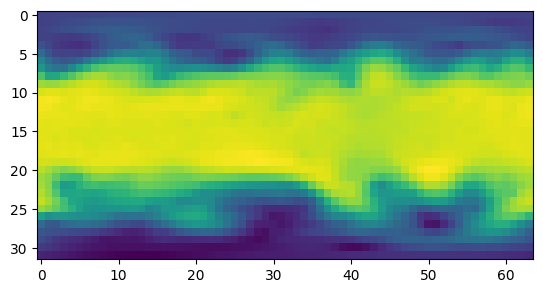

In [12]:
plt.imshow(observations)

In [ ]:
import numpy as np

# Define the observation (ground truth)
observation = np.array([[1, 2], [1, 2]])

# Define the ensemble forecast
forecast = [
    np.array([[4, 2], [3, 2]]),
    np.array([[4, 2], [3, 2]]),
    np.array([[4, 2], [3, 2]]),
    np.array([[4, 2], [3, 2]]),
    np.array([[4, 2], [3, 2]])
]

# Calculate the probabilities of the forecasts
probabilities = []
for member in forecast:
    # For each member, calculate the probability of observing the ground truth value or lower
    prob = np.mean(member <= observation)
    probabilities.append(prob)

# Rank the probabilities
ranks = np.argsort(np.argsort(probabilities)) + 1  # Add 1 for 1-based ranks

# Calculate the rank histogram (count the number of forecasts in each rank)
histogram = np.histogram(ranks, bins=np.arange(1, len(forecast) + 2))[0]

print("Rank Histogram:", histogram)


In [ ]:
import numpy as np
from scipy.stats import rankdata

def rankz(obs,ensemble,mask):
    ''' Parameters
    ----------
    obs : array of observations 
    ensemble : array of ensemble, with the first dimension being the 
        ensemble member and the remaining dimensions being identical to obs
    mask : boolean mask of shape of obs, with zero/false being where grid cells are masked.  

    Returns
    -------
    histogram data for ensemble.shape[0] + 1 bins. 
    The first dimension of this array is the height of 
    each histogram bar, the second dimension is the histogram bins. 
         '''

    mask=np.bool_(mask)

    obs=obs[mask]
    ensemble=ensemble[:,mask]
    
    combined=np.vstack((obs[np.newaxis],ensemble))

    # print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    # print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    tie=np.unique(ties)

    for i in range(1,len(tie)):
        index=ranks[ties==tie[i]]
        # print('randomizing tied ranks for ' + str(len(index)) + ' instances where there is ' + str(tie[i]) + ' tie/s. ' + str(len(tie)-i-1) + ' more to go')
        ranks[ties==tie[i]]=[np.random.randint(index[j],index[j]+tie[i]+1,tie[i])[0] for j in range(len(index))]

    return np.histogram(ranks, bins=np.linspace(0.5, combined.shape[0]+0.5, combined.shape[0]+1))